In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### catboost

In [2]:
def CatBoostC(train_x, test_x, train_y, test_y, config, cat_feature):
    
    clf = CatBoostClassifier(**config, verbose = 0)
    clf.fit(train_x, train_y, cat_features = cat_feature)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def CatBoostR(train_x, test_x, train_y, test_y, config, cat_feature):
    
    reg = CatBoostRegressor(**config, verbose = 0)
    reg.fit(train_x, train_y, cat_features = cat_feature)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


def runall_CatBoostC(num_set, trainset_x, test_x, trainset_y, test_y, config, cat_feature):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = CatBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config, cat_feature)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_CatBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, cat_feature, thres_target = 'Recall', 
                     threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = CatBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config, cat_feature)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [3]:
def CatBoost_creator(train_data, mode, cat_feature = [], num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        param_1 = {
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'iterations': trial.suggest_int('iterations', 100, 300, step = 50),
            'depth': trial.suggest_int('depth', 2, 10, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10) 
        }

        if param_1['grow_policy'] == 'Depthwise' :
            param_2 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 30, step = 3)
            }
            param = {**param_1, **param_2}
        
        elif param_1['grow_policy'] == 'Lossguide' :
            param_3 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 30, step = 3),
                'max_leaves': trial.suggest_int('max_leaves', 15, 50, step = 5)
            }
            param = {**param_1, **param_3}
        
        else :
            param = param_1

        result_list = []
        for i in range(num_valid):

            train_x, train_y = label_divide(train_data, None, label, train_only = True)
            train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

            if mode == 'C':
                result = CatBoostC(train_x, valid_x, train_y, valid_y, param, cat_feature)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']
                effi = table['Efficiency']
                result_list.append(recall - 0.1*aging)

            elif mode == 'R':
                result = CatBoostR(train_x, valid_x, train_y, valid_y, param, cat_feature)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = [2, 3, 4]

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (38022, 96)  balance ratio: 863.0
Dimension of dataset 1 : (1128, 96)  balance ratio: 1.0
Dimension of dataset 2 : (962, 96)  balance ratio: 1.0
Dimension of dataset 3 : (1226, 96)  balance ratio: 1.0
Dimension of dataset 4 : (1138, 96)  balance ratio: 1.0
Dimension of dataset 5 : (883, 96)  balance ratio: 1.0
Dimension of dataset 6 : (921, 96)  balance ratio: 1.0
Dimension of dataset 7 : (880, 96)  balance ratio: 1.0
Dimension of dataset 8 : (880, 96)  balance ratio: 1.0
Dimension of dataset 9 : (484, 96)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60607, 107)  balance ratio: 550.0
Dimension of dataset 1 : (1800, 107)  balance ratio: 1.0
Dimension of dataset 2 : (2948, 107)  balance ratio: 1.0
Dimension of dataset 3 : (2030, 107)  balance ratio: 1.0
Dimension of dataset 4 : (1814, 107)  balance ratio: 1.0
Dimension of dataset 5 : (2203, 107)  balance ratio: 1.0
Dimension of

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 200, 
                                     filename = 'runhist_array_m2m5_4selection_CatBoost', 
                                     creator = CatBoost_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 11:03:37,275] A new study created in memory with name: no-name-0cd7be66-44f3-49eb-a28c-6a20ee9d2686


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5625 
Recall: 0.125 
Aging Rate: 0.0004092804338372599


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6666666666666666 
Recall: 0.16666666666666666 
Aging Rate: 0.00038370040672243113


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7222222222222222 
Recall: 0.17105263157894737 
Aging Rate: 0.00046044048806691734
[I 2021-10-13 11:03:50,259] Trial 0 finished with value: 0.1541979853709171 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.004317976985541747}. Best is trial 0 with value: 0.1541979853709171.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.3103448275862069 
Aging Rate: 0.0004860205151817461


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7 
Recall: 0.2 
Aging Rate: 0.0005116005422965748


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.2028985507246377 
Aging Rate: 0.00038370040672243113
[I 2021-10-13 11:04:02,445] Trial 1 finished with value: 0.23770174872147484 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.39473723826544665, 'min_data_in_leaf': 30}. Best is trial 1 with value: 0.23770174872147484.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.029411764705882353 
Aging Rate: 5.1160054229657485e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5 
Recall: 0.02 
Aging Rate: 5.1160054229657485e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:04:21,777] Trial 2 finished with value: 0.016467177565012137 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.19233278261246173, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.23770174872147484.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:04:29,671] Trial 3 finished with value: 0.0 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.02249893675543673}. Best is trial 1 with value: 0.23770174872147484.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.734375 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.640625 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.4838709677419355 
Aging Rate: 0.0008441408947893485
[I 2021-10-13 11:05:23,077] Trial 4 finished with value: 0.6195162198000962 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.15574371577916216}. Best is trial 4 with value: 0.6195162198000962.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.23333333333333334 
Aging Rate: 0.0004092804338372599


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9375 
Recall: 0.25862068965517243 
Aging Rate: 0.0004092804338372599


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8 
Recall: 0.32786885245901637 
Aging Rate: 0.0006395006778707185
[I 2021-10-13 11:05:49,916] Trial 5 finished with value: 0.27322568976432254 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.01405326091949848, 'min_data_in_leaf': 27, 'max_leaves': 15}. Best is trial 4 with value: 0.6195162198000962.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9512195121951219 
Recall: 0.7358490566037735 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.7538461538461538 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.734375 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 11:06:26,660] Trial 6 finished with value: 0.7412365106892027 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.027815581976796632, 'min_data_in_leaf': 27}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.13559322033898305 
Aging Rate: 0.00020464021691862994


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.18181818181818182 
Aging Rate: 0.00028138029826311616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.208955223880597 
Aging Rate: 0.00035812037960760237
[I 2021-10-13 11:07:07,373] Trial 7 finished with value: 0.17542740398276094 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.44944699746871897}. Best is trial 6 with value: 0.7412365106892027.


Training has stopped (degenerate solution on iteration 23, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: R

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5 
Recall: 0.015151515151515152 
Aging Rate: 5.1160054229657485e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:07:14,017] Trial 8 finished with value: 0.005048799715364062 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0010527142519238997, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.017543859649122806 
Aging Rate: 2.5580027114828743e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.03571428571428571 
Aging Rate: 5.1160054229657485e-05
[I 2021-10-13 11:07:40,417] Trial 9 finished with value: 0.01775015711842469 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.27793089213670624}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7735849056603774 
Recall: 0.7454545454545455 
Aging Rate: 0.0013557414370859234


Training has stopped (degenerate solution on iteration 60, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9310344827586207 
Recall: 0.4426229508196721 
Aging Rate: 0.0007418207863300336


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9074074074074074 
Recall: 0.8032786885245902 
Aging Rate: 0.001381321464200752
[I 2021-10-13 11:08:05,982] Trial 10 finished with value: 0.6636694321433487 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.005989987808891874, 'min_data_in_leaf': 24}. Best is trial 6 with value: 0.7412365106892027.


Training has stopped (degenerate solution on iteration 264, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.008709016393442622 
Recall: 0.2328767123287671 
Aging Rate: 0.0499322129281457


Training has stopped (degenerate solution on iteration 29, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8125 
Recall: 0.21311475409836064 
Aging Rate: 0.0004092804338372599


Training has stopped (degenerate solution on iteration 40, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.39285714285714285 
Recall: 0.1527777777777778 
Aging Rate: 0.0007162407592152047
[I 2021-10-13 11:08:25,680] Trial 11 finished with value: 0.19788782359759524 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.001398028711387869, 'min_data_in_leaf': 24}. Best is trial 6 with value: 0.7412365106892027.


Training has stopped (degenerate solution on iteration 147, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7666666666666667 
Recall: 0.7076923076923077 
Aging Rate: 0.0015348016268897245


Training has stopped (degenerate solution on iteration 187, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7424242424242424 
Recall: 0.6533333333333333 
Aging Rate: 0.001688281789578697


Training has stopped (degenerate solution on iteration 54, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.631578947368421 
Recall: 0.18181818181818182 
Aging Rate: 0.0004860205151817461
[I 2021-10-13 11:08:42,219] Trial 12 finished with value: 0.5141576374835526 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0013053319969527225, 'min_data_in_leaf': 21}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8245614035087719 
Recall: 0.734375 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.6923076923076923 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8518518518518519 
Recall: 0.6764705882352942 
Aging Rate: 0.001381321464200752
[I 2021-10-13 11:09:22,120] Trial 13 finished with value: 0.7009138140354793 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.024903752429772476, 'min_data_in_leaf': 21}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.8727272727272727 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.5217391304347826 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8723404255319149 
Recall: 0.5857142857142857 
Aging Rate: 0.001202261274396951
[I 2021-10-13 11:10:04,352] Trial 14 finished with value: 0.6599382981628663 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.5879524809930515, 'min_data_in_leaf': 3}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7580645161290323 
Recall: 0.734375 
Aging Rate: 0.001585961681119382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.7058823529411765 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8846153846153846 
Recall: 0.5822784810126582 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 11:10:31,344] Trial 15 finished with value: 0.6740336578309609 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.006436177158162841, 'min_data_in_leaf': 18}. Best is trial 6 with value: 0.7412365106892027.


Training has stopped (degenerate solution on iteration 24, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.058823529411764705 
Recall: 0.014285714285714285 
Aging Rate: 0.0004348604609520886


Training has stopped (degenerate solution on iteration 13, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0001279001355741437


Training has stopped (degenerate solution on iteration 38, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6 
Recall: 0.046153846153846156 
Aging Rate: 0.0001279001355741437
[I 2021-10-13 11:10:38,432] Trial 16 finished with value: 0.020123498122116803 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0024115995184453357, 'min_data_in_leaf': 30}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.6857142857142857 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6301369863013698 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8333333333333334 
Recall: 0.7258064516129032 
Aging Rate: 0.001381321464200752
[I 2021-10-13 11:11:57,553] Trial 17 finished with value: 0.6804204110694263 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.07039775413738107, 'min_data_in_leaf': 15}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.75 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9210526315789473 
Recall: 0.625 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8157894736842105 
Recall: 0.5849056603773585 
Aging Rate: 0.0009720410303634922
[I 2021-10-13 11:12:42,568] Trial 18 finished with value: 0.653197008681282 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.08435378757190315, 'min_data_in_leaf': 21}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7424242424242424 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.6714285714285714 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.6037735849056604 
Aging Rate: 0.0009208809761338347
[I 2021-10-13 11:13:12,934] Trial 19 finished with value: 0.6724227594596223 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.013538406813322525, 'min_data_in_leaf': 27}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8863636363636364 
Recall: 0.7222222222222222 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9210526315789473 
Recall: 0.660377358490566 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8103448275862069 
Recall: 0.6527777777777778 
Aging Rate: 0.001483641572660067
[I 2021-10-13 11:13:48,171] Trial 20 finished with value: 0.6783397460369861 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.12720622545855062, 'min_data_in_leaf': 6}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8444444444444444 
Recall: 0.59375 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9347826086956522 
Recall: 0.6056338028169014 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9487179487179487 
Recall: 0.74 
Aging Rate: 0.000997621057478321
[I 2021-10-13 11:15:25,136] Trial 21 finished with value: 0.6463504208214695 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.06634673380046305, 'min_data_in_leaf': 15}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7777777777777778 
Recall: 0.3230769230769231 
Aging Rate: 0.000690660732100376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.3559322033898305 
Aging Rate: 0.0005627605965262323


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.40298507462686567 
Aging Rate: 0.0007674008134448623
[I 2021-10-13 11:15:55,415] Trial 22 finished with value: 0.360597372959804 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.04064683986156001, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8269230769230769 
Recall: 0.7288135593220338 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.6176470588235294 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8636363636363636 
Recall: 0.5757575757575758 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 11:17:12,181] Trial 23 finished with value: 0.6406200245078438 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.11328121718811733, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7272727272727273 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.6527777777777778 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8163265306122449 
Recall: 0.5405405405405406 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 11:18:23,390] Trial 24 finished with value: 0.640070820396582 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.004764310935743558}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.7 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.6896551724137931 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8913043478260869 
Recall: 0.6507936507936508 
Aging Rate: 0.001176681247282122
[I 2021-10-13 11:20:02,158] Trial 25 finished with value: 0.680029381608375 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.154199179643804, 'min_data_in_leaf': 21}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.7121212121212122 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8604651162790697 
Recall: 0.5967741935483871 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9512195121951219 
Recall: 0.5416666666666666 
Aging Rate: 0.0010487811117079783
[I 2021-10-13 11:21:09,868] Trial 26 finished with value: 0.6167372086549309 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.039929682463663796, 'min_data_in_leaf': 15}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.20754716981132076 
Aging Rate: 0.0003069603253779449


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.23214285714285715 
Aging Rate: 0.00033254035249277367


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.3333333333333333 
Aging Rate: 0.0005371805694114036
[I 2021-10-13 11:21:29,090] Trial 27 finished with value: 0.2576352307209277 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 8.785848023131939, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.6461538461538462 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8431372549019608 
Recall: 0.6515151515151515 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.7192982456140351 
Aging Rate: 0.001099941165937636
[I 2021-10-13 11:22:04,937] Trial 28 finished with value: 0.6722013356326674 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.6636138540884061, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6909090909090909 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8596491228070176 
Recall: 0.7101449275362319 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7 
Aging Rate: 0.0014324815184304095
[I 2021-10-13 11:22:33,579] Trial 29 finished with value: 0.7002225866786297 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.005633709581563913}. Best is trial 6 with value: 0.7412365106892027.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.7164179104477612 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.88 
Recall: 0.7719298245614035 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.7704918032786885 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 11:22:59,368] Trial 30 finished with value: 0.7528134966216206 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.009196554442387291}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8809523809523809 
Recall: 0.5606060606060606 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8085106382978723 
Recall: 0.7307692307692307 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8666666666666667 
Recall: 0.7090909090909091 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 11:23:30,948] Trial 31 finished with value: 0.6667078093676206 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.004617597617341957}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7714285714285715 
Recall: 0.38028169014084506 
Aging Rate: 0.000895300949019006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9032258064516129 
Recall: 0.358974358974359 
Aging Rate: 0.000792980840559691


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8181818181818182 
Recall: 0.34177215189873417 
Aging Rate: 0.0008441408947893485
[I 2021-10-13 11:23:54,964] Trial 32 finished with value: 0.3602583195818338 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.018930831933008235}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.11538461538461539 
Aging Rate: 0.00023022024403345867


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6 
Recall: 0.12162162162162163 
Aging Rate: 0.00038370040672243113


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.42857142857142855 
Recall: 0.046875 
Aging Rate: 0.00017906018980380119
[I 2021-10-13 11:24:06,493] Trial 33 finished with value: 0.09460064630739368 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.003835945514080763}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8518518518518519 
Recall: 0.7666666666666667 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7258064516129032 
Recall: 0.7258064516129032 
Aging Rate: 0.001585961681119382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.7014925373134329 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 11:24:22,372] Trial 34 finished with value: 0.7311786370458245 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.003758166321036713}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8372093023255814 
Recall: 0.631578947368421 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.6779661016949152 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8478260869565217 
Recall: 0.5416666666666666 
Aging Rate: 0.001176681247282122
[I 2021-10-13 11:24:38,651] Trial 35 finished with value: 0.6169563144555548 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.00953920365926938}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8222222222222222 
Recall: 0.7254901960784313 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8793103448275862 
Recall: 0.7083333333333334 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7666666666666667 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 11:24:56,130] Trial 36 finished with value: 0.7333654212202877 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.008797517400245126}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8717948717948718 
Recall: 0.5862068965517241 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7959183673469388 
Recall: 0.7222222222222222 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.7096774193548387 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 11:25:21,870] Trial 37 finished with value: 0.6725862165866744 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.03010589518107694}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.6885245901639344 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8070175438596491 
Recall: 0.696969696969697 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8113207547169812 
Recall: 0.6825396825396826 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 11:25:41,773] Trial 38 finished with value: 0.6892116404167742 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.008137865510271083, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8703703703703703 
Recall: 0.7833333333333333 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7647058823529411 
Recall: 0.6610169491525424 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8363636363636363 
Recall: 0.6764705882352942 
Aging Rate: 0.0014069014913155808
[I 2021-10-13 11:25:58,448] Trial 39 finished with value: 0.7068038634291108 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0029547680108277367}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6842105263157895 
Recall: 0.20967741935483872 
Aging Rate: 0.0004860205151817461


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.64 
Recall: 0.25396825396825395 
Aging Rate: 0.0006395006778707185


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7083333333333334 
Recall: 0.2463768115942029 
Aging Rate: 0.0006139206507558898
[I 2021-10-13 11:26:10,828] Trial 40 finished with value: 0.2366161802443049 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.003739253673577297}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8695652173913043 
Recall: 0.5633802816901409 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8545454545454545 
Recall: 0.746031746031746 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8363636363636363 
Recall: 0.7076923076923077 
Aging Rate: 0.0014069014913155808
[I 2021-10-13 11:26:27,788] Trial 41 finished with value: 0.6722350956637344 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.002290306085246451}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7692307692307693 
Recall: 0.5084745762711864 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.509090909090909 
Aging Rate: 0.0008185608676745198


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8857142857142857 
Recall: 0.4696969696969697 
Aging Rate: 0.000895300949019006
[I 2021-10-13 11:26:42,772] Trial 42 finished with value: 0.4956637689238827 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.030097481229816737}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8333333333333334 
Recall: 0.6896551724137931 
Aging Rate: 0.0012278413015117797


Training has stopped (degenerate solution on iteration 18, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6666666666666666 
Recall: 0.05714285714285714 
Aging Rate: 0.00015348016268897246


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9137931034482759 
Recall: 0.6794871794871795 
Aging Rate: 0.001483641572660067
[I 2021-10-13 11:26:57,642] Trial 43 finished with value: 0.47533290424671454 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0015923261023313884}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.926829268292683 
Recall: 0.6129032258064516 
Aging Rate: 0.0010487811117079783


Training has stopped (degenerate solution on iteration 125, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8448275862068966 
Recall: 0.8032786885245902 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.7121212121212122 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 11:27:29,761] Trial 44 finished with value: 0.7093047700133696 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0028067682535461813}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7857142857142857 
Recall: 0.6027397260273972 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.671875 
Aging Rate: 0.0012534213286266084


Training has stopped (degenerate solution on iteration 62, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8333333333333334 
Recall: 0.5932203389830508 
Aging Rate: 0.0010743611388228072
[I 2021-10-13 11:27:49,803] Trial 45 finished with value: 0.6224863462039534 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0011444219777961024}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8852459016393442 
Recall: 0.6923076923076923 
Aging Rate: 0.0015603816540045532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.6619718309859155 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.6428571428571429 
Aging Rate: 0.001202261274396951
[I 2021-10-13 11:28:27,115] Trial 46 finished with value: 0.6655792059092531 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.06603112326379659}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7586206896551724 
Recall: 0.6875 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8301886792452831 
Recall: 0.7213114754098361 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9375 
Recall: 0.5172413793103449 
Aging Rate: 0.0008185608676745198
[I 2021-10-13 11:29:13,291] Trial 47 finished with value: 0.6418956867774797 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.008030590720507725, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.012987012987012988 
Aging Rate: 2.5580027114828743e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.01639344262295082 
Aging Rate: 2.5580027114828743e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:29:34,012] Trial 48 finished with value: 0.00979177986818028 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0920645782983731}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.6461538461538462 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.88 
Recall: 0.7213114754098361 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9555555555555556 
Recall: 0.6142857142857143 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 11:30:13,281] Trial 49 finished with value: 0.6604625998214554 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.050153056777264754}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.028985507246376812 
Aging Rate: 5.1160054229657485e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.03225806451612903 
Aging Rate: 5.1160054229657485e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.016129032258064516 
Aging Rate: 2.5580027114828743e-05
[I 2021-10-13 11:30:54,694] Trial 50 finished with value: 0.025786604669004315 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 6.511661291088461, 'min_data_in_leaf': 9}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8771929824561403 
Recall: 0.7352941176470589 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8627450980392157 
Recall: 0.7213114754098361 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7924528301886793 
Recall: 0.6461538461538462 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 11:31:14,195] Trial 51 finished with value: 0.7007825335913975 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.004586023804712219, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7948717948717948 
Recall: 0.4246575342465753 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.3389830508474576 
Aging Rate: 0.0005371805694114036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6388888888888888 
Recall: 0.359375 
Aging Rate: 0.0009208809761338347
[I 2021-10-13 11:31:47,926] Trial 52 finished with value: 0.37425667227791015 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0022787955345530907}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.813953488372093 
Recall: 0.5645161290322581 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.5753424657534246 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8490566037735849 
Recall: 0.7142857142857143 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 11:32:04,478] Trial 53 finished with value: 0.6179244662260773 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.006923749225345937}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9210526315789473 
Recall: 0.6363636363636364 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.7166666666666667 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.6461538461538462 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 11:32:25,772] Trial 54 finished with value: 0.6662779009375587 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0018601458343372333, 'min_data_in_leaf': 30, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.6875 
Aging Rate: 0.001202261274396951


Training has stopped (degenerate solution on iteration 110, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.6792452830188679 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8095238095238095 
Recall: 0.7391304347826086 
Aging Rate: 0.0010743611388228072
[I 2021-10-13 11:33:02,626] Trial 55 finished with value: 0.7018468731487574 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0026616729679135604}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9736842105263158 
Recall: 0.6065573770491803 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8717948717948718 
Recall: 0.5666666666666667 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7076923076923077 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 11:33:39,126] Trial 56 finished with value: 0.6268629756870283 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.01950815949951358}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8367346938775511 
Recall: 0.6507936507936508 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.7580645161290323 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8085106382978723 
Recall: 0.7169811320754716 
Aging Rate: 0.001202261274396951
[I 2021-10-13 11:34:14,376] Trial 57 finished with value: 0.7084886102007594 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.01458973415961392, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.3333333333333333 
Recall: 0.015384615384615385 
Aging Rate: 7.674008134448623e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8333333333333334 
Recall: 0.625 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.6825396825396826 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 11:34:37,851] Trial 58 finished with value: 0.44088949921771653 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.005963327721222039, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.015384615384615385 
Aging Rate: 2.5580027114828743e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:35:08,946] Trial 59 finished with value: 0.005127352460634634 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.15538068260694302, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.40625 
Aging Rate: 0.0007162407592152047


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8235294117647058 
Recall: 0.2222222222222222 
Aging Rate: 0.0004348604609520886


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8974358974358975 
Recall: 0.5147058823529411 
Aging Rate: 0.000997621057478321
[I 2021-10-13 11:35:35,087] Trial 60 finished with value: 0.38098774411579955 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.006463615102392273, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8813559322033898 
Recall: 0.7761194029850746 
Aging Rate: 0.0015092215997748958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8709677419354839 
Recall: 0.7012987012987013 
Aging Rate: 0.001585961681119382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.6923076923076923 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 11:36:38,118] Trial 61 finished with value: 0.723095273375031 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.26837067594319064, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.6956521739130435 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8909090909090909 
Recall: 0.6805555555555556 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9347826086956522 
Recall: 0.7678571428571429 
Aging Rate: 0.001176681247282122
[I 2021-10-13 11:37:41,042] Trial 62 finished with value: 0.7145586853045321 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.07354524339582269, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8979591836734694 
Recall: 0.7096774193548387 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.7230769230769231 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.6774193548387096 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 11:38:46,102] Trial 63 finished with value: 0.7032633322879164 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.239267523976798, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.6323529411764706 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.6811594202898551 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7758620689655172 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 11:39:45,559] Trial 64 finished with value: 0.6963319486768479 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.1256479192653862, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.6666666666666666 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.6825396825396826 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8793103448275862 
Recall: 0.7727272727272727 
Aging Rate: 0.001483641572660067
[I 2021-10-13 11:40:37,946] Trial 65 finished with value: 0.7071841598432037 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.24750669823389088, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9074074074074074 
Recall: 0.7101449275362319 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.6363636363636364 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.7777777777777778 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 11:41:26,302] Trial 66 finished with value: 0.7079624310848849 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.643029087812943}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.6507936507936508 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9137931034482759 
Recall: 0.6883116883116883 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8181818181818182 
Recall: 0.703125 
Aging Rate: 0.0014069014913155808
[I 2021-10-13 11:42:35,760] Trial 67 finished with value: 0.6806095775598787 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.867529546667133, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.5645161290322581 
Aging Rate: 0.0010232010845931496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.7241379310344828 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6666666666666666 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 11:43:33,696] Trial 68 finished with value: 0.6516542021179333 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.03286057422566572, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.75 
Recall: 0.045454545454545456 
Aging Rate: 0.00010232010845931497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.10909090909090909 
Aging Rate: 0.00015348016268897246


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.04918032786885246 
Aging Rate: 7.674008134448623e-05
[I 2021-10-13 11:43:54,352] Trial 69 finished with value: 0.06789750945968591 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 9.137440428285137}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.6825396825396826 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8444444444444444 
Recall: 0.6551724137931034 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.647887323943662 
Aging Rate: 0.001202261274396951
[I 2021-10-13 11:44:15,521] Trial 70 finished with value: 0.661746247298043 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.05146613349045993}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8627450980392157 
Recall: 0.6376811594202898 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.7592592592592593 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.6376811594202898 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 11:44:58,731] Trial 71 finished with value: 0.6780852612373657 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.04517359107251204, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.6119402985074627 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8636363636363636 
Recall: 0.6551724137931034 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8974358974358975 
Recall: 0.5072463768115942 
Aging Rate: 0.000997621057478321
[I 2021-10-13 11:46:23,117] Trial 72 finished with value: 0.5913455935901711 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.023616995451871244, 'min_data_in_leaf': 21}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9032258064516129 
Recall: 0.5490196078431373 
Aging Rate: 0.000792980840559691


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.625 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9487179487179487 
Recall: 0.5285714285714286 
Aging Rate: 0.000997621057478321
[I 2021-10-13 11:46:45,134] Trial 73 finished with value: 0.5674348467036266 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.08058472188726114, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9024390243902439 
Recall: 0.6065573770491803 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7291666666666666 
Aging Rate: 0.0010232010845931496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8269230769230769 
Recall: 0.7049180327868853 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 11:47:41,477] Trial 74 finished with value: 0.6801006207140349 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.009934813905303404, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7272727272727273 
Recall: 0.5970149253731343 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6031746031746031 
Recall: 0.5507246376811594 
Aging Rate: 0.0016115417082342108


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.684931506849315 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 11:48:07,839] Trial 75 finished with value: 0.6107445504799817 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0060062780407707135, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9056603773584906 
Recall: 0.7741935483870968 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.6086956521739131 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8409090909090909 
Recall: 0.6607142857142857 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 11:49:39,977] Trial 76 finished with value: 0.681078377961614 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.027420257566276553, 'min_data_in_leaf': 24}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.6521739130434783 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.88 
Recall: 0.7457627118644068 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9074074074074074 
Recall: 0.6447368421052632 
Aging Rate: 0.001381321464200752
[I 2021-10-13 11:50:24,468] Trial 77 finished with value: 0.6807606975327638 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.056793290426368555, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.78125 
Recall: 0.704225352112676 
Aging Rate: 0.0016371217353490395


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9074074074074074 
Recall: 0.7313432835820896 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7083333333333334 
Recall: 0.7555555555555555 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 11:51:07,352] Trial 78 finished with value: 0.7302331876000716 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0021321727584343894, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 51, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.4 
Recall: 0.0625 
Aging Rate: 0.0002558002711482874


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5580027114828743e-05


Training has stopped (degenerate solution on iteration 20, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.4 
Recall: 0.031746031746031744 
Aging Rate: 0.0001279001355741437
[I 2021-10-13 11:51:14,510] Trial 79 finished with value: 0.031401701234216005 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0011697256900362284, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7758620689655172 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.7413793103448276 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8387096774193549 
Recall: 0.6753246753246753 
Aging Rate: 0.001585961681119382
[I 2021-10-13 11:51:59,134] Trial 80 finished with value: 0.7307189247337277 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.00309049935571362, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7755102040816326 
Recall: 0.6440677966101694 
Aging Rate: 0.0012534213286266084


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.2 
Recall: 0.016666666666666666 
Aging Rate: 0.0001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.7241379310344828 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 11:52:22,375] Trial 81 finished with value: 0.4615405700151978 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.003428551582370413, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.6153846153846154 
Aging Rate: 0.0009208809761338347


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.618421052631579 
Aging Rate: 0.0013045813828562658


Training has stopped (degenerate solution on iteration 30, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.3333333333333333 
Recall: 0.0410958904109589 
Aging Rate: 0.00023022024403345867
[I 2021-10-13 11:52:58,212] Trial 82 finished with value: 0.424885330055617 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0031279882361630435, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:53:30,594] Trial 83 finished with value: 0.0 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.127012988526257, 'min_data_in_leaf': 15}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 79, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: R

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 68, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: R

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 88, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: R

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 11:53:39,458] Trial 84 finished with value: 0.0 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0020471889299255946}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.782608695652174 
Recall: 0.6101694915254238 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8518518518518519 
Recall: 0.7076923076923077 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.813953488372093 
Recall: 0.6862745098039216 
Aging Rate: 0.001099941165937636
[I 2021-10-13 11:54:39,318] Trial 85 finished with value: 0.6679235048779703 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.05050593378899478, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 63, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8181818181818182 
Recall: 0.29508196721311475 
Aging Rate: 0.0005627605965262323


Training has stopped (degenerate solution on iteration 6, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00010232010845931497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6984126984126984 
Recall: 0.6567164179104478 
Aging Rate: 0.0016115417082342108
[I 2021-10-13 11:54:58,321] Trial 86 finished with value: 0.3171902409607468 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.001501189171807702, 'min_data_in_leaf': 9, 'max_leaves': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.851063829787234 
Recall: 0.7272727272727273 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.7272727272727273 
Aging Rate: 0.0016115417082342108


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.84375 
Recall: 0.5625 
Aging Rate: 0.0008185608676745198
[I 2021-10-13 11:55:34,962] Trial 87 finished with value: 0.6722274060534748 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.02791236909699154, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.6527777777777778 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.676923076923077 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.5633802816901409 
Aging Rate: 0.0010743611388228072
[I 2021-10-13 11:56:24,884] Trial 88 finished with value: 0.6309068193362255 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.24813509870154946, 'min_data_in_leaf': 21}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 137, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8035714285714286 
Recall: 0.625 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8301886792452831 
Recall: 0.6875 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8620689655172413 
Recall: 0.7352941176470589 
Aging Rate: 0.001483641572660067
[I 2021-10-13 11:56:58,905] Trial 89 finished with value: 0.6824556437314137 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.001697232463941994}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9111111111111111 
Recall: 0.5189873417721519 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9387755102040817 
Recall: 0.6388888888888888 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9347826086956522 
Recall: 0.6935483870967742 
Aging Rate: 0.001176681247282122
[I 2021-10-13 11:57:50,853] Trial 90 finished with value: 0.6170221657927358 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.6967945121001096, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.6338028169014085 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.5432098765432098 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.7580645161290323 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 11:58:23,946] Trial 91 finished with value: 0.6448969837214055 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.07078398385512254, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7407407407407407 
Recall: 0.37037037037037035 
Aging Rate: 0.000690660732100376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7857142857142857 
Recall: 0.36666666666666664 
Aging Rate: 0.0007162407592152047


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7931034482758621 
Recall: 0.34328358208955223 
Aging Rate: 0.0007418207863300336
[I 2021-10-13 11:58:47,992] Trial 92 finished with value: 0.36003524896627487 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.01416401069324354}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8095238095238095 
Recall: 0.2328767123287671 
Aging Rate: 0.0005371805694114036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7619047619047619 
Recall: 0.21621621621621623 
Aging Rate: 0.0005371805694114036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.78125 
Recall: 0.3246753246753247 
Aging Rate: 0.0008185608676745198
[I 2021-10-13 11:59:13,452] Trial 93 finished with value: 0.25785965367321945 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.005220440716741514}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.015151515151515152 
Aging Rate: 2.5580027114828743e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.014925373134328358 
Aging Rate: 2.5580027114828743e-05
[I 2021-10-13 11:59:24,998] Trial 94 finished with value: 0.010023924093473515 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.43759242289717515, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8666666666666667 
Recall: 0.6610169491525424 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.5555555555555556 
Aging Rate: 0.000895300949019006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.711864406779661 
Recall: 0.6461538461538462 
Aging Rate: 0.0015092215997748958
[I 2021-10-13 11:59:54,019] Trial 95 finished with value: 0.6207902628283494 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.013029764101090432, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9024390243902439 
Recall: 0.6271186440677966 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.803921568627451 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9111111111111111 
Recall: 0.6949152542372882 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 12:01:13,261] Trial 96 finished with value: 0.7085418281942516 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.11130633325795047, 'min_data_in_leaf': 15}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7142857142857143 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8653846153846154 
Recall: 0.6338028169014085 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.7101449275362319 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 12:02:10,931] Trial 97 finished with value: 0.6859465087685953 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03477375054299967, 'min_data_in_leaf': 15}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.704225352112676 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.676056338028169 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.6875 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 12:03:49,606] Trial 98 finished with value: 0.6891326632447076 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.3022218848360301, 'min_data_in_leaf': 12}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.7678571428571429 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8636363636363636 
Recall: 0.6909090909090909 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8780487804878049 
Recall: 0.6101694915254238 
Aging Rate: 0.0010487811117079783
[I 2021-10-13 12:05:09,814] Trial 99 finished with value: 0.6895309843094397 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.03230356204280714, 'min_data_in_leaf': 15}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.5797101449275363 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.43548387096774194 
Aging Rate: 0.0007162407592152047


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9666666666666667 
Recall: 0.5370370370370371 
Aging Rate: 0.0007674008134448623
[I 2021-10-13 12:05:26,837] Trial 100 finished with value: 0.5173225262176775 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.20168077016811398}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.88 
Recall: 0.36065573770491804 
Aging Rate: 0.0006395006778707185


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8611111111111112 
Recall: 0.5166666666666667 
Aging Rate: 0.0009208809761338347


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7894736842105263 
Recall: 0.45454545454545453 
Aging Rate: 0.0009720410303634922
[I 2021-10-13 12:05:53,065] Trial 101 finished with value: 0.4438715388828675 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.005231744632395777, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7727272727272727 
Recall: 0.576271186440678 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8431372549019608 
Recall: 0.7288135593220338 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8723404255319149 
Recall: 0.6949152542372882 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:06:34,752] Trial 102 finished with value: 0.6665455878716565 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.09725108421501036, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 65, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.14285714285714285 
Recall: 0.01639344262295082 
Aging Rate: 0.00017906018980380119


Training has stopped (degenerate solution on iteration 35, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.1111111111111111 
Recall: 0.015384615384615385 
Aging Rate: 0.00023022024403345867


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: R

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 12:06:42,960] Trial 103 finished with value: 0.01057904332139416 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0014240696889512737, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8163265306122449 
Recall: 0.6557377049180327 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8863636363636364 
Recall: 0.6290322580645161 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.71875 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:07:29,317] Trial 104 finished with value: 0.6677206142009804 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.7944010937721344, 'min_data_in_leaf': 15}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8620689655172413 
Recall: 0.35714285714285715 
Aging Rate: 0.0007418207863300336


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8421052631578947 
Recall: 0.43243243243243246 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8285714285714286 
Recall: 0.4142857142857143 
Aging Rate: 0.000895300949019006
[I 2021-10-13 12:07:42,699] Trial 105 finished with value: 0.40120002919481085 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0017705757728231227}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6388888888888888 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8636363636363636 
Recall: 0.6440677966101694 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8461538461538461 
Recall: 0.6285714285714286 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 12:08:07,289] Trial 106 finished with value: 0.6370506958906329 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.00326107616816231}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.7121212121212122 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8913043478260869 
Recall: 0.6507936507936508 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9302325581395349 
Recall: 0.7547169811320755 
Aging Rate: 0.001099941165937636
[I 2021-10-13 12:08:59,575] Trial 107 finished with value: 0.7057570552215399 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5948791660126689, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.6666666666666666 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.711864406779661 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.6875 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 12:10:17,881] Trial 108 finished with value: 0.6885542403519581 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.330147647685029, 'min_data_in_leaf': 21}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8545454545454545 
Recall: 0.7580645161290323 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7916666666666666 
Recall: 0.75 
Aging Rate: 0.0018417619522676694


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7833333333333333 
Recall: 0.6438356164383562 
Aging Rate: 0.0015348016268897245
[I 2021-10-13 12:10:59,490] Trial 109 finished with value: 0.7171405953534471 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.001435368411219795}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.68 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.5555555555555556 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.7101449275362319 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 12:12:18,431] Trial 110 finished with value: 0.6484397802292589 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.6150028382003294, 'min_data_in_leaf': 12}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7692307692307693 
Recall: 0.7272727272727273 
Aging Rate: 0.0013301614099710947


Training has stopped (degenerate solution on iteration 56, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7608695652173914 
Recall: 0.5645161290322581 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8387096774193549 
Recall: 0.7647058823529411 
Aging Rate: 0.001585961681119382
[I 2021-10-13 12:12:51,031] Trial 111 finished with value: 0.6853618194080298 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.002549839488206704}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 66, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.03333333333333333 
Recall: 0.015384615384615385 
Aging Rate: 0.0007674008134448623


Training has stopped (degenerate solution on iteration 46, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.09090909090909091 
Recall: 0.014084507042253521 
Aging Rate: 0.00028138029826311616


Training has stopped (degenerate solution on iteration 59, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.2857142857142857 
Recall: 0.0784313725490196 
Aging Rate: 0.00035812037960760237
[I 2021-10-13 12:13:03,884] Trial 112 finished with value: 0.03591993494225232 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0021729345128698903, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8947368421052632 
Recall: 0.4857142857142857 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.71875 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.746031746031746 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 12:13:55,384] Trial 113 finished with value: 0.6500468231230453 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.03266104736422336}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8793103448275862 
Recall: 0.6986301369863014 
Aging Rate: 0.001483641572660067


Training has stopped (degenerate solution on iteration 20, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.4666666666666667 
Recall: 0.10294117647058823 
Aging Rate: 0.00038370040672243113


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8703703703703703 
Recall: 0.7014925373134329 
Aging Rate: 0.001381321464200752
[I 2021-10-13 12:14:31,811] Trial 114 finished with value: 0.5009129948086547 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.001993577518403535, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 16, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.2608695652173913 
Recall: 0.07792207792207792 
Aging Rate: 0.000588340623641061


Training has stopped (degenerate solution on iteration 19, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.46153846153846156 
Recall: 0.1016949152542373 
Aging Rate: 0.00033254035249277367


Training has stopped (degenerate solution on iteration 105, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.71875 
Recall: 0.71875 
Aging Rate: 0.0016371217353490395
[I 2021-10-13 12:14:43,325] Trial 115 finished with value: 0.29937039763505563 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0015032699124076484, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.7142857142857143 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9069767441860465 
Recall: 0.7358490566037735 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.6885245901639344 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:15:53,087] Trial 116 finished with value: 0.7127645222218936 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.3497041779024076, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8541666666666666 
Recall: 0.640625 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8448275862068966 
Recall: 0.765625 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8372093023255814 
Recall: 0.5625 
Aging Rate: 0.001099941165937636
[I 2021-10-13 12:16:34,103] Trial 117 finished with value: 0.6561229525319964 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.2652013398650013, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8666666666666667 
Recall: 0.65 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.7647058823529411 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.6461538461538462 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:17:26,212] Trial 118 finished with value: 0.6868270480351626 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.773357687112813, 'min_data_in_leaf': 18}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.782608695652174 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.5806451612903226 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.7 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 12:19:00,024] Trial 119 finished with value: 0.6876259435146362 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.1299026490073527, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7954545454545454 
Recall: 0.5303030303030303 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8723404255319149 
Recall: 0.5774647887323944 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.734375 
Aging Rate: 0.001279001355741437
[I 2021-10-13 12:19:33,352] Trial 120 finished with value: 0.6139273802177018 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0044730099017370635}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.18461538461538463 
Aging Rate: 0.00035812037960760237


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.19718309859154928 
Aging Rate: 0.00038370040672243113


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8333333333333334 
Recall: 0.23809523809523808 
Aging Rate: 0.00046044048806691734
[I 2021-10-13 12:20:03,837] Trial 121 finished with value: 0.20659116505824407 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.5381169352954489, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.373134328358209 
Aging Rate: 0.000690660732100376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8666666666666667 
Recall: 0.43333333333333335 
Aging Rate: 0.0007674008134448623


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.3620689655172414 
Aging Rate: 0.000588340623641061
[I 2021-10-13 12:21:33,508] Trial 122 finished with value: 0.389443995663955 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 7.285595497015681, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.782608695652174 
Aging Rate: 0.0015348016268897245


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.547945205479452 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.7166666666666667 
Aging Rate: 0.001279001355741437
[I 2021-10-13 12:22:23,809] Trial 123 finished with value: 0.682277250462049 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.006728069610140003, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 193, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7894736842105263 
Recall: 0.6716417910447762 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8545454545454545 
Recall: 0.6811594202898551 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8448275862068966 
Recall: 0.6447368421052632 
Aging Rate: 0.001483641572660067
[I 2021-10-13 12:23:05,993] Trial 124 finished with value: 0.6657010643263142 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0025419451363800356}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 12:23:25,494] Trial 125 finished with value: 0.0 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.1610338517275518, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.8125 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8627450980392157 
Recall: 0.7096774193548387 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 12:23:44,071] Trial 126 finished with value: 0.7405953483133273 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.022751546153539966}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.5915492957746479 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.711864406779661 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8596491228070176 
Recall: 0.7313432835820896 
Aging Rate: 0.0014580615455452382
[I 2021-10-13 12:24:23,632] Trial 127 finished with value: 0.6781227232414176 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.00940802848450653}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.5769230769230769 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.7076923076923077 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.6461538461538462 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 12:24:52,263] Trial 128 finished with value: 0.643467812127163 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.2416210234596747}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8148148148148148 
Recall: 0.7096774193548387 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8604651162790697 
Recall: 0.6271186440677966 
Aging Rate: 0.001099941165937636


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.575 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 12:25:17,497] Trial 129 finished with value: 0.6371417176764901 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0051441746208720955}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 12:25:30,227] Trial 130 finished with value: 0.0 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.8315560483012008}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.7096774193548387 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9122807017543859 
Recall: 0.7761194029850746 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.6461538461538462 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 12:25:48,321] Trial 131 finished with value: 0.7105240280308202 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.033702999668368545}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.7833333333333333 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7272727272727273 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8653846153846154 
Recall: 0.6164383561643836 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 12:26:07,726] Trial 132 finished with value: 0.7088860527870035 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.04847190931015546}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.45901639344262296 
Aging Rate: 0.0008185608676745198


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8125 
Recall: 0.3939393939393939 
Aging Rate: 0.0008185608676745198


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8 
Recall: 0.5866666666666667 
Aging Rate: 0.0014069014913155808
[I 2021-10-13 12:26:23,753] Trial 133 finished with value: 0.4797726839086723 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.025432021914460708}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7666666666666667 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7551020408163265 
Recall: 0.6271186440677966 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8979591836734694 
Recall: 0.7333333333333333 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 12:26:40,165] Trial 134 finished with value: 0.7089125005545953 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.021071643362198685}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.6410256410256411 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.7843137254901961 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.5970149253731343 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 12:26:55,524] Trial 135 finished with value: 0.6739978711688841 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.010969642127108558}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8260869565217391 
Recall: 0.6129032258064516 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7636363636363637 
Recall: 0.6086956521739131 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9107142857142857 
Recall: 0.7611940298507462 
Aging Rate: 0.0014324815184304095
[I 2021-10-13 12:27:52,503] Trial 136 finished with value: 0.6607971004684694 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.001693634476729613}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9464285714285714 
Recall: 0.7066666666666667 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.6833333333333333 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767441860465116 
Recall: 0.7777777777777778 
Aging Rate: 0.001099941165937636
[I 2021-10-13 12:28:17,462] Trial 137 finished with value: 0.7224706611300119 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.08487425934037436}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975 
Recall: 0.6610169491525424 
Aging Rate: 0.0010232010845931496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.6666666666666666 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9487179487179487 
Recall: 0.6379310344827587 
Aging Rate: 0.000997621057478321
[I 2021-10-13 12:28:53,493] Trial 138 finished with value: 0.655099152655248 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.08191706910545674}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.05555555555555555 
Aging Rate: 7.674008134448623e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.06060606060606061 
Aging Rate: 0.00010232010845931497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.06349206349206349 
Aging Rate: 0.00010232010845931497
[I 2021-10-13 12:29:44,334] Trial 139 finished with value: 0.05987518054128444 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.23988338902806652}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6666666666666666 
Recall: 0.058823529411764705 
Aging Rate: 0.00015348016268897246


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5714285714285714 
Recall: 0.058823529411764705 
Aging Rate: 0.00017906018980380119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.057692307692307696 
Aging Rate: 7.674008134448623e-05
[I 2021-10-13 12:30:15,940] Trial 140 finished with value: 0.05843281282415113 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.05490217088879001}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.6825396825396826 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.7424242424242424 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7619047619047619 
Recall: 0.64 
Aging Rate: 0.0010743611388228072
[I 2021-10-13 12:30:39,743] Trial 141 finished with value: 0.6882010821938686 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.007474887811449439}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9615384615384616 
Recall: 0.7142857142857143 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.6081081081081081 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.7627118644067796 
Aging Rate: 0.001279001355741437
[I 2021-10-13 12:30:54,946] Trial 142 finished with value: 0.6949047707952484 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.07833690092043706}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.6388888888888888 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8 
Recall: 0.5901639344262295 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.6515151515151515 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 12:31:10,915] Trial 143 finished with value: 0.6267357654826502 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.19737732223657203, 'min_data_in_leaf': 3, 'max_leaves': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8363636363636363 
Recall: 0.7931034482758621 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.803921568627451 
Recall: 0.6212121212121212 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.6896551724137931 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 12:31:27,212] Trial 144 finished with value: 0.7011956804983512 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.013397068267739187}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.6875 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.926829268292683 
Recall: 0.5352112676056338 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975 
Recall: 0.639344262295082 
Aging Rate: 0.0010232010845931496
[I 2021-10-13 12:31:43,165] Trial 145 finished with value: 0.6205751825169782 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.08244255136067052}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.6338028169014085 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.704225352112676 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.5223880597014925 
Aging Rate: 0.000895300949019006
[I 2021-10-13 12:31:59,534] Trial 146 finished with value: 0.6200227801156051 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.20753205464504834}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.711864406779661 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9024390243902439 
Recall: 0.6166666666666667 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8653846153846154 
Recall: 0.7258064516129032 
Aging Rate: 0.0013301614099710947
[I 2021-10-13 12:32:30,010] Trial 147 finished with value: 0.684660654227445 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0192745944762788}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.7592592592592593 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7777777777777778 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8913043478260869 
Recall: 0.6212121212121212 
Aging Rate: 0.001176681247282122
[I 2021-10-13 12:32:58,886] Trial 148 finished with value: 0.7193038339637475 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.1746323632588792}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7301587301587301 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8863636363636364 
Recall: 0.6290322580645161 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8837209302325582 
Recall: 0.6909090909090909 
Aging Rate: 0.001099941165937636
[I 2021-10-13 12:33:25,801] Trial 149 finished with value: 0.6832490249193842 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.015536195328094164}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.85 
Recall: 0.2833333333333333 
Aging Rate: 0.0005116005422965748


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9375 
Recall: 0.234375 
Aging Rate: 0.0004092804338372599


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.18181818181818182 
Aging Rate: 0.00035812037960760237
[I 2021-10-13 12:33:54,774] Trial 150 finished with value: 0.23313287167198035 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.1800464450317363, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 28, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.3902439024390244 
Recall: 0.23880597014925373 
Aging Rate: 0.0010487811117079783


Training has stopped (degenerate solution on iteration 96, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8367346938775511 
Recall: 0.5394736842105263 
Aging Rate: 0.0012534213286266084


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.08333333333333333 
Recall: 0.014925373134328358 
Aging Rate: 0.0003069603253779449
[I 2021-10-13 12:34:19,464] Trial 151 finished with value: 0.2643147037391791 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.001089392195250037, 'min_data_in_leaf': 21}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975 
Recall: 0.6290322580645161 
Aging Rate: 0.0010232010845931496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9487179487179487 
Recall: 0.5522388059701493 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9714285714285714 
Recall: 0.5666666666666667 
Aging Rate: 0.000895300949019006
[I 2021-10-13 12:34:43,290] Trial 152 finished with value: 0.5825487061307411 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.23479486984386838}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6666666666666666 
Recall: 0.037037037037037035 
Aging Rate: 7.674008134448623e-05


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.11475409836065574 
Aging Rate: 0.00017906018980380119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.1076923076923077 
Aging Rate: 0.00017906018980380119
[I 2021-10-13 12:35:43,868] Trial 153 finished with value: 0.08647998568130176 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 3.525733019729774, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.6507936507936508 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.6 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.6617647058823529 
Aging Rate: 0.001176681247282122
[I 2021-10-13 12:36:23,306] Trial 154 finished with value: 0.6374043421033179 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.583738804497538}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.3783783783783784 
Aging Rate: 0.0007674008134448623


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.2631578947368421 
Aging Rate: 0.0005627605965262323


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.30666666666666664 
Aging Rate: 0.0006139206507558898
[I 2021-10-13 12:36:54,595] Trial 155 finished with value: 0.31600284385860483 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.114218075060154, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.7407407407407407 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.6909090909090909 
Recall: 0.7307692307692307 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8478260869565217 
Recall: 0.65 
Aging Rate: 0.001176681247282122
[I 2021-10-13 12:37:28,827] Trial 156 finished with value: 0.7070463537056021 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0028779745934832757}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.8 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.6865671641791045 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9354838709677419 
Recall: 0.5471698113207547 
Aging Rate: 0.000792980840559691
[I 2021-10-13 12:37:55,864] Trial 157 finished with value: 0.6778048890527374 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.40515768349144016}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9347826086956522 
Recall: 0.6515151515151515 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.6575342465753424 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.6617647058823529 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 12:39:20,091] Trial 158 finished with value: 0.6568118398571824 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.044177521200992234, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8974358974358975 
Recall: 0.6140350877192983 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.6666666666666666 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8918918918918919 
Recall: 0.5238095238095238 
Aging Rate: 0.0009464610032486635
[I 2021-10-13 12:39:38,190] Trial 159 finished with value: 0.601398028619755 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.8567657575457269, 'min_data_in_leaf': 9}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.6338028169014085 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8688524590163934 
Recall: 0.7681159420289855 
Aging Rate: 0.0015603816540045532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.851063829787234 
Recall: 0.6451612903225806 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:40:01,556] Trial 160 finished with value: 0.6822278529442315 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.06257288825824922, 'min_data_in_leaf': 21}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.6666666666666666 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.6615384615384615 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.7049180327868853 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:40:17,946] Trial 161 finished with value: 0.6775943155437955 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0368884156587231}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9056603773584906 
Recall: 0.7619047619047619 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8793103448275862 
Recall: 0.7083333333333334 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.6493506493506493 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 12:40:57,602] Trial 162 finished with value: 0.7063897440480206 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.3381577271986665}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.14285714285714285 
Recall: 0.014084507042253521 
Aging Rate: 0.00017906018980380119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.4 
Recall: 0.05405405405405406 
Aging Rate: 0.0002558002711482874


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5 
Recall: 0.0625 
Aging Rate: 0.00020464021691862994
[I 2021-10-13 12:41:21,578] Trial 163 finished with value: 0.043524870342840166 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.003791628220446264}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9117647058823529 
Recall: 0.5849056603773585 
Aging Rate: 0.0008697209219041772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.6666666666666666 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.609375 
Aging Rate: 0.0010743611388228072
[I 2021-10-13 12:42:33,661] Trial 164 finished with value: 0.6202108975701709 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.4858939331164898, 'min_data_in_leaf': 18}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8780487804878049 
Recall: 0.631578947368421 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.6024096385542169 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.6923076923076923 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 12:43:50,113] Trial 165 finished with value: 0.6419768279475294 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.022383781602793557, 'min_data_in_leaf': 12}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.6875 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9761904761904762 
Recall: 0.6507936507936508 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.7142857142857143 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 12:44:45,884] Trial 166 finished with value: 0.6840788642386754 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.08280031402269591, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.375 
Aging Rate: 0.0005371805694114036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9393939393939394 
Recall: 0.4626865671641791 
Aging Rate: 0.0008441408947893485


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.4745762711864407 
Aging Rate: 0.0007674008134448623
[I 2021-10-13 12:45:07,551] Trial 167 finished with value: 0.4373493220409517 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.137365150000234}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.6714285714285714 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.001585961681119382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8979591836734694 
Recall: 0.7586206896551724 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 12:45:55,522] Trial 168 finished with value: 0.7397011442831957 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.18930130667665768, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.6461538461538462 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.6891891891891891 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7916666666666666 
Recall: 0.6785714285714286 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 12:46:11,431] Trial 169 finished with value: 0.6711786265043882 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0033034185588528596}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.7230769230769231 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.868421052631579 
Recall: 0.6226415094339622 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.5974025974025974 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 12:46:47,602] Trial 170 finished with value: 0.6475910471815737 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.43178640002446994, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 113, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8032786885245902 
Recall: 0.6282051282051282 
Aging Rate: 0.0015603816540045532


Training has stopped (degenerate solution on iteration 112, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8363636363636363 
Recall: 0.71875 
Aging Rate: 0.0014069014913155808


Training has stopped (degenerate solution on iteration 100, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8780487804878049 
Recall: 0.6923076923076923 
Aging Rate: 0.0010487811117079783
[I 2021-10-13 12:47:10,994] Trial 171 finished with value: 0.6796204046957058 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0010382543094378622}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.6825396825396826 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9122807017543859 
Recall: 0.7027027027027027 
Aging Rate: 0.0014580615455452382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8363636363636363 
Recall: 0.7076923076923077 
Aging Rate: 0.0014069014913155808
[I 2021-10-13 12:48:16,009] Trial 172 finished with value: 0.6975093235011891 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2950192006422146, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9210526315789473 
Recall: 0.5 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.84 
Recall: 0.375 
Aging Rate: 0.0006395006778707185


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9714285714285714 
Recall: 0.4788732394366197 
Aging Rate: 0.000895300949019006
[I 2021-10-13 12:48:37,996] Trial 173 finished with value: 0.4512075183902981 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0663050717683429, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7446808510638298 
Recall: 0.625 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.6197183098591549 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.6949152542372882 
Aging Rate: 0.0011255211930524646
[I 2021-10-13 12:49:11,760] Trial 174 finished with value: 0.6464277059083233 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.22656618657266725, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.7162162162162162 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.6417910447761194 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9024390243902439 
Recall: 0.6271186440677966 
Aging Rate: 0.0010487811117079783
[I 2021-10-13 12:49:34,557] Trial 175 finished with value: 0.6615849982223224 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0912747202852095}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.7704918032786885 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.6619718309859155 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.896551724137931 
Recall: 0.7323943661971831 
Aging Rate: 0.001483641572660067
[I 2021-10-13 12:50:01,745] Trial 176 finished with value: 0.7214829066759832 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.036898053455519865}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.75 
Recall: 0.04477611940298507 
Aging Rate: 0.00010232010845931497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7142857142857143 
Recall: 0.17543859649122806 
Aging Rate: 0.00035812037960760237


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.1411764705882353 
Aging Rate: 0.00033254035249277367
[I 2021-10-13 12:50:28,931] Trial 177 finished with value: 0.12043729613279748 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.015978352243898965, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.581081081081081 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.7230769230769231 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7692307692307693 
Aging Rate: 0.001279001355741437
[I 2021-10-13 12:51:17,540] Trial 178 finished with value: 0.6910025436615874 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.19740767342061982, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7142857142857143 
Aging Rate: 0.0010232010845931496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9347826086956522 
Recall: 0.671875 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.765625 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 12:52:07,165] Trial 179 finished with value: 0.7171450893047471 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.06806716698194105, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.7213114754098361 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.581081081081081 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9069767441860465 
Recall: 0.5735294117647058 
Aging Rate: 0.001099941165937636
[I 2021-10-13 12:53:07,757] Trial 180 finished with value: 0.6251888019595756 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.026973499627653753, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.5757575757575758 
Aging Rate: 0.0009720410303634922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.671875 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7058823529411765 
Aging Rate: 0.0012534213286266084
[I 2021-10-13 12:53:44,259] Trial 181 finished with value: 0.6510565327775674 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.1087400259938413}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8 
Recall: 0.22535211267605634 
Aging Rate: 0.0005116005422965748


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8636363636363636 
Recall: 0.30158730158730157 
Aging Rate: 0.0005627605965262323


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5 
Recall: 0.16666666666666666 
Aging Rate: 0.0005116005422965748
[I 2021-10-13 12:54:13,493] Trial 182 finished with value: 0.23114916158730417 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.01961893640075231, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.75 
Recall: 0.046153846153846156 
Aging Rate: 0.00010232010845931497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.11940298507462686 
Aging Rate: 0.00023022024403345867


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.10344827586206896 
Aging Rate: 0.00015348016268897246
[I 2021-10-13 12:54:46,181] Trial 183 finished with value: 0.08965216834634127 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.17254832909554338, 'min_data_in_leaf': 30}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-13 12:55:15,254] Trial 184 finished with value: 0.0 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 9.970234741672275, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.6533333333333333 
Aging Rate: 0.0013301614099710947


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.6666666666666666 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6666666666666666 
Aging Rate: 0.0013045813828562658
[I 2021-10-13 12:56:02,384] Trial 185 finished with value: 0.6620951747542185 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03299232484908094, 'min_data_in_leaf': 24}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8421052631578947 
Recall: 0.2909090909090909 
Aging Rate: 0.0004860205151817461


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8636363636363636 
Recall: 0.30158730158730157 
Aging Rate: 0.0005627605965262323


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.38596491228070173 
Aging Rate: 0.000588340623641061
[I 2021-10-13 12:56:41,243] Trial 186 finished with value: 0.32609919753451977 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.03538980842034866}. Best is trial 30 with value: 0.7528134966216206.


Training has stopped (degenerate solution on iteration 51, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.72 
Recall: 0.3 
Aging Rate: 0.0006395006778707185


Training has stopped (degenerate solution on iteration 21, probably too small l2-regularization, try to increase it)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.5555555555555556 
Recall: 0.07462686567164178 
Aging Rate: 0.00023022024403345867


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7619047619047619 
Recall: 0.64 
Aging Rate: 0.0010743611388228072
[I 2021-10-13 12:57:01,884] Trial 187 finished with value: 0.338144152488523 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0010799930383559066, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.6756756756756757 
Aging Rate: 0.001381321464200752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9464285714285714 
Recall: 0.6883116883116883 
Aging Rate: 0.0014324815184304095


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.7903225806451613 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 12:57:27,814] Trial 188 finished with value: 0.7179643300635178 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.03841570710540883}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.7333333333333333 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.7419354838709677 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9508196721311475 
Recall: 0.6987951807228916 
Aging Rate: 0.0015603816540045532
[I 2021-10-13 12:57:53,040] Trial 189 finished with value: 0.7245558358356377 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.05991331544233372}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8431372549019608 
Recall: 0.7049180327868853 
Aging Rate: 0.0013045813828562658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.6825396825396826 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9821428571428571 
Recall: 0.7333333333333333 
Aging Rate: 0.0014324815184304095
[I 2021-10-13 12:58:08,353] Trial 190 finished with value: 0.7067964807447328 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.011446466666959232}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.7741935483870968 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.6666666666666666 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.7301587301587301 
Aging Rate: 0.001279001355741437
[I 2021-10-13 12:58:33,868] Trial 191 finished with value: 0.7235476396046353 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.03903864108279966}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.7719298245614035 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9487179487179487 
Recall: 0.6065573770491803 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.6197183098591549 
Aging Rate: 0.001202261274396951
[I 2021-10-13 12:59:11,319] Trial 192 finished with value: 0.6659550990363705 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.18122507146848044}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9137931034482759 
Recall: 0.7571428571428571 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.7142857142857143 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9622641509433962 
Recall: 0.7285714285714285 
Aging Rate: 0.0013557414370859234
[I 2021-10-13 12:59:55,431] Trial 193 finished with value: 0.7331960538544836 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.06647546492982219, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.65625 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8775510204081632 
Recall: 0.7288135593220338 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9555555555555556 
Recall: 0.6615384615384615 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 13:00:39,352] Trial 194 finished with value: 0.6820821528278666 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.13774397639220037, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8717948717948718 
Recall: 0.4857142857142857 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.6333333333333333 
Aging Rate: 0.0010232010845931496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.676056338028169 
Aging Rate: 0.0012278413015117797
[I 2021-10-13 13:01:05,086] Trial 195 finished with value: 0.5982596969104765 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.03065405908576943}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.6885245901639344 
Aging Rate: 0.001176681247282122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8974358974358975 
Recall: 0.6140350877192983 
Aging Rate: 0.000997621057478321


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.75 
Aging Rate: 0.001202261274396951
[I 2021-10-13 13:01:47,462] Trial 196 finished with value: 0.6840740071751057 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.03442577961612615, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9512195121951219 
Recall: 0.6 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.6 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8444444444444444 
Recall: 0.5846153846153846 
Aging Rate: 0.0011511012201672933
[I 2021-10-13 13:02:23,018] Trial 197 finished with value: 0.5947583900849192 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.030901989936715907}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.639344262295082 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9512195121951219 
Recall: 0.6724137931034483 
Aging Rate: 0.0010487811117079783


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.6438356164383562 
Aging Rate: 0.001279001355741437
[I 2021-10-13 13:02:47,605] Trial 198 finished with value: 0.6517511524920864 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.1290755079583817}. Best is trial 30 with value: 0.7528134966216206.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.851063829787234 
Recall: 0.6779661016949152 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7619047619047619 
Aging Rate: 0.0012534213286266084


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 13:03:20,378] A new study created in memory with name: no-name-fa1f0737-8ea8-4165-9053-4af745df5206


Precision: 0.9130434782608695 
Recall: 0.6086956521739131 
Aging Rate: 0.001176681247282122
[I 2021-10-13 13:03:20,268] Trial 199 finished with value: 0.6827344264628531 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.008895726107879866, 'min_data_in_leaf': 27}. Best is trial 30 with value: 0.7528134966216206.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966442953020134 
Recall: 0.9867109634551495 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.9899497487437185 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988135593220339 
Recall: 0.9864636209813875 
Aging Rate: 0.5042735042735043
[I 2021-10-13 13:03:22,977] Trial 0 finished with value: 0.9369103902623644 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.889390611547188, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.9369103902623644.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828473413379074 
Recall: 0.9930675909878682 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9883527454242929 
Recall: 0.9883527454242929 
Aging Rate: 0.5136752136752136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9784768211920529 
Recall: 0.9882943143812709 
Aging Rate: 0.5162393162393163
[I 2021-10-13 13:03:24,906] Trial 1 finished with value: 0.9389647126576396 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.028332397345966348, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.9389647126576396.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930795847750865 
Recall: 0.9862542955326461 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.9915254237288136 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897959183673469 
Recall: 0.9881154499151104 
Aging Rate: 0.5025641025641026
[I 2021-10-13 13:03:27,466] Trial 2 finished with value: 0.9384892729164065 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.15592508654385595, 'min_data_in_leaf': 30}. Best is trial 1 with value: 0.9389647126576396.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.993006993006993 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878260869565217 
Recall: 0.9895470383275261 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983388704318937 
Recall: 0.9933884297520661 
Aging Rate: 0.5145299145299145
[I 2021-10-13 13:03:32,051] Trial 3 finished with value: 0.9420947804761552 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.5806040769656746, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929453262786596 
Recall: 0.9842657342657343 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915254237288136 
Recall: 0.9915254237288136 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964912280701754 
Recall: 0.9861111111111112 
Aging Rate: 0.48717948717948717
[I 2021-10-13 13:03:42,587] Trial 4 finished with value: 0.9380984771662737 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.118280190407343, 'min_data_in_leaf': 9}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9505494505494505 
Recall: 0.9137323943661971 
Aging Rate: 0.4666666666666667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9616724738675958 
Recall: 0.9667250437828371 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9539007092198581 
Recall: 0.9590017825311943 
Aging Rate: 0.48205128205128206
[I 2021-10-13 13:03:43,899] Trial 5 finished with value: 0.8985091989162015 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.3022985065576705}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9742710120068611 
Recall: 0.9562289562289562 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826689774696707 
Recall: 0.949748743718593 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824868651488616 
Recall: 0.9508474576271186 
Aging Rate: 0.488034188034188
[I 2021-10-13 13:03:45,247] Trial 6 finished with value: 0.90295881320865 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 6.612849309012578, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965576592082617 
Recall: 0.9897435897435898 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932885906040269 
Recall: 0.9916247906197655 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918962722852512 
Recall: 0.9886914378029079 
Aging Rate: 0.5273504273504274
[I 2021-10-13 13:03:50,088] Trial 7 finished with value: 0.9389088282776433 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0014157140313181683, 'min_data_in_leaf': 3}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863713798977853 
Recall: 0.9931389365351629 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.986013986013986 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933554817275747 
Recall: 0.9900662251655629 
Aging Rate: 0.5145299145299145
[I 2021-10-13 13:03:54,556] Trial 8 finished with value: 0.9395972657624538 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0504775827245224, 'min_data_in_leaf': 30}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9618717504332756 
Recall: 0.980565371024735 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.972027972027972 
Recall: 0.952054794520548 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9769911504424779 
Recall: 0.9667250437828371 
Aging Rate: 0.4829059829059829
[I 2021-10-13 13:03:56,345] Trial 9 finished with value: 0.9176164942774645 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.007542884797609221, 'min_data_in_leaf': 21}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9513888888888888 
Recall: 0.9448275862068966 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9385665529010239 
Recall: 0.9243697478991597 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.9279869067103109 
Aging Rate: 0.5076923076923077
[I 2021-10-13 13:03:59,009] Trial 10 finished with value: 0.8823662569102991 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 3.1659329783977648}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836601307189542 
Recall: 0.9933993399339934 
Aging Rate: 0.5230769230769231


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9829351535836177 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9896193771626297 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:04:03,446] Trial 11 finished with value: 0.9382809198563766 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.038402415732344077, 'min_data_in_leaf': 9}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982517482517482 
Recall: 0.9844827586206897 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947368421052631 
Recall: 0.9826689774696707 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782971619365609 
Recall: 0.984873949579832 
Aging Rate: 0.5119658119658119
[I 2021-10-13 13:04:09,831] Trial 12 finished with value: 0.9344074222889245 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.7879464005944742, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9858490566037735 
Aging Rate: 0.5384615384615384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933554817275747 
Recall: 0.9835526315789473 
Aging Rate: 0.5145299145299145


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915966386554622 
Recall: 0.9866220735785953 
Aging Rate: 0.5085470085470085
[I 2021-10-13 13:04:14,636] Trial 13 finished with value: 0.9332899718691566 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.1310600168909759, 'min_data_in_leaf': 24}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915682967959528 
Recall: 0.9915682967959528 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918962722852512 
Recall: 0.9886914378029079 
Aging Rate: 0.5273504273504274


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931856899488927 
Recall: 0.9931856899488927 
Aging Rate: 0.5017094017094017
[I 2021-10-13 13:04:21,859] Trial 14 finished with value: 0.93995189365267 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.01395348426545164, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897959183673469 
Recall: 0.9965753424657534 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964539007092199 
Recall: 0.972318339100346 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948006932409013 
Recall: 0.9896551724137931 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:04:29,704] Trial 15 finished with value: 0.9369236920673716 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0027912344344496374, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 3 with value: 0.9420947804761552.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872727272727273 
Recall: 0.9872727272727273 
Aging Rate: 0.4700854700854701


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.9964664310954063 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9724137931034482 
Recall: 0.9964664310954063 
Aging Rate: 0.49572649572649574
[I 2021-10-13 13:04:38,941] Trial 16 finished with value: 0.944940324692975 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.09895991011580248, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946714031971581 
Recall: 0.9688581314878892 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963369963369964 
Recall: 0.9908925318761385 
Aging Rate: 0.4666666666666667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965811965811966 
Recall: 0.9864636209813875 
Aging Rate: 0.5
[I 2021-10-13 13:04:45,571] Trial 17 finished with value: 0.9338093198530301 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.0241308952462949, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881154499151104 
Recall: 0.9831081081081081 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989492119089317 
Recall: 0.9826086956521739 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984182776801406 
Recall: 0.9859154929577465 
Aging Rate: 0.4863247863247863
[I 2021-10-13 13:04:48,949] Trial 18 finished with value: 0.9346181729800835 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.3748118680945296, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948453608247423 
Recall: 0.9846938775510204 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931389365351629 
Recall: 0.9846938775510204 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914529914529915 
Recall: 0.9914529914529915 
Aging Rate: 0.5
[I 2021-10-13 13:05:09,949] Trial 19 finished with value: 0.9370893656607944 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.09067810385466113}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982547993019197 
Recall: 0.9845094664371773 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914236706689536 
Recall: 0.9914236706689536 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911971830985915 
Recall: 0.9911971830985915 
Aging Rate: 0.48547008547008547
[I 2021-10-13 13:05:15,524] Trial 20 finished with value: 0.9399266309514317 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.7503768102388593, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991166077738516 
Recall: 0.9929203539823008 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948717948717949 
Recall: 0.9881154499151104 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881756756756757 
Recall: 0.9831932773109243 
Aging Rate: 0.505982905982906
[I 2021-10-13 13:05:22,944] Trial 21 finished with value: 0.9384182407446588 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0028594023176861955, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884488448844885 
Recall: 0.9851973684210527 
Aging Rate: 0.517948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983193277310924 
Recall: 0.9867109634551495 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810996563573883 
Recall: 0.9744027303754266 
Aging Rate: 0.49743589743589745
[I 2021-10-13 13:05:26,446] Trial 22 finished with value: 0.9313059666194888 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 4.001786173900073, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.9826989619377162 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911971830985915 
Recall: 0.9929453262786596 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9823008849557522 
Recall: 0.9736842105263158 
Aging Rate: 0.4829059829059829
[I 2021-10-13 13:05:33,097] Trial 23 finished with value: 0.9344770209484184 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.025586773290515404, 'min_data_in_leaf': 6, 'max_leaves': 25}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.9894551845342706 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918433931484503 
Recall: 0.9918433931484503 
Aging Rate: 0.523931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9882154882154882 
Aging Rate: 0.5042735042735043
[I 2021-10-13 13:05:41,062] Trial 24 finished with value: 0.9393536914817392 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.02177682327561066}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827288428324698 
Recall: 0.9878472222222222 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993006993006993 
Recall: 0.9912739965095986 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880952380952381 
Recall: 0.9880952380952381 
Aging Rate: 0.5025641025641026
[I 2021-10-13 13:05:46,931] Trial 25 finished with value: 0.9395279927315268 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.05152036336444961, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830508474576272 
Recall: 0.9914529914529915 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933110367892977 
Recall: 0.9983193277310924 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9896729776247849 
Aging Rate: 0.4948717948717949
[I 2021-10-13 13:05:55,915] Trial 26 finished with value: 0.9428065519277427 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.10548189648736242, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861351819757366 
Recall: 0.9895652173913043 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966442953020134 
Recall: 0.99 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929453262786596 
Recall: 0.9791304347826087 
Aging Rate: 0.4846153846153846
[I 2021-10-13 13:06:05,226] Trial 27 finished with value: 0.9366592344853215 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.28532664558904214, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9830220713073005 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9792387543252595 
Recall: 0.9792387543252595 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9917355371900827 
Recall: 0.9900990099009901 
Aging Rate: 0.5170940170940171
[I 2021-10-13 13:06:12,335] Trial 28 finished with value: 0.9337210847789897 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.04809062592571049, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914821124361158 
Recall: 0.9748743718592965 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914965986394558 
Recall: 0.9765494137353434 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9819376026272578 
Recall: 0.9884297520661157 
Aging Rate: 0.5205128205128206
[I 2021-10-13 13:06:14,159] Trial 29 finished with value: 0.9291249683940411 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.07300229314613671, 'min_data_in_leaf': 6, 'max_leaves': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982698961937716 
Recall: 0.9897084048027445 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895104895104895 
Recall: 0.9809358752166378 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931972789115646 
Recall: 0.9898305084745763 
Aging Rate: 0.5025641025641026
[I 2021-10-13 13:06:18,407] Trial 30 finished with value: 0.9373092599823166 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.21701227121235872}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985172981878089 
Recall: 0.9867986798679867 
Aging Rate: 0.5188034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915824915824916 
Recall: 0.9899159663865547 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9944852941176471 
Recall: 0.9890310786106032 
Aging Rate: 0.46495726495726497
[I 2021-10-13 13:06:24,444] Trial 31 finished with value: 0.9388668085732818 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.04740995284369303, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998330550918197 
Recall: 0.9867986798679867 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829642248722317 
Recall: 0.984641638225256 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865319865319865 
Recall: 0.979933110367893 
Aging Rate: 0.5076923076923077
[I 2021-10-13 13:06:33,341] Trial 32 finished with value: 0.9330788921081279 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.020758622669265227, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9948186528497409 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932773109243698 
Recall: 0.986644407345576 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897260273972602 
Recall: 0.9948364888123924 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:06:42,890] Trial 33 finished with value: 0.9419573995267863 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.04919659607926986, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.989778534923339 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860627177700348 
Recall: 0.9929824561403509 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9847198641765704 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:06:53,308] Trial 34 finished with value: 0.9394736753934771 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0644662473098195, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929203539823008 
Recall: 0.9929203539823008 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987410071942446 
Recall: 0.9909747292418772 
Aging Rate: 0.4752136752136752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863013698630136 
Recall: 0.9879931389365352 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:07:04,643] Trial 35 finished with value: 0.9420539088114058 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.013539455883268044}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9856373429084381 
Recall: 0.9821109123434705 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898648648648649 
Recall: 0.981574539363484 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948364888123924 
Recall: 0.9714285714285714 
Aging Rate: 0.4965811965811966
[I 2021-10-13 13:07:10,146] Trial 36 finished with value: 0.929083591757426 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0035272349894020882}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.9899497487437185 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965576592082617 
Recall: 0.9863713798977853 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965095986038395 
Recall: 0.9896013864818024 
Aging Rate: 0.4897435897435897
[I 2021-10-13 13:07:28,910] Trial 37 finished with value: 0.9387547984883956 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0042563716060550665}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930675909878682 
Recall: 0.9862306368330465 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929577464788732 
Recall: 0.9842931937172775 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911347517730497 
Recall: 0.9824253075571178 
Aging Rate: 0.48205128205128206
[I 2021-10-13 13:07:31,656] Trial 38 finished with value: 0.9356269206796886 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 6.342654209324494, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.9627118644067797 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9749163879598662 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9796954314720813 
Recall: 0.9780405405405406 
Aging Rate: 0.5051282051282051
[I 2021-10-13 13:07:36,071] Trial 39 finished with value: 0.9219180876642188 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 6.239585040547498, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845890410958904 
Recall: 0.9829059829059829 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965753424657534 
Recall: 0.9814502529510961 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930555555555556 
Recall: 0.9896193771626297 
Aging Rate: 0.49230769230769234
[I 2021-10-13 13:07:38,821] Trial 40 finished with value: 0.9349719279866265 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.5440746604977, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875886524822695 
Recall: 0.9806338028169014 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947552447552448 
Recall: 0.9895652173913043 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982046678635548 
Recall: 0.9893238434163701 
Aging Rate: 0.47606837606837604
[I 2021-10-13 13:07:48,484] Trial 41 finished with value: 0.9382740029745738 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.05816414418785211}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949409780775716 
Recall: 0.9915966386554622 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9898132427843803 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913344887348353 
Recall: 0.9828178694158075 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:07:56,071] Trial 42 finished with value: 0.9380474269233933 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.5769396124615787, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877622377622378 
Recall: 0.9877622377622378 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9913941480206541 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913644214162349 
Recall: 0.9948006932409013 
Aging Rate: 0.4948717948717949
[I 2021-10-13 13:08:03,635] Trial 43 finished with value: 0.941974296996535 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.16991533250887733, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871794871794872 
Recall: 0.9746835443037974 
Aging Rate: 0.4666666666666667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860869565217392 
Recall: 0.9895287958115183 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931740614334471 
Recall: 0.9914821124361158 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:08:18,923] Trial 44 finished with value: 0.9365990055513319 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.40181001268472855}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934747145187602 
Recall: 0.9838449111470113 
Aging Rate: 0.523931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810996563573883 
Recall: 0.9913194444444444 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9830795262267343 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:08:24,729] Trial 45 finished with value: 0.9353405531986559 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.29423375835420573, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9843478260869565 
Recall: 0.987783595113438 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966996699669967 
Recall: 0.9885433715220949 
Aging Rate: 0.517948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892857142857143 
Recall: 0.9946140035906643 
Aging Rate: 0.47863247863247865
[I 2021-10-13 13:08:29,103] Trial 46 finished with value: 0.9407125171409261 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 3.8200487278905544, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932659932659933 
Recall: 0.9932659932659933 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932659932659933 
Recall: 0.9833333333333333 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930434782608696 
Recall: 0.9861830742659758 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:08:31,853] Trial 47 finished with value: 0.9373662133938473 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0017985816934645753, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993103448275862 
Recall: 0.9913941480206541 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930191972076788 
Recall: 0.9912891986062717 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934533551554828 
Recall: 0.988599348534202 
Aging Rate: 0.5222222222222223
[I 2021-10-13 13:08:35,958] Trial 48 finished with value: 0.940171154797299 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0424872358515197, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9751655629139073 
Recall: 0.9816666666666667 
Aging Rate: 0.5162393162393163


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982014388489209 
Recall: 0.9910714285714286 
Aging Rate: 0.4752136752136752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901800327332242 
Recall: 0.9901800327332242 
Aging Rate: 0.5222222222222223
[I 2021-10-13 13:08:40,272] Trial 49 finished with value: 0.9371835355345993 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.21030593153840035, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.90625 
Recall: 0.9141856392294221 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9113043478260869 
Recall: 0.8777219430485762 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9155172413793103 
Recall: 0.8984771573604061 
Aging Rate: 0.49572649572649574
[I 2021-10-13 13:08:41,994] Trial 50 finished with value: 0.8474786738965622 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.019423473269805723, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99644128113879 
Recall: 0.9859154929577465 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915397631133672 
Recall: 0.9898648648648649 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9880749574105622 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:08:49,506] Trial 51 finished with value: 0.9384645922572118 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.20085458786648994, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946902654867257 
Recall: 0.9808027923211169 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861111111111112 
Recall: 0.9844020797227037 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841549295774648 
Recall: 0.980701754385965 
Aging Rate: 0.48547008547008547
[I 2021-10-13 13:08:56,024] Trial 52 finished with value: 0.9332794167871366 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.2584525057440111, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875666074600356 
Recall: 0.9858156028368794 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825783972125436 
Recall: 0.9894736842105263 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933444259567388 
Recall: 0.9884105960264901 
Aging Rate: 0.5136752136752136
[I 2021-10-13 13:09:05,889] Trial 53 finished with value: 0.9383842915089624 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.024894490582451897, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930795847750865 
Recall: 0.9862542955326461 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948096885813149 
Recall: 0.9879725085910653 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900990099009901 
Recall: 0.9852216748768473 
Aging Rate: 0.517948717948718
[I 2021-10-13 13:09:08,568] Trial 54 finished with value: 0.9362833961340894 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.18656948980199686, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915254237288136 
Recall: 0.9848484848484849 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911816578483245 
Recall: 0.9929328621908127 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914821124361158 
Recall: 0.9864406779661017 
Aging Rate: 0.5017094017094017
[I 2021-10-13 13:09:17,587] Trial 55 finished with value: 0.9383873986485235 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.001731155529778008, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930191972076788 
Recall: 0.9912891986062717 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947368421052631 
Recall: 0.984375 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893992932862191 
Recall: 0.9859154929577465 
Aging Rate: 0.48376068376068376
[I 2021-10-13 13:09:38,230] Trial 56 finished with value: 0.9385037718318806 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.48543673715088137}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877622377622378 
Recall: 0.9792027729636048 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9829931972789115 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965694682675815 
Recall: 0.9931623931623932 
Aging Rate: 0.4982905982905983
[I 2021-10-13 13:09:42,431] Trial 57 finished with value: 0.9356322749811237 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.3263312698794978, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928443649373881 
Recall: 0.9928443649373881 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.9947089947089947 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.9842931937172775 
Aging Rate: 0.4863247863247863
[I 2021-10-13 13:09:50,981] Trial 58 finished with value: 0.9422109593833284 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0633188453416299, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9896907216494846 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930675909878682 
Recall: 0.9879310344827587 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.5162393162393163
[I 2021-10-13 13:09:57,534] Trial 59 finished with value: 0.9379551902657036 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.01898424902603312, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932998324958124 
Recall: 0.9866888519134775 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852941176470589 
Recall: 0.9885245901639345 
Aging Rate: 0.5230769230769231


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9981818181818182 
Recall: 0.9856373429084381 
Aging Rate: 0.4700854700854701
[I 2021-10-13 13:10:07,066] Trial 60 finished with value: 0.93683630154799 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.13771307171697922, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900826446280991 
Recall: 0.9787581699346405 
Aging Rate: 0.5170940170940171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813874788494078 
Recall: 0.9914529914529915 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9898132427843803 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:10:11,233] Trial 61 finished with value: 0.93582010053597 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.047407300148743156, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948542024013722 
Recall: 0.9813874788494078 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894736842105263 
Recall: 0.9912126537785588 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895104895104895 
Recall: 0.9792387543252595 
Aging Rate: 0.4888888888888889
[I 2021-10-13 13:10:23,269] Trial 62 finished with value: 0.9348009965057762 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.02262595599900313}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99822695035461 
Recall: 0.987719298245614 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881756756756757 
Recall: 0.9881756756756757 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9868421052631579 
Recall: 0.9852216748768473 
Aging Rate: 0.5196581196581197
[I 2021-10-13 13:10:29,380] Trial 63 finished with value: 0.9367824726763021 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.0128730188961548, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9725557461406518 
Recall: 0.9792746113989638 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782244556113903 
Recall: 0.9831649831649831 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9659863945578231 
Recall: 0.9776247848537005 
Aging Rate: 0.5025641025641026
[I 2021-10-13 13:10:31,740] Trial 64 finished with value: 0.9296510894355121 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.014992281717531085}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913194444444444 
Recall: 0.9913194444444444 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947275922671354 
Recall: 0.9826388888888888 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932773109243698 
Recall: 0.9899497487437185 
Aging Rate: 0.5085470085470085
[I 2021-10-13 13:10:44,780] Trial 65 finished with value: 0.938396711119701 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.007247580083056724, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947089947089947 
Recall: 0.9825783972125436 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878048780487805 
Recall: 0.9826689774696707 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866888519134775 
Recall: 0.9883333333333333 
Aging Rate: 0.5136752136752136
[I 2021-10-13 13:11:06,728] Trial 66 finished with value: 0.9348972730422197 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.010712351619840564}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899665551839465 
Recall: 0.9899665551839465 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964601769911504 
Recall: 0.9911971830985915 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991304347826087 
Recall: 0.986159169550173 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:11:15,350] Trial 67 finished with value: 0.9395919664285675 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.1325331307148528, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989778534923339 
Recall: 0.9914675767918089 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949579831932773 
Recall: 0.9899665551839465 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9748322147651006 
Recall: 0.9914675767918089 
Aging Rate: 0.5094017094017094
[I 2021-10-13 13:11:22,063] Trial 68 finished with value: 0.9403119656005842 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0063353155243781635, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9418803418803419 
Recall: 0.9354838709677419 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.947098976109215 
Recall: 0.9280936454849499 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9456706281833617 
Recall: 0.9440677966101695 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:11:23,223] Trial 69 finished with value: 0.8857393208785037 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0014853238778307855}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947735191637631 
Recall: 0.9930434782608696 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983277591973244 
Recall: 0.9916943521594684 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9826086956521739 
Aging Rate: 0.4829059829059829
[I 2021-10-13 13:11:26,906] Trial 70 finished with value: 0.9396283292036577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.49355457227433996, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.9894551845342706 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891696750902527 
Recall: 0.9927536231884058 
Aging Rate: 0.4735042735042735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9913344887348353 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:11:31,012] Trial 71 finished with value: 0.9428050304431022 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.5799940981607463, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9911504424778761 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929328621908127 
Recall: 0.9773913043478261 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946332737030411 
Recall: 0.9875666074600356 
Aging Rate: 0.4777777777777778
[I 2021-10-13 13:11:34,230] Trial 72 finished with value: 0.9371643232234511 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.3685710838029705, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948006932409013 
Recall: 0.9795221843003413 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947643979057592 
Recall: 0.9895833333333334 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929453262786596 
Recall: 0.987719298245614 
Aging Rate: 0.4846153846153846
[I 2021-10-13 13:11:37,382] Trial 73 finished with value: 0.9366908930423841 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 9.396463418417131, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9882352941176471 
Recall: 0.9767441860465116 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912587412587412 
Recall: 0.9895287958115183 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928698752228164 
Recall: 0.982363315696649 
Aging Rate: 0.4794871794871795
[I 2021-10-13 13:11:41,540] Trial 74 finished with value: 0.9336479966207905 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.5204981911225912}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932546374367622 
Recall: 0.9865996649916248 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9767054908485857 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947735191637631 
Recall: 0.9827882960413081 
Aging Rate: 0.4905982905982906
[I 2021-10-13 13:11:47,243] Trial 75 finished with value: 0.9319741705701928 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.2097666888528809, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995049504950495 
Recall: 0.9917763157894737 
Aging Rate: 0.517948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966044142614601 
Recall: 0.9949152542372881 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893048128342246 
Recall: 0.9823008849557522 
Aging Rate: 0.4794871794871795
[I 2021-10-13 13:11:51,263] Trial 76 finished with value: 0.939635661632348 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.190810782537423, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829931972789115 
Recall: 0.9863481228668942 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950248756218906 
Recall: 0.9900990099009901 
Aging Rate: 0.5153846153846153


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909255898366606 
Recall: 0.9855595667870036 
Aging Rate: 0.47094017094017093
[I 2021-10-13 13:11:59,970] Trial 77 finished with value: 0.9377059368886664 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.01855472030913253, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.958041958041958 
Recall: 0.9614035087719298 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574829931972789 
Recall: 0.9740484429065744 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9538461538461539 
Recall: 0.9604130808950087 
Aging Rate: 0.5
[I 2021-10-13 13:12:00,951] Trial 78 finished with value: 0.9155732444760712 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.5337963021188558, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930795847750865 
Recall: 0.9862542955326461 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932203389830508 
Recall: 0.9865319865319865 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867986798679867 
Recall: 0.9819376026272578 
Aging Rate: 0.517948717948718
[I 2021-10-13 13:12:09,101] Trial 79 finished with value: 0.9343666510226528 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.06517351282947034, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879518072289156 
Recall: 0.9930795847750865 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930675909878682 
Recall: 0.9896373056994818 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949832775919732 
Recall: 0.9850993377483444 
Aging Rate: 0.5111111111111111
[I 2021-10-13 13:12:15,753] Trial 80 finished with value: 0.9392435860458143 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 5.166910415902326, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995 
Recall: 0.9900497512437811 
Aging Rate: 0.5128205128205128


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894736842105263 
Recall: 0.986013986013986 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988155668358714 
Recall: 0.984822934232715 
Aging Rate: 0.5051282051282051
[I 2021-10-13 13:12:21,490] Trial 81 finished with value: 0.9367912836592206 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 6.658493708646386, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865996649916248 
Recall: 0.9833055091819699 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950738916256158 
Recall: 0.9934426229508196 
Aging Rate: 0.5205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867549668874173 
Recall: 0.994991652754591 
Aging Rate: 0.5162393162393163
[I 2021-10-13 13:12:24,671] Trial 82 finished with value: 0.9390129767288419 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 3.05885394267443, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965457685664939 
Recall: 0.984641638225256 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929203539823008 
Recall: 0.9894179894179894 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.9787928221859706 
Aging Rate: 0.5230769230769231
[I 2021-10-13 13:12:28,783] Trial 83 finished with value: 0.9342556599145819 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.9206852489244627, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896193771626297 
Recall: 0.9811320754716981 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914821124361158 
Recall: 0.9847715736040609 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912891986062717 
Recall: 0.9895652173913043 
Aging Rate: 0.4905982905982906
[I 2021-10-13 13:12:31,703] Trial 84 finished with value: 0.9356121292781948 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 3.053914043515768}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827586206896551 
Recall: 0.986159169550173 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9818481848184818 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9898132427843803 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:12:39,132] Trial 85 finished with value: 0.9357692588800716 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.049545568979148476, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998330550918197 
Recall: 0.9787234042553191 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967689822294022 
Recall: 0.9887820512820513 
Aging Rate: 0.5290598290598291


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899328859060402 
Recall: 0.9915966386554622 
Aging Rate: 0.5094017094017094
[I 2021-10-13 13:12:43,774] Trial 86 finished with value: 0.9346864530500326 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.37278096715945724, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899665551839465 
Recall: 0.9932885906040269 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899159663865547 
Recall: 0.9915824915824916 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928825622775801 
Recall: 0.9876106194690265 
Aging Rate: 0.48034188034188036
[I 2021-10-13 13:12:53,161] Trial 87 finished with value: 0.9408272338851816 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.02940227893692581, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.994661921708185 
Recall: 0.9893805309734514 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992818671454219 
Recall: 0.9875 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965753424657534 
Recall: 0.9864406779661017 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:13:03,227] Trial 88 finished with value: 0.9392552177946659 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.02275643967852725, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988391376451078 
Recall: 0.9818780889621087 
Aging Rate: 0.5153846153846153


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9845890410958904 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864864864864865 
Recall: 0.9831649831649831 
Aging Rate: 0.505982905982906
[I 2021-10-13 13:13:10,246] Trial 89 finished with value: 0.9326409038378601 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0429767606841405, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948542024013722 
Recall: 0.9880749574105622 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9841269841269841 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866888519134775 
Recall: 0.9817880794701986 
Aging Rate: 0.5136752136752136
[I 2021-10-13 13:13:16,934] Trial 90 finished with value: 0.9348627705353452 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.1285712747066748, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9895470383275261 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949324324324325 
Recall: 0.9865996649916248 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897610921501706 
Recall: 0.9897610921501706 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:13:25,743] Trial 91 finished with value: 0.9387498919370673 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.01470157415123123, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897435897435898 
Recall: 0.9897435897435898 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988013698630137 
Recall: 0.9812925170068028 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949238578680203 
Recall: 0.9932432432432432 
Aging Rate: 0.5051282051282051
[I 2021-10-13 13:13:30,201] Trial 92 finished with value: 0.9379506665220951 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 9.253893749879579, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914236706689536 
Recall: 0.9897260273972602 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930555555555556 
Recall: 0.9862068965517241 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897435897435898 
Recall: 0.9914383561643836 
Aging Rate: 0.5
[I 2021-10-13 13:13:34,665] Trial 93 finished with value: 0.9394371503511797 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0027479455947135656, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9775474956822107 
Recall: 0.9912434325744308 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964539007092199 
Recall: 0.9911816578483245 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878892733564014 
Recall: 0.9896013864818024 
Aging Rate: 0.49401709401709404
[I 2021-10-13 13:13:43,089] Trial 94 finished with value: 0.9416441532701803 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.06577568997026709, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.986013986013986 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932998324958124 
Recall: 0.9883333333333333 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.9863013698630136 
Aging Rate: 0.4948717948717949
[I 2021-10-13 13:13:51,762] Trial 95 finished with value: 0.9371677966883446 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0044242989486911665}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964221824686941 
Recall: 0.9789103690685413 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915824915824916 
Recall: 0.9865996649916248 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9933774834437086 
Aging Rate: 0.5128205128205128
[I 2021-10-13 13:14:04,362] Trial 96 finished with value: 0.9363528192249383 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.043568621110288, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930313588850174 
Recall: 0.9878682842287695 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9883720930232558 
Recall: 0.9850993377483444 
Aging Rate: 0.5145299145299145


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931153184165232 
Recall: 0.984641638225256 
Aging Rate: 0.4965811965811966
[I 2021-10-13 13:14:08,654] Trial 97 finished with value: 0.9358127733438099 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.01736105444716523}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.9947089947089947 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948717948717949 
Recall: 0.9965753424657534 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897610921501706 
Recall: 0.9914529914529915 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:14:14,523] Trial 98 finished with value: 0.944673126636597 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 1.5239682859116646, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964476021314387 
Recall: 0.9824868651488616 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9898819561551433 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946524064171123 
Recall: 0.9893617021276596 
Aging Rate: 0.4794871794871795
[I 2021-10-13 13:14:19,766] Trial 99 finished with value: 0.938411598978646 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 7.300758344819183, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9896729776247849 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.9867109634551495 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9864636209813875 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:14:24,681] Trial 100 finished with value: 0.9373024637070503 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.9915738599105768, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967105263157895 
Recall: 0.9869706840390879 
Aging Rate: 0.5196581196581197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9830508474576272 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949066213921901 
Recall: 0.9865319865319865 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:14:31,509] Trial 101 finished with value: 0.9347770986021597 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.04426734238807292, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9745762711864406 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9868852459016394 
Recall: 0.9983416252072969 
Aging Rate: 0.5213675213675214


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984182776801406 
Recall: 0.9876543209876543 
Aging Rate: 0.4863247863247863
[I 2021-10-13 13:14:39,319] Trial 102 finished with value: 0.9367719357083272 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.07422558850073888, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982758620689656 
Recall: 0.9863713798977853 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910071942446043 
Recall: 0.968365553602812 
Aging Rate: 0.4752136752136752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949494949494949 
Recall: 0.9882943143812709 
Aging Rate: 0.5076923076923077
[I 2021-10-13 13:14:49,009] Trial 103 finished with value: 0.9317226666728734 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.827585046770433, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948542024013722 
Recall: 0.9764309764309764 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831081081081081 
Recall: 0.9864406779661017 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949832775919732 
Recall: 0.9883720930232558 
Aging Rate: 0.5111111111111111
[I 2021-10-13 13:14:54,651] Trial 104 finished with value: 0.9332350952939574 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0781705988827718, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983277591973244 
Recall: 0.9867768595041322 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948364888123924 
Recall: 0.9813242784380306 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9862068965517241 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:15:03,101] Trial 105 finished with value: 0.9347978348597857 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.5843389781878053, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.5128205128205128


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925650557620818 
Recall: 0.9762340036563071 
Aging Rate: 0.4598290598290598


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996551724137931 
Recall: 0.9880341880341881 
Aging Rate: 0.49572649572649574
[I 2021-10-13 13:15:11,747] Trial 106 finished with value: 0.932564580915875 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.4963418409900653}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996661101836394 
Recall: 0.9884105960264901 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966996699669967 
Recall: 0.9950576606260296 
Aging Rate: 0.517948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929203539823008 
Recall: 0.9824868651488616 
Aging Rate: 0.4829059829059829
[I 2021-10-13 13:15:16,962] Trial 107 finished with value: 0.9382243568397767 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 3.2199837553457904, 'min_data_in_leaf': 15, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987719298245614 
Recall: 0.9894551845342706 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9830795262267343 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933665008291874 
Recall: 0.9868204283360791 
Aging Rate: 0.5153846153846153
[I 2021-10-13 13:15:36,132] Trial 108 finished with value: 0.9363377529184013 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.08366014662580555}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9840425531914894 
Recall: 0.9875444839857651 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947275922671354 
Recall: 0.9895104895104895 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988155668358714 
Recall: 0.9782244556113903 
Aging Rate: 0.5051282051282051
[I 2021-10-13 13:15:43,665] Trial 109 finished with value: 0.9359763339190725 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.015120197487468089, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966044142614601 
Recall: 0.9898819561551433 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9879931389365352 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848993288590604 
Recall: 0.9898819561551433 
Aging Rate: 0.5094017094017094
[I 2021-10-13 13:15:50,870] Trial 110 finished with value: 0.938938960102217 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.16084450084315666, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9896373056994818 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863945578231292 
Recall: 0.9914529914529915 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851485148514851 
Recall: 0.9851485148514851 
Aging Rate: 0.517948717948718
[I 2021-10-13 13:15:55,603] Trial 111 finished with value: 0.9382619401836557 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.8419712712049563, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946140035906643 
Recall: 0.9840142095914742 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863481228668942 
Recall: 0.9880341880341881 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847457627118644 
Recall: 0.9880952380952381 
Aging Rate: 0.5042735042735043
[I 2021-10-13 13:16:05,960] Trial 112 finished with value: 0.9373413258670809 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.03702437274959764, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9747474747474747 
Recall: 0.9617940199335548 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9576988155668359 
Recall: 0.9809358752166378 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629005059021922 
Recall: 0.969439728353141 
Aging Rate: 0.5068376068376068
[I 2021-10-13 13:16:06,906] Trial 113 finished with value: 0.9200679371791739 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.015140632109459332, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9882154882154882 
Recall: 0.9799666110183639 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948892674616695 
Recall: 0.988155668358714 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896013864818024 
Recall: 0.9794168096054888 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:16:13,079] Trial 114 finished with value: 0.9324275595753856 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.09743867416156143, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964788732394366 
Recall: 0.987783595113438 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950980392156863 
Recall: 0.99185667752443 
Aging Rate: 0.5230769230769231


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966273187183811 
Recall: 0.9916107382550335 
Aging Rate: 0.5068376068376068
[I 2021-10-13 13:16:22,915] Trial 115 finished with value: 0.9399041831181467 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.015696007777278215}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9780621572212066 
Recall: 0.9502664298401421 
Aging Rate: 0.4675213675213675


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9817880794701986 
Recall: 0.9705400981996727 
Aging Rate: 0.5162393162393163


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9703947368421053 
Recall: 0.9640522875816994 
Aging Rate: 0.5196581196581197
[I 2021-10-13 13:16:26,921] Trial 116 finished with value: 0.9115056450932113 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.001615203768185302}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993322203672788 
Recall: 0.9883720930232558 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810344827586207 
Recall: 0.9844290657439446 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966044142614601 
Recall: 0.9882154882154882 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:16:31,025] Trial 117 finished with value: 0.9366351786238591 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0014731257015356185, 'min_data_in_leaf': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931740614334471 
Recall: 0.9864406779661017 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918433931484503 
Recall: 0.9838187702265372 
Aging Rate: 0.523931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916387959866221 
Recall: 0.9866888519134775 
Aging Rate: 0.5111111111111111
[I 2021-10-13 13:16:37,946] Trial 118 finished with value: 0.9344528521721243 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 1.0088764331874316, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.916955017301038 
Recall: 0.9201388888888888 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9097222222222222 
Recall: 0.9209138840070299 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9306569343065694 
Recall: 0.8947368421052632 
Aging Rate: 0.4683760683760684
[I 2021-10-13 13:16:38,853] Trial 119 finished with value: 0.8634398431770322 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.3451460699271987, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9773519163763066 
Recall: 0.9639175257731959 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992831541218638 
Recall: 0.9651567944250871 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824868651488616 
Recall: 0.9689119170984456 
Aging Rate: 0.488034188034188
[I 2021-10-13 13:16:41,571] Trial 120 finished with value: 0.9174768939137244 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 1.2401844163602094, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9879725085910653 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881756756756757 
Recall: 0.9898477157360406 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9913793103448276 
Aging Rate: 0.4948717948717949
[I 2021-10-13 13:16:44,540] Trial 121 finished with value: 0.939875628366428 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.205744222280989, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847457627118644 
Recall: 0.9880952380952381 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947460595446584 
Recall: 0.9826989619377162 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910714285714286 
Recall: 0.9875444839857651 
Aging Rate: 0.47863247863247865
[I 2021-10-13 13:16:51,384] Trial 122 finished with value: 0.9370815556415675 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0021291115154065832, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9815126050420168 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824561403508771 
Recall: 0.9919484702093397 
Aging Rate: 0.5358974358974359


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982363315696649 
Recall: 0.9911032028469751 
Aging Rate: 0.4846153846153846
[I 2021-10-13 13:16:57,946] Trial 123 finished with value: 0.9375328220441732 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0018698820766397644, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965457685664939 
Recall: 0.9897084048027445 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863247863247864 
Recall: 0.9897084048027445 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929328621908127 
Recall: 0.9842381786339754 
Aging Rate: 0.48376068376068376
[I 2021-10-13 13:17:05,228] Trial 124 finished with value: 0.9385972467920721 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0034177712950123488, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844559585492227 
Recall: 0.9878682842287695 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991652754590985 
Recall: 0.99 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810996563573883 
Recall: 0.9930434782608696 
Aging Rate: 0.49743589743589745
[I 2021-10-13 13:17:15,112] Trial 125 finished with value: 0.9401614706874296 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.002415398686721318}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9812606473594548 
Recall: 0.9948186528497409 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.987719298245614 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897610921501706 
Recall: 0.9847198641765704 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:17:21,790] Trial 126 finished with value: 0.9394563087943455 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.019238779861292302, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9863481228668942 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863013698630136 
Recall: 0.9863013698630136 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898819561551433 
Recall: 0.9865546218487395 
Aging Rate: 0.5068376068376068
[I 2021-10-13 13:17:25,071] Trial 127 finished with value: 0.9362874114122558 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 3.0603772524835517, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826388888888888 
Recall: 0.9947275922671354 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930434782608696 
Recall: 0.9982517482517482 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847198641765704 
Recall: 0.9897610921501706 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:17:30,743] Trial 128 finished with value: 0.9446741613170352 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.9176230603877373, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948096885813149 
Recall: 0.979557069846678 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913194444444444 
Recall: 0.9844827586206897 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932659932659933 
Recall: 0.9833333333333333 
Aging Rate: 0.5076923076923077
[I 2021-10-13 13:17:38,193] Trial 129 finished with value: 0.9326571507996638 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 3.257231163620339, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931740614334471 
Recall: 0.9881154499151104 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993103448275862 
Recall: 0.9846153846153847 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767054908485857 
Recall: 0.9915540540540541 
Aging Rate: 0.5136752136752136
[I 2021-10-13 13:17:41,533] Trial 130 finished with value: 0.937753082519636 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.7859743909474202, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914236706689536 
Recall: 0.9863481228668942 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879310344827587 
Recall: 0.9778156996587031 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915966386554622 
Recall: 0.9915966386554622 
Aging Rate: 0.5085470085470085
[I 2021-10-13 13:17:45,618] Trial 131 finished with value: 0.9351680169748832 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.028331485076064537, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948892674616695 
Recall: 0.9815126050420168 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987220447284345 
Recall: 0.9903846153846154 
Aging Rate: 0.535042735042735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982698961937716 
Recall: 0.9863247863247864 
Aging Rate: 0.49401709401709404
[I 2021-10-13 13:17:50,915] Trial 132 finished with value: 0.9350483612248318 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.6141381995219581, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965156794425087 
Recall: 0.9828178694158075 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911190053285968 
Recall: 0.9911190053285968 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931389365351629 
Recall: 0.9914383561643836 
Aging Rate: 0.4982905982905983
[I 2021-10-13 13:17:54,618] Trial 133 finished with value: 0.9394555613000802 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.14771308141160577}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9820466786355476 
Recall: 0.9733096085409253 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986159169550173 
Recall: 0.976027397260274 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829059829059829 
Recall: 0.9729272419627749 
Aging Rate: 0.5
[I 2021-10-13 13:17:56,196] Trial 134 finished with value: 0.9250852335851424 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.013357539662530714, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881956155143339 
Recall: 0.984873949579832 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965753424657534 
Recall: 0.9897959183673469 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879725085910653 
Recall: 0.9913793103448276 
Aging Rate: 0.49743589743589745
[I 2021-10-13 13:18:05,533] Trial 135 finished with value: 0.9385690993167087 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 4.709768157641053, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878260869565217 
Recall: 0.9844020797227037 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946808510638298 
Recall: 0.9859402460456942 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948453608247423 
Recall: 0.9914383561643836 
Aging Rate: 0.49743589743589745
[I 2021-10-13 13:18:11,995] Trial 136 finished with value: 0.9382288882795882 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.8791651209572036, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826086956521739 
Recall: 0.9792027729636048 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9913941480206541 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990990990990991 
Recall: 0.9945750452079566 
Aging Rate: 0.47435897435897434
[I 2021-10-13 13:18:16,948] Trial 137 finished with value: 0.9396442166509664 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.08335547470541994, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966101694915255 
Recall: 0.978369384359401 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9896907216494846 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830220713073005 
Recall: 0.9863713798977853 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:18:24,941] Trial 138 finished with value: 0.9346680451597735 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.01411009031130817, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9830220713073005 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931623931623932 
Recall: 0.9830795262267343 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849246231155779 
Recall: 0.98989898989899 
Aging Rate: 0.5102564102564102
[I 2021-10-13 13:18:34,587] Trial 139 finished with value: 0.9349631587739712 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.05374935565296415, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892857142857143 
Recall: 0.9857651245551602 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965277777777778 
Recall: 0.9879518072289156 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946140035906643 
Recall: 0.9875222816399287 
Aging Rate: 0.47606837606837604
[I 2021-10-13 13:18:39,060] Trial 140 finished with value: 0.9388461195743832 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.3025369195892629, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9765886287625418 
Recall: 0.9898305084745763 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930555555555556 
Recall: 0.9845094664371773 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985172981878089 
Recall: 0.9867986798679867 
Aging Rate: 0.5188034188034188
[I 2021-10-13 13:18:41,410] Trial 141 finished with value: 0.9363054775191727 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.061772671381956364, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9863713798977853 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864406779661017 
Recall: 0.9881154499151104 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915966386554622 
Recall: 0.9849749582637729 
Aging Rate: 0.5085470085470085
[I 2021-10-13 13:18:46,195] Trial 142 finished with value: 0.9360314222363825 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.006515402282704482, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996661101836394 
Recall: 0.996661101836394 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934426229508196 
Recall: 0.9901960784313726 
Aging Rate: 0.5213675213675214


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932885906040269 
Recall: 0.9850249584026622 
Aging Rate: 0.5094017094017094
[I 2021-10-13 13:18:55,370] Trial 143 finished with value: 0.9392028781323081 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0437779382754672, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896193771626297 
Recall: 0.9811320754716981 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874776386404294 
Recall: 0.983957219251337 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912280701754386 
Recall: 0.9775086505190311 
Aging Rate: 0.48717948717948717
[I 2021-10-13 13:18:59,486] Trial 144 finished with value: 0.9322335031148766 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.318409184938534}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915824915824916 
Recall: 0.9849498327759197 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.9826989619377162 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916943521594684 
Recall: 0.9867768595041322 
Aging Rate: 0.5145299145299145
[I 2021-10-13 13:19:04,197] Trial 145 finished with value: 0.9343812009785722 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.03582786630385135, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895652173913043 
Recall: 0.9861351819757366 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9812606473594548 
Recall: 0.9948186528497409 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963235294117647 
Recall: 0.9890510948905109 
Aging Rate: 0.46495726495726497
[I 2021-10-13 13:19:06,326] Trial 146 finished with value: 0.9413976546346742 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.011821261350275801, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947916666666666 
Recall: 0.9794871794871794 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963702359346642 
Recall: 0.9838709677419355 
Aging Rate: 0.47094017094017093


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988313856427379 
Recall: 0.9850249584026622 
Aging Rate: 0.5119658119658119
[I 2021-10-13 13:19:08,585] Trial 147 finished with value: 0.9336205793701366 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.04354541629324368, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9845360824742269 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9744897959183674 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912891986062717 
Recall: 0.9793459552495697 
Aging Rate: 0.4905982905982906
[I 2021-10-13 13:19:12,162] Trial 148 finished with value: 0.9303119787354222 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.004226347611581927, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966216216216216 
Recall: 0.9849749582637729 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876325088339223 
Recall: 0.9928952042628775 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897260273972602 
Recall: 0.9880341880341881 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:19:17,586] Trial 149 finished with value: 0.9390051538906499 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.2015199048796107, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9912739965095986 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984375 
Recall: 0.9878048780487805 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9930555555555556 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:19:24,266] Trial 150 finished with value: 0.9415946675878358 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.24916157767086344, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636678200692042 
Recall: 0.9806338028169014 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.966996699669967 
Recall: 0.9528455284552846 
Aging Rate: 0.517948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9751332149200711 
Recall: 0.9564459930313589 
Aging Rate: 0.4811965811965812
[I 2021-10-13 13:19:25,665] Trial 151 finished with value: 0.9135363616624352 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0014634037410737556, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949066213921901 
Recall: 0.9915397631133672 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.986644407345576 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.9863481228668942 
Aging Rate: 0.4948717948717949
[I 2021-10-13 13:19:31,649] Trial 152 finished with value: 0.9378925308237122 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.19896929688947274, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9829059829059829 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929824561403509 
Recall: 0.9843478260869565 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982788296041308 
Recall: 0.9830508474576272 
Aging Rate: 0.4965811965811966
[I 2021-10-13 13:19:33,806] Trial 153 finished with value: 0.9341471361957728 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.023351518244661338, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987783595113438 
Recall: 0.9912434325744308 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931623931623932 
Recall: 0.9864176570458404 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935897435897436 
Recall: 0.9872611464968153 
Aging Rate: 0.5333333333333333
[I 2021-10-13 13:19:42,353] Trial 154 finished with value: 0.9375381812697982 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.4167698936364031, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827288428324698 
Recall: 0.9947552447552448 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9913941480206541 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915254237288136 
Recall: 0.9815436241610739 
Aging Rate: 0.5042735042735043
[I 2021-10-13 13:19:50,274] Trial 155 finished with value: 0.9395159059305579 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.25697227946635176, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9586206896551724 
Recall: 0.9636048526863085 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9679054054054054 
Recall: 0.9518272425249169 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9663716814159292 
Recall: 0.9732620320855615 
Aging Rate: 0.4829059829059829
[I 2021-10-13 13:19:51,572] Trial 156 finished with value: 0.9134108629450828 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.006342668596083572, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9898819561551433 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948006932409013 
Recall: 0.9930795847750865 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:20:00,573] Trial 157 finished with value: 0.9414581750363905 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.1356231440472001, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9830795262267343 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.976271186440678 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880341880341881 
Recall: 0.9846678023850085 
Aging Rate: 0.5
[I 2021-10-13 13:20:10,104] Trial 158 finished with value: 0.9314819551599237 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.07403954172743112, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900166389351082 
Recall: 0.9916666666666667 
Aging Rate: 0.5136752136752136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897260273972602 
Recall: 0.9897260273972602 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885057471264368 
Recall: 0.9917627677100495 
Aging Rate: 0.5205128205128206
[I 2021-10-13 13:20:17,457] Trial 159 finished with value: 0.9399407094802145 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.2805430332501372, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893048128342246 
Recall: 0.9928443649373881 
Aging Rate: 0.4794871794871795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965753424657534 
Recall: 0.9797979797979798 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947183098591549 
Recall: 0.9929701230228472 
Aging Rate: 0.48547008547008547
[I 2021-10-13 13:20:27,321] Trial 160 finished with value: 0.9397340704493194 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.006688249802442026}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.993127147766323 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897084048027445 
Recall: 0.9914089347079038 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98989898989899 
Recall: 0.9932432432432432 
Aging Rate: 0.5076923076923077
[I 2021-10-13 13:20:37,712] Trial 161 finished with value: 0.9424791484585299 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.1607654196014633, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899665551839465 
Recall: 0.9850249584026622 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9817880794701986 
Recall: 0.9949664429530202 
Aging Rate: 0.5162393162393163


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932885906040269 
Recall: 0.9833887043189369 
Aging Rate: 0.5094017094017094
[I 2021-10-13 13:20:47,446] Trial 162 finished with value: 0.9365682973331353 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.3746133748439006, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930555555555556 
Recall: 0.9828178694158075 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9898132427843803 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9896907216494846 
Aging Rate: 0.4965811965811966
[I 2021-10-13 13:20:54,884] Trial 163 finished with value: 0.9377824916251045 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.16077648508848275, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9863713798977853 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910394265232975 
Recall: 0.9963963963963964 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911190053285968 
Recall: 0.9841269841269841 
Aging Rate: 0.4811965811965812
[I 2021-10-13 13:20:58,712] Trial 164 finished with value: 0.94033244150791 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.007151769808815038, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9965337954939342 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931389365351629 
Recall: 0.9948453608247423 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9913494809688581 
Aging Rate: 0.4897435897435897
[I 2021-10-13 13:21:10,011] Trial 165 finished with value: 0.9447841896371555 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.043465064276594086, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9864636209813875 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911971830985915 
Recall: 0.9825479930191972 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881154499151104 
Recall: 0.9831081081081081 
Aging Rate: 0.5034188034188034
[I 2021-10-13 13:21:15,853] Trial 166 finished with value: 0.9343817877114446 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.29784719297292084, 'min_data_in_leaf': 27, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9828178694158075 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931972789115646 
Recall: 0.9864864864864865 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965217391304347 
Recall: 0.9879310344827587 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:21:38,057] Trial 167 finished with value: 0.9363149306981514 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.09322167567682882}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982486865148862 
Recall: 0.9895833333333334 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913344887348353 
Recall: 0.9811320754716981 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928057553956835 
Recall: 0.9910233393177738 
Aging Rate: 0.4752136752136752
[I 2021-10-13 13:21:49,116] Trial 168 finished with value: 0.93869924082726 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.050106648338574075, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987719298245614 
Recall: 0.9894551845342706 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9846678023850085 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850993377483444 
Recall: 0.9834710743801653 
Aging Rate: 0.5162393162393163
[I 2021-10-13 13:21:50,739] Trial 169 finished with value: 0.9358361970713248 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.8716168326239324}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.967128027681661 
Recall: 0.9688041594454073 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9741379310344828 
Recall: 0.9543918918918919 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9658703071672355 
Recall: 0.954468802698145 
Aging Rate: 0.5008547008547009
[I 2021-10-13 13:21:52,494] Trial 170 finished with value: 0.9095350083252051 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.011900409430460324, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9626334519572953 
Recall: 0.9311531841652324 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.952054794520548 
Recall: 0.9376053962900506 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9634146341463414 
Recall: 0.9518072289156626 
Aging Rate: 0.4905982905982906
[I 2021-10-13 13:21:54,509] Trial 171 finished with value: 0.8911857541207996 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.015100141991823515}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948275862068966 
Recall: 0.9897084048027445 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898648648648649 
Recall: 0.9865319865319865 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899159663865547 
Recall: 0.9899159663865547 
Aging Rate: 0.5085470085470085
[I 2021-10-13 13:22:09,681] Trial 172 finished with value: 0.9383769055652148 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.013843745744495832, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930191972076788 
Recall: 0.9912891986062717 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982847341337907 
Recall: 0.9897959183673469 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932203389830508 
Recall: 0.9865319865319865 
Aging Rate: 0.5042735042735043
[I 2021-10-13 13:22:22,306] Trial 173 finished with value: 0.9394621114249452 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.05986459377455373, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870759289176091 
Recall: 0.9854838709677419 
Aging Rate: 0.5290598290598291


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9780033840947546 
Recall: 0.9880341880341881 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913344887348353 
Recall: 0.9845094664371773 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:22:24,915] Trial 174 finished with value: 0.9350974942346882 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.5425753676489569, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988013698630137 
Recall: 0.9914089347079038 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932203389830508 
Recall: 0.984873949579832 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929453262786596 
Recall: 0.9842657342657343 
Aging Rate: 0.4846153846153846
[I 2021-10-13 13:22:31,003] Trial 175 finished with value: 0.9372483999166837 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 2.5955957887168966, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833610648918469 
Recall: 0.985 
Aging Rate: 0.5136752136752136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9868852459016394 
Recall: 0.9901315789473685 
Aging Rate: 0.5213675213675214


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9781512605042016 
Recall: 0.9864406779661017 
Aging Rate: 0.5085470085470085
[I 2021-10-13 13:22:45,743] Trial 176 finished with value: 0.9357377608514986 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.004243394302729146}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.983249581239531 
Recall: 0.9932318104906938 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965337954939342 
Recall: 0.9862778730703259 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933333333333333 
Recall: 0.9916805324459235 
Aging Rate: 0.5128205128205128
[I 2021-10-13 13:22:56,681] Trial 177 finished with value: 0.9398554281276704 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.4041367493359085, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993103448275862 
Recall: 0.9913941480206541 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9931506849315068 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948364888123924 
Recall: 0.9897260273972602 
Aging Rate: 0.4965811965811966
[I 2021-10-13 13:23:03,450] Trial 178 finished with value: 0.9417085204013741 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.12210808233711137, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982788296041308 
Recall: 0.9914529914529915 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915397631133672 
Recall: 0.9932203389830508 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9816971713810316 
Recall: 0.9932659932659933 
Aging Rate: 0.5136752136752136
[I 2021-10-13 13:23:13,774] Trial 179 finished with value: 0.9421336207211914 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.047572228381432165, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866220735785953 
Recall: 0.9899328859060402 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879518072289156 
Recall: 0.9879518072289156 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982698961937716 
Recall: 0.9897084048027445 
Aging Rate: 0.49401709401709404
[I 2021-10-13 13:23:20,750] Trial 180 finished with value: 0.9391407192555867 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.03108773305351182, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964664310954063 
Recall: 0.9877408056042032 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892280071813285 
Recall: 0.9839285714285714 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9816053511705686 
Recall: 0.9816053511705686 
Aging Rate: 0.5111111111111111
[I 2021-10-13 13:23:25,759] Trial 181 finished with value: 0.9353935703697753 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.13293286072153931, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810671256454389 
Recall: 0.9827586206896551 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931856899488927 
Recall: 0.9898132427843803 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930434782608696 
Recall: 0.9861830742659758 
Aging Rate: 0.49145299145299143
[I 2021-10-13 13:23:34,290] Trial 182 finished with value: 0.9365935262552174 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.02417560603918889, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948542024013722 
Recall: 0.9847198641765704 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897610921501706 
Recall: 0.9813874788494078 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949324324324325 
Recall: 0.9899159663865547 
Aging Rate: 0.505982905982906
[I 2021-10-13 13:23:36,040] Trial 183 finished with value: 0.9351701629665707 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.07002486208733577, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993421052631579 
Recall: 0.9917898193760263 
Aging Rate: 0.5196581196581197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865092748735245 
Recall: 0.9848484848484849 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877622377622378 
Recall: 0.9877622377622378 
Aging Rate: 0.4888888888888889
[I 2021-10-13 13:23:42,227] Trial 184 finished with value: 0.9376206934827626 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.35215822478716363, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986863711001642 
Recall: 0.9901153212520593 
Aging Rate: 0.5205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9814814814814815 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9882154882154882 
Recall: 0.983249581239531 
Aging Rate: 0.5076923076923077
[I 2021-10-13 13:23:50,931] Trial 185 finished with value: 0.9340656037744997 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.8809284539394006, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927667269439421 
Recall: 0.9909747292418772 
Aging Rate: 0.47264957264957264


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851485148514851 
Recall: 0.9851485148514851 
Aging Rate: 0.517948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9868421052631579 
Recall: 0.9852216748768473 
Aging Rate: 0.5196581196581197
[I 2021-10-13 13:23:59,888] Trial 186 finished with value: 0.9367730926481896 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.012111669717086646, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993103448275862 
Recall: 0.9913941480206541 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982847341337907 
Recall: 0.9797979797979798 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930675909878682 
Recall: 0.9947916666666666 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:24:06,668] Trial 187 finished with value: 0.939088615255784 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.061366883242348944, 'min_data_in_leaf': 3, 'max_leaves': 30}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929328621908127 
Recall: 0.9929328621908127 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982332155477032 
Recall: 0.9843205574912892 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988135593220339 
Recall: 0.9847972972972973 
Aging Rate: 0.5042735042735043
[I 2021-10-13 13:24:10,108] Trial 188 finished with value: 0.938290409933304 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.24201455388110413}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9880341880341881 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813559322033898 
Recall: 0.9863713798977853 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9813874788494078 
Aging Rate: 0.49914529914529915
[I 2021-10-13 13:24:13,242] Trial 189 finished with value: 0.9352358588986371 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.20810706512121196, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.9894736842105263 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982847341337907 
Recall: 0.9881154499151104 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99 
Recall: 0.9867109634551495 
Aging Rate: 0.5128205128205128
[I 2021-10-13 13:24:23,844] Trial 190 finished with value: 0.9381285225554188 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.017619645628378488, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916666666666667 
Recall: 0.9916666666666667 
Aging Rate: 0.5128205128205128


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965217391304347 
Recall: 0.9828473413379074 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810996563573883 
Recall: 0.9896013864818024 
Aging Rate: 0.49743589743589745
[I 2021-10-13 13:24:33,460] Trial 191 finished with value: 0.9379814847718121 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.015077053901332916, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863481228668942 
Recall: 0.993127147766323 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885807504078303 
Recall: 0.9918166939443536 
Aging Rate: 0.523931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.993127147766323 
Aging Rate: 0.4948717948717949
[I 2021-10-13 13:24:49,696] Trial 192 finished with value: 0.9420350591703959 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 4.431319171653267}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813874788494078 
Recall: 0.9948542024013722 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.9878260869565217 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844020797227037 
Recall: 0.9895470383275261 
Aging Rate: 0.4931623931623932
[I 2021-10-13 13:25:07,696] Trial 193 finished with value: 0.9411128129321771 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 2.649785188526289}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966666666666667 
Recall: 0.9835526315789473 
Aging Rate: 0.5128205128205128


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932088285229203 
Recall: 0.9881756756756757 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947368421052631 
Recall: 0.9912587412587412 
Aging Rate: 0.48717948717948717
[I 2021-10-13 13:25:20,637] Trial 194 finished with value: 0.9375483893904946 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.4830714742433222}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915824915824916 
Recall: 0.9865996649916248 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862068965517241 
Recall: 0.9845094664371773 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966273187183811 
Recall: 0.9833610648918469 
Aging Rate: 0.5068376068376068
[I 2021-10-13 13:25:28,731] Trial 195 finished with value: 0.9344815184316694 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.889733447882139}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865996649916248 
Recall: 0.9932546374367622 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967266775777414 
Recall: 0.9950980392156863 
Aging Rate: 0.5222222222222223


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9738219895287958 
Recall: 0.9841269841269841 
Aging Rate: 0.4897435897435897
[I 2021-10-13 13:25:43,024] Trial 196 finished with value: 0.9400858128524034 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.8893875317240294}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947368421052631 
Recall: 0.9826689774696707 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914089347079038 
Recall: 0.9982698961937716 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949832775919732 
Recall: 0.9900166389351082 
Aging Rate: 0.5111111111111111
[I 2021-10-13 13:26:05,006] Trial 197 finished with value: 0.940460954341967 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.3264564880225178}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.9829931972789115 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9862778730703259 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966442953020134 
Recall: 0.9867109634551495 
Aging Rate: 0.5094017094017094
[I 2021-10-13 13:26:14,776] Trial 198 finished with value: 0.9353273446014624 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.1003353483084672, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.944940324692975.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916107382550335 
Recall: 0.9932773109243698 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983333333333333 
Recall: 0.9917218543046358 
Aging Rate: 0.5128205128205128


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 13:26:28,054] A new study created in memory with name: no-name-c491755b-cee8-42d1-a50a-8af6127936d7


Precision: 0.9881956155143339 
Recall: 0.981574539363484 
Aging Rate: 0.5068376068376068
[I 2021-10-13 13:26:27,950] Trial 199 finished with value: 0.9378892405621689 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.4512706133940556}. Best is trial 16 with value: 0.944940324692975.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789603960396039 
Recall: 0.9924717691342535 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924812030075187 
Recall: 0.99 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861635220125786 
Recall: 0.9911504424778761 
Aging Rate: 0.496875
[I 2021-10-13 13:26:40,003] Trial 0 finished with value: 0.9411865705373765 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.03653645584366106}. Best is trial 0 with value: 0.9411865705373765.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826946847960445 
Recall: 0.9863523573200993 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9781491002570694 
Recall: 0.9895968790637191 
Aging Rate: 0.48625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860583016476553 
Recall: 0.9923469387755102 
Aging Rate: 0.493125
[I 2021-10-13 13:26:43,123] Trial 1 finished with value: 0.9399320583864429 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0013900475476499767, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9411865705373765.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950248756218906 
Recall: 0.9962640099626401 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876237623762376 
Recall: 0.9876237623762376 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9923273657289002 
Aging Rate: 0.489375
[I 2021-10-13 13:26:56,571] Trial 2 finished with value: 0.9421758793559261 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.3406687634953667}. Best is trial 2 with value: 0.9421758793559261.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982051282051282 
Recall: 0.9575 
Aging Rate: 0.4875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870801033591732 
Recall: 0.9732484076433121 
Aging Rate: 0.48375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.973718791064389 
Recall: 0.9573643410852714 
Aging Rate: 0.475625
[I 2021-10-13 13:26:58,853] Trial 3 finished with value: 0.914475082909528 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 6.6513006108498125, 'min_data_in_leaf': 30}. Best is trial 2 with value: 0.9421758793559261.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884615384615385 
Recall: 0.9948387096774194 
Aging Rate: 0.4875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875621890547264 
Recall: 0.9949874686716792 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884318766066839 
Recall: 0.9846350832266325 
Aging Rate: 0.48625
[I 2021-10-13 13:27:05,370] Trial 4 finished with value: 0.942278753858577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.2546005243783985, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.942278753858577.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9389788293897883 
Recall: 0.9378109452736318 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.933579335793358 
Recall: 0.9440298507462687 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9293413173652695 
Recall: 0.9282296650717703 
Aging Rate: 0.521875
[I 2021-10-13 13:27:07,952] Trial 5 finished with value: 0.8856276536972235 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.024172001204890735, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 4 with value: 0.942278753858577.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9855072463768116 
Recall: 0.9890909090909091 
Aging Rate: 0.5175


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876998769987699 
Recall: 0.991358024691358 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845360824742269 
Recall: 0.9896373056994818 
Aging Rate: 0.485
[I 2021-10-13 13:27:14,013] Trial 6 finished with value: 0.9396745798272498 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.1157276032760923, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.942278753858577.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8810810810810811 
Recall: 0.844559585492228 
Aging Rate: 0.4625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.89875 
Recall: 0.89875 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9039692701664532 
Recall: 0.8759305210918115 
Aging Rate: 0.488125
[I 2021-10-13 13:27:15,856] Trial 7 finished with value: 0.8247258688613465 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.021118096778464546, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 4 with value: 0.942278753858577.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9391634980988594 
Recall: 0.9573643410852714 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9658536585365853 
Recall: 0.9623329283110571 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9546027742749055 
Recall: 0.9655612244897959 
Aging Rate: 0.495625
[I 2021-10-13 13:27:18,086] Trial 8 finished with value: 0.911711164628708 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 1.4204264415581962}. Best is trial 4 with value: 0.942278753858577.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987546699875467 
Recall: 0.9924906132665833 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985239852398524 
Recall: 0.9950310559006211 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9832134292565947 
Recall: 0.9927360774818402 
Aging Rate: 0.52125
[I 2021-10-13 13:27:26,509] Trial 9 finished with value: 0.9423775822163482 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.015087310332715114}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826517967781908 
Recall: 0.9900124843945068 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9713216957605985 
Recall: 0.9948914431673053 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982989064398542 
Recall: 0.982989064398542 
Aging Rate: 0.514375
[I 2021-10-13 13:27:31,448] Trial 10 finished with value: 0.938630997320118 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.001501137843908962}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9804432855280313 
Recall: 0.9753566796368353 
Aging Rate: 0.479375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9689054726368159 
Recall: 0.9860759493670886 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986682808716707 
Recall: 0.9795673076923077 
Aging Rate: 0.51625
[I 2021-10-13 13:27:40,160] Trial 11 finished with value: 0.9303958122320773 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.16005856501139445}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9885350318471338 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899117276166457 
Recall: 0.9911616161616161 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851668726823238 
Recall: 0.9925280199252802 
Aging Rate: 0.505625
[I 2021-10-13 13:27:47,013] Trial 12 finished with value: 0.9410540559780101 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.5777621665029442, 'min_data_in_leaf': 21}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889570552147239 
Recall: 0.9865361077111383 
Aging Rate: 0.509375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885057471264368 
Recall: 0.9910371318822023 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900621118012423 
Recall: 0.988833746898263 
Aging Rate: 0.503125
[I 2021-10-13 13:27:51,194] Trial 13 finished with value: 0.9387398288305345 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.03884042007665571}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900124843945068 
Recall: 0.9924906132665833 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850187265917603 
Recall: 0.9912060301507538 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924050632911392 
Recall: 0.9911504424778761 
Aging Rate: 0.49375
[I 2021-10-13 13:28:03,174] Trial 14 finished with value: 0.9417823619650711 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.021366555838955092, 'min_data_in_leaf': 9}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886934673366834 
Recall: 0.9849812265331664 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829172141918529 
Recall: 0.9842105263157894 
Aging Rate: 0.475625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895424836601308 
Recall: 0.9856770833333334 
Aging Rate: 0.478125
[I 2021-10-13 13:28:06,867] Trial 15 finished with value: 0.9365812787274298 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.05174482473018828, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864029666254636 
Recall: 0.991304347826087 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885496183206107 
Recall: 0.9948783610755442 
Aging Rate: 0.49125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99 
Recall: 0.9863013698630136 
Aging Rate: 0.5
[I 2021-10-13 13:28:19,366] Trial 16 finished with value: 0.9409321929215482 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.004390795305873976}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860050890585241 
Recall: 0.9860050890585241 
Aging Rate: 0.49125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901960784313726 
Recall: 0.988984088127295 
Aging Rate: 0.51


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922978177150192 
Recall: 0.9910256410256411 
Aging Rate: 0.486875
[I 2021-10-13 13:28:22,321] Trial 17 finished with value: 0.93906743940382 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.1140888087179133, 'min_data_in_leaf': 27}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912609238451935 
Recall: 0.9875621890547264 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899117276166457 
Recall: 0.9936708860759493 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900744416873449 
Recall: 0.9900744416873449 
Aging Rate: 0.50375
[I 2021-10-13 13:28:39,348] Trial 18 finished with value: 0.9404358389393402 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.2070458017509236}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9729032258064516 
Recall: 0.9580686149936467 
Aging Rate: 0.484375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9648058252427184 
Recall: 0.9636363636363636 
Aging Rate: 0.515


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9612299465240641 
Recall: 0.9472990777338604 
Aging Rate: 0.4675
[I 2021-10-13 13:28:41,857] Trial 19 finished with value: 0.9074388521212903 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.034635870778244676, 'min_data_in_leaf': 12}. Best is trial 9 with value: 0.9423775822163482.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873577749683944 
Recall: 0.9961734693877551 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876695437731196 
Recall: 0.9950310559006211 
Aging Rate: 0.506875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898605830164765 
Recall: 0.9923761118170267 
Aging Rate: 0.493125
[I 2021-10-13 13:28:58,056] Trial 20 finished with value: 0.9447143790351343 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.01833085129592362}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886792452830189 
Recall: 0.9949367088607595 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885786802030457 
Recall: 0.9923566878980892 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912390488110138 
Recall: 0.99 
Aging Rate: 0.499375
[I 2021-10-13 13:29:14,750] Trial 21 finished with value: 0.9428061322529496 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.009250635112759732}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874213836477987 
Recall: 0.9911616161616161 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901234567901235 
Recall: 0.9901234567901235 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888059701492538 
Recall: 0.9962406015037594 
Aging Rate: 0.5025
[I 2021-10-13 13:29:35,323] Trial 22 finished with value: 0.942321058151833 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0046878345418699}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901234567901235 
Recall: 0.9913473423980222 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915254237288136 
Recall: 0.9939320388349514 
Aging Rate: 0.51625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916067146282974 
Recall: 0.9939903846153846 
Aging Rate: 0.52125
[I 2021-10-13 13:29:44,665] Trial 23 finished with value: 0.9416315886161195 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.034755604714339305}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791937581274383 
Recall: 0.9830287206266318 
Aging Rate: 0.480625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886363636363636 
Recall: 0.97875 
Aging Rate: 0.495


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911504424778761 
Recall: 0.9924050632911392 
Aging Rate: 0.494375
[I 2021-10-13 13:29:50,229] Trial 24 finished with value: 0.9357279279725903 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0017364139257953623, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849056603773585 
Recall: 0.9911392405063291 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915966386554622 
Recall: 0.9975845410628019 
Aging Rate: 0.520625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923857868020305 
Recall: 0.9936467598475223 
Aging Rate: 0.4925
[I 2021-10-13 13:30:06,634] Trial 25 finished with value: 0.9437901804722179 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.010234013563434025}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9842805320435308 
Recall: 0.9938949938949939 
Aging Rate: 0.516875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923175416133163 
Recall: 0.9948652118100129 
Aging Rate: 0.488125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912060301507538 
Recall: 0.9937027707808564 
Aging Rate: 0.4975
[I 2021-10-13 13:30:27,198] Trial 26 finished with value: 0.9440709921619543 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.013387828057713623}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898734177215189 
Recall: 0.988621997471555 
Aging Rate: 0.49375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9899749373433584 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888059701492538 
Recall: 0.9949937421777222 
Aging Rate: 0.5025
[I 2021-10-13 13:30:51,740] Trial 27 finished with value: 0.9413218923308785 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.022845456222382144}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988929889298893 
Recall: 0.9925925925925926 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858793324775353 
Recall: 0.9896907216494846 
Aging Rate: 0.486875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846938775510204 
Recall: 0.9897435897435898 
Aging Rate: 0.49
[I 2021-10-13 13:31:01,087] Trial 28 finished with value: 0.941175634661889 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.012595133772540143, 'min_data_in_leaf': 30, 'max_leaves': 50}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912609238451935 
Recall: 0.9912609238451935 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789603960396039 
Recall: 0.98875 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901719901719902 
Recall: 0.9889570552147239 
Aging Rate: 0.50875
[I 2021-10-13 13:31:18,000] Trial 29 finished with value: 0.9391768263533059 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.003847774835870644}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922680412371134 
Recall: 0.9935483870967742 
Aging Rate: 0.485


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9802955665024631 
Recall: 0.9937578027465668 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831606217616581 
Recall: 0.9921568627450981 
Aging Rate: 0.4825
[I 2021-10-13 13:31:37,995] Trial 30 finished with value: 0.9439876841961463 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.5442417941880143}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.974390243902439 
Recall: 0.990086741016109 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9793187347931873 
Recall: 0.9889434889434889 
Aging Rate: 0.51375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9772727272727273 
Recall: 0.9847328244274809 
Aging Rate: 0.495
[I 2021-10-13 13:31:54,368] Trial 31 finished with value: 0.9372126847956931 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 5.097203579790463}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936788874841972 
Recall: 0.9949367088607595 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982779827798278 
Recall: 0.990086741016109 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925373134328358 
Recall: 0.9950124688279302 
Aging Rate: 0.5025
[I 2021-10-13 13:32:17,415] Trial 32 finished with value: 0.9431786395682661 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.7348451376454294}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910371318822023 
Recall: 0.9872448979591837 
Aging Rate: 0.488125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847522236340533 
Recall: 0.9910485933503836 
Aging Rate: 0.491875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9888751545117429 
Aging Rate: 0.503125
[I 2021-10-13 13:32:23,165] Trial 33 finished with value: 0.9396187152737699 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.8643178626890322, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925373134328358 
Recall: 0.9950124688279302 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899874843554443 
Recall: 0.9899874843554443 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989937106918239 
Recall: 0.989937106918239 
Aging Rate: 0.496875
[I 2021-10-13 13:32:31,519] Trial 34 finished with value: 0.9416873533672044 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0012498456241616018}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887359198998749 
Recall: 0.9850374064837906 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908136482939632 
Recall: 0.9908136482939632 
Aging Rate: 0.47625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926108374384236 
Recall: 0.9889570552147239 
Aging Rate: 0.5075
[I 2021-10-13 13:32:47,375] Trial 35 finished with value: 0.9388318699974926 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.1838147758653174}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890243902439024 
Recall: 0.991442542787286 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850560398505604 
Recall: 0.9912280701754386 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914110429447853 
Recall: 0.9877750611246944 
Aging Rate: 0.509375
[I 2021-10-13 13:32:54,016] Trial 36 finished with value: 0.9393568913624729 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.018769839271135524, 'min_data_in_leaf': 15}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995085995085995 
Recall: 0.9914320685434517 
Aging Rate: 0.50875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899749373433584 
Recall: 0.9949622166246851 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984468339307049 
Recall: 0.9927710843373494 
Aging Rate: 0.523125
[I 2021-10-13 13:33:14,290] Trial 37 finished with value: 0.942034289835162 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.07052935697772922}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849624060150376 
Recall: 0.9911727616645649 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865361077111383 
Recall: 0.9938347718865598 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935979513444302 
Recall: 0.9885350318471338 
Aging Rate: 0.488125
[I 2021-10-13 13:33:26,868] Trial 38 finished with value: 0.9412641884660862 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.016472475871103932}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989937106918239 
Recall: 0.9936868686868687 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911392405063291 
Recall: 0.9861460957178841 
Aging Rate: 0.49375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913686806411838 
Recall: 0.9925925925925926 
Aging Rate: 0.506875
[I 2021-10-13 13:33:46,724] Trial 39 finished with value: 0.9408918523324484 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0010242831301186467}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9819354838709677 
Recall: 0.9844760672703752 
Aging Rate: 0.484375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847522236340533 
Recall: 0.9785353535353535 
Aging Rate: 0.491875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858611825192802 
Recall: 0.9871299871299871 
Aging Rate: 0.48625
[I 2021-10-13 13:33:53,207] Trial 40 finished with value: 0.9346304693119052 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 8.435630098233874, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859514687100894 
Recall: 0.9884763124199744 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937965260545906 
Recall: 0.9901112484548825 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9924242424242424 
Aging Rate: 0.495
[I 2021-10-13 13:34:18,103] Trial 41 finished with value: 0.9407331010996999 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.5405493597690312}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848675914249685 
Recall: 0.9936386768447837 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896103896103896 
Recall: 0.9870466321243523 
Aging Rate: 0.48125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862671660424469 
Recall: 0.992462311557789 
Aging Rate: 0.500625
[I 2021-10-13 13:34:33,621] Trial 42 finished with value: 0.9417992068423083 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.1048979006350663}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9783989834815756 
Recall: 0.9859154929577465 
Aging Rate: 0.491875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861809045226131 
Recall: 0.9874213836477987 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846547314578005 
Recall: 0.9859154929577465 
Aging Rate: 0.48875
[I 2021-10-13 13:34:46,308] Trial 43 finished with value: 0.9371466231877639 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.3436340927766195}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9962406015037594 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961928934010152 
Recall: 0.9924146649810367 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878934624697336 
Recall: 0.991494532199271 
Aging Rate: 0.51625
[I 2021-10-13 13:35:11,207] Trial 44 finished with value: 0.9430915995613557 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.545205186648831}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989769820971867 
Recall: 0.9923076923076923 
Aging Rate: 0.48875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898089171974522 
Recall: 0.9936061381074168 
Aging Rate: 0.490625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993514915693904 
Recall: 0.993514915693904 
Aging Rate: 0.481875
[I 2021-10-13 13:35:27,943] Trial 45 finished with value: 0.9444345820363377 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.019754490023138883}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9616336633663366 
Recall: 0.9823008849557522 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.963254593175853 
Recall: 0.9708994708994709 
Aging Rate: 0.47625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9685452162516383 
Recall: 0.9685452162516383 
Aging Rate: 0.476875
[I 2021-10-13 13:35:29,963] Trial 46 finished with value: 0.9253110240356204 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0242202486124587}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921671018276762 
Recall: 0.9934640522875817 
Aging Rate: 0.47875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825436408977556 
Recall: 0.9899497487437185 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935483870967742 
Recall: 0.9871794871794872 
Aging Rate: 0.484375
[I 2021-10-13 13:35:49,872] Trial 47 finished with value: 0.9413852627369291 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.018791348900461805}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.983729662077597 
Recall: 0.9961977186311787 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847908745247148 
Recall: 0.9923371647509579 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912826899128269 
Recall: 0.9900497512437811 
Aging Rate: 0.501875
[I 2021-10-13 13:36:05,886] Trial 48 finished with value: 0.9430490448753059 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.020762149948490852}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9775561097256857 
Recall: 0.981226533166458 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859514687100894 
Recall: 0.9747474747474747 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9801980198019802 
Recall: 0.9875311720698254 
Aging Rate: 0.505
[I 2021-10-13 13:36:12,926] Trial 49 finished with value: 0.9313142266612529 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.05127727403970283, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9657360406091371 
Recall: 0.9756410256410256 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9678249678249679 
Recall: 0.9678249678249679 
Aging Rate: 0.485625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9759036144578314 
Recall: 0.9712230215827338 
Aging Rate: 0.51875
[I 2021-10-13 13:36:16,137] Trial 50 finished with value: 0.921667171682909 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.00281973240667781}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825 
Recall: 0.9911727616645649 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9821428571428571 
Recall: 0.9871794871794872 
Aging Rate: 0.49


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877750611246944 
Recall: 0.9901960784313726 
Aging Rate: 0.51125
[I 2021-10-13 13:36:19,916] Trial 51 finished with value: 0.9394744424251416 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 4.301578026448505, 'min_data_in_leaf': 15}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871959026888605 
Recall: 0.9871959026888605 
Aging Rate: 0.488125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938271604938271 
Recall: 0.9926017262638718 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886934673366834 
Recall: 0.982521847690387 
Aging Rate: 0.4975
[I 2021-10-13 13:36:37,054] Trial 52 finished with value: 0.9377106588810397 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.3593452223146203, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829268292682927 
Recall: 0.9889570552147239 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.9803680981595092 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948783610755442 
Recall: 0.9823008849557522 
Aging Rate: 0.488125
[I 2021-10-13 13:36:41,462] Trial 53 finished with value: 0.9337711794433284 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.06020169450078418, 'min_data_in_leaf': 27}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898477157360406 
Recall: 0.9798994974874372 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824561403508771 
Recall: 0.9911504424778761 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828850855745721 
Recall: 0.988929889298893 
Aging Rate: 0.51125
[I 2021-10-13 13:37:06,290] Trial 54 finished with value: 0.9365766097547356 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.2412250389418171}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889025893958077 
Recall: 0.9962732919254659 
Aging Rate: 0.506875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884467265725289 
Recall: 0.990990990990991 
Aging Rate: 0.486875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938423645320197 
Recall: 0.9901840490797545 
Aging Rate: 0.5075
[I 2021-10-13 13:37:22,772] Trial 55 finished with value: 0.9424411106654039 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.03487978147596456}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9489414694894147 
Recall: 0.9489414694894147 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9572327044025157 
Recall: 0.9488778054862843 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.968789013732834 
Recall: 0.9639751552795031 
Aging Rate: 0.500625
[I 2021-10-13 13:37:25,544] Trial 56 finished with value: 0.9039523100850673 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.015526376422774603, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8745148771021992 
Recall: 0.8314883148831488 
Aging Rate: 0.483125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8727959697732998 
Recall: 0.8555555555555555 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8403693931398417 
Recall: 0.8315926892950392 
Aging Rate: 0.47375
[I 2021-10-13 13:37:28,224] Trial 57 finished with value: 0.7911080199112478 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.941287310700841}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848675914249685 
Recall: 0.9936386768447837 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9854545454545455 
Recall: 0.9878493317132442 
Aging Rate: 0.515625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814356435643564 
Recall: 0.99125 
Aging Rate: 0.505
[I 2021-10-13 13:37:35,073] Trial 58 finished with value: 0.940371002852676 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.005648877812090143, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845788849347569 
Recall: 0.9834123222748815 
Aging Rate: 0.526875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992462311557789 
Recall: 0.9887359198998749 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899244332493703 
Recall: 0.9911727616645649 
Aging Rate: 0.49625
[I 2021-10-13 13:37:46,133] Trial 59 finished with value: 0.9370861679464403 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 5.84894227390228, 'min_data_in_leaf': 3}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924528301886792 
Recall: 0.9899623588456713 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789603960396039 
Recall: 0.9937185929648241 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897039897039897 
Recall: 0.9808673469387755 
Aging Rate: 0.485625
[I 2021-10-13 13:37:53,497] Trial 60 finished with value: 0.9385994329164236 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.05068843539153144, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9229781771501926 
Recall: 0.9265463917525774 
Aging Rate: 0.486875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9241466498103666 
Recall: 0.9241466498103666 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9365671641791045 
Recall: 0.9149453219927096 
Aging Rate: 0.5025
[I 2021-10-13 13:37:56,190] Trial 61 finished with value: 0.8724211211852179 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.160891191090275}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.990086741016109 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950310559006211 
Recall: 0.9937965260545906 
Aging Rate: 0.503125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.983273596176822 
Recall: 0.9939613526570048 
Aging Rate: 0.523125
[I 2021-10-13 13:38:20,010] Trial 62 finished with value: 0.9416565399092348 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 2.1963204676933965}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887218045112782 
Recall: 0.9912060301507538 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886363636363636 
Recall: 0.9936548223350253 
Aging Rate: 0.495


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986198243412798 
Recall: 0.9936788874841972 
Aging Rate: 0.498125
[I 2021-10-13 13:38:44,202] Trial 63 finished with value: 0.9431174133233254 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 3.3272268907047544}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.949685534591195 
Recall: 0.9367245657568238 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9299363057324841 
Recall: 0.9263959390862944 
Aging Rate: 0.490625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9524405506883604 
Recall: 0.9314565483476133 
Aging Rate: 0.499375
[I 2021-10-13 13:38:48,442] Trial 64 finished with value: 0.8819631843969105 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.3383737118918764, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936948297604036 
Recall: 0.9949494949494949 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900249376558603 
Recall: 0.9887920298879203 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.9899497487437185 
Aging Rate: 0.4975
[I 2021-10-13 13:38:57,653] Trial 65 finished with value: 0.9414179245270446 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.7948229720626203}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865853658536585 
Recall: 0.9853836784409257 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825870646766169 
Recall: 0.9974747474747475 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890510948905109 
Recall: 0.9987714987714987 
Aging Rate: 0.51375
[I 2021-10-13 13:39:11,638] Trial 66 finished with value: 0.9429183082290572 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.9582839732763229}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9834605597964376 
Recall: 0.9922978177150192 
Aging Rate: 0.49125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901960784313726 
Recall: 0.9914110429447853 
Aging Rate: 0.51


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913366336633663 
Recall: 0.996268656716418 
Aging Rate: 0.505
[I 2021-10-13 13:39:20,837] Trial 67 finished with value: 0.9431175057920741 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.002809971178757735}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881422924901185 
Recall: 0.9894459102902374 
Aging Rate: 0.474375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989010989010989 
Recall: 0.9854014598540146 
Aging Rate: 0.511875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899749373433584 
Recall: 0.9862671660424469 
Aging Rate: 0.49875
[I 2021-10-13 13:39:26,071] Trial 68 finished with value: 0.9375381787288997 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.007586755122248922, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813200498132005 
Recall: 0.9949494949494949 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915254237288136 
Recall: 0.9939320388349514 
Aging Rate: 0.51625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895833333333334 
Recall: 0.9934640522875817 
Aging Rate: 0.48
[I 2021-10-13 13:39:35,899] Trial 69 finished with value: 0.9441776953573426 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.002220207877024538}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885786802030457 
Recall: 0.9910941475826972 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.9887076537013801 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859872611464968 
Recall: 0.9859872611464968 
Aging Rate: 0.490625
[I 2021-10-13 13:39:43,946] Trial 70 finished with value: 0.9392421874768581 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0048880194210406385, 'min_data_in_leaf': 9}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876390605686032 
Recall: 0.990086741016109 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878640776699029 
Recall: 0.9951100244498777 
Aging Rate: 0.515


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874213836477987 
Recall: 0.9911616161616161 
Aging Rate: 0.496875
[I 2021-10-13 13:39:54,853] Trial 71 finished with value: 0.941536127209201 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.002271054049032293}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.974937343358396 
Recall: 0.9923469387755102 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923566878980892 
Recall: 0.9898348157560356 
Aging Rate: 0.490625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9913258983890955 
Aging Rate: 0.503125
[I 2021-10-13 13:40:01,822] Trial 72 finished with value: 0.9414192176402137 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.010985865975032191}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913258983890955 
Recall: 0.9950248756218906 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99625 
Recall: 0.9912935323383084 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889025893958077 
Recall: 0.986469864698647 
Aging Rate: 0.506875
[I 2021-10-13 13:40:14,400] Trial 73 finished with value: 0.9405544242196152 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.001338356070051475}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9680981595092024 
Recall: 0.9716748768472906 
Aging Rate: 0.509375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9808429118773946 
Recall: 0.9684741488020177 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9737827715355806 
Recall: 0.972568578553616 
Aging Rate: 0.500625
[I 2021-10-13 13:40:20,078] Trial 74 finished with value: 0.9209267014009748 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0016123542918119256}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889162561576355 
Recall: 0.991358024691358 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992583436341162 
Recall: 0.991358024691358 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950556242274413 
Recall: 0.990159901599016 
Aging Rate: 0.505625
[I 2021-10-13 13:40:30,153] Trial 75 finished with value: 0.940333650327244 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.004520378242114284}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910941475826972 
Recall: 0.9873257287705957 
Aging Rate: 0.49125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975816203143894 
Recall: 0.9951749095295537 
Aging Rate: 0.516875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876084262701363 
Recall: 0.9950062421972534 
Aging Rate: 0.504375
[I 2021-10-13 13:40:42,696] Trial 76 finished with value: 0.9420856268324677 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.004484670393978532}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895833333333334 
Recall: 0.9934640522875817 
Aging Rate: 0.48


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891041162227603 
Recall: 0.9867149758454107 
Aging Rate: 0.51625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886649874055415 
Recall: 0.9849435382685069 
Aging Rate: 0.49625
[I 2021-10-13 13:40:58,727] Trial 77 finished with value: 0.9386241888004997 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.13307947897249556}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8877679697351829 
Recall: 0.8956743002544529 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9054726368159204 
Recall: 0.9180327868852459 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9058240396530359 
Recall: 0.91375 
Aging Rate: 0.504375
[I 2021-10-13 13:40:59,870] Trial 78 finished with value: 0.8590690290465662 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.639366828646263, 'min_data_in_leaf': 30}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874529485570891 
Recall: 0.9800747198007472 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9759615384615384 
Recall: 0.9866342648845686 
Aging Rate: 0.52


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844497607655502 
Recall: 0.9844497607655502 
Aging Rate: 0.5225
[I 2021-10-13 13:41:03,935] Trial 79 finished with value: 0.9323654151502887 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.002044367502421232, 'min_data_in_leaf': 3, 'max_leaves': 25}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9231707317073171 
Recall: 0.9334155363748459 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.9211822660098522 
Aging Rate: 0.51


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9136420525657072 
Recall: 0.9079601990049752 
Aging Rate: 0.499375
[I 2021-10-13 13:41:06,642] Trial 80 finished with value: 0.8701235004632245 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.8913937377070323, 'min_data_in_leaf': 15}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924717691342535 
Recall: 0.9924717691342535 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9820051413881749 
Recall: 0.9896373056994818 
Aging Rate: 0.48625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846350832266325 
Recall: 0.9884318766066839 
Aging Rate: 0.488125
[I 2021-10-13 13:41:30,399] Trial 81 finished with value: 0.941096983813473 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 8.315207922967753}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795673076923077 
Recall: 0.9902794653705954 
Aging Rate: 0.52


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849812265331664 
Recall: 0.9849812265331664 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937264742785445 
Recall: 0.9937264742785445 
Aging Rate: 0.498125
[I 2021-10-13 13:41:50,759] Trial 82 finished with value: 0.9390790553941022 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.020145163818042985}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897435897435898 
Recall: 0.9872122762148338 
Aging Rate: 0.4875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826086956521739 
Recall: 0.9949685534591195 
Aging Rate: 0.503125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935316946959897 
Recall: 0.9948186528497409 
Aging Rate: 0.483125
[I 2021-10-13 13:41:57,217] Trial 83 finished with value: 0.9432081608412314 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 4.277799828602189, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887218045112782 
Recall: 0.9912060301507538 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951219512195122 
Recall: 0.9939098660170523 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828850855745721 
Recall: 0.9877149877149877 
Aging Rate: 0.51125
[I 2021-10-13 13:42:05,168] Trial 84 finished with value: 0.9401936279609312 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.573064302125292, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873417721518988 
Recall: 0.9873417721518988 
Aging Rate: 0.49375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902557856272838 
Recall: 0.9878493317132442 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.9852034525277436 
Aging Rate: 0.5025
[I 2021-10-13 13:42:09,672] Trial 85 finished with value: 0.9364856854642954 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 7.19136331074715, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914320685434517 
Recall: 0.9926470588235294 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826946847960445 
Recall: 0.9912718204488778 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9842041312272175 
Recall: 0.9902200488997555 
Aging Rate: 0.514375
[I 2021-10-13 13:42:16,674] Trial 86 finished with value: 0.9403588093907209 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.9602657966925298, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993849938499385 
Recall: 0.993849938499385 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927360774818402 
Recall: 0.9843937575030012 
Aging Rate: 0.51625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867149758454107 
Recall: 0.9927095990279465 
Aging Rate: 0.5175
[I 2021-10-13 13:42:36,087] Trial 87 finished with value: 0.9389219316767776 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.006692963686650799}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.981203007518797 
Recall: 0.9898862199747156 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848675914249685 
Recall: 0.9936386768447837 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911392405063291 
Recall: 0.9911392405063291 
Aging Rate: 0.49375
[I 2021-10-13 13:42:41,306] Trial 88 finished with value: 0.9419505457752763 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5243295440612415, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926829268292683 
Recall: 0.9926829268292683 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849435382685069 
Recall: 0.9924146649810367 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9868247694334651 
Recall: 0.9894319682959049 
Aging Rate: 0.474375
[I 2021-10-13 13:42:50,693] Trial 89 finished with value: 0.9420098533687367 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 4.262767348321089, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813895781637717 
Recall: 0.9949685534591195 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9731457800511509 
Recall: 0.9947712418300654 
Aging Rate: 0.48875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876084262701363 
Recall: 0.988833746898263 
Aging Rate: 0.504375
[I 2021-10-13 13:43:07,149] Trial 90 finished with value: 0.9429620140624827 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.36721153288055897}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9711055276381909 
Recall: 0.962640099626401 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9518377693282636 
Recall: 0.9482323232323232 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.97 
Recall: 0.9533169533169533 
Aging Rate: 0.5
[I 2021-10-13 13:43:14,135] Trial 91 finished with value: 0.9050422920585591 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 2.3105617681434487, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871134020618557 
Recall: 0.9896640826873385 
Aging Rate: 0.485


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9781209781209781 
Recall: 0.9908735332464146 
Aging Rate: 0.485625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935483870967742 
Recall: 0.9922680412371134 
Aging Rate: 0.484375
[I 2021-10-13 13:43:24,887] Trial 92 finished with value: 0.9424352190569555 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.004378486252576509}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938875305623472 
Recall: 0.9842615012106537 
Aging Rate: 0.51125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926289926289926 
Recall: 0.9877750611246944 
Aging Rate: 0.50875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830713422007256 
Recall: 0.9902557856272838 
Aging Rate: 0.516875
[I 2021-10-13 13:43:32,196] Trial 93 finished with value: 0.936201615987544 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.3050707984041273, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926918392204629 
Recall: 0.9878787878787879 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948717948717949 
Recall: 0.9935979513444302 
Aging Rate: 0.4875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875776397515528 
Recall: 0.9925093632958801 
Aging Rate: 0.503125
[I 2021-10-13 13:43:52,696] Trial 94 finished with value: 0.9412037008396994 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.1982547060740528}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9839108910891089 
Recall: 0.9851301115241635 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9768934531450578 
Recall: 0.9781491002570694 
Aging Rate: 0.486875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9773013871374527 
Recall: 0.9847522236340533 
Aging Rate: 0.495625
[I 2021-10-13 13:43:55,248] Trial 95 finished with value: 0.9330938118050954 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 4.122628950042062, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896640826873385 
Recall: 0.9909443725743855 
Aging Rate: 0.48375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961089494163424 
Recall: 0.9884169884169884 
Aging Rate: 0.481875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901356350184957 
Recall: 0.992583436341162 
Aging Rate: 0.506875
[I 2021-10-13 13:44:05,102] Trial 96 finished with value: 0.9415649324441787 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.2179813821999796, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887076537013801 
Recall: 0.9924433249370277 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992462311557789 
Recall: 0.9825870646766169 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9773013871374527 
Recall: 0.9885204081632653 
Aging Rate: 0.495625
[I 2021-10-13 13:44:10,586] Trial 97 finished with value: 0.9381419325923033 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0012205746279132167, 'min_data_in_leaf': 27}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887076537013801 
Recall: 0.986232790988736 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836272040302267 
Recall: 0.9898605830164765 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848293299620733 
Recall: 0.9936224489795918 
Aging Rate: 0.494375
[I 2021-10-13 13:44:17,402] Trial 98 finished with value: 0.9402802743282681 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.026135804577213578, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902557856272838 
Recall: 0.9914634146341463 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9937106918238994 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939246658566221 
Recall: 0.9903147699757869 
Aging Rate: 0.514375
[I 2021-10-13 13:44:25,963] Trial 99 finished with value: 0.9409129588112775 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.001229201079912444}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.932285368802902 
Recall: 0.948339483394834 
Aging Rate: 0.516875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9586466165413534 
Recall: 0.9272727272727272 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9402985074626866 
Recall: 0.9545454545454546 
Aging Rate: 0.5025
[I 2021-10-13 13:44:27,821] Trial 100 finished with value: 0.892781721737672 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.15194982465034926, 'min_data_in_leaf': 21}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890909090909091 
Recall: 0.991494532199271 
Aging Rate: 0.515625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991389913899139 
Recall: 0.9962917181705809 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949622166246851 
Recall: 0.9899749373433584 
Aging Rate: 0.49625
[I 2021-10-13 13:44:39,962] Trial 101 finished with value: 0.9419203959044035 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.4139117664231764}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9900990099009901 
Aging Rate: 0.503125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.992462311557789 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871630295250321 
Recall: 0.990979381443299 
Aging Rate: 0.486875
[I 2021-10-13 13:45:01,712] Trial 102 finished with value: 0.9416177343006927 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 8.083661021732741}. Best is trial 20 with value: 0.9447143790351343.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898477157360406 
Recall: 0.9961685823754789 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9987325728770595 
Recall: 0.9924433249370277 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9842805320435308 
Recall: 0.996328029375765 
Aging Rate: 0.516875
[I 2021-10-13 13:45:25,901] Trial 103 finished with value: 0.9448966455627573 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.5862991491948486}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876847290640394 
Recall: 0.9938042131350682 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925558312655087 
Recall: 0.9888751545117429 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902557856272838 
Recall: 0.9866504854368932 
Aging Rate: 0.513125
[I 2021-10-13 13:45:44,556] Trial 104 finished with value: 0.9389641176945681 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.5043379295009713}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.9937810945273632 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974968710888611 
Recall: 0.9900621118012423 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904648390941597 
Recall: 0.9916467780429594 
Aging Rate: 0.524375
[I 2021-10-13 13:45:55,790] Trial 105 finished with value: 0.9409549947905216 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.014225664790544565}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914004914004914 
Recall: 0.9889705882352942 
Aging Rate: 0.50875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.9937888198757764 
Aging Rate: 0.51


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924146649810367 
Recall: 0.9899117276166457 
Aging Rate: 0.494375
[I 2021-10-13 13:46:12,290] Trial 106 finished with value: 0.9404528785759054 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.3681735902936}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910141206675225 
Recall: 0.9846938775510204 
Aging Rate: 0.486875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975278121137207 
Recall: 0.9914004914004914 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890909090909091 
Recall: 0.9927007299270073 
Aging Rate: 0.515625
[I 2021-10-13 13:46:19,243] Trial 107 finished with value: 0.9393275329595063 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.01368706175305064}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862671660424469 
Recall: 0.9937106918238994 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782870928829915 
Recall: 0.9987684729064039 
Aging Rate: 0.518125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866342648845686 
Recall: 0.9938800489596084 
Aging Rate: 0.514375
[I 2021-10-13 13:46:23,125] Trial 108 finished with value: 0.9443489045633039 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.006066879197665752, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887780548628429 
Recall: 0.9887780548628429 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921976592977894 
Recall: 0.9973856209150327 
Aging Rate: 0.480625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886506935687264 
Recall: 0.9874055415617129 
Aging Rate: 0.495625
[I 2021-10-13 13:46:26,822] Trial 109 finished with value: 0.9419397391131961 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.003500247440039178, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924050632911392 
Recall: 0.9874055415617129 
Aging Rate: 0.49375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9796178343949045 
Recall: 0.9821200510855683 
Aging Rate: 0.490625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9774718397997497 
Recall: 0.9886075949367089 
Aging Rate: 0.499375
[I 2021-10-13 13:46:29,368] Trial 110 finished with value: 0.9365860625279967 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.04044765282549721, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848293299620733 
Recall: 0.9948914431673053 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873257287705957 
Recall: 0.9898348157560356 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951456310679612 
Recall: 0.9855769230769231 
Aging Rate: 0.515
[I 2021-10-13 13:46:34,399] Trial 111 finished with value: 0.9400177273334213 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.007548774027702497, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887359198998749 
Recall: 0.992462311557789 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898348157560356 
Recall: 0.9898348157560356 
Aging Rate: 0.491875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9801242236024845 
Recall: 0.9899623588456713 
Aging Rate: 0.503125
[I 2021-10-13 13:46:39,634] Trial 112 finished with value: 0.9409406620531652 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 5.163102035175843, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9792176039119804 
Recall: 0.9937965260545906 
Aging Rate: 0.51125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852941176470589 
Recall: 0.9901477832512315 
Aging Rate: 0.51


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936386768447837 
Recall: 0.9936386768447837 
Aging Rate: 0.49125
[I 2021-10-13 13:46:42,962] Trial 113 finished with value: 0.9421109953835352 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.00329714903919827, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908972691807543 
Recall: 0.9883268482490273 
Aging Rate: 0.480625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9835443037974684 
Recall: 0.9923371647509579 
Aging Rate: 0.49375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831121833534379 
Recall: 0.9939024390243902 
Aging Rate: 0.518125
[I 2021-10-13 13:46:47,704] Trial 114 finished with value: 0.9417721506747917 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.012716236674349755, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8816120906801007 
Recall: 0.8997429305912596 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8922686945500634 
Recall: 0.8822055137844611 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8925410872313527 
Recall: 0.9039692701664532 
Aging Rate: 0.494375
[I 2021-10-13 13:46:48,998] Trial 115 finished with value: 0.845847571514058 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.13483181454982812, 'min_data_in_leaf': 30}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9626865671641791 
Recall: 0.9416058394160584 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9660804020100503 
Recall: 0.9636591478696742 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9701120797011208 
Recall: 0.966501240694789 
Aging Rate: 0.501875
[I 2021-10-13 13:46:51,245] Trial 116 finished with value: 0.9071929093268404 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.00218263487933833, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899623588456713 
Recall: 0.9764851485148515 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888475836431226 
Recall: 0.9900744416873449 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962168978562421 
Recall: 0.9850374064837906 
Aging Rate: 0.495625
[I 2021-10-13 13:46:56,118] Trial 117 finished with value: 0.9339281655619956 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.008730881796844782, 'min_data_in_leaf': 27}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963054187192119 
Recall: 0.991421568627451 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833759590792839 
Recall: 0.9948253557567918 
Aging Rate: 0.48875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9854014598540146 
Recall: 0.9938650306748467 
Aging Rate: 0.51375
[I 2021-10-13 13:47:07,510] Trial 118 finished with value: 0.94303731835303 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.08975116165436456}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875776397515528 
Recall: 0.9802712700369913 
Aging Rate: 0.503125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925373134328358 
Recall: 0.973170731707317 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857142857142858 
Recall: 0.981888745148771 
Aging Rate: 0.48125
[I 2021-10-13 13:47:11,170] Trial 119 finished with value: 0.9288810822976932 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0033570208634087495, 'min_data_in_leaf': 24}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903961584633854 
Recall: 0.9927797833935018 
Aging Rate: 0.520625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990159901599016 
Recall: 0.990159901599016 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913686806411838 
Recall: 0.9901477832512315 
Aging Rate: 0.506875
[I 2021-10-13 13:47:22,557] Trial 120 finished with value: 0.9398416560812498 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.003500629704053167}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9913258983890955 
Aging Rate: 0.503125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859514687100894 
Recall: 0.9974160206718347 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991421568627451 
Recall: 0.991421568627451 
Aging Rate: 0.51
[I 2021-10-13 13:47:36,977] Trial 121 finished with value: 0.9433044958961271 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.5639579784641695}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872286079182631 
Recall: 0.9922978177150192 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852579852579852 
Recall: 0.9901234567901235 
Aging Rate: 0.50875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9769696969696969 
Recall: 0.9865361077111383 
Aging Rate: 0.515625
[I 2021-10-13 13:47:51,106] Trial 122 finished with value: 0.9391941274054271 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.5163997082980782}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938800489596084 
Recall: 0.9926650366748166 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889570552147239 
Recall: 0.9901719901719902 
Aging Rate: 0.509375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873737373737373 
Recall: 0.9848866498740554 
Aging Rate: 0.495
[I 2021-10-13 13:48:02,785] Trial 123 finished with value: 0.9387412255736208 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.3959359025723763}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909326424870466 
Recall: 0.9896507115135834 
Aging Rate: 0.4825


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909443725743855 
Recall: 0.9871134020618557 
Aging Rate: 0.483125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984516129032258 
Recall: 0.980719794344473 
Aging Rate: 0.484375
[I 2021-10-13 13:48:10,884] Trial 124 finished with value: 0.937494635973304 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0017327337676300678, 'min_data_in_leaf': 9}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9527272727272728 
Recall: 0.9776119402985075 
Aging Rate: 0.515625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9677002583979328 
Recall: 0.9614890885750963 
Aging Rate: 0.48375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.958179581795818 
Recall: 0.9677018633540373 
Aging Rate: 0.508125
[I 2021-10-13 13:48:18,197] Trial 125 finished with value: 0.9186842974092136 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.3517368475233265}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926017262638718 
Recall: 0.990159901599016 
Aging Rate: 0.506875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926739926739927 
Recall: 0.9914634146341463 
Aging Rate: 0.511875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864029666254636 
Recall: 0.9950124688279302 
Aging Rate: 0.505625
[I 2021-10-13 13:48:31,353] Trial 126 finished with value: 0.9413994283536976 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.8000119760136055}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872286079182631 
Recall: 0.9897567221510883 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864029666254636 
Recall: 0.9888475836431226 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887076537013801 
Recall: 0.9887076537013801 
Aging Rate: 0.498125
[I 2021-10-13 13:48:38,899] Trial 127 finished with value: 0.939333153165197 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 3.8616643522842007, 'min_data_in_leaf': 21}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9790123456790123 
Recall: 0.987546699875467 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826302729528535 
Recall: 0.9875311720698254 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9937106918238994 
Aging Rate: 0.5
[I 2021-10-13 13:48:50,868] Trial 128 finished with value: 0.9392628545897305 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.025950465375403325}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961880559085133 
Recall: 0.9824561403508771 
Aging Rate: 0.491875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911949685534591 
Recall: 0.9887076537013801 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986232790988736 
Recall: 0.9936948297604036 
Aging Rate: 0.499375
[I 2021-10-13 13:48:54,259] Trial 129 finished with value: 0.9386820412708868 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0015616642543742195, 'min_data_in_leaf': 18}. Best is trial 103 with value: 0.9448966455627573.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926108374384236 
Recall: 0.9950617283950617 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874843554443054 
Recall: 0.9974715549936789 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913366336633663 
Recall: 0.9975093399750934 
Aging Rate: 0.505
[I 2021-10-13 13:49:06,697] Trial 130 finished with value: 0.946285041121278 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.4321507951324048}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.9912170639899623 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848675914249685 
Recall: 0.9911167512690355 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888888888888889 
Recall: 0.985239852398524 
Aging Rate: 0.50625
[I 2021-10-13 13:49:10,046] Trial 131 finished with value: 0.9392328892191739 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.002476029323081349, 'min_data_in_leaf': 15}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902080783353733 
Recall: 0.991421568627451 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993573264781491 
Recall: 0.9922978177150192 
Aging Rate: 0.48625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836477987421384 
Recall: 0.9898734177215189 
Aging Rate: 0.496875
[I 2021-10-13 13:49:24,853] Trial 132 finished with value: 0.9414059346879964 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.9654660913212394}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98625 
Recall: 0.9924528301886792 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892215568862276 
Recall: 0.9927884615384616 
Aging Rate: 0.521875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911727616645649 
Recall: 0.9899244332493703 
Aging Rate: 0.495625
[I 2021-10-13 13:49:38,063] Trial 133 finished with value: 0.9411385749921704 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.6290880789727231}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884910485933504 
Recall: 0.993573264781491 
Aging Rate: 0.48875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863013698630136 
Recall: 0.9937264742785445 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847522236340533 
Recall: 0.9935897435897436 
Aging Rate: 0.491875
[I 2021-10-13 13:49:55,683] Trial 134 finished with value: 0.9442131608832597 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.20036297732630134}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849624060150376 
Recall: 0.9886792452830189 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846938775510204 
Recall: 0.9784537389100126 
Aging Rate: 0.49


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937421777221527 
Recall: 0.9887920298879203 
Aging Rate: 0.499375
[I 2021-10-13 13:50:01,243] Trial 135 finished with value: 0.9357041713603172 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0032034494322228826, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926829268292683 
Recall: 0.996328029375765 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992583436341162 
Recall: 0.992583436341162 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897304236200257 
Recall: 0.9910025706940874 
Aging Rate: 0.486875
[I 2021-10-13 13:50:09,656] Trial 136 finished with value: 0.9431380121370049 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.2958260795659685}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902676399026764 
Recall: 0.9926829268292683 
Aging Rate: 0.51375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874371859296482 
Recall: 0.9911727616645649 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924433249370277 
Recall: 0.9899497487437185 
Aging Rate: 0.49625
[I 2021-10-13 13:50:15,214] Trial 137 finished with value: 0.941018479079184 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.47906951334502207}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899117276166457 
Recall: 0.9911616161616161 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924337957124842 
Recall: 0.9924337957124842 
Aging Rate: 0.495625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961636828644501 
Recall: 0.9835858585858586 
Aging Rate: 0.48875
[I 2021-10-13 13:50:32,978] Trial 138 finished with value: 0.9397270901533196 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.17541266611198436}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948914431673053 
Recall: 0.9898348157560356 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872286079182631 
Recall: 0.9922978177150192 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938423645320197 
Recall: 0.9901840490797545 
Aging Rate: 0.5075
[I 2021-10-13 13:50:42,524] Trial 139 finished with value: 0.9412305608502699 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.6092935300835352}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9886792452830189 
Aging Rate: 0.495


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9775561097256857 
Recall: 0.9836888331242158 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9783393501805054 
Recall: 0.9854545454545455 
Aging Rate: 0.519375
[I 2021-10-13 13:50:46,869] Trial 140 finished with value: 0.9354200412872601 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.713097647369919}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863692688971499 
Recall: 0.9900497512437811 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9838308457711443 
Recall: 0.9924717691342535 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951100244498777 
Recall: 0.9902676399026764 
Aging Rate: 0.51125
[I 2021-10-13 13:50:51,265] Trial 141 finished with value: 0.9403255534269036 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.12514252486175298, 'min_data_in_leaf': 12}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.986232790988736 
Aging Rate: 0.4975


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891566265060241 
Recall: 0.9963592233009708 
Aging Rate: 0.51875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878048780487805 
Recall: 0.9842041312272175 
Aging Rate: 0.5125
[I 2021-10-13 13:50:59,899] Trial 142 finished with value: 0.9379737151723081 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.2535633628413545}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911838790931989 
Recall: 0.9886934673366834 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9812734082397003 
Recall: 0.9874371859296482 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9809160305343512 
Recall: 0.9846743295019157 
Aging Rate: 0.49125
[I 2021-10-13 13:51:07,697] Trial 143 finished with value: 0.9373308275894159 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.003081271387106584}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889705882352942 
Recall: 0.992619926199262 
Aging Rate: 0.51


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845422116527943 
Recall: 0.9916167664670659 
Aging Rate: 0.525625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922380336351876 
Recall: 0.9896774193548387 
Aging Rate: 0.483125
[I 2021-10-13 13:51:19,243] Trial 144 finished with value: 0.9406797040070555 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.01501773456517476}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876084262701363 
Recall: 0.9974968710888611 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982521847690387 
Recall: 0.9924337957124842 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874055415617129 
Recall: 0.9936628643852978 
Aging Rate: 0.49625
[I 2021-10-13 13:51:33,868] Trial 145 finished with value: 0.9444895103955476 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.04634177242051684}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916666666666667 
Recall: 0.9893111638954869 
Aging Rate: 0.525


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852216748768473 
Recall: 0.9913258983890955 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9840490797546012 
Recall: 0.9962732919254659 
Aging Rate: 0.509375
[I 2021-10-13 13:51:48,369] Trial 146 finished with value: 0.9409076180700161 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.9975023883971471}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951040391676866 
Recall: 0.9938875305623472 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902557856272838 
Recall: 0.9902557856272838 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9812734082397003 
Recall: 0.9911727616645649 
Aging Rate: 0.500625
[I 2021-10-13 13:51:56,227] Trial 147 finished with value: 0.9409595259513986 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0462283961479424}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.9913151364764268 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99265605875153 
Recall: 0.9938725490196079 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99625 
Recall: 0.99625 
Aging Rate: 0.5
[I 2021-10-13 13:52:10,353] Trial 148 finished with value: 0.9433750618320116 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0327410162943041}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99265605875153 
Recall: 0.991442542787286 
Aging Rate: 0.510625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9817945383615084 
Recall: 0.9882198952879581 
Aging Rate: 0.480625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923175416133163 
Recall: 0.9961439588688946 
Aging Rate: 0.488125
[I 2021-10-13 13:52:25,135] Trial 149 finished with value: 0.9426229656480462 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.02528841876703955}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9768637532133676 
Recall: 0.9819121447028424 
Aging Rate: 0.48625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845360824742269 
Recall: 0.9922077922077922 
Aging Rate: 0.485


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884910485933504 
Recall: 0.985969387755102 
Aging Rate: 0.48875
[I 2021-10-13 13:52:29,977] Trial 150 finished with value: 0.9380297748885789 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.05618838672431265, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991358024691358 
Recall: 0.9901356350184957 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9762796504369539 
Recall: 0.9936467598475223 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879518072289156 
Recall: 0.98676293622142 
Aging Rate: 0.51875
[I 2021-10-13 13:52:40,995] Trial 151 finished with value: 0.9393276103624792 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.028403154994657277}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912280701754386 
Recall: 0.9949685534591195 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938195302843016 
Recall: 0.995049504950495 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986335403726708 
Recall: 0.9937421777221527 
Aging Rate: 0.503125
[I 2021-10-13 13:52:54,245] Trial 152 finished with value: 0.9443367453772558 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.005856861631382769}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9797979797979798 
Recall: 0.9847715736040609 
Aging Rate: 0.495


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923371647509579 
Recall: 0.9910714285714286 
Aging Rate: 0.489375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9855769230769231 
Recall: 0.9951456310679612 
Aging Rate: 0.52
[I 2021-10-13 13:53:08,052] Trial 153 finished with value: 0.9401837110811503 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0051764810580348505}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9923664122137404 
Aging Rate: 0.490625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98375 
Recall: 0.9936868686868687 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9987593052109182 
Recall: 0.9913793103448276 
Aging Rate: 0.50375
[I 2021-10-13 13:53:21,275] Trial 154 finished with value: 0.9426650304151455 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.16770087288423188}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878197320341048 
Recall: 0.9963144963144963 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916267942583732 
Recall: 0.9904420549581839 
Aging Rate: 0.5225


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923273657289002 
Recall: 0.9910600255427842 
Aging Rate: 0.48875
[I 2021-10-13 13:53:35,609] Trial 155 finished with value: 0.9417930256051549 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.027376496251636403}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913473423980222 
Recall: 0.9962732919254659 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937733499377335 
Recall: 0.9900744416873449 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924050632911392 
Recall: 0.9949238578680203 
Aging Rate: 0.49375
[I 2021-10-13 13:53:41,290] Trial 156 finished with value: 0.9437155304936103 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.0566509910251822, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991556091676719 
Recall: 0.9963636363636363 
Aging Rate: 0.518125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864864864864865 
Recall: 0.9876998769987699 
Aging Rate: 0.50875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922680412371134 
Recall: 0.9796437659033079 
Aging Rate: 0.485
[I 2021-10-13 13:53:54,597] Trial 157 finished with value: 0.9375065930885714 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.029365606203489936}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937421777221527 
Recall: 0.9912609238451935 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876847290640394 
Recall: 0.9913473423980222 
Aging Rate: 0.5075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895833333333334 
Recall: 0.988296488946684 
Aging Rate: 0.48
[I 2021-10-13 13:54:12,111] Trial 158 finished with value: 0.9407390850632998 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0019301003733884056}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830713422007256 
Recall: 0.9806996381182147 
Aging Rate: 0.516875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863523573200993 
Recall: 0.977859778597786 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9746514575411914 
Recall: 0.9685138539042821 
Aging Rate: 0.493125
[I 2021-10-13 13:54:22,900] Trial 159 finished with value: 0.9252327568734277 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.00548108757593421}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989769820971867 
Recall: 0.9885057471264368 
Aging Rate: 0.48875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993734335839599 
Recall: 0.993734335839599 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873577749683944 
Recall: 0.9898605830164765 
Aging Rate: 0.494375
[I 2021-10-13 13:54:28,384] Trial 160 finished with value: 0.9413043886608374 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.2866389076902155, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875156054931336 
Recall: 0.98875 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99125 
Recall: 0.993734335839599 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828009828009828 
Recall: 0.9913258983890955 
Aging Rate: 0.50875
[I 2021-10-13 13:54:35,353] Trial 161 finished with value: 0.9409575780762315 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.0901285715417919, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962216624685138 
Recall: 0.9912280701754386 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911616161616161 
Recall: 0.9924146649810367 
Aging Rate: 0.495


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789750328515112 
Recall: 0.9880636604774535 
Aging Rate: 0.475625
[I 2021-10-13 13:54:40,170] Trial 162 finished with value: 0.9416729652113096 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.079349399556831, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950433705080545 
Recall: 0.992583436341162 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982078853046595 
Recall: 0.9939540507859734 
Aging Rate: 0.523125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864197530864197 
Recall: 0.9888613861386139 
Aging Rate: 0.50625
[I 2021-10-13 13:54:54,650] Trial 163 finished with value: 0.9406746244219164 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.6574773888141974}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939172749391727 
Recall: 0.9951278928136419 
Aging Rate: 0.51375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900497512437811 
Recall: 0.9925187032418953 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878197320341048 
Recall: 0.9938725490196079 
Aging Rate: 0.513125
[I 2021-10-13 13:55:01,243] Trial 164 finished with value: 0.9428605483583817 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.04641596904080467, 'min_data_in_leaf': 30}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875156054931336 
Recall: 0.9949685534591195 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902439024390244 
Recall: 0.9902439024390244 
Aging Rate: 0.5125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878934624697336 
Recall: 0.9902912621359223 
Aging Rate: 0.51625
[I 2021-10-13 13:55:18,565] Trial 165 finished with value: 0.9408554060113553 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.01294755919434507}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807445442875481 
Recall: 0.9832689832689833 
Aging Rate: 0.486875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984251968503937 
Recall: 0.984251968503937 
Aging Rate: 0.47625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836683417085427 
Recall: 0.9886363636363636 
Aging Rate: 0.4975
[I 2021-10-13 13:55:21,306] Trial 166 finished with value: 0.9366982718030946 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.004716939551409463, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913151364764268 
Recall: 0.9876390605686032 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984354628422425 
Recall: 0.984354628422425 
Aging Rate: 0.479375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889025893958077 
Recall: 0.986469864698647 
Aging Rate: 0.506875
[I 2021-10-13 13:55:28,275] Trial 167 finished with value: 0.9364878512298916 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 2.4191891352764645, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829683698296837 
Recall: 0.993849938499385 
Aging Rate: 0.51375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864029666254636 
Recall: 0.9962546816479401 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937965260545906 
Recall: 0.9901112484548825 
Aging Rate: 0.50375
[I 2021-10-13 13:55:40,306] Trial 168 finished with value: 0.9426344562007358 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.022787005246144177}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912170639899623 
Recall: 0.9912170639899623 
Aging Rate: 0.498125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991358024691358 
Recall: 0.991358024691358 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863861386138614 
Recall: 0.988833746898263 
Aging Rate: 0.505
[I 2021-10-13 13:55:45,556] Trial 169 finished with value: 0.9401571118598611 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.8301110868388877, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927360774818402 
Recall: 0.9903381642512077 
Aging Rate: 0.51625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925558312655087 
Recall: 0.9900990099009901 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.9936305732484076 
Aging Rate: 0.496875
[I 2021-10-13 13:56:03,400] Trial 170 finished with value: 0.9407934158002017 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.059007084624571805}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921363040629095 
Recall: 0.9947437582128777 
Aging Rate: 0.476875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9790123456790123 
Recall: 0.99125 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984354628422425 
Recall: 0.9882198952879581 
Aging Rate: 0.479375
[I 2021-10-13 13:56:15,006] Trial 171 finished with value: 0.9426545511669452 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0179305736964614}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937578027465668 
Recall: 0.9900497512437811 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950248756218906 
Recall: 0.9876543209876543 
Aging Rate: 0.5025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887920298879203 
Recall: 0.9925 
Aging Rate: 0.501875
[I 2021-10-13 13:56:22,837] Trial 172 finished with value: 0.9399013574104785 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.3194518905658507}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9730769230769231 
Recall: 0.9895697522816167 
Aging Rate: 0.4875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860583016476553 
Recall: 0.9761606022584692 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870633893919794 
Recall: 0.9744572158365262 
Aging Rate: 0.483125
[I 2021-10-13 13:56:28,805] Trial 173 finished with value: 0.931270856792204 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0023526109511348148, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810366624525917 
Recall: 0.9872773536895675 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852760736196319 
Recall: 0.9938118811881188 
Aging Rate: 0.509375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9723889555822329 
Recall: 0.989010989010989 
Aging Rate: 0.520625
[I 2021-10-13 13:56:44,009] Trial 174 finished with value: 0.9392209079628918 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.46358023952066985}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826946847960445 
Recall: 0.9912718204488778 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950433705080545 
Recall: 0.991358024691358 
Aging Rate: 0.504375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.983790523690773 
Recall: 0.9949558638083228 
Aging Rate: 0.50125
[I 2021-10-13 13:56:58,598] Trial 175 finished with value: 0.9421535696495195 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.1457523231555498}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923664122137404 
Recall: 0.9848484848484849 
Aging Rate: 0.49125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924433249370277 
Recall: 0.9899497487437185 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935979513444302 
Recall: 0.9835234474017744 
Aging Rate: 0.488125
[I 2021-10-13 13:57:03,815] Trial 176 finished with value: 0.9369197269979925 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 2.2036147247331708, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916067146282974 
Recall: 0.992797118847539 
Aging Rate: 0.52125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99625 
Recall: 0.988833746898263 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913473423980222 
Recall: 0.9938042131350682 
Aging Rate: 0.505625
[I 2021-10-13 13:57:21,509] Trial 177 finished with value: 0.9409158596269567 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.6985345688450816}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986284289276808 
Recall: 0.9949685534591195 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991128010139417 
Recall: 0.9836477987421384 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887920298879203 
Recall: 0.9900249376558603 
Aging Rate: 0.501875
[I 2021-10-13 13:57:25,806] Trial 178 finished with value: 0.9396720966190394 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0045081743575368805, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924433249370277 
Recall: 0.9813200498132005 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789603960396039 
Recall: 0.986284289276808 
Aging Rate: 0.505


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831121833534379 
Recall: 0.986682808716707 
Aging Rate: 0.518125
[I 2021-10-13 13:57:31,603] Trial 179 finished with value: 0.9341165492689051 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.3586522592361269, 'min_data_in_leaf': 18}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887640449438202 
Recall: 0.9887640449438202 
Aging Rate: 0.500625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.974910394265233 
Recall: 0.9902912621359223 
Aging Rate: 0.523125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814356435643564 
Recall: 0.987546699875467 
Aging Rate: 0.505
[I 2021-10-13 13:57:35,120] Trial 180 finished with value: 0.9379090023184031 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.01848168159175619, 'min_data_in_leaf': 27, 'max_leaves': 15}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98375 
Recall: 0.9886934673366834 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9775561097256857 
Recall: 0.98989898989899 
Aging Rate: 0.50125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899874843554443 
Recall: 0.9924717691342535 
Aging Rate: 0.499375
[I 2021-10-13 13:57:42,384] Trial 181 finished with value: 0.9403339087899756 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0031002829189521065}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939540507859734 
Recall: 0.9903614457831326 
Aging Rate: 0.516875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874843554443054 
Recall: 0.9937027707808564 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900373599003736 
Recall: 0.9912718204488778 
Aging Rate: 0.501875
[I 2021-10-13 13:57:55,821] Trial 182 finished with value: 0.9411745123376223 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.003343037155679222}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867788461538461 
Recall: 0.9891566265060241 
Aging Rate: 0.52


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928143712574851 
Recall: 0.9904420549581839 
Aging Rate: 0.521875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925558312655087 
Recall: 0.984009840098401 
Aging Rate: 0.50375
[I 2021-10-13 13:57:58,557] Trial 183 finished with value: 0.936348673854203 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.26279257642474674, 'min_data_in_leaf': 12}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836272040302267 
Recall: 0.9949044585987261 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991358024691358 
Recall: 0.9876998769987699 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975124378109452 
Recall: 0.9889025893958077 
Aging Rate: 0.5025
[I 2021-10-13 13:58:08,541] Trial 184 finished with value: 0.9403356416644345 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.023066224044219152}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9823899371069182 
Recall: 0.9823899371069182 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988296488946684 
Recall: 0.9806451612903225 
Aging Rate: 0.480625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9781491002570694 
Recall: 0.9706632653061225 
Aging Rate: 0.48625
[I 2021-10-13 13:58:13,915] Trial 185 finished with value: 0.929107787901121 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 1.357587521485225, 'min_data_in_leaf': 18}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891172914147521 
Recall: 0.9891172914147521 
Aging Rate: 0.516875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885931558935361 
Recall: 0.9873417721518988 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900124843945068 
Recall: 0.9974842767295597 
Aging Rate: 0.500625
[I 2021-10-13 13:58:25,603] Trial 186 finished with value: 0.9409602800987368 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.472885724061148}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8841309823677582 
Recall: 0.8819095477386935 
Aging Rate: 0.49625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8811630847029077 
Recall: 0.8833967046894804 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8886138613861386 
Recall: 0.8809815950920246 
Aging Rate: 0.505
[I 2021-10-13 13:58:26,620] Trial 187 finished with value: 0.8322417825067326 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0041988448113621435, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.994061757719715 
Aging Rate: 0.52875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925925925925926 
Recall: 0.9840881272949816 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825436408977556 
Recall: 0.9936948297604036 
Aging Rate: 0.50125
[I 2021-10-13 13:58:44,040] Trial 188 finished with value: 0.9394065715917 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.14301429286197884}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9784263959390863 
Recall: 0.9910025706940874 
Aging Rate: 0.4925


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887218045112782 
Recall: 0.9899623588456713 
Aging Rate: 0.49875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9753566796368353 
Recall: 0.9894736842105263 
Aging Rate: 0.481875
[I 2021-10-13 13:58:48,384] Trial 189 finished with value: 0.9410420379167617 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 8.44232538874647, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884615384615385 
Recall: 0.9884615384615385 
Aging Rate: 0.4875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876390605686032 
Recall: 0.990086741016109 
Aging Rate: 0.505625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863692688971499 
Recall: 0.9912826899128269 
Aging Rate: 0.504375
[I 2021-10-13 13:58:53,399] Trial 190 finished with value: 0.9400269897968249 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.4277430203542223, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9809885931558935 
Recall: 0.9910371318822023 
Aging Rate: 0.493125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877300613496932 
Recall: 0.990159901599016 
Aging Rate: 0.509375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888059701492538 
Recall: 0.9912718204488778 
Aging Rate: 0.5025
[I 2021-10-13 13:59:10,924] Trial 191 finished with value: 0.9406562846433655 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 3.733161156929612}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911504424778761 
Recall: 0.9886506935687264 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873577749683944 
Recall: 0.9936386768447837 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875930521091811 
Recall: 0.9900497512437811 
Aging Rate: 0.50375
[I 2021-10-13 13:59:22,800] Trial 192 finished with value: 0.941029707219097 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0024429584682799906}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878197320341048 
Recall: 0.9902319902319903 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962779156327544 
Recall: 0.9889162561576355 
Aging Rate: 0.50375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814126394052045 
Recall: 0.9875311720698254 
Aging Rate: 0.504375
[I 2021-10-13 13:59:28,131] Trial 193 finished with value: 0.9381848061531505 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.509264958261221, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880159786950732 
Recall: 0.9893333333333333 
Aging Rate: 0.469375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9816625916870416 
Recall: 0.9938118811881188 
Aging Rate: 0.51125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925465838509316 
Recall: 0.9925465838509316 
Aging Rate: 0.503125
[I 2021-10-13 13:59:37,057] Trial 194 finished with value: 0.9424389327907946 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.005377531892903859}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934469200524246 
Recall: 0.9921465968586387 
Aging Rate: 0.476875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936788874841972 
Recall: 0.9825 
Aging Rate: 0.494375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898862199747156 
Recall: 0.9923954372623575 
Aging Rate: 0.494375
[I 2021-10-13 13:59:51,787] Trial 195 finished with value: 0.9401598447069986 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 3.7754636790615987}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926918392204629 
Recall: 0.9914841849148418 
Aging Rate: 0.513125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962121212121212 
Recall: 0.9974715549936789 
Aging Rate: 0.495


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9786967418546366 
Recall: 0.9923761118170267 
Aging Rate: 0.49875
[I 2021-10-13 14:00:06,879] Trial 196 finished with value: 0.9435481172418491 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.5949240164922859}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9790897908979089 
Recall: 0.9863692688971499 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9839506172839506 
Recall: 0.9779141104294479 
Aging Rate: 0.50625


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9679334916864608 
Recall: 0.978391356542617 
Aging Rate: 0.52625
[I 2021-10-13 14:00:12,748] Trial 197 finished with value: 0.9295374119564049 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 9.552140059961758}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911949685534591 
Recall: 0.9899497487437185 
Aging Rate: 0.496875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922680412371134 
Recall: 0.9884467265725289 
Aging Rate: 0.485


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922680412371134 
Recall: 0.990990990990991 
Aging Rate: 0.485
[I 2021-10-13 14:00:27,743] Trial 198 finished with value: 0.9408999887690794 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.4113671399015986}. Best is trial 130 with value: 0.946285041121278.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993849938499385 
Recall: 0.9901960784313726 
Aging Rate: 0.508125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937733499377335 
Recall: 0.9950124688279302 
Aging Rate: 0.501875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 14:00:36,743] A new study created in memory with name: no-name-4ab17fac-0859-4e95-8681-ed742406fde8


Precision: 0.9812967581047382 
Recall: 0.9949431099873578 
Aging Rate: 0.50125
[I 2021-10-13 14:00:36,649] Trial 199 finished with value: 0.9430088857488869 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.028119650530017064}. Best is trial 130 with value: 0.946285041121278.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983660130718954 
Recall: 0.9698412698412698 
Aging Rate: 0.4714946070878274


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9588414634146342 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9794952681388013 
Aging Rate: 0.47919876733436056
[I 2021-10-13 14:00:53,696] Trial 0 finished with value: 0.9215498320005976 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.05250779010946272, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 0 with value: 0.9215498320005976.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.956386292834891 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998389694041868 
Recall: 0.9779179810725552 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9691358024691358 
Aging Rate: 0.48382126348228044
[I 2021-10-13 14:00:57,884] Trial 1 finished with value: 0.9199448431270681 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.05974171930522277, 'min_data_in_leaf': 3, 'max_leaves': 25}. Best is trial 0 with value: 0.9215498320005976.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965928449744463 
Recall: 0.9669421487603306 
Aging Rate: 0.4522342064714946


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969558599695586 
Recall: 0.9718100890207715 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9770642201834863 
Aging Rate: 0.4930662557781202
[I 2021-10-13 14:00:59,900] Trial 2 finished with value: 0.9235566929733015 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.03457494850896079}. Best is trial 2 with value: 0.9235566929733015.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935379644588045 
Recall: 0.9624413145539906 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967845659163987 
Recall: 0.9702660406885759 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9790732436472347 
Aging Rate: 0.5084745762711864
[I 2021-10-13 14:01:02,196] Trial 3 finished with value: 0.921774837534402 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.6151747884965679, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 2 with value: 0.9235566929733015.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983633387888707 
Recall: 0.9442724458204335 
Aging Rate: 0.4707241910631741


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983333333333333 
Recall: 0.9187116564417178 
Aging Rate: 0.4622496147919877


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9338345864661655 
Aging Rate: 0.47842835130970723
[I 2021-10-13 14:01:03,181] Trial 4 finished with value: 0.8852261576706099 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.17561757147032575}. Best is trial 2 with value: 0.9235566929733015.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9631336405529954 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985141158989599 
Recall: 0.9838945827232797 
Aging Rate: 0.5184899845916795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9676923076923077 
Aging Rate: 0.48459167950693377
[I 2021-10-13 14:01:08,357] Trial 5 finished with value: 0.9219587183351877 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0032132736468901235, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.9235566929733015.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984917043740573 
Recall: 0.9865871833084948 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937791601866252 
Recall: 0.9711246200607903 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9759398496240601 
Aging Rate: 0.5
[I 2021-10-13 14:01:12,150] Trial 6 finished with value: 0.9276784400578743 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.007591945403458893, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 6 with value: 0.9276784400578743.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991044776119403 
Recall: 0.992526158445441 
Aging Rate: 0.5161787365177196


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9786910197869102 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888712241653418 
Recall: 0.9764521193092621 
Aging Rate: 0.48459167950693377
[I 2021-10-13 14:01:16,829] Trial 7 finished with value: 0.9326077935821813 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 5.590806668944714, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951534733441034 
Recall: 0.9716088328075709 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9707692307692307 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9767080745341615 
Aging Rate: 0.48459167950693377
[I 2021-10-13 14:01:25,601] Trial 8 finished with value: 0.9247749890262019 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0680624495188716, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933554817275747 
Recall: 0.9462025316455697 
Aging Rate: 0.4637904468412943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993322203672788 
Recall: 0.94896331738437 
Aging Rate: 0.46147919876733434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9607250755287009 
Aging Rate: 0.4899845916795069
[I 2021-10-13 14:01:27,118] Trial 9 finished with value: 0.9047885002766091 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.2695481391850267, 'min_data_in_leaf': 24}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921135646687698 
Recall: 0.9617737003058104 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9328 
Aging Rate: 0.45377503852080125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.9575757575757575 
Aging Rate: 0.4899845916795069
[I 2021-10-13 14:01:30,087] Trial 10 finished with value: 0.9029763729661724 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 4.966663570552049, 'min_data_in_leaf': 9, 'max_leaves': 15}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9505247376311844 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984567901234568 
Recall: 0.9599406528189911 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983792544570502 
Recall: 0.9476923076923077 
Aging Rate: 0.47534668721109397
[I 2021-10-13 14:01:32,004] Trial 11 finished with value: 0.9039262178194513 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.007254351589565585, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934102141680395 
Recall: 0.9757281553398058 
Aging Rate: 0.4676425269645609


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9719626168224299 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996875 
Recall: 0.9666666666666667 
Aging Rate: 0.4930662557781202
[I 2021-10-13 14:01:49,541] Trial 12 finished with value: 0.9233785196712674 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.8495277221430638, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938080495356038 
Recall: 0.9668674698795181 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9890965732087228 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955357142857143 
Recall: 0.9838235294117647 
Aging Rate: 0.5177195685670262
[I 2021-10-13 14:01:53,337] Trial 13 finished with value: 0.9296980660259392 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.10004179037751604, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967845659163987 
Recall: 0.9597523219814241 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9720062208398134 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984848484848485 
Recall: 0.9648609077598829 
Aging Rate: 0.5084745762711864
[I 2021-10-13 14:01:59,368] Trial 14 finished with value: 0.9165156771582676 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.07461850718438141, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905956112852664 
Recall: 0.9503759398496241 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993322203672788 
Recall: 0.9399684044233807 
Aging Rate: 0.46147919876733434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9653614457831325 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:02:01,759] Trial 15 finished with value: 0.9035968452729497 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.007223415175632229, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970104633781763 
Recall: 0.9751461988304093 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9669669669669669 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920382165605095 
Recall: 0.968895800933126 
Aging Rate: 0.48382126348228044
[I 2021-10-13 14:02:05,340] Trial 16 finished with value: 0.9204904054484314 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 4.816138061352885, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 7 with value: 0.9326077935821813.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9858712715855573 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967948717948718 
Recall: 0.9841772151898734 
Aging Rate: 0.48073959938366717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9815100154083205 
Aging Rate: 0.4915254237288136
[I 2021-10-13 14:02:11,880] Trial 17 finished with value: 0.9352909439739365 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 4.252246429835198, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9505813953488372 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9775641025641025 
Aging Rate: 0.4699537750385208


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9470499243570348 
Aging Rate: 0.4830508474576271
[I 2021-10-13 14:02:15,730] Trial 18 finished with value: 0.9097595424002124 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.826413897873834, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.9730586370839936 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967105263157895 
Recall: 0.9665071770334929 
Aging Rate: 0.46841294298921415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969278033794163 
Recall: 0.9818456883509834 
Aging Rate: 0.5015408320493067
[I 2021-10-13 14:02:23,423] Trial 19 finished with value: 0.9256785131494797 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 7.971516829961952, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9643410852713178 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970282317979198 
Recall: 0.972463768115942 
Aging Rate: 0.5184899845916795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9800307219662059 
Aging Rate: 0.49229583975346686
[I 2021-10-13 14:02:29,229] Trial 20 finished with value: 0.9226123720618383 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.4652540221188735}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9742424242424242 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9756838905775076 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9750778816199377 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:02:36,009] Trial 21 finished with value: 0.9259258980428738 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.284932887237217}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995260663507109 
Recall: 0.973724884080371 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9829984544049459 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9800918836140888 
Aging Rate: 0.4938366718027735
[I 2021-10-13 14:02:41,387] Trial 22 finished with value: 0.9298372260618973 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.4847781752298153, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9748822605965463 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983193277310924 
Recall: 0.972176759410802 
Aging Rate: 0.45839753466872113


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9786585365853658 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:02:46,884] Trial 23 finished with value: 0.9274477114682442 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.7964274126101507, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9770642201834863 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984496124031008 
Recall: 0.989247311827957 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9802431610942249 
Aging Rate: 0.49691833590138673
[I 2021-10-13 14:02:51,604] Trial 24 finished with value: 0.932595786248371 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.834027256180658, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9782608695652174 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9828926905132193 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952681388012619 
Recall: 0.9737654320987654 
Aging Rate: 0.4884437596302003
[I 2021-10-13 14:02:59,102] Trial 25 finished with value: 0.9294876352968692 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 6.03877518097412, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9779527559055118 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995334370139969 
Recall: 0.9861325115562404 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9800918836140888 
Aging Rate: 0.4938366718027735
[I 2021-10-13 14:03:02,146] Trial 26 finished with value: 0.9324452855923065 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 5.8216705280047645, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9876543209876543 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984591679506933 
Recall: 0.9715142428785607 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984848484848485 
Recall: 0.9777448071216617 
Aging Rate: 0.5084745762711864
[I 2021-10-13 14:03:05,710] Trial 27 finished with value: 0.9288940820601602 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.12008789501204, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9708141321044547 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9688473520249221 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9802130898021308 
Aging Rate: 0.4984591679506934
[I 2021-10-13 14:03:12,552] Trial 28 finished with value: 0.924472829214971 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 3.0523783591062745, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984615384615385 
Recall: 0.9833333333333333 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9762962962962963 
Aging Rate: 0.5077041602465331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9666666666666667 
Aging Rate: 0.4953775038520801
[I 2021-10-13 14:03:19,518] Trial 29 finished with value: 0.9253036960946566 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.511442992733949, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9815668202764977 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984709480122325 
Recall: 0.9731743666169895 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9753846153846154 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:03:25,259] Trial 30 finished with value: 0.9271194893058493 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.721701939526303, 'min_data_in_leaf': 27, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9735202492211839 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951456310679612 
Recall: 0.984 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984591679506933 
Recall: 0.9788519637462235 
Aging Rate: 0.5
[I 2021-10-13 14:03:27,165] Trial 31 finished with value: 0.9301518059660233 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5814585315111863, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9741641337386018 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9797191887675507 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970674486803519 
Recall: 0.9898107714701602 
Aging Rate: 0.5254237288135594
[I 2021-10-13 14:03:32,432] Trial 32 finished with value: 0.9311286425221504 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 9.431989939624293, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9817073170731707 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9752321981424149 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9753086419753086 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:03:35,395] Trial 33 finished with value: 0.9283148710923936 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 3.684296104923981, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9616564417177914 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9724770642201835 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9598214285714286 
Aging Rate: 0.49691833590138673
[I 2021-10-13 14:03:38,728] Trial 34 finished with value: 0.9156531856685172 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 2.2849825965897463, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9771341463414634 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9863429438543247 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9780564263322884 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:03:44,946] Trial 35 finished with value: 0.9312302271323687 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.268387628885341, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9707241910631741 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937304075235109 
Recall: 0.9768875192604006 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938744257274119 
Recall: 0.9848254931714719 
Aging Rate: 0.5030816640986132
[I 2021-10-13 14:03:49,946] Trial 36 finished with value: 0.9280954006514048 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.028405417053825686, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9645061728395061 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969604863221885 
Recall: 0.973293768545994 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984520123839009 
Recall: 0.9684684684684685 
Aging Rate: 0.49768875192604006
[I 2021-10-13 14:03:52,681] Trial 37 finished with value: 0.9192183862327815 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.038529648970206, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9737654320987654 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9765051395007343 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891975308641975 
Recall: 0.9756468797564688 
Aging Rate: 0.49922958397534667
[I 2021-10-13 14:03:56,415] Trial 38 finished with value: 0.9253314976528113 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.388333489125731, 'min_data_in_leaf': 3}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9667721518987342 
Aging Rate: 0.4707241910631741


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.9714285714285714 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9723076923076923 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:03:58,840] Trial 39 finished with value: 0.9215562207227087 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.488635751266306}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950819672131147 
Recall: 0.9806138933764136 
Aging Rate: 0.4699537750385208


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969418960244648 
Recall: 0.9848942598187311 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920760697305864 
Recall: 0.978125 
Aging Rate: 0.4861325115562404
[I 2021-10-13 14:04:01,915] Trial 40 finished with value: 0.932546438841114 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.6147547457340922}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970014992503748 
Recall: 0.9837278106508875 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967479674796748 
Recall: 0.971473851030111 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954614220877458 
Recall: 0.9806259314456036 
Aging Rate: 0.5092449922958397
[I 2021-10-13 14:04:04,446] Trial 41 finished with value: 0.9287119198454877 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.4198806157763928}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919614147909968 
Recall: 0.973186119873817 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9743589743589743 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9815100154083205 
Aging Rate: 0.4915254237288136
[I 2021-10-13 14:04:08,009] Trial 42 finished with value: 0.9273789245799083 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.4706360349987921}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935483870967742 
Recall: 0.9565217391304348 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904761904761905 
Recall: 0.9614791987673343 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920382165605095 
Recall: 0.9614197530864198 
Aging Rate: 0.48382126348228044
[I 2021-10-13 14:04:10,428] Trial 43 finished with value: 0.9115788538514322 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.1685768753454795, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969088098918083 
Recall: 0.9817351598173516 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935897435897436 
Recall: 0.9733124018838305 
Aging Rate: 0.48073959938366717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.981042654028436 
Aging Rate: 0.47996918335901384
[I 2021-10-13 14:04:16,587] Trial 44 finished with value: 0.9300578068867602 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 8.5741078953885, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9679389312977099 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983974358974359 
Recall: 0.9811023622047244 
Aging Rate: 0.48073959938366717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9762611275964391 
Aging Rate: 0.5069337442218799
[I 2021-10-13 14:04:19,561] Trial 45 finished with value: 0.9258969035917661 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.412214746691202, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970282317979198 
Recall: 0.9795620437956204 
Aging Rate: 0.5184899845916795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.9736434108527132 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9650986342943855 
Aging Rate: 0.4899845916795069
[I 2021-10-13 14:04:25,212] Trial 46 finished with value: 0.9229477933866588 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.1273856927310441}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9712121212121212 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9841521394611727 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9810725552050473 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:04:34,087] Trial 47 finished with value: 0.9303017429404434 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.4621225666284455, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983948635634029 
Recall: 0.9325337331334332 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9508448540706606 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.946319018404908 
Aging Rate: 0.47534668721109397
[I 2021-10-13 14:04:39,852] Trial 48 finished with value: 0.8954924222086502 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.06802503485064985, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9194029850746268 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9208860759493671 
Aging Rate: 0.44838212634822805


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9084084084084084 
Aging Rate: 0.4661016949152542
[I 2021-10-13 14:04:41,462] Trial 49 finished with value: 0.8699304867291366 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.03238175935755359, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9686520376175548 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984567901234568 
Recall: 0.9714714714714715 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9894419306184012 
Aging Rate: 0.5053929121725732
[I 2021-10-13 14:04:49,134] Trial 50 finished with value: 0.9271124655213767 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.4391691309921075, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9829457364341085 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.973724884080371 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9793977812995246 
Aging Rate: 0.4761171032357473
[I 2021-10-13 14:04:56,384] Trial 51 finished with value: 0.9303587019914169 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.2371489287274775, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969604863221885 
Recall: 0.9689807976366323 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935275080906149 
Recall: 0.9608763693270735 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934102141680395 
Recall: 0.9617224880382775 
Aging Rate: 0.4676425269645609
[I 2021-10-13 14:04:58,477] Trial 52 finished with value: 0.9155034391865882 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.5068096676296268}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9781591263650546 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967213114754099 
Recall: 0.9650793650793651 
Aging Rate: 0.4699537750385208


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.9712556732223904 
Aging Rate: 0.4953775038520801
[I 2021-10-13 14:05:02,868] Trial 53 finished with value: 0.9231416090748638 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.946610863342357, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9843260188087775 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.965625 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921259842519685 
Recall: 0.9813084112149533 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:05:07,159] Trial 54 finished with value: 0.9287043503263489 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.276197062478289, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9691056910569106 
Aging Rate: 0.4591679506933744


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9782608695652174 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9714285714285714 
Aging Rate: 0.49768875192604006
[I 2021-10-13 14:05:11,768] Trial 55 finished with value: 0.9248577507451997 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.4115009224669276}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891640866873065 
Recall: 0.9726027397260274 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9738058551617874 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938271604938271 
Recall: 0.971342383107089 
Aging Rate: 0.49922958397534667
[I 2021-10-13 14:05:14,066] Trial 56 finished with value: 0.9230459089464266 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.20418997074328973, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9726858877086495 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983361064891847 
Recall: 0.9803921568627451 
Aging Rate: 0.463020030816641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998371335504886 
Recall: 0.9871175523349437 
Aging Rate: 0.47303543913713403
[I 2021-10-13 14:05:19,729] Trial 57 finished with value: 0.9323507665085842 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.6580428781293173, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951298701298701 
Recall: 0.9776714513556619 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9740853658536586 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969558599695586 
Recall: 0.9849624060150376 
Aging Rate: 0.5061633281972265
[I 2021-10-13 14:05:23,837] Trial 58 finished with value: 0.9297795459027264 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.0043091387361582, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9675925925925926 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9774436090225563 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9731343283582089 
Aging Rate: 0.50231124807396
[I 2021-10-13 14:05:32,227] Trial 59 finished with value: 0.9231857596059113 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0021842322185507824, 'min_data_in_leaf': 6, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9815950920245399 
Recall: 0.9682299546142209 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9754601226993865 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998371335504886 
Recall: 0.9459876543209876 
Aging Rate: 0.47303543913713403
[I 2021-10-13 14:05:33,562] Trial 60 finished with value: 0.9143301735135347 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0025990108991061594}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9725190839694656 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9778481012658228 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9727272727272728 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:05:40,806] Trial 61 finished with value: 0.9255204433578337 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.325337949585932, 'min_data_in_leaf': 27, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9720496894409938 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968602825745683 
Recall: 0.9739263803680982 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9918300653594772 
Aging Rate: 0.4676425269645609
[I 2021-10-13 14:05:49,061] Trial 62 finished with value: 0.9312204323186447 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.6297126107935265, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9891472868217054 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969465648854962 
Recall: 0.9702823179791976 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9756468797564688 
Aging Rate: 0.4946070878274268
[I 2021-10-13 14:05:54,165] Trial 63 finished with value: 0.9286669945956519 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.177902968680181, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.984779299847793 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9657853810264385 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9812792511700468 
Aging Rate: 0.4861325115562404
[I 2021-10-13 14:06:00,196] Trial 64 finished with value: 0.9284369347184059 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.128212389433784, 'min_data_in_leaf': 27, 'max_leaves': 45}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954614220877458 
Recall: 0.9835575485799701 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935691318327974 
Recall: 0.965625 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984984984984985 
Recall: 0.9866468842729971 
Aging Rate: 0.5130970724191063
[I 2021-10-13 14:06:04,056] Trial 65 finished with value: 0.9285584498826788 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.311206172388684, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.9739263803680982 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952229299363057 
Recall: 0.9765625 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9768160741885626 
Aging Rate: 0.487673343605547
[I 2021-10-13 14:06:10,853] Trial 66 finished with value: 0.9269753032908438 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 3.8114935373043717, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9675925925925926 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953125 
Recall: 0.9830246913580247 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967793880837359 
Recall: 0.9702194357366771 
Aging Rate: 0.47842835130970723
[I 2021-10-13 14:06:13,852] Trial 67 finished with value: 0.9251017108767612 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.40915125908772937, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99836867862969 
Recall: 0.966824644549763 
Aging Rate: 0.47226502311248075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9559939301972686 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983136593591906 
Recall: 0.9548387096774194 
Aging Rate: 0.45685670261941447
[I 2021-10-13 14:06:15,931] Trial 68 finished with value: 0.9120439535652124 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.49502516794246326}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9738461538461538 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9821717990275527 
Aging Rate: 0.46687211093990755


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967637540453075 
Recall: 0.9777777777777777 
Aging Rate: 0.4761171032357473
[I 2021-10-13 14:06:19,618] Trial 69 finished with value: 0.9302174777569663 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.779912780679849}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.985781990521327 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996875 
Recall: 0.9637462235649547 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967373572593801 
Recall: 0.9791666666666666 
Aging Rate: 0.47226502311248075
[I 2021-10-13 14:06:24,072] Trial 70 finished with value: 0.9279265421718867 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.445212524111031, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.9751552795031055 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9668674698795181 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968 
Recall: 0.9826498422712934 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:06:34,884] Trial 71 finished with value: 0.9261492100582394 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.3232982130491986, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9754977029096478 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921259842519685 
Recall: 0.9752321981424149 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952681388012619 
Recall: 0.9575113808801214 
Aging Rate: 0.4884437596302003
[I 2021-10-13 14:06:40,775] Trial 72 finished with value: 0.9204409820102657 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.062457611454788, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9761146496815286 
Aging Rate: 0.47226502311248075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9745508982035929 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9724770642201835 
Aging Rate: 0.4915254237288136
[I 2021-10-13 14:06:46,587] Trial 73 finished with value: 0.9255364947387483 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.33279688524914525, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.943683409436834 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9479166666666666 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9459041731066461 
Aging Rate: 0.4714946070878274
[I 2021-10-13 14:06:51,170] Trial 74 finished with value: 0.8978378314008141 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.007530663541722002}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9681818181818181 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952904238618524 
Recall: 0.9829457364341085 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9769585253456221 
Aging Rate: 0.4899845916795069
[I 2021-10-13 14:06:53,931] Trial 75 finished with value: 0.9269018314817901 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.667717042954213, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9736024844720497 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9778830963665087 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9649390243902439 
Aging Rate: 0.4884437596302003
[I 2021-10-13 14:08:12,707] Trial 76 finished with value: 0.9238621308646598 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 5.084530095696405}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9663608562691132 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9657320872274143 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966832504145937 
Recall: 0.9646869983948636 
Aging Rate: 0.4645608628659476
[I 2021-10-13 14:08:32,212] Trial 77 finished with value: 0.9179559231060672 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.010601983353604913}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9720496894409938 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916666666666667 
Recall: 0.9706362153344209 
Aging Rate: 0.4622496147919877


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993431855500821 
Recall: 0.968 
Aging Rate: 0.4691833590138675
[I 2021-10-13 14:08:40,134] Trial 78 finished with value: 0.9230791742163555 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.2521711058018276, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998389694041868 
Recall: 0.9794628751974723 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9748822605965463 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885433715220949 
Recall: 0.9726247987117552 
Aging Rate: 0.4707241910631741
[I 2021-10-13 14:08:46,306] Trial 79 finished with value: 0.9280706150458383 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 5.796375331937687, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918433931484503 
Recall: 0.9806451612903225 
Aging Rate: 0.47226502311248075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.975975975975976 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9680365296803652 
Aging Rate: 0.4899845916795069
[I 2021-10-13 14:08:52,774] Trial 80 finished with value: 0.9260671935533563 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 8.728382462275677, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9798449612403101 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951845906902087 
Recall: 0.9733124018838305 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9769585253456221 
Aging Rate: 0.4915254237288136
[I 2021-10-13 14:08:57,874] Trial 81 finished with value: 0.9280663644668085 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.1175082080766896, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.963855421686747 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968203497615262 
Recall: 0.9587155963302753 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9663608562691132 
Aging Rate: 0.487673343605547
[I 2021-10-13 14:09:05,172] Trial 82 finished with value: 0.9141329154656918 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.550729475523518, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9796875 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9706336939721792 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9663250366032211 
Aging Rate: 0.5084745762711864
[I 2021-10-13 14:09:09,306] Trial 83 finished with value: 0.9230115067506087 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 9.189316592878203, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985007496251874 
Recall: 0.9808541973490427 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9830508474576272 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9782608695652174 
Aging Rate: 0.48536209553158705
[I 2021-10-13 14:09:17,883] Trial 84 finished with value: 0.9309274157305366 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.7836976329339265, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984301412872841 
Recall: 0.9739663093415007 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951845906902087 
Recall: 0.9672386895475819 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9741641337386018 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:09:21,243] Trial 85 finished with value: 0.9228939738445646 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0011296905629484307, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.9734375 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984639016897081 
Recall: 0.983358547655068 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967532467532467 
Recall: 0.9761526232114467 
Aging Rate: 0.4745762711864407
[I 2021-10-13 14:09:26,033] Trial 86 finished with value: 0.9290363057998808 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.28310108066607, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9782270606531882 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9765990639625585 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9779527559055118 
Aging Rate: 0.47842835130970723
[I 2021-10-13 14:09:32,776] Trial 87 finished with value: 0.9294162780987656 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.0900606632839702, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966832504145937 
Recall: 0.9804241435562806 
Aging Rate: 0.4645608628659476
Precision: 1.0 
Recall: 0.9716535433070866 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 1.0 
Recall: 0.9776357827476039 
Aging Rate: 0.4714946070878274
[I 2021-10-13 14:09:40,356] Trial 88 finished with value: 0.929524417964828 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.109740723605081, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9752321981424149 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9720998531571219 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9771341463414634 
Aging Rate: 0.4953775038520801
[I 2021-10-13 14:10:00,030] Trial 89 finished with value: 0.9251302322901948 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.1961616329395631}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9813664596273292 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9846390168970814 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.9636363636363636 
Aging Rate: 0.4946070878274268
[I 2021-10-13 14:10:03,118] Trial 90 finished with value: 0.9272920155440896 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.9911777461370218}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9692532942898975 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985052316890882 
Recall: 0.9751824817518249 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9847094801223242 
Aging Rate: 0.4984591679506934
[I 2021-10-13 14:10:11,435] Trial 91 finished with value: 0.9255856554958738 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.964805522589788, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9533834586466166 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969604863221885 
Recall: 0.974739970282318 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9723076923076923 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:10:21,790] Trial 92 finished with value: 0.9172983038944893 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.14204773624143208, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9800918836140888 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9639097744360903 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985141158989599 
Recall: 0.9753265602322206 
Aging Rate: 0.5184899845916795
[I 2021-10-13 14:10:30,196] Trial 93 finished with value: 0.9228782812867372 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.6471839077619179, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992526158445441 
Recall: 0.9880952380952381 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983818770226537 
Recall: 0.973186119873817 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9751552795031055 
Aging Rate: 0.48382126348228044
[I 2021-10-13 14:10:40,114] Trial 94 finished with value: 0.9296339895836838 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 9.838947604333267}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9833080424886191 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9674074074074074 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.978978978978979 
Aging Rate: 0.50231124807396
[I 2021-10-13 14:11:39,652] Trial 95 finished with value: 0.926410726420071 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.026084841050294592}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9652567975830816 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878234398782344 
Recall: 0.9818456883509834 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984472049689441 
Recall: 0.9669172932330827 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:11:44,379] Trial 96 finished with value: 0.9215196901281351 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.886961420350857}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9709035222052067 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.9878048780487805 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9714285714285714 
Aging Rate: 0.4984591679506934
[I 2021-10-13 14:11:50,602] Trial 97 finished with value: 0.9270461708382026 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.9666928241737938, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995260663507109 
Recall: 0.9767441860465116 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9860031104199067 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9741641337386018 
Aging Rate: 0.49691833590138673
[I 2021-10-13 14:11:54,557] Trial 98 finished with value: 0.9297408927596601 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 8.598109993260282, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983579638752053 
Recall: 0.9743589743589743 
Aging Rate: 0.4691833590138675


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.9697885196374623 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996875 
Recall: 0.9785276073619632 
Aging Rate: 0.4930662557781202
[I 2021-10-13 14:12:13,964] Trial 99 finished with value: 0.9256374631646643 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.317584828665976}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891472868217054 
Recall: 0.9755351681957186 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9719188767550702 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950980392156863 
Recall: 0.9728434504792333 
Aging Rate: 0.4714946070878274
[I 2021-10-13 14:12:18,246] Trial 100 finished with value: 0.9251530942650663 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.5384237341379186, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9725609756097561 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967793880837359 
Recall: 0.9717425431711146 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9782270606531882 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:12:23,136] Trial 101 finished with value: 0.9256149697240391 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.4851268891824002, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9732283464566929 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9837662337662337 
Aging Rate: 0.46687211093990755


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967689822294022 
Recall: 0.9778129952456418 
Aging Rate: 0.4768875192604006
[I 2021-10-13 14:12:31,003] Trial 102 finished with value: 0.9309399673749876 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.17736216218038983, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9770992366412213 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995114006514658 
Recall: 0.9807383627608347 
Aging Rate: 0.47303543913713403


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.975 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:12:37,774] Trial 103 finished with value: 0.9293331289224112 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.1296293702990847, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9835329341317365 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9738058551617874 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9801223241590215 
Aging Rate: 0.4953775038520801
[I 2021-10-13 14:12:46,395] Trial 104 finished with value: 0.9295389124965084 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.11729476684927104, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9755725190839695 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9891640866873065 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9772382397572079 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:12:57,292] Trial 105 finished with value: 0.9313002951967057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.19225447953159144, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.9720062208398134 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983606557377049 
Recall: 0.9590551181102362 
Aging Rate: 0.4699537750385208


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.9720062208398134 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:13:07,984] Trial 106 finished with value: 0.9198720319998053 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.07157624086079281, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9801223241590215 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968051118210862 
Recall: 0.9780564263322884 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9750390015600624 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:13:12,715] Trial 107 finished with value: 0.9291003189940116 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.8531553516194084, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9724770642201835 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9681335356600911 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969834087481146 
Recall: 0.9621542940320232 
Aging Rate: 0.5107858243451464
[I 2021-10-13 14:13:31,714] Trial 108 finished with value: 0.9178451033123171 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.06188408958475637, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9604261796042618 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951845906902087 
Recall: 0.9717868338557993 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984567901234568 
Recall: 0.9788199697428139 
Aging Rate: 0.49922958397534667
[I 2021-10-13 14:13:42,977] Trial 109 finished with value: 0.9214999517712718 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.130232463408041, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9535232383808095 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9581464872944694 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9723926380368099 
Aging Rate: 0.4884437596302003
[I 2021-10-13 14:13:56,259] Trial 110 finished with value: 0.9122529399327918 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 7.014243040207461}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967637540453075 
Recall: 0.9793322734499205 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9740853658536586 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968602825745683 
Recall: 0.9799382716049383 
Aging Rate: 0.49075500770416025
[I 2021-10-13 14:14:06,517] Trial 111 finished with value: 0.9291206914122382 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.4990965869219052, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.966412213740458 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9722222222222222 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983193277310924 
Recall: 0.9658536585365853 
Aging Rate: 0.45839753466872113
[I 2021-10-13 14:14:18,548] Trial 112 finished with value: 0.9204482657062267 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.12485595517213244, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9798449612403101 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9768875192604006 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.975867269984917 
Aging Rate: 0.5
[I 2021-10-13 14:14:22,128] Trial 113 finished with value: 0.9282266245840639 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0013331094686660145, 'min_data_in_leaf': 3, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.9831804281345565 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9768160741885626 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9712121212121212 
Aging Rate: 0.4938366718027735
[I 2021-10-13 14:14:31,134] Trial 114 finished with value: 0.9277885961347566 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.17426307727442297, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9875389408099688 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951612903225806 
Recall: 0.973186119873817 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984709480122325 
Recall: 0.9775449101796407 
Aging Rate: 0.5038520801232665
[I 2021-10-13 14:14:36,703] Trial 115 finished with value: 0.9303991839190364 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.8432365702850106, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.9654088050314465 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968152866242038 
Recall: 0.9705426356589147 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925925925925926 
Recall: 0.975254730713246 
Aging Rate: 0.5200308166409862
[I 2021-10-13 14:14:40,206] Trial 116 finished with value: 0.921146792625034 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.001188593030525038, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9722222222222222 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935794542536116 
Recall: 0.9732704402515723 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.978494623655914 
Aging Rate: 0.49229583975346686
[I 2021-10-13 14:14:44,643] Trial 117 finished with value: 0.9260491775542787 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 9.407564727091296, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9796557120500783 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990506329113924 
Recall: 0.978125 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9767441860465116 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:14:57,456] Trial 118 finished with value: 0.9295617148765726 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.10582799830285342, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983525535420099 
Recall: 0.9154078549848943 
Aging Rate: 0.4676425269645609


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9060955518945635 
Aging Rate: 0.423728813559322


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998324958123953 
Recall: 0.9356357927786499 
Aging Rate: 0.45993836671802774
[I 2021-10-13 14:14:59,470] Trial 119 finished with value: 0.8740027429779721 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0013903141696636897}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9804511278195489 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9648318042813455 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969924812030075 
Recall: 0.9721407624633431 
Aging Rate: 0.512326656394453
[I 2021-10-13 14:15:08,134] Trial 120 finished with value: 0.9224488843205908 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.2818254902189365, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.9740061162079511 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.9733542319749217 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969230769230769 
Recall: 0.9773755656108597 
Aging Rate: 0.5007704160246533
[I 2021-10-13 14:15:14,993] Trial 121 finished with value: 0.9257594288916962 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.20391022262206382, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9890795631825273 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967532467532467 
Recall: 0.9654088050314465 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9736842105263158 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:15:21,049] Trial 122 finished with value: 0.9277267609668454 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.8869183855618974, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984520123839009 
Recall: 0.9684684684684685 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9706336939721792 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9787234042553191 
Aging Rate: 0.49614791987673346
[I 2021-10-13 14:15:28,850] Trial 123 finished with value: 0.9233275771883319 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.30837244650508266, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906976744186047 
Recall: 0.9652567975830816 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993517017828201 
Recall: 0.9653543307086614 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9689922480620154 
Aging Rate: 0.4830508474576271
[I 2021-10-13 14:15:31,652] Trial 124 finished with value: 0.9180239297655826 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.0870499013360018, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.952887537993921 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967105263157895 
Recall: 0.9294478527607362 
Aging Rate: 0.46841294298921415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9443609022556391 
Aging Rate: 0.48536209553158705
[I 2021-10-13 14:15:32,681] Trial 125 finished with value: 0.8942608598683525 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.457254939205067}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967585089141004 
Recall: 0.9746434231378764 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.974512743628186 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984177215189873 
Recall: 0.9707692307692307 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:17:30,675] Trial 126 finished with value: 0.9244897704162328 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.8214649342310485}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921383647798742 
Recall: 0.9813374805598756 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9679389312977099 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9707692307692307 
Aging Rate: 0.487673343605547
[I 2021-10-13 14:17:32,658] Trial 127 finished with value: 0.9244528105109419 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.23624696150484067}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938837920489296 
Recall: 0.9715994020926756 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.9761526232114467 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984848484848485 
Recall: 0.9748520710059172 
Aging Rate: 0.5084745762711864
[I 2021-10-13 14:17:38,248] Trial 128 finished with value: 0.9246636150514718 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.18675368845894538, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969465648854962 
Recall: 0.9674074074074074 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.9727272727272728 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951534733441034 
Recall: 0.9595015576323987 
Aging Rate: 0.4768875192604006
[I 2021-10-13 14:17:41,975] Trial 129 finished with value: 0.9173158286136797 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 7.5962879761169395, 'min_data_in_leaf': 27, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.9730586370839936 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9678407350689127 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9670658682634731 
Aging Rate: 0.4984591679506934
[I 2021-10-13 14:17:43,802] Trial 130 finished with value: 0.9206828151156806 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.1281709589772495, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9831288343558282 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.9801526717557252 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998371335504886 
Recall: 0.9684044233807267 
Aging Rate: 0.47303543913713403
[I 2021-10-13 14:17:48,789] Trial 131 finished with value: 0.9284613088035387 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.40822876459697827, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9738461538461538 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9717261904761905 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.975609756097561 
Aging Rate: 0.4946070878274268
[I 2021-10-13 14:18:00,245] Trial 132 finished with value: 0.924189616421427 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 4.010750398895805, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952830188679245 
Recall: 0.9708588957055214 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.981651376146789 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.982484076433121 
Aging Rate: 0.47534668721109397
[I 2021-10-13 14:18:07,651] Trial 133 finished with value: 0.9296411566703876 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.3081158477209869, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9188361408882083 
Aging Rate: 0.4622496147919877


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983333333333333 
Recall: 0.9301242236024845 
Aging Rate: 0.4622496147919877


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9135802469135802 
Aging Rate: 0.4560862865947612
[I 2021-10-13 14:18:08,697] Trial 134 finished with value: 0.8748273532621331 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.11456391328650743, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984962406015038 
Recall: 0.9779086892488954 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9762282091917591 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9841269841269841 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:18:20,203] Trial 135 finished with value: 0.9304741960895724 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.10593491193742081, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9728434504792333 
Aging Rate: 0.4691833590138675


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.9802731411229135 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9844961240310077 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:18:28,940] Trial 136 finished with value: 0.9306166679229159 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.02390406230320259, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9848714069591528 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.981651376146789 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9818181818181818 
Aging Rate: 0.49922958397534667
[I 2021-10-13 14:20:06,217] Trial 137 finished with value: 0.9329344048463052 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.019479101468771395}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.977645305514158 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9741641337386018 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969512195121951 
Recall: 0.9834586466165414 
Aging Rate: 0.5053929121725732
[I 2021-10-13 14:21:43,588] Trial 138 finished with value: 0.9282429315506814 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.004640087610546753}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.9666160849772383 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.960546282245827 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9653614457831325 
Aging Rate: 0.4938366718027735
[I 2021-10-13 14:22:02,285] Trial 139 finished with value: 0.9150477424966731 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.021282575555040095}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906976744186047 
Recall: 0.9815668202764977 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950900163666121 
Recall: 0.9806451612903225 
Aging Rate: 0.4707241910631741


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984825493171472 
Recall: 0.9690721649484536 
Aging Rate: 0.5077041602465331
[I 2021-10-13 14:22:09,338] Trial 140 finished with value: 0.9279164925980549 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.7760464548217642, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9844479004665629 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9815100154083205 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9612403100775194 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:22:17,911] Trial 141 finished with value: 0.9270681297602001 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.08998364777395673, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.974960876369327 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9738461538461538 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950576606260296 
Recall: 0.9789303079416531 
Aging Rate: 0.4676425269645609
[I 2021-10-13 14:22:26,827] Trial 142 finished with value: 0.9279412082506316 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.004160219902566721, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9811616954474097 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951219512195122 
Recall: 0.9776357827476039 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968454258675079 
Recall: 0.9813664596273292 
Aging Rate: 0.4884437596302003
[I 2021-10-13 14:22:38,756] Trial 143 finished with value: 0.9318779638657938 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.04253987751584073, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9633431085043989 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9744360902255639 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9845440494590417 
Aging Rate: 0.4915254237288136
[I 2021-10-13 14:22:54,288] Trial 144 finished with value: 0.9242104715329552 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.03079056623545827, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9818181818181818 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9703125 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.967741935483871 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:23:02,785] Trial 145 finished with value: 0.9244464964709976 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0029145118424366086, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9813664596273292 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.973186119873817 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9696969696969697 
Aging Rate: 0.4930662557781202
[I 2021-10-13 14:24:39,390] Trial 146 finished with value: 0.9262136401795465 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.03514228195776947}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9861538461538462 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.986046511627907 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983633387888707 
Recall: 0.9713375796178344 
Aging Rate: 0.4707241910631741
[I 2021-10-13 14:25:57,064] Trial 147 finished with value: 0.9326944639816808 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.037210238806321065}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9745222929936306 
Aging Rate: 0.4714946070878274


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9654088050314465 
Aging Rate: 0.47303543913713403


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965986394557823 
Recall: 0.981574539363484 
Aging Rate: 0.4530046224961479
[I 2021-10-13 14:26:55,421] Trial 148 finished with value: 0.9272507235054834 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.041839069397260745}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9121725731895224 
Aging Rate: 0.4560862865947612


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9261538461538461 
Aging Rate: 0.4637904468412943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9253499222395023 
Aging Rate: 0.45839753466872113
[I 2021-10-13 14:27:01,936] Trial 149 finished with value: 0.8752829715907978 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.146274129912961}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919484702093397 
Recall: 0.9476923076923077 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9565217391304348 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983870967741936 
Recall: 0.9407294832826748 
Aging Rate: 0.4776579352850539
[I 2021-10-13 14:27:03,840] Trial 150 finished with value: 0.9000607863576865 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.6822691047512706, 'min_data_in_leaf': 30, 'max_leaves': 40}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9794628751974723 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9843260188087775 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993485342019544 
Recall: 0.976 
Aging Rate: 0.47303543913713403
[I 2021-10-13 14:27:12,766] Trial 151 finished with value: 0.9320611156702907 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.02670914658092314, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9736024844720497 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9690402476780186 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9863429438543247 
Aging Rate: 0.5007704160246533
[I 2021-10-13 14:27:25,306] Trial 152 finished with value: 0.9274585021709559 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.032193820282176475}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968152866242038 
Recall: 0.9557251908396946 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966386554621849 
Recall: 0.959546925566343 
Aging Rate: 0.45839753466872113


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950657894736842 
Recall: 0.9557661927330173 
Aging Rate: 0.46841294298921415
[I 2021-10-13 14:27:27,572] Trial 153 finished with value: 0.9099917116750111 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 6.550092393140051, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967479674796748 
Recall: 0.9563182527301092 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984276729559748 
Recall: 0.9650455927051672 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.9714714714714715 
Aging Rate: 0.5
[I 2021-10-13 14:27:38,156] Trial 154 finished with value: 0.9154854240742062 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.003254851762105415, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983818770226537 
Recall: 0.9840510366826156 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984177215189873 
Recall: 0.984399375975039 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983974358974359 
Recall: 0.9643962848297214 
Aging Rate: 0.48073959938366717
[I 2021-10-13 14:28:55,653] Trial 155 finished with value: 0.9294902448224485 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.006566803391177281}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9683333333333334 
Aging Rate: 0.4476117103235747


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9604863221884499 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984779299847792 
Recall: 0.9820359281437125 
Aging Rate: 0.5061633281972265
[I 2021-10-13 14:30:13,150] Trial 156 finished with value: 0.9222625956851088 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.21044103783717105}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9845679012345679 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.975609756097561 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9746835443037974 
Aging Rate: 0.4745762711864407
[I 2021-10-13 14:31:50,132] Trial 157 finished with value: 0.9295710939197309 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.04565692753511684}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9754601226993865 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9708588957055214 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.976303317535545 
Aging Rate: 0.4776579352850539
[I 2021-10-13 14:31:54,533] Trial 158 finished with value: 0.9256712357603255 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.1313131673738959}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9801223241590215 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.959375 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9740853658536586 
Aging Rate: 0.49229583975346686
[I 2021-10-13 14:32:05,179] Trial 159 finished with value: 0.9224782567119822 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.05934721395426866, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9789156626506024 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9583333333333334 
Aging Rate: 0.49768875192604006
[I 2021-10-13 14:32:10,986] Trial 160 finished with value: 0.920876040588163 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.3538658981320157, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984848484848485 
Recall: 0.9850523168908819 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9582089552238806 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953775038520801 
Recall: 0.9817629179331308 
Aging Rate: 0.5
[I 2021-10-13 14:32:19,598] Trial 161 finished with value: 0.9248539801443671 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.006432423076509242, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9629080118694362 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934959349593496 
Recall: 0.988673139158576 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996937212863706 
Recall: 0.9774774774774775 
Aging Rate: 0.5030816640986132
[I 2021-10-13 14:32:23,904] Trial 162 finished with value: 0.9270462505906846 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.6954609056528613, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9823434991974318 
Aging Rate: 0.4714946070878274


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9723502304147466 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9797191887675507 
Aging Rate: 0.48459167950693377
[I 2021-10-13 14:32:29,154] Trial 163 finished with value: 0.9299866379190777 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 5.077123289696638, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9780907668231612 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.968895800933126 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9821428571428571 
Aging Rate: 0.5084745762711864
[I 2021-10-13 14:32:40,904] Trial 164 finished with value: 0.9272496131276551 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0255504774359515, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9742813918305597 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9693251533742331 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.9641185647425897 
Aging Rate: 0.4768875192604006
[I 2021-10-13 14:33:03,869] Trial 165 finished with value: 0.9205000494893946 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.12614879406481277, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984848484848485 
Recall: 0.9806547619047619 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9666160849772383 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9676945668135095 
Aging Rate: 0.5077041602465331
[I 2021-10-13 14:33:14,373] Trial 166 finished with value: 0.9213983325569521 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.08905454957276389, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9787234042553191 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9726027397260274 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9731437598736177 
Aging Rate: 0.4745762711864407
[I 2021-10-13 14:33:22,982] Trial 167 finished with value: 0.9259532447878129 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0406551482706565, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9815384615384616 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9614791987673343 
Aging Rate: 0.48073959938366717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968454258675079 
Recall: 0.9723076923076923 
Aging Rate: 0.4884437596302003
[I 2021-10-13 14:33:34,959] Trial 168 finished with value: 0.92308482477974 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.023746213289687554, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983525535420099 
Recall: 0.9680511182108626 
Aging Rate: 0.4676425269645609


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9665071770334929 
Aging Rate: 0.46687211093990755


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967689822294022 
Recall: 0.9778129952456418 
Aging Rate: 0.4768875192604006
[I 2021-10-13 14:33:39,440] Trial 169 finished with value: 0.9237436915911701 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 9.163013309892907, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.971830985915493 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9711246200607903 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.9796238244514106 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:33:45,495] Trial 170 finished with value: 0.9256826144568944 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.012462114451127866, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.9872813990461049 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9728915662650602 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938366718027735 
Recall: 0.9802431610942249 
Aging Rate: 0.5
[I 2021-10-13 14:33:56,588] Trial 171 finished with value: 0.9308577637581398 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.492453904078593, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955290611028316 
Recall: 0.9751824817518249 
Aging Rate: 0.5169491525423728


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983766233766234 
Recall: 0.9669811320754716 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.9743589743589743 
Aging Rate: 0.49922958397534667
[I 2021-10-13 14:34:04,538] Trial 172 finished with value: 0.9224823624719516 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.5511520101991896, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9697452229299363 
Aging Rate: 0.4691833590138675


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.9661538461538461 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9674418604651163 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:34:10,351] Trial 173 finished with value: 0.9198861136503519 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.8996182961355206, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9826771653543307 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970326409495549 
Recall: 0.9882352941176471 
Aging Rate: 0.5192604006163328


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984779299847792 
Recall: 0.974739970282318 
Aging Rate: 0.5061633281972265
[I 2021-10-13 14:34:21,299] Trial 174 finished with value: 0.9316530184440359 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.239130752036784, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9866071428571429 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967479674796748 
Recall: 0.971473851030111 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9781591263650546 
Aging Rate: 0.48536209553158705
[I 2021-10-13 14:34:32,245] Trial 175 finished with value: 0.9297482475828188 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.9252505126184288, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938931297709923 
Recall: 0.9789473684210527 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9757575757575757 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936 
Recall: 0.9779527559055118 
Aging Rate: 0.4815100154083205
[I 2021-10-13 14:34:39,925] Trial 176 finished with value: 0.9281432189802808 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 5.395437758866037, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9819548872180451 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9716088328075709 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9730586370839936 
Aging Rate: 0.47303543913713403
[I 2021-10-13 14:34:49,778] Trial 177 finished with value: 0.9271843398891303 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.811064257309697, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9712556732223904 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984709480122325 
Recall: 0.9804804804804805 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984276729559748 
Recall: 0.9724349157733537 
Aging Rate: 0.4899845916795069
[I 2021-10-13 14:36:26,863] Trial 178 finished with value: 0.925108897837735 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.07336677892261592}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9753086419753086 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983948635634029 
Recall: 0.9688473520249221 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935275080906149 
Recall: 0.9761526232114467 
Aging Rate: 0.4761171032357473
[I 2021-10-13 14:36:31,037] Trial 179 finished with value: 0.9253108847305489 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.9744351106542215, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9711684370257967 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9628482972136223 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9660493827160493 
Aging Rate: 0.48459167950693377
[I 2021-10-13 14:36:44,615] Trial 180 finished with value: 0.9181011350303537 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.7015215157409175, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9738461538461538 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934747145187602 
Recall: 0.9822580645161291 
Aging Rate: 0.47226502311248075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9813374805598756 
Aging Rate: 0.487673343605547
[I 2021-10-13 14:37:42,810] Trial 181 finished with value: 0.9308935092966003 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.16337619715565568}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9595645412130638 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9706336939721792 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9756468797564688 
Aging Rate: 0.4938366718027735
[I 2021-10-13 14:39:00,319] Trial 182 finished with value: 0.9201301898290555 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.44036320929237033}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.968798751950078 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.968798751950078 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9807407407407407 
Aging Rate: 0.5100154083204931
[I 2021-10-13 14:39:10,734] Trial 183 finished with value: 0.9238579973148134 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.4996276091814233, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998468606431853 
Recall: 0.9804511278195489 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9778481012658228 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984496124031008 
Recall: 0.9772382397572079 
Aging Rate: 0.49691833590138673
[I 2021-10-13 14:39:49,757] Trial 184 finished with value: 0.9292572251046914 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.027049648097057486}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9814241486068112 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9736842105263158 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.982484076433121 
Aging Rate: 0.47534668721109397
[I 2021-10-13 14:40:28,766] Trial 185 finished with value: 0.9308923937763199 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.3435793479851804}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9795918367346939 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984301412872841 
Recall: 0.9769585253456221 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983498349834984 
Recall: 0.9773828756058158 
Aging Rate: 0.46687211093990755
[I 2021-10-13 14:40:37,375] Trial 186 finished with value: 0.9299294664911657 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.9058886674897554, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953051643192489 
Recall: 0.9875776397515528 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996661101836394 
Recall: 0.944620253164557 
Aging Rate: 0.46147919876733434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9812138728323699 
Aging Rate: 0.5231124807395994
[I 2021-10-13 14:41:16,656] Trial 187 finished with value: 0.9219076712741465 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.06397461336550583}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984802431610942 
Recall: 0.9791356184798807 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936204146730463 
Recall: 0.974960876369327 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9798449612403101 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:41:55,510] Trial 188 finished with value: 0.928750901387826 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.5869936959545345}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967845659163987 
Recall: 0.96875 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9652567975830816 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983660130718954 
Recall: 0.9637223974763407 
Aging Rate: 0.4714946070878274
[I 2021-10-13 14:42:04,979] Trial 189 finished with value: 0.9178100912139522 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.22007970840095475}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9658385093167702 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9753086419753086 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9720496894409938 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:42:15,847] Trial 190 finished with value: 0.9227091677636179 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.772018512482259, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967532467532467 
Recall: 0.985553772070626 
Aging Rate: 0.4745762711864407


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9763779527559056 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9753846153846154 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:43:14,104] Trial 191 finished with value: 0.9310571673328374 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.15440602368295908}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.9785932721712538 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952904238618524 
Recall: 0.9723926380368099 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984520123839009 
Recall: 0.9626865671641791 
Aging Rate: 0.49768875192604006
[I 2021-10-13 14:43:20,692] Trial 192 finished with value: 0.9217891308754934 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.506493501959558}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9571865443425076 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983870967741936 
Recall: 0.9687010954616588 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.963020030816641 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:43:29,494] Trial 193 finished with value: 0.9148695830677473 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.10463983766822253, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.9732283464566929 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984615384615385 
Recall: 0.9643387815750372 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.9653092006033183 
Aging Rate: 0.4946070878274268
[I 2021-10-13 14:44:47,936] Trial 194 finished with value: 0.9185499421079335 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.04229629001193285}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967793880837359 
Recall: 0.958204334365325 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967051070840197 
Recall: 0.9633757961783439 
Aging Rate: 0.4676425269645609


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.9704049844236761 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:44:53,197] Trial 195 finished with value: 0.9163833279988736 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0793136482409262, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9715994020926756 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9726858877086495 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9756838905775076 
Aging Rate: 0.4946070878274268
[I 2021-10-13 14:45:51,869] Trial 196 finished with value: 0.9235798654678287 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.33084246167681114}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952681388012619 
Recall: 0.9663093415007658 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9725190839694656 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983948635634029 
Recall: 0.971875 
Aging Rate: 0.47996918335901384
[I 2021-10-13 14:46:50,879] Trial 197 finished with value: 0.9215955434669647 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.4825528684791505}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984472049689441 
Recall: 0.9757207890743551 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9787234042553191 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9769230769230769 
Aging Rate: 0.48921417565485364
[I 2021-10-13 14:47:02,790] Trial 198 finished with value: 0.927661714634841 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.37257891769747126, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 17 with value: 0.9352909439739365.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9779527559055118 
Aging Rate: 0.47842835130970723


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9700149925037481 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 14:47:06,851] A new study created in memory with name: no-name-d195658a-9201-437b-a60b-bf623e54ecc0


Precision: 0.9936102236421726 
Recall: 0.971875 
Aging Rate: 0.48228043143297383
[I 2021-10-13 14:47:06,745] Trial 199 finished with value: 0.9246419844466408 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.2252051593454745, 'min_data_in_leaf': 9, 'max_leaves': 20}. Best is trial 17 with value: 0.9352909439739365.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931153184165232 
Recall: 0.9812925170068028 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965811965811966 
Recall: 0.9814814814814815 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931856899488927 
Recall: 0.9652317880794702 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:47:18,354] Trial 0 finished with value: 0.9260589089128982 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.008773859335403181}. Best is trial 0 with value: 0.9260589089128982.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9726027397260274 
Recall: 0.9676320272572402 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.969147005444646 
Recall: 0.9552772808586762 
Aging Rate: 0.47094017094017093


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872958257713249 
Recall: 0.951048951048951 
Aging Rate: 0.47094017094017093
[I 2021-10-13 14:47:19,765] Trial 1 finished with value: 0.9099518983541012 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.0224262920085785, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.9260589089128982.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9775086505190311 
Recall: 0.9625212947189097 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.979381443298969 
Recall: 0.9644670050761421 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9731663685152058 
Recall: 0.9628318584070796 
Aging Rate: 0.4777777777777778
[I 2021-10-13 14:47:22,463] Trial 2 finished with value: 0.9142990270930182 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.39071038955334164, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 0 with value: 0.9260589089128982.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950819672131147 
Recall: 0.9774557165861514 
Aging Rate: 0.5213675213675214


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898819561551433 
Recall: 0.9702479338842975 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9627118644067797 
Aging Rate: 0.48547008547008547
[I 2021-10-13 14:47:27,009] Trial 3 finished with value: 0.9196826645032358 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.001140263544704672}. Best is trial 0 with value: 0.9260589089128982.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9653979238754326 
Recall: 0.9554794520547946 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9661016949152542 
Recall: 0.9563758389261745 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9647266313932981 
Recall: 0.957968476357268 
Aging Rate: 0.4846153846153846
[I 2021-10-13 14:47:28,087] Trial 4 finished with value: 0.9071777230158795 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.29476689423041563, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 0 with value: 0.9260589089128982.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9635416666666666 
Recall: 0.9585492227979274 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9639175257731959 
Recall: 0.9622641509433962 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9645390070921985 
Recall: 0.9395509499136442 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:47:29,134] Trial 5 finished with value: 0.904394945491827 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.09737966614633532, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9260589089128982.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9753954305799648 
Aging Rate: 0.47435897435897434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.9724137931034482 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989247311827957 
Recall: 0.9769911504424779 
Aging Rate: 0.47692307692307695
[I 2021-10-13 14:47:30,540] Trial 6 finished with value: 0.9269562500647557 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.04501839597573863, 'min_data_in_leaf': 24}. Best is trial 6 with value: 0.9269562500647557.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9756521739130435 
Recall: 0.9524617996604414 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9659090909090909 
Recall: 0.9643435980551054 
Aging Rate: 0.5264957264957265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9747474747474747 
Recall: 0.9586092715231788 
Aging Rate: 0.5076923076923077
[I 2021-10-13 14:47:33,496] Trial 7 finished with value: 0.9076168555582077 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0866772981486106}. Best is trial 6 with value: 0.9269562500647557.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9688041594454073 
Recall: 0.9621342512908778 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9707401032702238 
Recall: 0.9657534246575342 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9718543046357616 
Recall: 0.9513776337115073 
Aging Rate: 0.5162393162393163
[I 2021-10-13 14:47:34,556] Trial 8 finished with value: 0.909555673020543 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.009720973039259007, 'min_data_in_leaf': 15}. Best is trial 6 with value: 0.9269562500647557.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9388794567062818 
Recall: 0.9518072289156626 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565916398713826 
Recall: 0.94896331738437 
Aging Rate: 0.5316239316239316


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9460869565217391 
Recall: 0.9560632688927944 
Aging Rate: 0.49145299145299143
[I 2021-10-13 14:47:36,196] Trial 9 finished with value: 0.9013947475144182 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.02693406013813202, 'min_data_in_leaf': 9}. Best is trial 6 with value: 0.9269562500647557.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996415770609319 
Recall: 0.9703315881326352 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912434325744308 
Recall: 0.9775474956822107 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9823943661971831 
Recall: 0.9911190053285968 
Aging Rate: 0.48547008547008547
[I 2021-10-13 14:47:38,453] Trial 10 finished with value: 0.9313184513669025 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.24031863081044172, 'min_data_in_leaf': 27}. Best is trial 10 with value: 0.9313184513669025.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915110356536503 
Recall: 0.9636963696369637 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950900163666121 
Recall: 0.977491961414791 
Aging Rate: 0.5222222222222223


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9763912310286678 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:47:40,121] Trial 11 finished with value: 0.9216433298102832 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.3657012437488512, 'min_data_in_leaf': 27}. Best is trial 10 with value: 0.9313184513669025.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9671848013816926 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861351819757366 
Recall: 0.9844290657439446 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931153184165232 
Recall: 0.9812925170068028 
Aging Rate: 0.4965811965811966
[I 2021-10-13 14:47:42,082] Trial 12 finished with value: 0.9286895924316111 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.002903572758958347, 'min_data_in_leaf': 24}. Best is trial 10 with value: 0.9313184513669025.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965156794425087 
Recall: 0.9794520547945206 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964664310954063 
Recall: 0.9842931937172775 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9797639123102867 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:47:44,256] Trial 13 finished with value: 0.9319959311002391 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0019246100594854678, 'min_data_in_leaf': 21}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.978494623655914 
Aging Rate: 0.4666666666666667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9981851179673321 
Recall: 0.9821428571428571 
Aging Rate: 0.47094017094017093


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912280701754386 
Recall: 0.9641638225255973 
Aging Rate: 0.48717948717948717
[I 2021-10-13 14:47:47,375] Trial 14 finished with value: 0.927440890281912 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.03637957436034723, 'min_data_in_leaf': 21}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876325088339223 
Recall: 0.9876325088339223 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.9656946826758147 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966101694915255 
Recall: 0.9767441860465116 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:47:51,477] Trial 15 finished with value: 0.9275451600401171 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.09400279557600245, 'min_data_in_leaf': 30}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896907216494846 
Recall: 0.9680672268907563 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894366197183099 
Recall: 0.9672977624784854 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930191972076788 
Recall: 0.9759862778730704 
Aging Rate: 0.4897435897435897
[I 2021-10-13 14:47:54,917] Trial 16 finished with value: 0.9213621033257849 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.2152459719831297, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9796954314720813 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871086556169429 
Recall: 0.9537366548042705 
Aging Rate: 0.4641025641025641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894179894179894 
Recall: 0.9790575916230366 
Aging Rate: 0.4846153846153846
[I 2021-10-13 14:47:58,079] Trial 17 finished with value: 0.9225108043140412 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0011624749001238734, 'min_data_in_leaf': 3}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874776386404294 
Recall: 0.971830985915493 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.976271186440678 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865546218487395 
Recall: 0.9799666110183639 
Aging Rate: 0.5085470085470085
[I 2021-10-13 14:48:01,134] Trial 18 finished with value: 0.9266497084182922 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.477616215351306, 'min_data_in_leaf': 30}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910554561717353 
Recall: 0.9634782608695652 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982758620689656 
Recall: 0.9863713798977853 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947460595446584 
Recall: 0.9844020797227037 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:48:10,870] Trial 19 finished with value: 0.9293659581120693 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.012768859899128788}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965928449744463 
Recall: 0.9669421487603306 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947735191637631 
Recall: 0.9661590524534687 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947275922671354 
Recall: 0.9725085910652921 
Aging Rate: 0.4863247863247863
[I 2021-10-13 14:48:12,563] Trial 20 finished with value: 0.9192488481386144 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.1186974407705687, 'min_data_in_leaf': 21}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9786096256684492 
Recall: 0.9631578947368421 
Aging Rate: 0.4794871794871795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9771929824561404 
Recall: 0.9570446735395189 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9742710120068611 
Recall: 0.9659863945578231 
Aging Rate: 0.4982905982905983
[I 2021-10-13 14:48:14,329] Trial 21 finished with value: 0.9132310787794858 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0016151430815564446, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991304347826087 
Recall: 0.9726962457337884 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911190053285968 
Recall: 0.9841269841269841 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982817869415808 
Recall: 0.9781144781144782 
Aging Rate: 0.49743589743589745
[I 2021-10-13 14:48:17,988] Trial 22 finished with value: 0.9293097203222346 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.028196805066113547, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967373572593801 
Recall: 0.9807383627608347 
Aging Rate: 0.523931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.9681742043551089 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931972789115646 
Recall: 0.9700996677740864 
Aging Rate: 0.5025641025641026
[I 2021-10-13 14:48:25,511] Trial 23 finished with value: 0.922291827584426 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.030635207263745662}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965694682675815 
Recall: 0.9651162790697675 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947552447552448 
Recall: 0.9844290657439446 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.9657534246575342 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:48:37,368] Trial 24 finished with value: 0.9225924673166263 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.006580347953083918}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996551724137931 
Recall: 0.9665551839464883 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9794520547945206 
Recall: 0.9662162162162162 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982174688057041 
Recall: 0.963855421686747 
Aging Rate: 0.4794871794871795
[I 2021-10-13 14:48:43,503] Trial 25 finished with value: 0.9163969748045181 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.00748995361467476}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964476021314387 
Recall: 0.9722703639514731 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9681742043551089 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965635738831615 
Recall: 0.9715242881072027 
Aging Rate: 0.49743589743589745
[I 2021-10-13 14:48:47,556] Trial 26 finished with value: 0.9214540062689824 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.03907265963126197, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964726631393298 
Recall: 0.9741379310344828 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9861111111111112 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9654605263157895 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:49:01,423] Trial 27 finished with value: 0.9259487735327118 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.054605152274321486}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918166939443536 
Recall: 0.9619047619047619 
Aging Rate: 0.5222222222222223


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964093357271095 
Recall: 0.977112676056338 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982332155477032 
Recall: 0.9691252144082333 
Aging Rate: 0.48376068376068376
[I 2021-10-13 14:49:03,590] Trial 28 finished with value: 0.9199791747214016 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.001858938406817391, 'min_data_in_leaf': 24}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893805309734514 
Recall: 0.9738675958188153 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9725085910652921 
Recall: 0.9741824440619621 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9691252144082333 
Recall: 0.9775086505190311 
Aging Rate: 0.4982905982905983
[I 2021-10-13 14:49:05,493] Trial 29 finished with value: 0.9258984808455203 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.00909368935492796, 'min_data_in_leaf': 30}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964539007092199 
Recall: 0.9825174825174825 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947275922671354 
Recall: 0.9691780821917808 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9981851179673321 
Recall: 0.9769094138543517 
Aging Rate: 0.47094017094017093
[I 2021-10-13 14:49:15,243] Trial 30 finished with value: 0.928224451543997 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.005292584570483945}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929328621908127 
Recall: 0.9606837606837607 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.972972972972973 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927007299270073 
Recall: 0.9819494584837545 
Aging Rate: 0.4683760683760684
[I 2021-10-13 14:49:18,343] Trial 31 finished with value: 0.9235781324228979 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.09768194311839778, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963503649635036 
Recall: 0.9698046181172292 
Aging Rate: 0.4683760683760684


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9914965986394558 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866888519134775 
Recall: 0.975328947368421 
Aging Rate: 0.5136752136752136
[I 2021-10-13 14:49:22,456] Trial 32 finished with value: 0.9293610518593658 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.002136363950444738, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893238434163701 
Recall: 0.9771528998242531 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.9793103448275862 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916943521594684 
Recall: 0.9723127035830619 
Aging Rate: 0.5145299145299145
[I 2021-10-13 14:49:28,181] Trial 33 finished with value: 0.9267429798959642 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.004112408048672748, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947735191637631 
Recall: 0.976068376068376 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932088285229203 
Recall: 0.9766277128547579 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934102141680395 
Recall: 0.9788961038961039 
Aging Rate: 0.5188034188034188
[I 2021-10-13 14:49:31,493] Trial 34 finished with value: 0.9267700471790622 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0031481217417852537, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982817869415808 
Recall: 0.9619205298013245 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947089947089947 
Recall: 0.9724137931034482 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946808510638298 
Recall: 0.9705882352941176 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:49:35,273] Trial 35 finished with value: 0.9195041005962112 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0011987004632220161, 'min_data_in_leaf': 30}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912891986062717 
Recall: 0.9726495726495726 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.9791666666666666 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947552447552448 
Recall: 0.9793459552495697 
Aging Rate: 0.4888888888888889
[I 2021-10-13 14:49:39,014] Trial 36 finished with value: 0.9281936659948707 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0014442264921677953, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9792746113989638 
Recall: 0.9759036144578314 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916805324459235 
Recall: 0.956661316211878 
Aging Rate: 0.5136752136752136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.966832504145937 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:49:42,072] Trial 37 finished with value: 0.9161524212918252 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0030003514491147502, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876325088339223 
Recall: 0.9858906525573192 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896729776247849 
Recall: 0.9745762711864406 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.9740484429065744 
Aging Rate: 0.4863247863247863
[I 2021-10-13 14:49:44,900] Trial 38 finished with value: 0.9292828999945559 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.0574992421052993, 'min_data_in_leaf': 24}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930191972076788 
Recall: 0.9810344827586207 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989778534923339 
Recall: 0.981418918918919 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9764309764309764 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:49:48,478] Trial 39 finished with value: 0.9299415163495622 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.3624135851328365, 'min_data_in_leaf': 27}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928698752228164 
Recall: 0.9789103690685413 
Aging Rate: 0.4794871794871795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813874788494078 
Recall: 0.9780775716694773 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844290657439446 
Recall: 0.9793459552495697 
Aging Rate: 0.49401709401709404
[I 2021-10-13 14:49:52,096] Trial 40 finished with value: 0.9294902160414469 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 8.537310467731913, 'min_data_in_leaf': 21}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988013698630137 
Recall: 0.9713804713804713 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946428571428572 
Recall: 0.9670138888888888 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9834983498349835 
Recall: 0.9802631578947368 
Aging Rate: 0.517948717948718
[I 2021-10-13 14:49:55,727] Trial 41 finished with value: 0.9230282895304823 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.963772218094342, 'min_data_in_leaf': 21}. Best is trial 13 with value: 0.9319959311002391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898648648648649 
Recall: 0.979933110367893 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947089947089947 
Recall: 0.9791666666666666 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900826446280991 
Recall: 0.9884488448844885 
Aging Rate: 0.5170940170940171
[I 2021-10-13 14:49:59,399] Trial 42 finished with value: 0.9322597970499391 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.608726970214384, 'min_data_in_leaf': 15}. Best is trial 42 with value: 0.9322597970499391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930555555555556 
Recall: 0.9727891156462585 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966101694915255 
Recall: 0.9686985172981878 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948892674616695 
Recall: 0.984822934232715 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:50:04,338] Trial 43 finished with value: 0.9254938357827004 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.07617946482505375, 'min_data_in_leaf': 12}. Best is trial 42 with value: 0.9322597970499391.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9788732394366197 
Recall: 0.9875666074600356 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.9782608695652174 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965397923875432 
Recall: 0.9846153846153847 
Aging Rate: 0.49401709401709404
[I 2021-10-13 14:50:08,266] Trial 44 finished with value: 0.9339083043075629 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 7.037741881082496, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 44 with value: 0.9339083043075629.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880546075085325 
Recall: 0.9633943427620633 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.9697986577181208 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9847457627118644 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:50:12,354] Trial 45 finished with value: 0.9227602145113095 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 4.021033982328605, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 44 with value: 0.9339083043075629.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892857142857143 
Recall: 0.9787985865724381 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989492119089317 
Recall: 0.9809027777777778 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879101899827288 
Recall: 0.9794520547945206 
Aging Rate: 0.4948717948717949
[I 2021-10-13 14:50:15,664] Trial 46 finished with value: 0.9309998576636301 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.871554151095316, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 44 with value: 0.9339083043075629.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879725085910653 
Recall: 0.9879725085910653 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932432432432432 
Recall: 0.9735099337748344 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948096885813149 
Recall: 0.9729272419627749 
Aging Rate: 0.49401709401709404
[I 2021-10-13 14:50:22,446] Trial 47 finished with value: 0.9282220315283617 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 7.870151533114491}. Best is trial 44 with value: 0.9339083043075629.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9807355516637478 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929947460595446 
Recall: 0.9775862068965517 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899328859060402 
Recall: 0.9932659932659933 
Aging Rate: 0.5094017094017094
[I 2021-10-13 14:50:25,896] Trial 48 finished with value: 0.9344608745403882 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.4311554892471876, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878260869565217 
Recall: 0.9643463497453311 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9793459552495697 
Recall: 0.9793459552495697 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988013698630137 
Recall: 0.9697478991596639 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:50:29,134] Trial 49 finished with value: 0.9215740851455386 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.9803251681040362, 'min_data_in_leaf': 15}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913194444444444 
Recall: 0.9777397260273972 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875886524822695 
Recall: 0.9806338028169014 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9819819819819819 
Recall: 0.9802158273381295 
Aging Rate: 0.47435897435897434
[I 2021-10-13 14:50:31,730] Trial 50 finished with value: 0.9312391871035445 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.5987872822356897, 'min_data_in_leaf': 9}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9781144781144782 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895833333333334 
Recall: 0.976027397260274 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932432432432432 
Recall: 0.9816360601001669 
Aging Rate: 0.505982905982906
[I 2021-10-13 14:50:34,978] Trial 51 finished with value: 0.9286211351867965 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.27784860139889433, 'min_data_in_leaf': 6}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9737762237762237 
Recall: 0.9653379549393414 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9790209790209791 
Recall: 0.9688581314878892 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9737302977232924 
Recall: 0.9737302977232924 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:50:36,947] Trial 52 finished with value: 0.9204483958564422 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5709599011340949, 'min_data_in_leaf': 9}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964912280701754 
Recall: 0.9627118644067797 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965635738831615 
Recall: 0.9731543624161074 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9835796387520526 
Recall: 0.9835796387520526 
Aging Rate: 0.5205128205128206
[I 2021-10-13 14:50:40,243] Trial 53 finished with value: 0.922977681687373 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 8.563609662751581, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931623931623932 
Recall: 0.9731993299832495 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914383561643836 
Recall: 0.9682274247491639 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849749582637729 
Recall: 0.9752066115702479 
Aging Rate: 0.5119658119658119
[I 2021-10-13 14:50:43,398] Trial 54 finished with value: 0.9218407517305168 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.9645084617905986, 'min_data_in_leaf': 12}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964539007092199 
Recall: 0.9740034662045061 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890909090909091 
Recall: 0.9731663685152058 
Aging Rate: 0.4700854700854701


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9809358752166378 
Recall: 0.9775474956822107 
Aging Rate: 0.4931623931623932
[I 2021-10-13 14:50:47,294] Trial 55 finished with value: 0.9267291386240027 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.9230401510474318, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 48 with value: 0.9344608745403882.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897260273972602 
Recall: 0.9846678023850085 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9792387543252595 
Recall: 0.987783595113438 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948275862068966 
Recall: 0.9812925170068028 
Aging Rate: 0.49572649572649574
[I 2021-10-13 14:50:50,791] Trial 56 finished with value: 0.9349516752054535 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.09720867698990113, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9705372616984402 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984182776801406 
Recall: 0.9824561403508771 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9630252100840336 
Aging Rate: 0.49401709401709404
[I 2021-10-13 14:50:53,697] Trial 57 finished with value: 0.9231742952125415 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.905668599302018, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894179894179894 
Recall: 0.9689119170984456 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884678747940692 
Recall: 0.9787928221859706 
Aging Rate: 0.5188034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879725085910653 
Recall: 0.9745762711864406 
Aging Rate: 0.49743589743589745
[I 2021-10-13 14:50:57,286] Trial 58 finished with value: 0.9240651801284624 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0064358338282615125, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948096885813149 
Recall: 0.9812286689419796 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864636209813875 
Recall: 0.9749163879598662 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810996563573883 
Recall: 0.976068376068376 
Aging Rate: 0.49743589743589745
[I 2021-10-13 14:51:01,157] Trial 59 finished with value: 0.9275184377707008 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.03391987743699914, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912434325744308 
Recall: 0.9775474956822107 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848993288590604 
Recall: 0.9734660033167496 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896013864818024 
Recall: 0.9794168096054888 
Aging Rate: 0.4931623931623932
[I 2021-10-13 14:51:02,722] Trial 60 finished with value: 0.92712349318154 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0047011471482528615, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865546218487395 
Recall: 0.9816053511705686 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863013698630136 
Recall: 0.9664429530201343 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864406779661017 
Recall: 0.9814502529510961 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:51:05,341] Trial 61 finished with value: 0.9261006586484059 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.9785327830795625, 'min_data_in_leaf': 6}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914529914529915 
Recall: 0.9780775716694773 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966386554621849 
Recall: 0.9834162520729685 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99830220713073 
Recall: 0.978369384359401 
Aging Rate: 0.5034188034188034
[I 2021-10-13 14:51:09,128] Trial 62 finished with value: 0.9295555423017552 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.19875818876554352, 'min_data_in_leaf': 9, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9765494137353434 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874776386404294 
Recall: 0.971830985915493 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9789473684210527 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:51:11,650] Trial 63 finished with value: 0.9270009939157009 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.1412917146477267, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9930675909878682 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931972789115646 
Recall: 0.9749582637729549 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947643979057592 
Recall: 0.9743589743589743 
Aging Rate: 0.4897435897435897
[I 2021-10-13 14:51:14,198] Trial 64 finished with value: 0.931250783495773 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.030376631384180508, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914821124361158 
Recall: 0.9651741293532339 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931153184165232 
Recall: 0.9829642248722317 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983079526226735 
Recall: 0.9703947368421053 
Aging Rate: 0.5051282051282051
[I 2021-10-13 14:51:19,216] Trial 65 finished with value: 0.9227304035752303 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.16878314500326427}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910394265232975 
Recall: 0.9857397504456328 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989778534923339 
Recall: 0.9699499165275459 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913941480206541 
Recall: 0.9829351535836177 
Aging Rate: 0.4965811965811966
[I 2021-10-13 14:51:22,005] Trial 66 finished with value: 0.9303678176784764 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0015134254284506984, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861351819757366 
Recall: 0.9861351819757366 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875666074600356 
Recall: 0.9569707401032702 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946808510638298 
Recall: 0.9655765920826161 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:51:25,185] Trial 67 finished with value: 0.9210138295068658 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.04200150524203022, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879931389365352 
Recall: 0.9829351535836177 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911190053285968 
Recall: 0.9704347826086956 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875886524822695 
Recall: 0.9789103690685413 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:51:28,947] Trial 68 finished with value: 0.9287088197023362 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.49369453576837047, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9765494137353434 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911347517730497 
Recall: 0.9721739130434782 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863945578231292 
Recall: 0.9698996655518395 
Aging Rate: 0.5025641025641026
[I 2021-10-13 14:51:41,438] Trial 69 finished with value: 0.9233586612612176 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.21453527546880558}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9793103448275862 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964221824686941 
Recall: 0.9670138888888888 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897610921501706 
Recall: 0.9682804674457429 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:51:43,262] Trial 70 finished with value: 0.9225890314415369 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.09365295439637018, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946524064171123 
Recall: 0.9772329246935202 
Aging Rate: 0.4794871794871795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964850615114236 
Recall: 0.9659284497444633 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810996563573883 
Recall: 0.9677966101694915 
Aging Rate: 0.49743589743589745
[I 2021-10-13 14:51:45,824] Trial 71 finished with value: 0.9215443994275629 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.023393961927686266, 'min_data_in_leaf': 9}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986159169550173 
Recall: 0.9844559585492227 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982905982905983 
Recall: 0.984822934232715 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985663082437276 
Recall: 0.9786476868327402 
Aging Rate: 0.47692307692307695
[I 2021-10-13 14:51:49,384] Trial 72 finished with value: 0.9336108541735536 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 6.481093777974307, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931389365351629 
Recall: 0.973109243697479 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9734660033167496 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911816578483245 
Recall: 0.972318339100346 
Aging Rate: 0.4846153846153846
[I 2021-10-13 14:51:52,387] Trial 73 finished with value: 0.9233918791322085 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.8345183742571352, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912434325744308 
Recall: 0.9895104895104895 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880952380952381 
Recall: 0.981418918918919 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857651245551602 
Recall: 0.9805309734513274 
Aging Rate: 0.48034188034188036
[I 2021-10-13 14:51:56,634] Trial 74 finished with value: 0.9347887882622397 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 5.865227202269037, 'min_data_in_leaf': 12, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833610648918469 
Recall: 0.9768595041322314 
Aging Rate: 0.5136752136752136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910714285714286 
Recall: 0.9668989547038328 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9762308998302207 
Aging Rate: 0.49572649572649574
[I 2021-10-13 14:52:01,556] Trial 75 finished with value: 0.9237286466209552 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.434501284337602, 'min_data_in_leaf': 12, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929453262786596 
Recall: 0.9842657342657343 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9711375212224108 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875666074600356 
Recall: 0.9771528998242531 
Aging Rate: 0.4811965811965812
[I 2021-10-13 14:52:05,387] Trial 76 finished with value: 0.9289432198619675 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.7835861894009235, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965457685664939 
Recall: 0.984641638225256 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.976271186440678 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929078014184397 
Recall: 0.975609756097561 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:52:08,160] Trial 77 finished with value: 0.9297810311946693 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.13106800955210762}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.981651376146789 
Recall: 0.9288194444444444 
Aging Rate: 0.4658119658119658


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9842657342657343 
Recall: 0.9478114478114478 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845094664371773 
Recall: 0.959731543624161 
Aging Rate: 0.4965811965811966
[I 2021-10-13 14:52:11,490] Trial 78 finished with value: 0.8970780769172827 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.6327970113644246}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878682842287695 
Recall: 0.9743589743589743 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926470588235294 
Recall: 0.9836065573770492 
Aging Rate: 0.46495726495726497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879518072289156 
Recall: 0.9862542955326461 
Aging Rate: 0.4965811965811966
[I 2021-10-13 14:52:14,342] Trial 79 finished with value: 0.9329165805995281 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 5.490915646759493, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982876712328768 
Recall: 0.9765494137353434 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9945652173913043 
Recall: 0.9665492957746479 
Aging Rate: 0.4717948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947460595446584 
Recall: 0.9759450171821306 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:52:19,790] Trial 80 finished with value: 0.9243820969315619 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 3.8224353835044775, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9764705882352941 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.9877408056042032 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864176570458404 
Recall: 0.981418918918919 
Aging Rate: 0.5034188034188034
[I 2021-10-13 14:52:22,698] Trial 81 finished with value: 0.9321901612328624 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 4.591245359856413, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789103690685413 
Recall: 0.9737762237762237 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860869565217392 
Recall: 0.9759036144578314 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9764705882352941 
Recall: 0.9748322147651006 
Aging Rate: 0.5085470085470085
[I 2021-10-13 14:52:25,132] Trial 82 finished with value: 0.925293191455559 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 9.821632834984722, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.
Precision: 0.9863013698630136 
Recall: 0.9795918367346939 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9949494949494949 
Recall: 0.9720394736842105 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863713798977853 
Recall: 0.9796954314720813 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:52:28,094] Trial 83 finished with value: 0.9268240136787617 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.4515324055175594, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.9834437086092715 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996415770609319 
Recall: 0.9805996472663139 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895470383275261 
Recall: 0.9878260869565217 
Aging Rate: 0.4905982905982906
[I 2021-10-13 14:52:31,350] Trial 84 finished with value: 0.9346972216847765 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.78742987786769, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895104895104895 
Recall: 0.9843478260869565 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859649122807017 
Recall: 0.972318339100346 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965753424657534 
Recall: 0.9814502529510961 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:52:34,571] Trial 85 finished with value: 0.9301983502056771 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 9.38492347190941, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946808510638298 
Recall: 0.9824868651488616 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.9713322091062394 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846678023850085 
Recall: 0.9813242784380306 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:52:38,462] Trial 86 finished with value: 0.9290933682766279 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.8217679655707957}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894366197183099 
Recall: 0.9689655172413794 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9759450171821306 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967266775777414 
Recall: 0.9838449111470113 
Aging Rate: 0.5222222222222223
[I 2021-10-13 14:52:41,329] Trial 87 finished with value: 0.9263372852756439 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 6.1835138202907665, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863713798977853 
Recall: 0.9931389365351629 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965217391304347 
Recall: 0.9695431472081218 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931856899488927 
Recall: 0.9847972972972973 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:52:44,788] Trial 88 finished with value: 0.9326640671844676 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.34873164042451676, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867330016583747 
Recall: 0.9900166389351082 
Aging Rate: 0.5153846153846153


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987719298245614 
Recall: 0.9842657342657343 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933110367892977 
Recall: 0.972176759410802 
Aging Rate: 0.5111111111111111
[I 2021-10-13 14:52:48,589] Trial 89 finished with value: 0.931697203748041 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.7871926542934553, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863945578231292 
Recall: 0.9764309764309764 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9711864406779661 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841549295774648 
Recall: 0.967128027681661 
Aging Rate: 0.48547008547008547
[I 2021-10-13 14:52:52,299] Trial 90 finished with value: 0.9221801055284917 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.40196023217392945, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948364888123924 
Recall: 0.9813242784380306 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927272727272727 
Recall: 0.9837837837837838 
Aging Rate: 0.4700854700854701


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9856373429084381 
Recall: 0.9803571428571428 
Aging Rate: 0.47606837606837604
[I 2021-10-13 14:52:55,104] Trial 91 finished with value: 0.933730566935151 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.23083121573519813, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825479930191972 
Recall: 0.9723661485319517 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9744897959183674 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929947460595446 
Recall: 0.9642857142857143 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:52:58,368] Trial 92 finished with value: 0.921320723852182 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.14660945196374858, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899159663865547 
Recall: 0.971947194719472 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.994661921708185 
Recall: 0.9637931034482758 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825174825174825 
Recall: 0.9689655172413794 
Aging Rate: 0.4888888888888889
[I 2021-10-13 14:53:00,579] Trial 93 finished with value: 0.9189760125437831 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.12420714996560162, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880341880341881 
Recall: 0.9714285714285714 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894366197183099 
Recall: 0.9790940766550522 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988135593220339 
Recall: 0.9765494137353434 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:53:03,870] Trial 94 finished with value: 0.9260325676148694 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.2848326003441152, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988013698630137 
Recall: 0.9713804713804713 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915682967959528 
Recall: 0.9849246231155779 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982394366197183 
Recall: 0.9826689774696707 
Aging Rate: 0.48547008547008547
[I 2021-10-13 14:53:07,290] Trial 95 finished with value: 0.9299429242734737 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.29630965597196834, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9842381786339754 
Recall: 0.9790940766550522 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864864864864865 
Recall: 0.9765886287625418 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914821124361158 
Recall: 0.9797979797979798 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:53:09,261] Trial 96 finished with value: 0.9286360118809748 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.32308396629046254, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931623931623932 
Recall: 0.9764705882352941 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964788732394366 
Recall: 0.9675213675213675 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866888519134775 
Recall: 0.9817880794701986 
Aging Rate: 0.5136752136752136
[I 2021-10-13 14:53:13,790] Trial 97 finished with value: 0.9252885017707767 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 7.416329759585284, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987719298245614 
Recall: 0.9690189328743546 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984182776801406 
Recall: 0.984182776801406 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927797833935018 
Recall: 0.9786476868327402 
Aging Rate: 0.4735042735042735
[I 2021-10-13 14:53:27,684] Trial 98 finished with value: 0.929049513935882 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.354191927130362}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859154929577465 
Recall: 0.9621993127147767 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9681208053691275 
Recall: 0.966499162479062 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850993377483444 
Recall: 0.9627831715210357 
Aging Rate: 0.5162393162393163
[I 2021-10-13 14:53:30,183] Trial 99 finished with value: 0.9134568452012544 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.11064437359395599}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982608695652174 
Recall: 0.9828767123287672 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931856899488927 
Recall: 0.9798319327731092 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898819561551433 
Recall: 0.983249581239531 
Aging Rate: 0.5068376068376068
[I 2021-10-13 14:53:33,531] Trial 100 finished with value: 0.9319860754471359 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.13657807955337875, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931153184165232 
Recall: 0.9730185497470489 
Aging Rate: 0.4965811965811966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9804964539007093 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9694915254237289 
Aging Rate: 0.49145299145299143
[I 2021-10-13 14:53:36,542] Trial 101 finished with value: 0.9254466208016069 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.04599543521291444, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899665551839465 
Recall: 0.9801324503311258 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964476021314387 
Recall: 0.9894179894179894 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860383944153578 
Recall: 0.9741379310344828 
Aging Rate: 0.4897435897435897
[I 2021-10-13 14:53:39,259] Trial 102 finished with value: 0.9318277475261566 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.9237480551271919, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984641638225256 
Recall: 0.9829642248722317 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881956155143339 
Recall: 0.9718076285240465 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946043165467626 
Recall: 0.9839857651245552 
Aging Rate: 0.4752136752136752
[I 2021-10-13 14:53:42,619] Trial 103 finished with value: 0.9301556734100783 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 7.789696064070969, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844290657439446 
Recall: 0.9776632302405498 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9882154882154882 
Recall: 0.9783333333333334 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896729776247849 
Recall: 0.9812286689419796 
Aging Rate: 0.4965811965811966
[I 2021-10-13 14:53:46,226] Trial 104 finished with value: 0.9291320575622676 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0543928216548538, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986013986013986 
Recall: 0.9707401032702238 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863713798977853 
Recall: 0.9830220713073005 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866888519134775 
Recall: 0.9850498338870431 
Aging Rate: 0.5136752136752136
[I 2021-10-13 14:53:50,224] Trial 105 finished with value: 0.9294615526790723 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.219869453265849, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913194444444444 
Recall: 0.9844827586206897 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915254237288136 
Recall: 0.9733777038269551 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836363636363636 
Recall: 0.964349376114082 
Aging Rate: 0.4700854700854701
[I 2021-10-13 14:53:53,261] Trial 106 finished with value: 0.9251810572983533 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.463013828008659, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9917355371900827 
Recall: 0.9819967266775778 
Aging Rate: 0.5170940170940171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948096885813149 
Recall: 0.9778911564625851 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947826086956522 
Recall: 0.9777777777777777 
Aging Rate: 0.49145299145299143
[I 2021-10-13 14:53:55,573] Trial 107 finished with value: 0.9291364168871766 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.8649156206794983, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9856887298747764 
Recall: 0.9734982332155477 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9778911564625851 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964664310954063 
Recall: 0.9774696707105719 
Aging Rate: 0.48376068376068376
[I 2021-10-13 14:54:00,712] Trial 108 finished with value: 0.927739344915893 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.28919053240932274}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9780033840947546 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947460595446584 
Recall: 0.9759450171821306 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914383561643836 
Recall: 0.9830220713073005 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:54:04,071] Trial 109 finished with value: 0.9295029780408823 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.7799656282892518, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993485342019544 
Recall: 0.9822866344605475 
Aging Rate: 0.5247863247863248


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844290657439446 
Recall: 0.9793459552495697 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915397631133672 
Recall: 0.9654036243822076 
Aging Rate: 0.5051282051282051
[I 2021-10-13 14:54:07,039] Trial 110 finished with value: 0.9248810172330542 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.8740600741649556, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964221824686941 
Recall: 0.9771929824561404 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990990990990991 
Recall: 0.9734513274336283 
Aging Rate: 0.47435897435897434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998211091234347 
Recall: 0.9738219895287958 
Aging Rate: 0.4777777777777778
[I 2021-10-13 14:54:09,362] Trial 111 finished with value: 0.9271582821423704 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0035037397529832756, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9614711033274956 
Recall: 0.9581151832460733 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.961335676625659 
Recall: 0.951304347826087 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9725085910652921 
Recall: 0.9496644295302014 
Aging Rate: 0.49743589743589745
[I 2021-10-13 14:54:10,186] Trial 112 finished with value: 0.9039681578076247 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.040958143491590104, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984375 
Recall: 0.9692307692307692 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9776632302405498 
Recall: 0.9759862778730704 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898132427843803 
Recall: 0.9781879194630873 
Aging Rate: 0.5034188034188034
[I 2021-10-13 14:54:13,579] Trial 113 finished with value: 0.9246962424168959 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.6416951209693401, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911504424778761 
Recall: 0.9790209790209791 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9659863945578231 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894179894179894 
Recall: 0.9773519163763066 
Aging Rate: 0.4846153846153846
[I 2021-10-13 14:54:16,370] Trial 114 finished with value: 0.925544264742871 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.007230142935700826}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933110367892977 
Recall: 0.9674267100977199 
Aging Rate: 0.5111111111111111


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982456140350877 
Recall: 0.9726495726495726 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877622377622378 
Recall: 0.9758203799654577 
Aging Rate: 0.4888888888888889
[I 2021-10-13 14:54:18,489] Trial 115 finished with value: 0.9223929046649338 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.46282259790186214, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932546374367622 
Recall: 0.9703459637561779 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929577464788732 
Recall: 0.9690721649484536 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875666074600356 
Recall: 0.9737302977232924 
Aging Rate: 0.4811965811965812
[I 2021-10-13 14:54:22,010] Trial 116 finished with value: 0.9219326663591655 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 5.017318869150191, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9826388888888888 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948542024013722 
Recall: 0.9682804674457429 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947460595446584 
Recall: 0.9692832764505119 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:54:25,827] Trial 117 finished with value: 0.9243980285921989 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.050248457072087485, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876977152899824 
Recall: 0.9740034662045061 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894179894179894 
Recall: 0.9790575916230366 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844290657439446 
Recall: 0.9827288428324698 
Aging Rate: 0.49401709401709404
[I 2021-10-13 14:54:29,181] Trial 118 finished with value: 0.9297647247214287 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.0661882413433057, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862068965517241 
Recall: 0.9761092150170648 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964539007092199 
Recall: 0.9740034662045061 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983050847457627 
Recall: 0.978405315614618 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:54:34,749] Trial 119 finished with value: 0.9267709562103535 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.011207878714271015}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965457685664939 
Recall: 0.9779661016949153 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9663865546218487 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964601769911504 
Recall: 0.9706896551724138 
Aging Rate: 0.4829059829059829
[I 2021-10-13 14:54:37,415] Trial 120 finished with value: 0.9225639613795834 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.007795340203420909, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859894921190894 
Recall: 0.9842657342657343 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.9656946826758147 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896551724137931 
Recall: 0.9795221843003413 
Aging Rate: 0.49572649572649574
[I 2021-10-13 14:54:40,246] Trial 121 finished with value: 0.9274913514111144 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0896468106153014, 'min_data_in_leaf': 21}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880341880341881 
Recall: 0.9763513513513513 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894179894179894 
Recall: 0.9773519163763066 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.9697986577181208 
Aging Rate: 0.4948717948717949
[I 2021-10-13 14:54:43,479] Trial 122 finished with value: 0.9251844024990202 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.5527409942528508, 'min_data_in_leaf': 21}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893428063943162 
Recall: 0.9636678200692042 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932203389830508 
Recall: 0.979933110367893 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891107078039928 
Recall: 0.9732142857142857 
Aging Rate: 0.47094017094017093
[I 2021-10-13 14:54:46,589] Trial 123 finished with value: 0.923724730170119 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.1377573803112359, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9734660033167496 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991304347826087 
Recall: 0.9777015437392796 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909420289855072 
Recall: 0.9733096085409253 
Aging Rate: 0.4717948717948718
[I 2021-10-13 14:54:49,650] Trial 124 finished with value: 0.9259083396149391 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.3947521887777934, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9796610169491525 
Recall: 0.9813242784380306 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898477157360406 
Recall: 0.9766277128547579 
Aging Rate: 0.5051282051282051


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897084048027445 
Recall: 0.9681208053691275 
Aging Rate: 0.4982905982905983
[I 2021-10-13 14:54:53,258] Trial 125 finished with value: 0.9251011886308951 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.3309896342064405, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9719298245614035 
Recall: 0.9437819420783645 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.947841726618705 
Recall: 0.9723247232472325 
Aging Rate: 0.4752136752136752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9835766423357665 
Recall: 0.9456140350877194 
Aging Rate: 0.4683760683760684
[I 2021-10-13 14:54:54,729] Trial 126 finished with value: 0.9062145924454644 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.7120675536596868, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915966386554622 
Recall: 0.9816971713810316 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911032028469751 
Recall: 0.9754816112084063 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.9713322091062394 
Aging Rate: 0.4948717948717949
[I 2021-10-13 14:54:57,477] Trial 127 finished with value: 0.9267116411065363 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.018028532724287425, 'min_data_in_leaf': 24}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849749582637729 
Recall: 0.9800664451827242 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898648648648649 
Recall: 0.966996699669967 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9711864406779661 
Aging Rate: 0.49401709401709404
[I 2021-10-13 14:55:00,165] Trial 128 finished with value: 0.922351001444692 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.061137794023729715, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9746621621621622 
Recall: 0.9829642248722317 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875666074600356 
Recall: 0.9771528998242531 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898819561551433 
Recall: 0.983249581239531 
Aging Rate: 0.5068376068376068
[I 2021-10-13 14:55:04,138] Trial 129 finished with value: 0.9313216655114355 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 4.460592863389394, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991304347826087 
Recall: 0.9827586206896551 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911971830985915 
Recall: 0.9706896551724138 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915110356536503 
Recall: 0.9749582637729549 
Aging Rate: 0.5034188034188034
[I 2021-10-13 14:55:07,571] Trial 130 finished with value: 0.9267907838669451 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.04606050977914801, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914965986394558 
Recall: 0.9749163879598662 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9781512605042016 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930434782608696 
Recall: 0.9777397260273972 
Aging Rate: 0.49145299145299143
[I 2021-10-13 14:55:11,884] Trial 131 finished with value: 0.9272206917820554 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.08700706037873625, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.962457337883959 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984873949579832 
Recall: 0.973421926910299 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9774696707105719 
Recall: 0.9641025641025641 
Aging Rate: 0.4931623931623932
[I 2021-10-13 14:55:13,587] Trial 132 finished with value: 0.9170594700311344 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0015046097809493055, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931506849315068 
Recall: 0.9780775716694773 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99644128113879 
Recall: 0.975609756097561 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991166077738516 
Recall: 0.9876760563380281 
Aging Rate: 0.48376068376068376
[I 2021-10-13 14:55:16,388] Trial 133 finished with value: 0.9316795325934267 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 3.1145170649711478, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9818181818181818 
Recall: 0.9800362976406534 
Aging Rate: 0.4700854700854701


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863013698630136 
Recall: 0.9829351535836177 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963963963963964 
Recall: 0.9804964539007093 
Aging Rate: 0.47435897435897434
[I 2021-10-13 14:55:20,034] Trial 134 finished with value: 0.9330363102553353 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.36966254008526583, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9783333333333334 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880952380952381 
Recall: 0.9764705882352941 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895104895104895 
Recall: 0.9792387543252595 
Aging Rate: 0.4888888888888889
[I 2021-10-13 14:55:23,649] Trial 135 finished with value: 0.9281566754404125 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.256875184501936, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899328859060402 
Recall: 0.9719934102141681 
Aging Rate: 0.5094017094017094


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989983305509182 
Recall: 0.9834162520729685 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898305084745763 
Recall: 0.9798657718120806 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:55:27,899] Trial 136 finished with value: 0.9275704438450382 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 9.065509138258106, 'min_data_in_leaf': 12, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947552447552448 
Recall: 0.9827288428324698 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993006993006993 
Recall: 0.9659863945578231 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930915371329879 
Recall: 0.9812286689419796 
Aging Rate: 0.4948717948717949
[I 2021-10-13 14:55:30,931] Trial 137 finished with value: 0.9275596496891051 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.12213326615678867, 'min_data_in_leaf': 21}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9728353140916808 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862778730703259 
Recall: 0.9778911564625851 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932088285229203 
Recall: 0.9881756756756757 
Aging Rate: 0.5034188034188034
[I 2021-10-13 14:55:36,145] Trial 138 finished with value: 0.9297764988857639 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.13192766900809183, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878260869565217 
Recall: 0.9627118644067797 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914965986394558 
Recall: 0.9700499168053245 
Aging Rate: 0.5025641025641026


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992818671454219 
Recall: 0.9770318021201413 
Aging Rate: 0.47606837606837604
[I 2021-10-13 14:55:37,996] Trial 139 finished with value: 0.9209283454412329 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.005617948209299607, 'min_data_in_leaf': 9, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987783595113438 
Recall: 0.9775474956822107 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845360824742269 
Recall: 0.9761499148211243 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983136593591906 
Recall: 0.9833887043189369 
Aging Rate: 0.5068376068376068
[I 2021-10-13 14:55:40,730] Trial 140 finished with value: 0.9292281351401875 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 3.000875423206233, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897084048027445 
Recall: 0.9713804713804713 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967051070840197 
Recall: 0.969551282051282 
Aging Rate: 0.5188034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898648648648649 
Recall: 0.9881956155143339 
Aging Rate: 0.505982905982906
[I 2021-10-13 14:55:43,588] Trial 141 finished with value: 0.925606558879465 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.2148289873353233, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909747292418772 
Recall: 0.9699646643109541 
Aging Rate: 0.4735042735042735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892665474060823 
Recall: 0.9718804920913884 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913344887348353 
Recall: 0.9662162162162162 
Aging Rate: 0.4931623931623932
[I 2021-10-13 14:55:45,775] Trial 142 finished with value: 0.9212056427247047 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.288547096981341, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949066213921901 
Recall: 0.9606557377049181 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909584086799277 
Recall: 0.9597197898423818 
Aging Rate: 0.47264957264957264


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931389365351629 
Recall: 0.9666110183639399 
Aging Rate: 0.4982905982905983
[I 2021-10-13 14:55:48,932] Trial 143 finished with value: 0.9131835494917807 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.23757663510530005, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931389365351629 
Recall: 0.9780405405405406 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947552447552448 
Recall: 0.967687074829932 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948275862068966 
Recall: 0.9812925170068028 
Aging Rate: 0.49572649572649574
[I 2021-10-13 14:55:53,853] Trial 144 finished with value: 0.9262431780288923 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.001191840665578044}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932088285229203 
Recall: 0.9766277128547579 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915110356536503 
Recall: 0.9733333333333334 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982668977469671 
Recall: 0.972972972972973 
Aging Rate: 0.4931623931623932
[I 2021-10-13 14:56:03,290] Trial 145 finished with value: 0.9243113397203548 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 1.3049084025195943}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982363315696649 
Recall: 0.9771929824561404 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930313588850174 
Recall: 0.9710391822827938 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932432432432432 
Recall: 0.9882352941176471 
Aging Rate: 0.505982905982906
[I 2021-10-13 14:56:08,917] Trial 146 finished with value: 0.9294492669123078 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.17576565175225198}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9855595667870036 
Recall: 0.9732620320855615 
Aging Rate: 0.4735042735042735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929577464788732 
Recall: 0.9808695652173913 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811643835616438 
Recall: 0.9845360824742269 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:56:13,477] Trial 147 finished with value: 0.9309519046550713 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.6398481174254496, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914089347079038 
Recall: 0.9779661016949153 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913194444444444 
Recall: 0.9810996563573883 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98989898989899 
Recall: 0.98989898989899 
Aging Rate: 0.5076923076923077
[I 2021-10-13 14:56:16,837] Trial 148 finished with value: 0.933073719402568 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.13488012781482847, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828767123287672 
Recall: 0.9761904761904762 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879310344827587 
Recall: 0.9794871794871794 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892857142857143 
Recall: 0.9770723104056437 
Aging Rate: 0.47863247863247865
[I 2021-10-13 14:56:19,949] Trial 149 finished with value: 0.9284665129109574 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 5.704039785729572, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929824561403509 
Recall: 0.9741824440619621 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946714031971581 
Recall: 0.9739130434782609 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965457685664939 
Recall: 0.9697478991596639 
Aging Rate: 0.4948717948717949
[I 2021-10-13 14:56:22,057] Trial 150 finished with value: 0.9238395334583668 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0021763780554743773, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928825622775801 
Recall: 0.9876106194690265 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913194444444444 
Recall: 0.9710884353741497 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894366197183099 
Recall: 0.9756944444444444 
Aging Rate: 0.48547008547008547
[I 2021-10-13 14:56:25,386] Trial 151 finished with value: 0.9295271778252182 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.080310739705683, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982142857142857 
Recall: 0.9824253075571178 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878892733564014 
Recall: 0.9810996563573883 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914675767918089 
Recall: 0.9781144781144782 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:56:29,743] Trial 152 finished with value: 0.9314296715595191 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.5991117209122098, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9811643835616438 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9863013698630136 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963636363636363 
Recall: 0.9750889679715302 
Aging Rate: 0.4700854700854701
[I 2021-10-13 14:56:33,071] Trial 153 finished with value: 0.9323045652517207 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.2798386402779248, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865319865319865 
Recall: 0.9881956155143339 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98989898989899 
Recall: 0.9767441860465116 
Aging Rate: 0.5076923076923077


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963369963369964 
Recall: 0.9679715302491103 
Aging Rate: 0.4666666666666667
[I 2021-10-13 14:56:35,907] Trial 154 finished with value: 0.9282354012016092 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.3192789274897041, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946714031971581 
Recall: 0.9824561403508771 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929824561403509 
Recall: 0.9826388888888888 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964093357271095 
Recall: 0.9702797202797203 
Aging Rate: 0.47606837606837604
[I 2021-10-13 14:56:39,261] Trial 155 finished with value: 0.9303101016916807 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.31999100046859075, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993127147766323 
Recall: 0.9714285714285714 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947552447552448 
Recall: 0.9827288428324698 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898819561551433 
Recall: 0.983249581239531 
Aging Rate: 0.5068376068376068
[I 2021-10-13 14:56:42,149] Trial 156 finished with value: 0.9293635853947776 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.87795567855966, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982486865148862 
Recall: 0.9827586206896551 
Aging Rate: 0.488034188034188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915540540540541 
Recall: 0.9882154882154882 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877408056042032 
Recall: 0.9740932642487047 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:56:46,000] Trial 157 finished with value: 0.9322874149829067 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.804414171695031, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915110356536503 
Recall: 0.9831649831649831 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930191972076788 
Recall: 0.9743150684931506 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911971830985915 
Recall: 0.9706896551724138 
Aging Rate: 0.48547008547008547
[I 2021-10-13 14:56:49,495] Trial 158 finished with value: 0.9267688196557665 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 8.473936167881842, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965156794425087 
Recall: 0.9761092150170648 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876760563380281 
Recall: 0.9756521739130435 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998272884283247 
Recall: 0.9763513513513513 
Aging Rate: 0.4948717948717949
[I 2021-10-13 14:56:53,118] Trial 159 finished with value: 0.9270062410624808 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.417762161650032, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949579831932773 
Recall: 0.9704918032786886 
Aging Rate: 0.5085470085470085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9701754385964912 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918032786885246 
Recall: 0.9773828756058158 
Aging Rate: 0.5213675213675214
[I 2021-10-13 14:56:57,212] Trial 160 finished with value: 0.9223984722087648 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 3.04421539437571, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993006993006993 
Recall: 0.9776247848537005 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982668977469671 
Recall: 0.9846153846153847 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9591503267973857 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:57:00,666] Trial 161 finished with value: 0.924252672544664 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.567518193498632, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948006932409013 
Recall: 0.9614740368509213 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991304347826087 
Recall: 0.9710391822827938 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985480943738657 
Recall: 0.9872727272727273 
Aging Rate: 0.47094017094017093
[I 2021-10-13 14:57:05,478] Trial 162 finished with value: 0.9247434636169624 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 5.6555243088131135}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9821109123434705 
Recall: 0.9751332149200711 
Aging Rate: 0.4777777777777778


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876106194690265 
Recall: 0.9841269841269841 
Aging Rate: 0.4829059829059829


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872495446265938 
Recall: 0.9730700179533214 
Aging Rate: 0.46923076923076923
[I 2021-10-13 14:57:08,574] Trial 163 finished with value: 0.9297795880029746 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.7215010394789035, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894736842105263 
Recall: 0.9740932642487047 
Aging Rate: 0.48717948717948717


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885057471264368 
Recall: 0.9804560260586319 
Aging Rate: 0.5205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988255033557047 
Recall: 0.9865996649916248 
Aging Rate: 0.5094017094017094
[I 2021-10-13 14:57:11,735] Trial 164 finished with value: 0.9298131845298533 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 9.087566545543595, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982238010657194 
Recall: 0.9689655172413794 
Aging Rate: 0.4811965811965812


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807692307692307 
Recall: 0.9672413793103448 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930555555555556 
Recall: 0.9678510998307953 
Aging Rate: 0.49230769230769234
[I 2021-10-13 14:57:14,808] Trial 165 finished with value: 0.9192728933810678 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.36622613477448307, 'min_data_in_leaf': 18}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947643979057592 
Recall: 0.9726962457337884 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912126537785588 
Recall: 0.9641025641025641 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.994475138121547 
Recall: 0.967741935483871 
Aging Rate: 0.4641025641025641
[I 2021-10-13 14:57:19,220] Trial 166 finished with value: 0.9201745504343766 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2796595654293746, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846153846153847 
Recall: 0.964824120603015 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930313588850174 
Recall: 0.9743589743589743 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9738219895287958 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:57:22,900] Trial 167 finished with value: 0.9219133757419425 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.11599692157545481, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9700996677740864 
Recall: 0.9668874172185431 
Aging Rate: 0.5145299145299145


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860627177700348 
Recall: 0.9609507640067911 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811643835616438 
Recall: 0.9728353140916808 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:57:24,931] Trial 168 finished with value: 0.9167487149632215 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.7844568890572976, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914236706689536 
Recall: 0.9780033840947546 
Aging Rate: 0.4982905982905983


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892280071813285 
Recall: 0.9769503546099291 
Aging Rate: 0.47606837606837604


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911032028469751 
Recall: 0.9670138888888888 
Aging Rate: 0.48034188034188036
[I 2021-10-13 14:57:29,593] Trial 169 finished with value: 0.925499180707829 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 6.830505155388632, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881756756756757 
Recall: 0.9717607973421927 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928057553956835 
Recall: 0.9667250437828371 
Aging Rate: 0.4752136752136752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915397631133672 
Recall: 0.981574539363484 
Aging Rate: 0.5051282051282051
[I 2021-10-13 14:57:33,339] Trial 170 finished with value: 0.9238093006186784 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.04874017746308832, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9734660033167496 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841269841269841 
Recall: 0.9806678383128296 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865996649916248 
Recall: 0.9639934533551555 
Aging Rate: 0.5102564102564102
[I 2021-10-13 14:57:35,951] Trial 171 finished with value: 0.9227375883567349 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.0011023149692546, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.89198606271777 
Recall: 0.8966725043782837 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9095652173913044 
Recall: 0.9143356643356644 
Aging Rate: 0.49145299145299143


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9112627986348123 
Recall: 0.9035532994923858 
Aging Rate: 0.5008547008547009
[I 2021-10-13 14:57:37,212] Trial 172 finished with value: 0.8554236233052452 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.28121927963573073}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909255898366606 
Recall: 0.978494623655914 
Aging Rate: 0.47094017094017093


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948717948717949 
Recall: 0.9667774086378738 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894736842105263 
Recall: 0.9825783972125436 
Aging Rate: 0.48717948717948717
[I 2021-10-13 14:57:40,542] Trial 173 finished with value: 0.9273461545647885 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.2850006544155852, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910714285714286 
Recall: 0.9652173913043478 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913494809688581 
Recall: 0.9845360824742269 
Aging Rate: 0.49401709401709404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946236559139785 
Recall: 0.9753954305799648 
Aging Rate: 0.47692307692307695
[I 2021-10-13 14:57:44,993] Trial 174 finished with value: 0.9267305464670915 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.40925261141677705, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896907216494846 
Recall: 0.9779286926994907 
Aging Rate: 0.49743589743589745


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912739965095986 
Recall: 0.9627118644067797 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915966386554622 
Recall: 0.9833333333333333 
Aging Rate: 0.5085470085470085
[I 2021-10-13 14:57:52,462] Trial 175 finished with value: 0.924800413622318 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 7.410200862844974}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879310344827587 
Recall: 0.9778156996587031 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876325088339223 
Recall: 0.9858906525573192 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828767123287672 
Recall: 0.9845626072041166 
Aging Rate: 0.49914529914529915
[I 2021-10-13 14:57:55,870] Trial 176 finished with value: 0.9334685705189637 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.9101491778783517, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964285714285714 
Recall: 0.9755244755244755 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912587412587412 
Recall: 0.9775862068965517 
Aging Rate: 0.4888888888888889


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9879518072289156 
Recall: 0.959866220735786 
Aging Rate: 0.4965811965811966
[I 2021-10-13 14:57:59,228] Trial 177 finished with value: 0.9221888822488523 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 4.831234513570605, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880952380952381 
Recall: 0.9715719063545151 
Aging Rate: 0.5025641025641026
Precision: 0.9947916666666666 
Recall: 0.9744897959183674 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.47692307692307695
[I 2021-10-13 14:58:01,524] Trial 178 finished with value: 0.9241888085399038 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.07003075549666164, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993103448275862 
Recall: 0.9896907216494846 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963768115942029 
Recall: 0.9700176366843033 
Aging Rate: 0.4717948717948718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847457627118644 
Recall: 0.9847457627118644 
Aging Rate: 0.5042735042735043
[I 2021-10-13 14:58:05,057] Trial 179 finished with value: 0.9324248779553884 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0812443466188723, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9823943661971831 
Recall: 0.9704347826086956 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930675909878682 
Recall: 0.9778156996587031 
Aging Rate: 0.4931623931623932


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929947460595446 
Recall: 0.9775862068965517 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:58:08,041] Trial 180 finished with value: 0.9263900074990946 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.6968736806354774, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996551724137931 
Recall: 0.9796610169491525 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.9785831960461285 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99822695035461 
Recall: 0.9542372881355933 
Aging Rate: 0.48205128205128206
[I 2021-10-13 14:58:13,024] Trial 181 finished with value: 0.9212260274424852 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.01141272584994364, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927272727272727 
Recall: 0.9873417721518988 
Aging Rate: 0.4700854700854701


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895287958115183 
Recall: 0.9809688581314879 
Aging Rate: 0.4897435897435897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947089947089947 
Recall: 0.9740932642487047 
Aging Rate: 0.4846153846153846
[I 2021-10-13 14:58:17,134] Trial 182 finished with value: 0.9326531500292156 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.055684627116236465, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893992932862191 
Recall: 0.9722222222222222 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949152542372881 
Recall: 0.9702479338842975 
Aging Rate: 0.5042735042735043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9917627677100495 
Recall: 0.9836601307189542 
Aging Rate: 0.5188034188034188
[I 2021-10-13 14:58:20,549] Trial 183 finished with value: 0.9251488420472378 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.10950447717685148, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996661101836394 
Recall: 0.9770867430441899 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9981617647058824 
Recall: 0.9593639575971732 
Aging Rate: 0.46495726495726497
[I 2021-10-13 14:58:23,806] Trial 184 finished with value: 0.9215834319276878 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.2231679050170629, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908925318761385 
Recall: 0.9714285714285714 
Aging Rate: 0.46923076923076923


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963503649635036 
Recall: 0.9732620320855615 
Aging Rate: 0.4683760683760684


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875444839857651 
Recall: 0.9823008849557522 
Aging Rate: 0.48034188034188036
[I 2021-10-13 14:58:27,620] Trial 185 finished with value: 0.9283988722250044 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.0972279981663595, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914821124361158 
Recall: 0.97 
Aging Rate: 0.5017094017094017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894551845342706 
Recall: 0.975736568457539 
Aging Rate: 0.4863247863247863


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9946332737030411 
Recall: 0.9652777777777778 
Aging Rate: 0.4777777777777778
[I 2021-10-13 14:58:31,572] Trial 186 finished with value: 0.9214777165513733 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0907361565135288, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993322203672788 
Recall: 0.9770114942528736 
Aging Rate: 0.5119658119658119


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9716666666666667 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928057553956835 
Recall: 0.9804618117229129 
Aging Rate: 0.4752136752136752
[I 2021-10-13 14:58:35,059] Trial 187 finished with value: 0.9267788512796781 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.13146296668286783, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9726962457337884 
Recall: 0.9437086092715232 
Aging Rate: 0.5008547008547009


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9740932642487047 
Recall: 0.967409948542024 
Aging Rate: 0.4948717948717949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9737302977232924 
Recall: 0.9536878216123499 
Aging Rate: 0.488034188034188
[I 2021-10-13 14:58:37,578] Trial 188 finished with value: 0.905476770349943 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.241592110232593}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841269841269841 
Recall: 0.9911190053285968 
Aging Rate: 0.4846153846153846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992831541218638 
Recall: 0.9719298245614035 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982638888888888 
Recall: 0.96964586846543 
Aging Rate: 0.49230769230769234
[I 2021-10-13 14:58:47,056] Trial 189 finished with value: 0.9291033609902716 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.9306212935883305}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907578558225508 
Recall: 0.9745454545454545 
Aging Rate: 0.4623931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991166077738516 
Recall: 0.9842105263157894 
Aging Rate: 0.48376068376068376


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9928571428571429 
Recall: 0.9703315881326352 
Aging Rate: 0.47863247863247865
[I 2021-10-13 14:58:50,877] Trial 190 finished with value: 0.9288696455050821 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.4601049724154607, 'min_data_in_leaf': 12}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9964285714285714 
Recall: 0.9604130808950087 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925925925925926 
Recall: 0.9675090252707581 
Aging Rate: 0.46153846153846156


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9931972789115646 
Recall: 0.988155668358714 
Aging Rate: 0.5025641025641026
[I 2021-10-13 14:59:00,540] Trial 191 finished with value: 0.9239347567503255 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0191106579440628}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881956155143339 
Recall: 0.979933110367893 
Aging Rate: 0.5068376068376068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857651245551602 
Recall: 0.9719298245614035 
Aging Rate: 0.48034188034188036


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912587412587412 
Recall: 0.9826689774696707 
Aging Rate: 0.4888888888888889
[I 2021-10-13 14:59:05,017] Trial 192 finished with value: 0.9289750249307099 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.009149327628818872, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859154929577465 
Recall: 0.9688581314878892 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915540540540541 
Recall: 0.9750830564784053 
Aging Rate: 0.505982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9929453262786596 
Recall: 0.9842657342657343 
Aging Rate: 0.4846153846153846
[I 2021-10-13 14:59:08,473] Trial 193 finished with value: 0.9268666948750637 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.1863833114177558, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947735191637631 
Recall: 0.9661590524534687 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947183098591549 
Recall: 0.989492119089317 
Aging Rate: 0.48547008547008547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910873440285205 
Recall: 0.9703315881326352 
Aging Rate: 0.4794871794871795
[I 2021-10-13 14:59:12,347] Trial 194 finished with value: 0.9268090680399551 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.7635538035035903, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.981574539363484 
Recall: 0.984873949579832 
Aging Rate: 0.5102564102564102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949066213921901 
Recall: 0.973421926910299 
Aging Rate: 0.5034188034188034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829931972789115 
Recall: 0.9796610169491525 
Aging Rate: 0.5025641025641026
[I 2021-10-13 14:59:14,489] Trial 195 finished with value: 0.9287776539384507 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.9203434888082187, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9695340501792115 
Recall: 0.9747747747747748 
Aging Rate: 0.47692307692307695


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982876712328768 
Recall: 0.9814814814814815 
Aging Rate: 0.49914529914529915


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9797297297297297 
Recall: 0.9813874788494078 
Aging Rate: 0.505982905982906
[I 2021-10-13 14:59:17,057] Trial 196 finished with value: 0.9298128689668452 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 4.401967912627721, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9982578397212544 
Recall: 0.9695431472081218 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947916666666666 
Recall: 0.9761499148211243 
Aging Rate: 0.49230769230769234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965986394557823 
Recall: 0.981574539363484 
Aging Rate: 0.5025641025641026
[I 2021-10-13 14:59:23,630] Trial 197 finished with value: 0.9262401976152406 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.1049560478839986}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9822695035460993 
Recall: 0.9719298245614035 
Aging Rate: 0.48205128205128206


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836867862969005 
Recall: 0.9773095623987034 
Aging Rate: 0.523931623931624


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949579831932773 
Recall: 0.976897689768977 
Aging Rate: 0.5085470085470085
[I 2021-10-13 14:59:26,326] Trial 198 finished with value: 0.9248946950920308 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.09305590259139122, 'min_data_in_leaf': 15}. Best is trial 56 with value: 0.9349516752054535.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975 
Recall: 0.9767441860465116 
Aging Rate: 0.47863247863247865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9930313588850174 
Recall: 0.979381443298969 
Aging Rate: 0.4905982905982906


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 14:59:29,742] A new study created in memory with name: no-name-8e1c47c5-dde1-45eb-88cc-a76e1634fc2a


Precision: 0.9880749574105622 
Recall: 0.9797297297297297 
Aging Rate: 0.5017094017094017
[I 2021-10-13 14:59:29,647] Trial 199 finished with value: 0.9295871139937311 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.009546603803900123, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 56 with value: 0.9349516752054535.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9876160990712074 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993485342019544 
Recall: 0.9870550161812298 
Aging Rate: 0.47303543913713403


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841772151898734 
Recall: 0.9936102236421726 
Aging Rate: 0.4869029275808937
[I 2021-10-13 14:59:33,459] Trial 0 finished with value: 0.9408909034117112 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.10199361956800795, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.975975975975976 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9647239263803681 
Recall: 0.9843505477308294 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9838709677419355 
Recall: 0.9795620437956204 
Aging Rate: 0.5254237288135594
[I 2021-10-13 14:59:35,468] Trial 1 finished with value: 0.9287558707288518 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.10831377137069545}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848942598187311 
Recall: 0.9939024390243902 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908116385911179 
Recall: 0.9877862595419847 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878603945371776 
Recall: 0.9908675799086758 
Aging Rate: 0.5077041602465331
[I 2021-10-13 14:59:49,899] Trial 2 finished with value: 0.9401587184028289 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.7116767193669103}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9849397590361446 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9828660436137072 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955423476968797 
Recall: 0.9911242603550295 
Aging Rate: 0.5184899845916795
[I 2021-10-13 14:59:55,587] Trial 3 finished with value: 0.9358991324551454 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.002385485651791995}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9760119940029985 
Recall: 0.9863636363636363 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9801526717557252 
Recall: 0.9756838905775076 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9754977029096478 
Recall: 0.9906687402799378 
Aging Rate: 0.5030816640986132
[I 2021-10-13 14:59:57,149] Trial 4 finished with value: 0.9335197007840175 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.0707299313173313, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892802450229708 
Recall: 0.9923195084485407 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9845679012345679 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992867332382311 
Recall: 0.992867332382311 
Aging Rate: 0.5400616332819723
[I 2021-10-13 15:00:06,779] Trial 5 finished with value: 0.9386599011815395 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.2107262652890454}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9136 
Recall: 0.8894080996884736 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9058084772370487 
Recall: 0.882262996941896 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8875562218890555 
Recall: 0.9065849923430321 
Aging Rate: 0.5138674884437596
[I 2021-10-13 15:00:08,989] Trial 6 finished with value: 0.8432142792725926 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0065805071694461535}. Best is trial 0 with value: 0.9408909034117112.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988599348534202 
Recall: 0.9837925445705025 
Aging Rate: 0.47303543913713403


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984276729559748 
Recall: 0.9968602825745683 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9922360248447205 
Aging Rate: 0.4938366718027735
[I 2021-10-13 15:00:10,777] Trial 7 finished with value: 0.94240106057595 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.39376491838236793, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993485342019544 
Recall: 0.9870550161812298 
Aging Rate: 0.47303543913713403


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9889589905362776 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940387481371088 
Recall: 0.9866863905325444 
Aging Rate: 0.5169491525423728
[I 2021-10-13 15:00:18,557] Trial 8 finished with value: 0.9384399372446244 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.003692112524957185, 'min_data_in_leaf': 9}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9875195007800313 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939849624060151 
Recall: 0.9969834087481146 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902912621359223 
Recall: 0.9823434991974318 
Aging Rate: 0.4761171032357473
[I 2021-10-13 15:00:20,527] Trial 9 finished with value: 0.9396935383990241 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.30933618377766536}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923195084485407 
Recall: 0.9847560975609756 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940476190476191 
Recall: 0.9925705794947994 
Aging Rate: 0.5177195685670262


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863842662632375 
Recall: 0.9848942598187311 
Aging Rate: 0.5092449922958397
[I 2021-10-13 15:00:22,198] Trial 10 finished with value: 0.9364567991944296 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 9.93664232788975, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9830246913580247 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9892141756548536 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920255183413078 
Recall: 0.9904458598726115 
Aging Rate: 0.4830508474576271
[I 2021-10-13 15:00:25,533] Trial 11 finished with value: 0.9384090332556152 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.038036675705083456, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861751152073732 
Recall: 0.9861751152073732 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850299401197605 
Recall: 0.9806259314456036 
Aging Rate: 0.514637904468413


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9816232771822359 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:00:26,895] Trial 12 finished with value: 0.9323972193985891 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.008010538161961723, 'min_data_in_leaf': 3, 'max_leaves': 30}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9880952380952381 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9907407407407407 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984472049689441 
Recall: 0.9953560371517027 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:00:29,256] Trial 13 finished with value: 0.941268935991785 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.09615139390176955, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923664122137404 
Recall: 0.9878419452887538 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906976744186047 
Recall: 0.9740853658536586 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9890625 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:00:30,814] Trial 14 finished with value: 0.9339714367906654 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.028767157639511765, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924357034795764 
Recall: 0.9924357034795764 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954954954954955 
Recall: 0.9851411589895989 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9908675799086758 
Aging Rate: 0.5053929121725732
[I 2021-10-13 15:00:35,094] Trial 15 finished with value: 0.9385569815630331 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0019637476967079306, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.9832826747720365 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953846153846154 
Recall: 0.9953846153846154 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.9923312883435583 
Aging Rate: 0.5
[I 2021-10-13 15:00:37,671] Trial 16 finished with value: 0.9403071789659149 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.0732865590288823, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860896445131375 
Recall: 0.9891472868217054 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9818780889621087 
Recall: 0.9851239669421488 
Aging Rate: 0.4676425269645609


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9797507788161994 
Recall: 0.9874411302982732 
Aging Rate: 0.4946070878274268
[I 2021-10-13 15:00:38,983] Trial 17 finished with value: 0.938547168595953 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.29069703301650823, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877112135176651 
Recall: 0.9953560371517027 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969788519637462 
Recall: 0.990990990990991 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894894894894894 
Recall: 0.9835820895522388 
Aging Rate: 0.5130970724191063
[I 2021-10-13 15:00:42,090] Trial 18 finished with value: 0.9391545954720139 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.06260551144274319, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889937106918238 
Recall: 0.9936808846761453 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.9829721362229102 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9846390168970814 
Aging Rate: 0.49691833590138673
[I 2021-10-13 15:00:45,023] Trial 19 finished with value: 0.9377907203542337 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.14918949938646067, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 7 with value: 0.94240106057595.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9984375 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909774436090225 
Recall: 0.9880059970014993 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851485148514851 
Recall: 0.9933444259567388 
Aging Rate: 0.46687211093990755
[I 2021-10-13 15:00:47,509] Trial 20 finished with value: 0.9441614596815082 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.0258847325762381, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936406995230525 
Recall: 0.9827044025157232 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954058192955589 
Recall: 0.9923664122137404 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9968992248062015 
Aging Rate: 0.49768875192604006
[I 2021-10-13 15:00:51,208] Trial 21 finished with value: 0.9411446099941688 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 4.394981604366834, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938080495356038 
Recall: 0.9801526717557252 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939759036144579 
Recall: 0.995475113122172 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935064935064936 
Recall: 0.9918962722852512 
Aging Rate: 0.4745762711864407
[I 2021-10-13 15:00:53,716] Trial 22 finished with value: 0.9397139769383068 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.3772615368011266, 'min_data_in_leaf': 27}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9938744257274119 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940209267563528 
Recall: 0.9895833333333334 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9839743589743589 
Recall: 0.9903225806451613 
Aging Rate: 0.48073959938366717
[I 2021-10-13 15:00:56,083] Trial 23 finished with value: 0.9413114743036125 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.4322904246081856, 'min_data_in_leaf': 21}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9658385093167702 
Recall: 0.9688473520249221 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826224328593997 
Recall: 0.9628482972136223 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9580093312597201 
Recall: 0.9700787401574803 
Aging Rate: 0.4953775038520801
[I 2021-10-13 15:00:58,165] Trial 24 finished with value: 0.9179515042208628 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 2.875794540939863, 'min_data_in_leaf': 27}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870759289176091 
Recall: 0.9902755267423015 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9819277108433735 
Recall: 0.9834087481146304 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903225806451613 
Recall: 0.985553772070626 
Aging Rate: 0.4776579352850539
[I 2021-10-13 15:00:59,759] Trial 25 finished with value: 0.9375426258120108 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 1.2489383855008023, 'min_data_in_leaf': 21}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893778452200304 
Recall: 0.9893778452200304 
Aging Rate: 0.5077041602465331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953051643192489 
Recall: 0.9906542056074766 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924812030075187 
Recall: 0.9880239520958084 
Aging Rate: 0.512326656394453
[I 2021-10-13 15:01:02,087] Trial 26 finished with value: 0.9389411124279566 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.3113659554273136, 'min_data_in_leaf': 15}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828660436137072 
Recall: 0.9905808477237049 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923896499238964 
Recall: 0.9908814589665653 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955089820359282 
Recall: 0.9866468842729971 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:01:04,088] Trial 27 finished with value: 0.938856119637987 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.07465539196673707, 'min_data_in_leaf': 30}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789156626506024 
Recall: 0.989345509893455 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990909090909091 
Recall: 0.990909090909091 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995334370139969 
Recall: 0.9831029185867896 
Aging Rate: 0.4953775038520801
[I 2021-10-13 15:01:08,524] Trial 28 finished with value: 0.937272229113343 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 3.2143720894865404}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985228951255539 
Recall: 0.9955817378497791 
Aging Rate: 0.5215716486902927


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.990506329113924 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923896499238964 
Recall: 0.9863842662632375 
Aging Rate: 0.5061633281972265
[I 2021-10-13 15:01:13,020] Trial 29 finished with value: 0.9404132225291651 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.05250183548930684, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920382165605095 
Recall: 0.9857594936708861 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.9937597503900156 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890625 
Recall: 0.9906103286384976 
Aging Rate: 0.4930662557781202
[I 2021-10-13 15:01:16,145] Trial 30 finished with value: 0.9410704122660042 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 8.115222491280612, 'min_data_in_leaf': 27}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9906832298136646 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891135303265941 
Recall: 0.9875776397515528 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887278582930756 
Recall: 0.9903225806451613 
Aging Rate: 0.47842835130970723
[I 2021-10-13 15:01:18,065] Trial 31 finished with value: 0.9406063991713075 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.22256421852949232, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995334370139969 
Recall: 0.9891808346213292 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988562091503268 
Recall: 0.9950657894736842 
Aging Rate: 0.4714946070878274


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9907692307692307 
Aging Rate: 0.4984591679506934
[I 2021-10-13 15:01:19,609] Trial 32 finished with value: 0.9428275756583947 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.2833231742405695, 'min_data_in_leaf': 21}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9956140350877193 
Recall: 0.9941605839416059 
Aging Rate: 0.5269645608628659


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98796992481203 
Recall: 0.9864864864864865 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9828125 
Aging Rate: 0.4861325115562404
[I 2021-10-13 15:01:21,848] Trial 33 finished with value: 0.9369723991822454 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.3098467974355844, 'min_data_in_leaf': 18}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9860896445131375 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9922360248447205 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9890965732087228 
Aging Rate: 0.4915254237288136
[I 2021-10-13 15:01:23,368] Trial 34 finished with value: 0.9397827608760715 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.08069659877334046, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969230769230769 
Recall: 0.9893129770992366 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954545454545455 
Recall: 0.9909502262443439 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892141756548536 
Recall: 0.9938080495356038 
Aging Rate: 0.5
[I 2021-10-13 15:01:28,776] Trial 35 finished with value: 0.9410489178832001 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.5744775747596115}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970282317979198 
Recall: 0.9853157121879589 
Aging Rate: 0.5184899845916795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922839506172839 
Recall: 0.9907550077041603 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936 
Recall: 0.9904306220095693 
Aging Rate: 0.4815100154083205
[I 2021-10-13 15:01:30,287] Trial 36 finished with value: 0.9388594611680513 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.6489603870300116, 'min_data_in_leaf': 21}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902755267423015 
Recall: 0.9838969404186796 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9843260188087775 
Recall: 0.9905362776025236 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954545454545455 
Recall: 0.98796992481203 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:01:32,181] Trial 37 finished with value: 0.9382894913707078 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.6363982541869235, 'min_data_in_leaf': 27}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9594383775351014 
Recall: 0.9654631083202512 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9701046337817638 
Recall: 0.9614814814814815 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9645061728395061 
Recall: 0.9689922480620154 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:01:33,025] Trial 38 finished with value: 0.9150297934122098 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.0113054379401432, 'min_data_in_leaf': 12}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984917043740573 
Recall: 0.9836552748885586 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9859375 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887278582930756 
Recall: 0.9871382636655949 
Aging Rate: 0.47842835130970723
[I 2021-10-13 15:01:36,978] Trial 39 finished with value: 0.9362960678077276 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.010397289192936433, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9843014128728415 
Recall: 0.9827586206896551 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9710806697108066 
Recall: 0.9876160990712074 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833080424886191 
Recall: 0.972972972972973 
Aging Rate: 0.5077041602465331
[I 2021-10-13 15:01:38,400] Trial 40 finished with value: 0.9309618143730146 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.12253404045358116, 'min_data_in_leaf': 24}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860248447204969 
Recall: 0.9906396255850234 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.982839313572543 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9843505477308294 
Aging Rate: 0.487673343605547
[I 2021-10-13 15:01:40,446] Trial 41 finished with value: 0.9367649393890954 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.03471194250790021, 'min_data_in_leaf': 21}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9842767295597484 
Recall: 0.9936507936507937 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9967845659163987 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907692307692307 
Recall: 0.989247311827957 
Aging Rate: 0.5007704160246533
[I 2021-10-13 15:01:42,618] Trial 42 finished with value: 0.9441520563613004 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.5652691197656415, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9920255183413078 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862804878048781 
Recall: 0.9892966360856269 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910313901345291 
Recall: 0.9895522388059701 
Aging Rate: 0.5154083204930663
[I 2021-10-13 15:01:45,337] Trial 43 finished with value: 0.940214422808503 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.6515651136812468, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9703125 
Recall: 0.9627906976744186 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9625585023400937 
Recall: 0.9521604938271605 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9789644012944984 
Recall: 0.9497645211930926 
Aging Rate: 0.4761171032357473
[I 2021-10-13 15:01:46,842] Trial 44 finished with value: 0.9061379032043358 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.8176817303526223, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9905362776025236 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892802450229708 
Recall: 0.9923195084485407 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892638036809815 
Recall: 0.9907834101382489 
Aging Rate: 0.50231124807396
[I 2021-10-13 15:01:48,587] Trial 45 finished with value: 0.9414698707379888 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.8378184902082396, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9631901840490797 
Recall: 0.9631901840490797 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847328244274809 
Recall: 0.9832317073170732 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9587955625990491 
Recall: 0.968 
Aging Rate: 0.4861325115562404
[I 2021-10-13 15:01:50,071] Trial 46 finished with value: 0.9217050885961137 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.040968152175918135, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996996996996997 
Recall: 0.991044776119403 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99079754601227 
Recall: 0.9969135802469136 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9921135646687698 
Aging Rate: 0.487673343605547
[I 2021-10-13 15:01:52,962] Trial 47 finished with value: 0.9432545848750751 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.8160550086203268}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9618320610687023 
Recall: 0.9859154929577465 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9719626168224299 
Recall: 0.9704510108864697 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9601837672281777 
Recall: 0.9766355140186916 
Aging Rate: 0.5030816640986132
[I 2021-10-13 15:01:54,688] Trial 48 finished with value: 0.9275902976851707 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.1409826358978625}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937205651491365 
Recall: 0.9875195007800313 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969742813918305 
Recall: 0.9850523168908819 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926578560939795 
Recall: 0.9955817378497791 
Aging Rate: 0.524653312788906
[I 2021-10-13 15:01:57,859] Trial 49 finished with value: 0.9385627414139339 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.3329643750341118}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.985781990521327 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938744257274119 
Recall: 0.9833333333333333 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908256880733946 
Recall: 0.9878048780487805 
Aging Rate: 0.5038520801232665
[I 2021-10-13 15:02:00,821] Trial 50 finished with value: 0.9359482337110082 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.05551727554243373}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.9908116385911179 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863842662632375 
Recall: 0.9939024390243902 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866468842729971 
Recall: 0.9837278106508875 
Aging Rate: 0.5192604006163328
[I 2021-10-13 15:02:04,071] Trial 51 finished with value: 0.9384790885900826 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.8731014861667954}. Best is trial 20 with value: 0.9441614596815082.
Precision: 0.9924012158054711 
Recall: 0.9878971255673222 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9834586466165414 
Recall: 0.989409984871407 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989409984871407 
Recall: 0.9849397590361446 
Aging Rate: 0.5092449922958397
[I 2021-10-13 15:02:05,839] Trial 52 finished with value: 0.9364654433945522 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.7597734068509452, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9800307219662059 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863636363636363 
Recall: 0.9938931297709923 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954614220877458 
Recall: 0.9909638554216867 
Aging Rate: 0.5092449922958397
[I 2021-10-13 15:02:07,633] Trial 53 finished with value: 0.937833652771503 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.26631156058896943, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937304075235109 
Recall: 0.990625 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935691318327974 
Recall: 0.9919743178170144 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938837920489296 
Recall: 0.9908536585365854 
Aging Rate: 0.5038520801232665
[I 2021-10-13 15:02:09,801] Trial 54 finished with value: 0.9419984497449851 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.19471524392647885, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985981308411215 
Recall: 0.9921630094043887 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908814589665653 
Recall: 0.9848942598187311 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9905511811023622 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:02:12,375] Trial 55 finished with value: 0.939510983185022 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.12475161226552772, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9823151125401929 
Recall: 0.9744816586921851 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857142857142858 
Recall: 0.9764150943396226 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849397590361446 
Recall: 0.9746646795827124 
Aging Rate: 0.5115562403697997
[I 2021-10-13 15:02:17,137] Trial 56 finished with value: 0.9259832407636485 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.22815897548733619}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.9848484848484849 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988835725677831 
Recall: 0.988835725677831 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.9923430321592649 
Aging Rate: 0.50231124807396
[I 2021-10-13 15:02:19,288] Trial 57 finished with value: 0.9388811918351011 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.19886730605069564, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875389408099688 
Recall: 0.9875389408099688 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984472049689441 
Recall: 0.9829457364341085 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940029985007496 
Recall: 0.9851411589895989 
Aging Rate: 0.5138674884437596
[I 2021-10-13 15:02:21,251] Trial 58 finished with value: 0.9350545288729615 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.10727598208915827}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864661654135338 
Recall: 0.9879518072289156 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9908675799086758 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874804381846636 
Recall: 0.9937007874015747 
Aging Rate: 0.49229583975346686
[I 2021-10-13 15:02:22,633] Trial 59 finished with value: 0.9404548501673954 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.28009972295832763, 'min_data_in_leaf': 30}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863429438543247 
Recall: 0.9908536585365854 
Aging Rate: 0.5077041602465331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.9921507064364207 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911373707533235 
Recall: 0.992603550295858 
Aging Rate: 0.5215716486902927
[I 2021-10-13 15:02:24,242] Trial 60 finished with value: 0.9412272917357436 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.44754005088709475, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922839506172839 
Recall: 0.9892307692307692 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907550077041603 
Recall: 0.9953560371517027 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951534733441034 
Recall: 0.9856 
Aging Rate: 0.4768875192604006
[I 2021-10-13 15:02:25,902] Trial 61 finished with value: 0.9408583653529657 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.998977335077553, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909228441754917 
Recall: 0.9894259818731118 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9922360248447205 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878603945371776 
Recall: 0.9893617021276596 
Aging Rate: 0.5077041602465331
[I 2021-10-13 15:02:29,891] Trial 62 finished with value: 0.9399046672011938 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.7439943948173952, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9798449612403101 
Recall: 0.9937106918238994 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9815668202764977 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939393939393939 
Recall: 0.9879518072289156 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:02:34,007] Trial 63 finished with value: 0.9376147037723287 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0010096936572208906}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988835725677831 
Recall: 0.9951845906902087 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984917043740573 
Recall: 0.9880597014925373 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9921383647798742 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:02:36,863] Trial 64 finished with value: 0.9423591907389525 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 9.573392315889897, 'min_data_in_leaf': 18}. Best is trial 20 with value: 0.9441614596815082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940209267563528 
Recall: 0.9910581222056631 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983870967741936 
Recall: 1.0 
Aging Rate: 0.4776579352850539


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.9907692307692307 
Aging Rate: 0.5
[I 2021-10-13 15:02:38,671] Trial 65 finished with value: 0.9441735757990273 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 4.836148087768972, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913169319826338 
Recall: 0.9913169319826338 
Aging Rate: 0.5323574730354391


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9859594383775351 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951298701298701 
Recall: 0.9903069466882067 
Aging Rate: 0.4745762711864407
[I 2021-10-13 15:02:40,619] Trial 66 finished with value: 0.9393228416869007 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 3.6147446749625307, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9853372434017595 
Recall: 0.986784140969163 
Aging Rate: 0.5254237288135594


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.9921507064364207 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905956112852664 
Recall: 0.9952755905511811 
Aging Rate: 0.4915254237288136
[I 2021-10-13 15:02:42,650] Trial 67 finished with value: 0.9411723545115255 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.562597595408839, 'min_data_in_leaf': 15}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998468606431853 
Recall: 0.9939024390243902 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925149700598802 
Recall: 0.9880774962742176 
Aging Rate: 0.514637904468413


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939393939393939 
Recall: 0.9879518072289156 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:02:49,895] Trial 68 finished with value: 0.9391041093479008 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.913733013631161}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9937888198757764 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9890453834115805 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890965732087228 
Recall: 0.9906396255850234 
Aging Rate: 0.4946070878274268
[I 2021-10-13 15:02:53,290] Trial 69 finished with value: 0.9417742757771826 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 7.998713964766066, 'min_data_in_leaf': 18}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992603550295858 
Recall: 0.9882179675994109 
Aging Rate: 0.5208012326656395


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9905956112852664 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860896445131375 
Recall: 0.9891472868217054 
Aging Rate: 0.4984591679506934
[I 2021-10-13 15:02:55,049] Trial 70 finished with value: 0.939037802693088 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 4.478918394516367, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847094801223242 
Recall: 0.9862174578866769 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939577039274925 
Recall: 0.982089552238806 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969278033794163 
Recall: 0.9938744257274119 
Aging Rate: 0.5015408320493067
[I 2021-10-13 15:02:57,181] Trial 71 finished with value: 0.9368802012678628 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.22015820824302806, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891304347826086 
Recall: 0.9875968992248062 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990909090909091 
Recall: 0.9849397590361446 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938080495356038 
Recall: 0.9846625766871165 
Aging Rate: 0.49768875192604006
[I 2021-10-13 15:02:58,900] Trial 72 finished with value: 0.935656036713557 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 8.958759990422225, 'min_data_in_leaf': 27}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844961240310077 
Recall: 0.9937402190923318 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968602825745683 
Recall: 0.9860248447204969 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.9802130898021308 
Aging Rate: 0.5
[I 2021-10-13 15:03:02,192] Trial 73 finished with value: 0.9370702730848016 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.668980820640707, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905808477237049 
Recall: 0.9890282131661442 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875389408099688 
Recall: 0.9875389408099688 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990726429675425 
Recall: 0.9861538461538462 
Aging Rate: 0.4984591679506934
[I 2021-10-13 15:03:08,735] Trial 74 finished with value: 0.9381129579272437 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 8.695943546969756}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985691573926868 
Recall: 0.9779179810725552 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907407407407407 
Recall: 0.9861751152073732 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9759036144578314 
Recall: 0.9863013698630136 
Aging Rate: 0.5115562403697997
[I 2021-10-13 15:03:10,284] Trial 75 finished with value: 0.933618905252578 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 5.537068205111895, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875776397515528 
Recall: 0.9875776397515528 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9815100154083205 
Recall: 0.9815100154083205 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861538461538462 
Recall: 0.990726429675425 
Aging Rate: 0.5007704160246533
[I 2021-10-13 15:03:13,326] Trial 76 finished with value: 0.9367074170817199 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.05184652929680419, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9861111111111112 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954682779456193 
Recall: 0.9909774436090225 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9924471299093656 
Aging Rate: 0.5061633281972265
[I 2021-10-13 15:03:16,104] Trial 77 finished with value: 0.9394343396633514 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 7.971102870429794, 'min_data_in_leaf': 18}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993920972644377 
Recall: 0.9879154078549849 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9829984544049459 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.9862174578866769 
Aging Rate: 0.5
[I 2021-10-13 15:03:18,102] Trial 78 finished with value: 0.9357618011171794 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.25882356929590283, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992503748125937 
Recall: 0.9880597014925373 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849397590361446 
Recall: 0.9864253393665159 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907120743034056 
Recall: 0.9846153846153847 
Aging Rate: 0.49768875192604006
[I 2021-10-13 15:03:21,779] Trial 79 finished with value: 0.935596392466826 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.1781533705043851}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935794542536116 
Recall: 0.9904 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967479674796748 
Recall: 0.9887096774193549 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969604863221885 
Recall: 0.9969604863221885 
Aging Rate: 0.5069337442218799
[I 2021-10-13 15:03:24,960] Trial 80 finished with value: 0.9433330951557584 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.5281182941446507, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922839506172839 
Recall: 0.9846860643185299 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9864253393665159 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9890625 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:03:27,391] Trial 81 finished with value: 0.9369043983007677 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.4323420213857669, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921996879875195 
Recall: 0.9906542056074766 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969418960244648 
Recall: 0.9954198473282443 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955089820359282 
Recall: 0.9955089820359282 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:03:31,071] Trial 82 finished with value: 0.9434501231107347 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 7.359588369198477, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9784283513097073 
Recall: 0.9937402190923318 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.9905362776025236 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987220447284345 
Recall: 0.987220447284345 
Aging Rate: 0.48228043143297383
[I 2021-10-13 15:03:40,869] Trial 83 finished with value: 0.9415518832267596 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.3304052355725717}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9937304075235109 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951219512195122 
Recall: 0.9792 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.984779299847793 
Aging Rate: 0.5015408320493067
[I 2021-10-13 15:03:44,446] Trial 84 finished with value: 0.9369818182249493 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 6.207782539032249, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877488514548239 
Recall: 0.9877488514548239 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.99375 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908396946564886 
Recall: 0.9908396946564886 
Aging Rate: 0.5046224961479199
[I 2021-10-13 15:03:48,791] Trial 85 finished with value: 0.9407024737679722 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.9301897958608291, 'min_data_in_leaf': 18}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894894894894894 
Recall: 0.9894894894894894 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919614147909968 
Recall: 0.9887820512820513 
Aging Rate: 0.47919876733436056


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.985981308411215 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:03:52,787] Trial 86 finished with value: 0.9387006158806411 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.130770504802923, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938837920489296 
Recall: 0.989345509893455 
Aging Rate: 0.5038520801232665


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939117199391172 
Recall: 0.9924012158054711 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992548435171386 
Recall: 0.9970059880239521 
Aging Rate: 0.5169491525423728
[I 2021-10-13 15:03:55,650] Trial 87 finished with value: 0.9420187525455305 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 4.170461291146182, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877862595419847 
Recall: 0.9923312883435583 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901960784313726 
Recall: 0.9950738916256158 
Aging Rate: 0.4714946070878274


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935897435897436 
Recall: 0.988835725677831 
Aging Rate: 0.48073959938366717
[I 2021-10-13 15:03:59,728] Trial 88 finished with value: 0.9435184117950213 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.067880918262158, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995334370139969 
Recall: 0.9861325115562404 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912023460410557 
Recall: 0.9868613138686131 
Aging Rate: 0.5254237288135594


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905808477237049 
Recall: 0.9921383647798742 
Aging Rate: 0.49075500770416025
[I 2021-10-13 15:04:03,806] Trial 89 finished with value: 0.9379921887225825 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.4897836755367432, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939668174962293 
Recall: 0.9909774436090225 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910044977511244 
Recall: 0.9880418535127056 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.9968354430379747 
Aging Rate: 0.4915254237288136
[I 2021-10-13 15:04:08,384] Trial 90 finished with value: 0.9414122888359769 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.9946530610048794, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909365558912386 
Recall: 0.9909365558912386 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893778452200304 
Recall: 0.9878787878787879 
Aging Rate: 0.5077041602465331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939577039274925 
Recall: 0.9850299401197605 
Aging Rate: 0.5100154083204931
[I 2021-10-13 15:04:12,931] Trial 91 finished with value: 0.9370239287336783 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.16778439113228172, 'min_data_in_leaf': 18}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9778434268833087 
Recall: 0.9836552748885586 
Aging Rate: 0.5215716486902927


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9708141321044547 
Recall: 0.9648854961832061 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824561403508771 
Recall: 0.9640062597809077 
Aging Rate: 0.4830508474576271
[I 2021-10-13 15:04:14,759] Trial 92 finished with value: 0.9206435660109832 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.67614367078318, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954614220877458 
Recall: 0.9954614220877458 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.9877300613496932 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831546707503829 
Recall: 0.9876923076923076 
Aging Rate: 0.5030816640986132
[I 2021-10-13 15:04:18,387] Trial 93 finished with value: 0.9398837084967671 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.317427341577518, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.978494623655914 
Recall: 0.9815100154083205 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9711246200607903 
Recall: 0.9740853658536586 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9740853658536586 
Aging Rate: 0.4984591679506934
[I 2021-10-13 15:04:20,431] Trial 94 finished with value: 0.9263291242311498 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0010589400497904877, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969834087481146 
Recall: 0.9880418535127056 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925925925925926 
Recall: 0.9896602658788775 
Aging Rate: 0.5200308166409862


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.9892307692307692 
Aging Rate: 0.49691833590138673
[I 2021-10-13 15:04:27,333] Trial 95 finished with value: 0.9380531303112001 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.08225650995945936}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953775038520801 
Recall: 0.9817629179331308 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.9954058192955589 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9830508474576272 
Aging Rate: 0.4938366718027735
[I 2021-10-13 15:04:29,884] Trial 96 finished with value: 0.936868264232881 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.9308291446447732, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983633387888707 
Recall: 0.9870550161812298 
Aging Rate: 0.4707241910631741


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921259842519685 
Recall: 0.9859154929577465 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924012158054711 
Recall: 0.9893939393939394 
Aging Rate: 0.5069337442218799
[I 2021-10-13 15:04:33,195] Trial 97 finished with value: 0.9385590791463083 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.30313723852772567, 'min_data_in_leaf': 15}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888712241653418 
Recall: 0.9952 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940387481371088 
Recall: 0.9866863905325444 
Aging Rate: 0.5169491525423728


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9813374805598756 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:04:34,725] Trial 98 finished with value: 0.9380494567740012 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 5.092900549338763, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8569105691056911 
Recall: 0.7948717948717948 
Aging Rate: 0.47380585516178736


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.889261744966443 
Recall: 0.8006042296072508 
Aging Rate: 0.4591679506933744


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8576 
Recall: 0.8467614533965245 
Aging Rate: 0.4815100154083205
[I 2021-10-13 15:04:36,585] Trial 99 finished with value: 0.7669296985830739 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 1.0351933572494851}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.9861325115562404 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9878603945371776 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920634920634921 
Recall: 0.9858044164037855 
Aging Rate: 0.48536209553158705
[I 2021-10-13 15:04:38,290] Trial 100 finished with value: 0.9370870376480149 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.5399020242275019, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9802431610942249 
Recall: 0.9892638036809815 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926144756277696 
Recall: 0.9781659388646288 
Aging Rate: 0.5215716486902927


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908952959028832 
Recall: 0.9924012158054711 
Aging Rate: 0.5077041602465331
[I 2021-10-13 15:04:40,946] Trial 101 finished with value: 0.9354033343450703 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 3.8711266354380642, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850746268656716 
Recall: 0.990990990990991 
Aging Rate: 0.5161787365177196


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953775038520801 
Recall: 0.9892802450229708 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9879336349924586 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:04:45,337] Trial 102 finished with value: 0.9385798465758434 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 4.77946835327618, 'min_data_in_leaf': 24}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890795631825273 
Recall: 0.9890795631825273 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827856025039123 
Recall: 0.9843260188087775 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954614220877458 
Recall: 0.9939577039274925 
Aging Rate: 0.5092449922958397
[I 2021-10-13 15:04:52,783] Trial 103 finished with value: 0.9392751785111965 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 5.656296494436927}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922839506172839 
Recall: 0.9877112135176651 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833080424886191 
Recall: 0.9923430321592649 
Aging Rate: 0.5077041602465331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921383647798742 
Recall: 0.9921383647798742 
Aging Rate: 0.4899845916795069
[I 2021-10-13 15:04:55,400] Trial 104 finished with value: 0.9408335922888885 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 6.940700243742926, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993920972644377 
Recall: 0.989409984871407 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859154929577465 
Recall: 0.9859154929577465 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833836858006042 
Recall: 0.9878603945371776 
Aging Rate: 0.5100154083204931
[I 2021-10-13 15:04:56,947] Trial 105 finished with value: 0.937420457712249 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 6.840184426833016}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893939393939394 
Recall: 0.9924012158054711 
Aging Rate: 0.5084745762711864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9923076923076923 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925149700598802 
Recall: 0.9940029985007496 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:05:01,915] Trial 106 finished with value: 0.942107872312496 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 4.213566298876882, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9717425431711146 
Recall: 0.9450381679389313 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9679878048780488 
Recall: 0.9606656580937972 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9794303797468354 
Recall: 0.9552469135802469 
Aging Rate: 0.4869029275808937
[I 2021-10-13 15:05:03,311] Trial 107 finished with value: 0.904215218289071 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0022761537165658717, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904610492845787 
Recall: 0.9968 
Aging Rate: 0.48459167950693377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984520123839009 
Recall: 0.9892638036809815 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923547400611621 
Recall: 0.9848254931714719 
Aging Rate: 0.5038520801232665
[I 2021-10-13 15:05:09,009] Trial 108 finished with value: 0.9407586818989433 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 5.706203999500673, 'min_data_in_leaf': 18}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874804381846636 
Recall: 0.9813374805598756 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989345509893455 
Recall: 0.9954058192955589 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925149700598802 
Recall: 0.9925149700598802 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:05:14,033] Trial 109 finished with value: 0.9393161875578014 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.6189888881855746, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9844236760124611 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954887218045113 
Recall: 0.9910179640718563 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.9861963190184049 
Aging Rate: 0.49691833590138673
[I 2021-10-13 15:05:18,682] Trial 110 finished with value: 0.9371356114317754 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.8190762186160223, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.9441735757990273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920886075949367 
Recall: 0.993660855784469 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984520123839009 
Recall: 0.9953703703703703 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9937694704049844 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:05:24,993] Trial 111 finished with value: 0.9449089122071523 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 3.683046160010328, 'min_data_in_leaf': 24}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9831546707503829 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9905808477237049 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9861111111111112 
Aging Rate: 0.4946070878274268
[I 2021-10-13 15:05:31,240] Trial 112 finished with value: 0.9372832370830992 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 2.5420207530128724, 'min_data_in_leaf': 24}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9854368932038835 
Recall: 0.99185667752443 
Aging Rate: 0.4761171032357473


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939668174962293 
Recall: 0.9894894894894894 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954407294832827 
Recall: 0.9864457831325302 
Aging Rate: 0.5069337442218799
[I 2021-10-13 15:05:32,798] Trial 113 finished with value: 0.9394694276553907 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.24480559981723055, 'min_data_in_leaf': 21}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890795631825273 
Recall: 0.9875389408099688 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922720247295209 
Recall: 0.9907407407407407 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867256637168141 
Recall: 0.9911111111111112 
Aging Rate: 0.522342064714946
[I 2021-10-13 15:05:34,337] Trial 114 finished with value: 0.9393090007383265 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.5326125298234762, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953846153846154 
Recall: 0.9953846153846154 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9917627677100495 
Recall: 0.9901315789473685 
Aging Rate: 0.4676425269645609


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9970544918998527 
Aging Rate: 0.5215716486902927
[I 2021-10-13 15:05:37,728] Trial 115 finished with value: 0.944524075687962 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 5.356713809288159, 'min_data_in_leaf': 21}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921996879875195 
Recall: 0.9739663093415007 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9806259314456036 
Recall: 0.9777117384843982 
Aging Rate: 0.5169491525423728


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9779735682819384 
Recall: 0.9751098096632503 
Aging Rate: 0.524653312788906
[I 2021-10-13 15:05:40,728] Trial 116 finished with value: 0.9244146479252481 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.767719789243687, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9921752738654147 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9846390168970814 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873817034700315 
Recall: 0.9858267716535433 
Aging Rate: 0.4884437596302003
[I 2021-10-13 15:05:44,603] Trial 117 finished with value: 0.9382917562958447 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 7.284186949461406, 'min_data_in_leaf': 6}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891304347826086 
Recall: 0.9891304347826086 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907120743034056 
Recall: 0.9785932721712538 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861751152073732 
Recall: 0.9907407407407407 
Aging Rate: 0.5015408320493067
[I 2021-10-13 15:05:47,526] Trial 118 finished with value: 0.9363088991031318 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.8863554436042759, 'min_data_in_leaf': 30}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9906832298136646 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938271604938271 
Recall: 0.9922958397534669 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989329268292683 
Recall: 0.9908396946564886 
Aging Rate: 0.5053929121725732
[I 2021-10-13 15:05:57,264] Trial 119 finished with value: 0.9412472408737184 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 3.0622270699351537}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9881129271916791 
Recall: 0.9940209267563528 
Aging Rate: 0.5184899845916795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9878234398782344 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954545454545455 
Recall: 0.9909502262443439 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:05:59,777] Trial 120 finished with value: 0.9399556706617496 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 3.3512701310716406, 'min_data_in_leaf': 24}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952904238618524 
Recall: 0.9890795631825273 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924012158054711 
Recall: 0.9939117199391172 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.9921875 
Aging Rate: 0.49229583975346686
[I 2021-10-13 15:06:04,166] Trial 121 finished with value: 0.9420601079845646 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.141371768715251, 'min_data_in_leaf': 21}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830508474576272 
Recall: 0.9876160990712074 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861751152073732 
Recall: 0.9938080495356038 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925816023738873 
Recall: 0.9925816023738873 
Aging Rate: 0.5192604006163328
[I 2021-10-13 15:06:15,729] Trial 122 finished with value: 0.9406418759047116 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.9109062773366412}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.9829984544049459 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9753086419753086 
Recall: 0.9844236760124611 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9785276073619632 
Recall: 0.9845679012345679 
Aging Rate: 0.50231124807396
[I 2021-10-13 15:06:18,893] Trial 123 finished with value: 0.9341250798881005 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.5708584523613704, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891975308641975 
Recall: 0.9861538461538462 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.99079754601227 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953917050691244 
Recall: 0.9878048780487805 
Aging Rate: 0.5015408320493067
[I 2021-10-13 15:06:25,122] Trial 124 finished with value: 0.9382520900716322 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 8.802800255655372, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940828402366864 
Recall: 0.9955555555555555 
Aging Rate: 0.5208012326656395


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968553459119497 
Recall: 0.990625 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9876160990712074 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:06:30,195] Trial 125 finished with value: 0.9410344267348583 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.6867171542532, 'min_data_in_leaf': 18}. Best is trial 111 with value: 0.9449089122071523.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9968253968253968 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891472868217054 
Recall: 0.9937694704049844 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.9984496124031008 
Aging Rate: 0.5
[I 2021-10-13 15:06:33,386] Trial 126 finished with value: 0.9468874510950847 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 9.583220383912098, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.989247311827957 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969465648854962 
Recall: 0.9878971255673222 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891975308641975 
Recall: 0.9846390168970814 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:06:35,870] Trial 127 finished with value: 0.9371841098283217 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 4.519105654405352, 'min_data_in_leaf': 27}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9907692307692307 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.9888888888888889 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923312883435583 
Recall: 0.9908116385911179 
Aging Rate: 0.50231124807396
[I 2021-10-13 15:06:39,033] Trial 128 finished with value: 0.9407215578344915 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 6.465776773060529, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890453834115805 
Recall: 0.9921507064364207 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990228013029316 
Recall: 0.9790660225442834 
Aging Rate: 0.47303543913713403


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939393939393939 
Recall: 0.9939393939393939 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:06:40,523] Trial 129 finished with value: 0.9392585124679731 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 8.005775652233043, 'min_data_in_leaf': 24}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9845916795069337 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905362776025236 
Recall: 0.9905362776025236 
Aging Rate: 0.4884437596302003


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895209580838323 
Recall: 0.9910044977511244 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:06:43,885] Trial 130 finished with value: 0.9387878598893259 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 4.506535804084066, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984399375975039 
Recall: 0.984399375975039 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894894894894894 
Recall: 0.9894894894894894 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890795631825273 
Recall: 0.9829457364341085 
Aging Rate: 0.4938366718027735
[I 2021-10-13 15:06:46,563] Trial 131 finished with value: 0.9355858534320572 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.7177369160026787}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909228441754917 
Recall: 0.9909228441754917 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858490566037735 
Recall: 0.9812206572769953 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.9847560975609756 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:06:49,704] Trial 132 finished with value: 0.9356845607394644 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0014712987226909446, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937304075235109 
Recall: 0.9968553459119497 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909228441754917 
Recall: 0.9894259818731118 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954819277108434 
Recall: 0.9734904270986745 
Aging Rate: 0.5115562403697997
[I 2021-10-13 15:06:52,784] Trial 133 finished with value: 0.9361796964147636 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2491529546313854, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953125 
Recall: 0.9875968992248062 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907834101382489 
Recall: 0.9938366718027735 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892966360856269 
Recall: 0.984779299847793 
Aging Rate: 0.5038520801232665
[I 2021-10-13 15:06:56,353] Trial 134 finished with value: 0.9387889846934344 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 4.168586847290002, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936 
Recall: 0.9904306220095693 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921259842519685 
Recall: 0.984375 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925705794947994 
Recall: 0.9881656804733728 
Aging Rate: 0.5184899845916795
[I 2021-10-13 15:07:03,707] Trial 135 finished with value: 0.938016628305819 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.835697736603048}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936102236421726 
Recall: 0.9904458598726115 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813953488372092 
Recall: 0.985981308411215 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867060561299852 
Recall: 0.9896296296296296 
Aging Rate: 0.5215716486902927
[I 2021-10-13 15:07:08,126] Trial 136 finished with value: 0.9386599187703303 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 2.617875643470328, 'min_data_in_leaf': 18}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865470852017937 
Recall: 0.9880239520958084 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940387481371088 
Recall: 0.9866863905325444 
Aging Rate: 0.5169491525423728


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9874411302982732 
Aging Rate: 0.487673343605547
[I 2021-10-13 15:07:12,703] Trial 137 finished with value: 0.9367161304208423 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 9.516410317795598, 'min_data_in_leaf': 27}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996996996996997 
Recall: 0.992526158445441 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9889064976228209 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923664122137404 
Recall: 0.9954058192955589 
Aging Rate: 0.5046224961479199
[I 2021-10-13 15:07:19,680] Trial 138 finished with value: 0.94222813071963 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 6.615854246496936, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939117199391172 
Recall: 0.9924012158054711 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894736842105263 
Recall: 0.9924585218702866 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970104633781763 
Recall: 0.9955223880597015 
Aging Rate: 0.5154083204930663
[I 2021-10-13 15:07:26,541] Trial 139 finished with value: 0.9423307650756616 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 8.164243994414042, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984591679506933 
Recall: 0.9818181818181818 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921383647798742 
Recall: 0.9905808477237049 
Aging Rate: 0.4899845916795069


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9873015873015873 
Aging Rate: 0.4815100154083205
[I 2021-10-13 15:07:29,455] Trial 140 finished with value: 0.9375170520448971 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.4035064067666019, 'min_data_in_leaf': 18}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860031104199067 
Recall: 0.9860031104199067 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9906976744186047 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924585218702866 
Recall: 0.9894736842105263 
Aging Rate: 0.5107858243451464
[I 2021-10-13 15:07:36,823] Trial 141 finished with value: 0.9386477814138806 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 4.214318423350661, 'min_data_in_leaf': 12}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9922600619195047 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9937694704049844 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922118380062306 
Recall: 0.9937597503900156 
Aging Rate: 0.4946070878274268
[I 2021-10-13 15:07:42,859] Trial 142 finished with value: 0.9437253438529604 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.7157178767962193, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9969278033794163 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.9938650306748467 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984984984984985 
Recall: 0.9895833333333334 
Aging Rate: 0.5130970724191063
[I 2021-10-13 15:07:45,062] Trial 143 finished with value: 0.9428680701769646 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 9.626643619999593, 'min_data_in_leaf': 12}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954819277108434 
Recall: 0.9924924924924925 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938080495356038 
Recall: 0.9892141756548536 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925149700598802 
Recall: 0.9925149700598802 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:07:46,953] Trial 144 finished with value: 0.9406111161769338 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 5.236755802074257, 'min_data_in_leaf': 12}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936 
Recall: 0.9936 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954614220877458 
Recall: 0.9909638554216867 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992603550295858 
Recall: 0.9955489614243324 
Aging Rate: 0.5208012326656395
[I 2021-10-13 15:07:52,821] Trial 145 finished with value: 0.9429857309363463 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 6.567815665963884, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922600619195047 
Recall: 0.9922600619195047 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9847094801223242 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922480620155039 
Recall: 0.9907120743034056 
Aging Rate: 0.49691833590138673
[I 2021-10-13 15:07:55,274] Trial 146 finished with value: 0.9394840107899626 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.1033652204954962, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9862174578866769 
Aging Rate: 0.49768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9893617021276596 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904912836767037 
Recall: 0.9920634920634921 
Aging Rate: 0.4861325115562404
[I 2021-10-13 15:08:01,326] Trial 147 finished with value: 0.9395737448374476 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 3.742987966806855, 'min_data_in_leaf': 6}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993660855784469 
Recall: 0.9952380952380953 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938271604938271 
Recall: 0.9922958397534669 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9905808477237049 
Aging Rate: 0.487673343605547
[I 2021-10-13 15:08:06,115] Trial 148 finished with value: 0.9436037462671845 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 9.364171425854721, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906976744186047 
Recall: 0.9906976744186047 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.989247311827957 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984591679506933 
Recall: 0.9893129770992366 
Aging Rate: 0.5
[I 2021-10-13 15:08:10,942] Trial 149 finished with value: 0.9399067376535301 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.6350814124625077, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9952456418383518 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.9889240506329114 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968152866242038 
Recall: 0.9920760697305864 
Aging Rate: 0.48382126348228044
[I 2021-10-13 15:08:17,456] Trial 150 finished with value: 0.9436484333174117 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 7.981913818371076, 'min_data_in_leaf': 6}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921507064364207 
Recall: 0.9828926905132193 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953775038520801 
Recall: 0.9923195084485407 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970501474926253 
Recall: 0.9912023460410557 
Aging Rate: 0.522342064714946
[I 2021-10-13 15:08:21,909] Trial 151 finished with value: 0.938368279253635 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 6.92987098673616, 'min_data_in_leaf': 12}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908536585365854 
Recall: 0.983358547655068 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9922480620155039 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940119760479041 
Recall: 0.996996996996997 
Aging Rate: 0.514637904468413
[I 2021-10-13 15:08:26,564] Trial 152 finished with value: 0.9403285776719322 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 7.241615644894123, 'min_data_in_leaf': 6}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920127795527156 
Recall: 0.9920127795527156 
Aging Rate: 0.48228043143297383


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996875 
Recall: 0.9876160990712074 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892141756548536 
Recall: 0.9922720247295209 
Aging Rate: 0.5
[I 2021-10-13 15:08:32,218] Trial 153 finished with value: 0.9414554115441115 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.678160646645774, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988835725677831 
Recall: 0.9825673534072901 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9811616954474097 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940652818991098 
Recall: 0.9809663250366032 
Aging Rate: 0.5192604006163328
[I 2021-10-13 15:08:37,103] Trial 154 finished with value: 0.9320530547793814 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.005112474233374436}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924924924924925 
Recall: 0.9895209580838323 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984779299847792 
Recall: 0.9954476479514416 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9877112135176651 
Aging Rate: 0.49768875192604006
[I 2021-10-13 15:08:42,634] Trial 155 finished with value: 0.9403283014329006 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 4.865564003042271, 'min_data_in_leaf': 6}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955555555555555 
Recall: 0.986784140969163 
Aging Rate: 0.5200308166409862


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984639016897081 
Recall: 0.9908536585365854 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.987673343605547 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:08:49,312] Trial 156 finished with value: 0.9378463954181976 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.1548611738468315, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897810218978103 
Recall: 0.9955947136563876 
Aging Rate: 0.5277349768875192


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992412746585736 
Recall: 0.9834586466165414 
Aging Rate: 0.5077041602465331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892966360856269 
Recall: 0.9923312883435583 
Aging Rate: 0.5038520801232665
[I 2021-10-13 15:08:52,224] Trial 157 finished with value: 0.9391518422969184 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0023824883925691403, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908536585365854 
Recall: 0.9908536585365854 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910979228486647 
Recall: 0.9970149253731343 
Aging Rate: 0.5192604006163328


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937205651491365 
Recall: 0.9890625 
Aging Rate: 0.49075500770416025
[I 2021-10-13 15:08:58,436] Trial 158 finished with value: 0.9417967506201377 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 9.657836925477886, 'min_data_in_leaf': 9}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827586206896551 
Recall: 0.990521327014218 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887640449438202 
Recall: 0.9793322734499205 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9862385321100917 
Aging Rate: 0.5007704160246533
[I 2021-10-13 15:09:00,359] Trial 159 finished with value: 0.9362885434209941 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.2847457468918413, 'min_data_in_leaf': 3}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990990990990991 
Recall: 0.9895052473763118 
Aging Rate: 0.5130970724191063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9875968992248062 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.990909090909091 
Aging Rate: 0.5061633281972265
[I 2021-10-13 15:09:14,656] Trial 160 finished with value: 0.9388491490211225 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.847409862772133}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872 
Recall: 0.9919614147909968 
Aging Rate: 0.4815100154083205


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877862595419847 
Recall: 0.9877862595419847 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850523168908819 
Recall: 0.9865269461077845 
Aging Rate: 0.5154083204930663
[I 2021-10-13 15:09:18,449] Trial 161 finished with value: 0.9387068457452784 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 9.949841017529758, 'min_data_in_leaf': 6}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9647058823529412 
Recall: 0.9689807976366323 
Aging Rate: 0.5238828967642527


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9684044233807267 
Recall: 0.9792332268370607 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907407407407407 
Recall: 0.963963963963964 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:09:19,645] Trial 162 finished with value: 0.9203664686677141 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2913116751215629, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9923780487804879 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923430321592649 
Recall: 0.9893129770992366 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953703703703703 
Recall: 0.9862385321100917 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:09:29,791] Trial 163 finished with value: 0.939053047321721 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.1058532258835925}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909228441754917 
Recall: 0.9894259818731118 
Aging Rate: 0.5092449922958397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.9831029185867896 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907834101382489 
Recall: 0.9832317073170732 
Aging Rate: 0.5015408320493067
[I 2021-10-13 15:09:34,077] Trial 164 finished with value: 0.9350737721865725 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.6368578923821478, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9882697947214076 
Recall: 0.9911764705882353 
Aging Rate: 0.5254237288135594


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9785276073619632 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967845659163987 
Recall: 0.9841269841269841 
Aging Rate: 0.47919876733436056
[I 2021-10-13 15:09:38,995] Trial 165 finished with value: 0.9346617150940378 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 8.016235764720445, 'min_data_in_leaf': 9, 'max_leaves': 30}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993660855784469 
Recall: 0.993660855784469 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923896499238964 
Recall: 0.9923896499238964 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936 
Recall: 0.9888535031847133 
Aging Rate: 0.4815100154083205
[I 2021-10-13 15:09:42,629] Trial 166 finished with value: 0.9425078077923 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 5.6670664918695515, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909638554216867 
Recall: 0.9865067466266867 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938176197836167 
Recall: 0.9907550077041603 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9907550077041603 
Aging Rate: 0.49768875192604006
[I 2021-10-13 15:09:46,468] Trial 167 finished with value: 0.9390821153367845 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.8279199162668283, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936507936507937 
Recall: 0.978125 
Aging Rate: 0.48536209553158705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9968354430379747 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990726429675425 
Recall: 0.987673343605547 
Aging Rate: 0.4984591679506934
[I 2021-10-13 15:09:48,002] Trial 168 finished with value: 0.9385204558457348 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.2798976779086585, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986627043090639 
Recall: 0.986627043090639 
Aging Rate: 0.5184899845916795


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9921135646687698 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939301972685888 
Recall: 0.9924242424242424 
Aging Rate: 0.5077041602465331
[I 2021-10-13 15:09:50,165] Trial 169 finished with value: 0.9398746727114483 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 8.707367844355462, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969924812030075 
Recall: 0.9969924812030075 
Aging Rate: 0.512326656394453


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933884297520661 
Recall: 0.986863711001642 
Aging Rate: 0.4661016949152542


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939393939393939 
Recall: 0.9879518072289156 
Aging Rate: 0.5084745762711864
[I 2021-10-13 15:09:53,206] Trial 170 finished with value: 0.9410392355584919 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 7.794944918298191, 'min_data_in_leaf': 24}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9693721286370597 
Recall: 0.9738461538461538 
Aging Rate: 0.5030816640986132


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873617693522907 
Recall: 0.9689922480620154 
Aging Rate: 0.487673343605547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9829984544049459 
Recall: 0.9724770642201835 
Aging Rate: 0.4984591679506934
[I 2021-10-13 15:09:54,790] Trial 171 finished with value: 0.9221313495209559 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 4.094370843480938, 'min_data_in_leaf': 3, 'max_leaves': 20}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991304347826087 
Recall: 0.991304347826087 
Aging Rate: 0.5315870570107858


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921507064364207 
Recall: 0.9844236760124611 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9907120743034056 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:09:58,571] Trial 172 finished with value: 0.9380943110909747 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 5.017156952602744, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937304075235109 
Recall: 0.9890795631825273 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850746268656716 
Recall: 0.9865470852017937 
Aging Rate: 0.5161787365177196


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954058192955589 
Recall: 0.9878419452887538 
Aging Rate: 0.5030816640986132
[I 2021-10-13 15:10:00,259] Trial 173 finished with value: 0.93746333707952 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0013432215343383153, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9893617021276596 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9921507064364207 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938931297709923 
Recall: 0.9908675799086758 
Aging Rate: 0.5046224961479199
[I 2021-10-13 15:10:02,587] Trial 174 finished with value: 0.9408190100250738 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.4193001667064595, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9598765432098766 
Recall: 0.9673405909797823 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795275590551181 
Recall: 0.948170731707317 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9778481012658228 
Recall: 0.9611197511664075 
Aging Rate: 0.4869029275808937
[I 2021-10-13 15:10:03,759] Trial 175 finished with value: 0.9096988017107991 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.002268041907586629, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907834101382489 
Recall: 0.9907834101382489 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907550077041603 
Recall: 0.9892307692307692 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940298507462687 
Recall: 0.9910714285714286 
Aging Rate: 0.5161787365177196
[I 2021-10-13 15:10:06,665] Trial 176 finished with value: 0.9397712170279147 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.3404036087559988, 'min_data_in_leaf': 24}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990625 
Recall: 0.9921752738654147 
Aging Rate: 0.4930662557781202


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933993399339934 
Recall: 0.9756888168557536 
Aging Rate: 0.46687211093990755


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908814589665653 
Recall: 0.9908814589665653 
Aging Rate: 0.5069337442218799
[I 2021-10-13 15:10:09,106] Trial 177 finished with value: 0.9373527795312476 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.053260893959691, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9880418535127056 
Recall: 0.9939849624060151 
Aging Rate: 0.5154083204930663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924012158054711 
Recall: 0.9924012158054711 
Aging Rate: 0.5069337442218799


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9876543209876543 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:10:11,660] Trial 178 finished with value: 0.9406277781100371 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.002195917812043278, 'min_data_in_leaf': 30}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.9953917050691244 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9876352395672334 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9891640866873065 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:10:15,585] Trial 179 finished with value: 0.9409101075136405 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.796392400731041, 'min_data_in_leaf': 27}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.9968602825745683 
Aging Rate: 0.49229583975346686


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9858934169278997 
Aging Rate: 0.4861325115562404


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.992412746585736 
Aging Rate: 0.5061633281972265
[I 2021-10-13 15:10:20,822] Trial 180 finished with value: 0.94223575937917 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.073890463610778, 'min_data_in_leaf': 6}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925149700598802 
Recall: 0.9895522388059701 
Aging Rate: 0.514637904468413


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850074962518741 
Recall: 0.9939485627836612 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966996699669967 
Recall: 0.9837133550488599 
Aging Rate: 0.46687211093990755
[I 2021-10-13 15:10:23,306] Trial 181 finished with value: 0.9392254687510944 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.811440248759774, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9875968992248062 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892307692307692 
Recall: 0.9846860643185299 
Aging Rate: 0.5007704160246533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923312883435583 
Recall: 0.9938556067588326 
Aging Rate: 0.50231124807396
[I 2021-10-13 15:10:25,415] Trial 182 finished with value: 0.9387642178356997 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.3800968786145213}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919743178170144 
Recall: 0.9793977812995246 
Aging Rate: 0.47996918335901384


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923312883435583 
Recall: 0.9892966360856269 
Aging Rate: 0.50231124807396


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875195007800313 
Recall: 0.9813953488372092 
Aging Rate: 0.4938366718027735
[I 2021-10-13 15:10:29,463] Trial 183 finished with value: 0.934159351966262 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 4.332339675839254}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988835725677831 
Recall: 0.9904153354632588 
Aging Rate: 0.4830508474576271


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890795631825273 
Recall: 0.9635258358662614 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990521327014218 
Recall: 0.9751166407465007 
Aging Rate: 0.487673343605547
[I 2021-10-13 15:10:32,400] Trial 184 finished with value: 0.9275339085964754 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.003727614636584569, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939117199391172 
Recall: 0.9878971255673222 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9938080495356038 
Aging Rate: 0.49691833590138673


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9861111111111112 
Aging Rate: 0.49614791987673346
[I 2021-10-13 15:10:34,634] Trial 185 finished with value: 0.9392977759388342 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 4.4797576717968886, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9907120743034056 
Aging Rate: 0.49922958397534667


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894578313253012 
Recall: 0.98796992481203 
Aging Rate: 0.5115562403697997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891975308641975 
Recall: 0.9831288343558282 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:10:36,821] Trial 186 finished with value: 0.9369364308797382 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.39444007511876755, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.984375 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969278033794163 
Recall: 0.989329268292683 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9799382716049383 
Recall: 0.9829721362229102 
Aging Rate: 0.49922958397534667
[I 2021-10-13 15:10:37,884] Trial 187 finished with value: 0.9358156068467488 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.02565359788978281, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938366718027735 
Recall: 0.9862385321100917 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9843014128728415 
Aging Rate: 0.48382126348228044


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9859375 
Aging Rate: 0.48921417565485364
[I 2021-10-13 15:10:42,837] Trial 188 finished with value: 0.9363913003564065 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 1.7273103050602285}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954682779456193 
Recall: 0.9894894894894894 
Aging Rate: 0.5100154083204931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9891975308641975 
Aging Rate: 0.49614791987673346


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9938080495356038 
Aging Rate: 0.49691833590138673
[I 2021-10-13 15:10:50,915] Trial 189 finished with value: 0.9407289678264764 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.17239435267388684, 'min_data_in_leaf': 18}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.9906687402799378 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967585089141004 
Recall: 0.9871589085072231 
Aging Rate: 0.47534668721109397


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985315712187959 
Recall: 0.9912536443148688 
Aging Rate: 0.524653312788906
[I 2021-10-13 15:10:55,307] Trial 190 finished with value: 0.9398992086405841 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 2.1226445917863774, 'min_data_in_leaf': 24}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.9906687402799378 
Aging Rate: 0.4938366718027735


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908675799086758 
Recall: 0.996937212863706 
Aging Rate: 0.5061633281972265


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9837037037037037 
Recall: 0.9955022488755623 
Aging Rate: 0.5200308166409862
[I 2021-10-13 15:11:01,259] Trial 191 finished with value: 0.9437017067850357 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 7.2196854300820625, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952904238618524 
Recall: 0.9890795631825273 
Aging Rate: 0.49075500770416025


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935379644588045 
Recall: 0.9903381642512077 
Aging Rate: 0.4768875192604006


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923896499238964 
Recall: 0.9908814589665653 
Aging Rate: 0.5061633281972265
[I 2021-10-13 15:11:06,170] Trial 192 finished with value: 0.9409728669613738 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.873430791509551, 'min_data_in_leaf': 15}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954198473282443 
Recall: 0.9908814589665653 
Aging Rate: 0.5046224961479199


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953917050691244 
Recall: 0.9908256880733946 
Aging Rate: 0.5015408320493067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9921011058451816 
Aging Rate: 0.48536209553158705
[I 2021-10-13 15:11:11,541] Trial 193 finished with value: 0.9415519035040868 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.936823405931602, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984756097560976 
Recall: 0.9879336349924586 
Aging Rate: 0.5053929121725732


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910044977511244 
Recall: 0.9954819277108434 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9879154078549849 
Aging Rate: 0.5061633281972265
[I 2021-10-13 15:11:13,244] Trial 194 finished with value: 0.9395961992256437 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 2.0751735476240016, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9764890282131662 
Recall: 0.968895800933126 
Aging Rate: 0.4915254237288136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9776785714285714 
Recall: 0.98796992481203 
Aging Rate: 0.5177195685670262


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9769938650306749 
Recall: 0.9754977029096478 
Aging Rate: 0.50231124807396
[I 2021-10-13 15:11:15,274] Trial 195 finished with value: 0.9270692682059414 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.5199103087384398, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910581222056631 
Recall: 0.9808259587020649 
Aging Rate: 0.5169491525423728


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990506329113924 
Recall: 0.9873817034700315 
Aging Rate: 0.4869029275808937


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.9841521394611727 
Aging Rate: 0.47996918335901384
[I 2021-10-13 15:11:19,807] Trial 196 finished with value: 0.9346592250950136 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 7.335460459342847, 'min_data_in_leaf': 12}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9522342064714946 
Recall: 0.9464012251148545 
Aging Rate: 0.5


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9291338582677166 
Recall: 0.9424920127795527 
Aging Rate: 0.48921417565485364


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607535321821036 
Recall: 0.9372128637059725 
Aging Rate: 0.49075500770416025
[I 2021-10-13 15:11:21,571] Trial 197 finished with value: 0.8927030610881594 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 9.71409695130642}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970014992503748 
Recall: 0.9910581222056631 
Aging Rate: 0.5138674884437596


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969088098918083 
Recall: 0.9892638036809815 
Aging Rate: 0.4984591679506934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.99079754601227 
Aging Rate: 0.5007704160246533
[I 2021-10-13 15:11:24,337] Trial 198 finished with value: 0.9399365882190014 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 7.14787267402505, 'min_data_in_leaf': 21}. Best is trial 126 with value: 0.9468874510950847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.9799691833590138 
Aging Rate: 0.4946070878274268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924585218702866 
Recall: 0.9865067466266867 
Aging Rate: 0.5107858243451464


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 15:11:27,381] A new study created in memory with name: no-name-d1d493c7-2335-457d-a95b-e657cb4644d9


Precision: 0.9936908517350158 
Recall: 0.984375 
Aging Rate: 0.4884437596302003
[I 2021-10-13 15:11:27,287] Trial 199 finished with value: 0.933822420935141 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.09110847099604619, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 126 with value: 0.9468874510950847.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885350318471338 
Recall: 0.9847715736040609 
Aging Rate: 0.5425017277125086


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.9936305732484076 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861809045226131 
Recall: 0.9824780976220275 
Aging Rate: 0.5501036627505184
[I 2021-10-13 15:11:29,761] Trial 0 finished with value: 0.9322261492178289 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.001985578479347977, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.9322261492178289.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900249376558603 
Recall: 0.9962358845671268 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878197320341048 
Recall: 0.9854191980558931 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924812030075187 
Recall: 0.9850746268656716 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:11:32,040] Trial 1 finished with value: 0.9331393433840444 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.038719974992752766, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 1 with value: 0.9331393433840444.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912390488110138 
Recall: 0.9912390488110138 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861635220125786 
Recall: 0.9936628643852978 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913473423980222 
Recall: 0.9913473423980222 
Aging Rate: 0.5590877677954388
[I 2021-10-13 15:11:42,807] Trial 2 finished with value: 0.9367271764213317 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.122420287416188}. Best is trial 2 with value: 0.9367271764213317.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9740420271940667 
Recall: 0.9887076537013801 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9750312109862672 
Recall: 0.9823899371069182 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874213836477987 
Recall: 0.9824780976220275 
Aging Rate: 0.5494125777470629
[I 2021-10-13 15:11:44,126] Trial 3 finished with value: 0.9291232483664321 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.01600208193030398, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 2 with value: 0.9367271764213317.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925558312655087 
Recall: 0.9900990099009901 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889434889434889 
Recall: 0.990159901599016 
Aging Rate: 0.5625431928127159


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910485933503836 
Recall: 0.9910485933503836 
Aging Rate: 0.5404284727021423
[I 2021-10-13 15:11:50,811] Trial 4 finished with value: 0.9351029623401322 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0013317355365019363}. Best is trial 2 with value: 0.9367271764213317.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975796178343949 
Recall: 0.9671717171717171 
Aging Rate: 0.5425017277125086


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825436408977556 
Recall: 0.9837702871410736 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9735576923076923 
Recall: 0.9842041312272175 
Aging Rate: 0.5749827228749136
[I 2021-10-13 15:11:56,266] Trial 5 finished with value: 0.9226575577347136 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.09375456262428505}. Best is trial 2 with value: 0.9367271764213317.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936628643852978 
Recall: 0.9987261146496815 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899244332493703 
Recall: 0.9899244332493703 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888475836431226 
Recall: 0.9925373134328358 
Aging Rate: 0.557705597788528
[I 2021-10-13 15:12:02,964] Trial 6 finished with value: 0.9386728485020136 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.514826503595278}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950310559006211 
Recall: 0.9828220858895705 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9911054637865311 
Aging Rate: 0.5425017277125086


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99625 
Recall: 0.9815270935960592 
Aging Rate: 0.55286800276434
[I 2021-10-13 15:12:07,492] Trial 7 finished with value: 0.9300951091487715 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.4584479789668634, 'min_data_in_leaf': 3}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9821882951653944 
Recall: 0.9821882951653944 
Aging Rate: 0.5431928127159641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.983502538071066 
Recall: 0.9847522236340533 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844124700239808 
Recall: 0.9903498190591074 
Aging Rate: 0.5763648928818245
[I 2021-10-13 15:12:09,724] Trial 8 finished with value: 0.9302923563421629 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0020045601638336336, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8234610917537747 
Recall: 0.8907035175879398 
Aging Rate: 0.5950241879751209


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.821640903686088 
Recall: 0.9092105263157895 
Aging Rate: 0.5812024879060125


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8604118993135011 
Recall: 0.8857479387514723 
Aging Rate: 0.6040082930200414
[I 2021-10-13 15:12:14,152] Trial 9 finished with value: 0.8358794952550279 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0739012059572027}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887640449438202 
Recall: 0.9949748743718593 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897039897039897 
Recall: 0.9884318766066839 
Aging Rate: 0.5369730476848652


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857881136950905 
Recall: 0.9921976592977894 
Aging Rate: 0.5348997926744989
[I 2021-10-13 15:12:22,806] Trial 10 finished with value: 0.9376870724878722 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 6.723434207427743}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98531211750306 
Recall: 0.98531211750306 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863692688971499 
Recall: 0.995 
Aging Rate: 0.557705597788528


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874686716791979 
Recall: 0.9899497487437185 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:12:30,846] Trial 11 finished with value: 0.9342936928032916 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 3.857771957079429}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9744897959183674 
Recall: 0.9794871794871794 
Aging Rate: 0.5418106427090532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9775561097256857 
Recall: 0.98 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9742599742599742 
Recall: 0.9755154639175257 
Aging Rate: 0.5369730476848652
[I 2021-10-13 15:12:35,661] Trial 12 finished with value: 0.9238997523627295 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 4.219483800102887, 'min_data_in_leaf': 9}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9855263157894737 
Recall: 0.9829396325459318 
Aging Rate: 0.525224602626123


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9838308457711443 
Recall: 0.986284289276808 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9798234552332913 
Recall: 0.9885496183206107 
Aging Rate: 0.548030407740152
[I 2021-10-13 15:12:40,072] Trial 13 finished with value: 0.9316282682763023 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 5.512289243352918}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836683417085427 
Recall: 0.9898862199747156 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992822966507177 
Recall: 0.9940119760479041 
Aging Rate: 0.5777470628887353


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872935196950444 
Recall: 0.9948783610755442 
Aging Rate: 0.5438838977194195
[I 2021-10-13 15:12:51,258] Trial 14 finished with value: 0.9372010315874322 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.698987554100717}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991421568627451 
Recall: 0.9877899877899878 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851851851851852 
Recall: 0.9900744416873449 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886934673366834 
Recall: 0.9874529485570891 
Aging Rate: 0.5501036627505184
[I 2021-10-13 15:12:57,467] Trial 15 finished with value: 0.9326455300658393 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 5.5715778765315775, 'min_data_in_leaf': 15, 'max_leaves': 50}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.9713574097135741 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9550970873786407 
Recall: 0.98375 
Aging Rate: 0.5694540428472702


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.9679012345679012 
Aging Rate: 0.5639253628196268
[I 2021-10-13 15:13:04,973] Trial 16 finished with value: 0.9178976061449653 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 8.472533024720967}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878934624697336 
Recall: 0.9939098660170523 
Aging Rate: 0.5708362128541811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897435897435898 
Recall: 0.9922879177377892 
Aging Rate: 0.5390463026952315


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.978776529338327 
Recall: 0.9886506935687264 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:13:21,407] Trial 17 finished with value: 0.936168105663949 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.12205435719246462}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974747474747475 
Recall: 0.9949622166246851 
Aging Rate: 0.5473393227366966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872286079182631 
Recall: 0.9884910485933504 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899749373433584 
Recall: 0.9912170639899623 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:13:36,982] Trial 18 finished with value: 0.9368919526293418 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.083104744798856}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9547738693467337 
Recall: 0.979381443298969 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9670050761421319 
Recall: 0.9870466321243523 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9716859716859717 
Recall: 0.975452196382429 
Aging Rate: 0.5369730476848652
[I 2021-10-13 15:13:39,322] Trial 19 finished with value: 0.9262383674966413 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 1.1503719045584224, 'min_data_in_leaf': 3, 'max_leaves': 15}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9323671497584541 
Recall: 0.9698492462311558 
Aging Rate: 0.572218382861092


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9517923362175525 
Recall: 0.9709962168978562 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9493365500603136 
Recall: 0.9788557213930348 
Aging Rate: 0.5729094678645473
[I 2021-10-13 15:13:42,269] Trial 20 finished with value: 0.9164265408899798 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.38699892903292527}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986335403726708 
Recall: 0.986335403726708 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9802712700369913 
Recall: 0.9839108910891089 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9826517967781908 
Recall: 0.9924906132665833 
Aging Rate: 0.557705597788528
[I 2021-10-13 15:13:47,129] Trial 21 finished with value: 0.9317623372483835 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 8.39690372414582}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903614457831326 
Recall: 0.9867947178871549 
Aging Rate: 0.5736005528680027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925 
Recall: 0.9912609238451935 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938118811881188 
Recall: 0.991358024691358 
Aging Rate: 0.5583966827919834
[I 2021-10-13 15:14:03,354] Trial 22 finished with value: 0.9336423808604245 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 2.2232671934848742}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861286254728878 
Recall: 0.9861286254728878 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9882352941176471 
Recall: 0.9895287958115183 
Aging Rate: 0.5286800276434002


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9786700125470514 
Recall: 0.9860935524652339 
Aging Rate: 0.5507947477539737
[I 2021-10-13 15:14:09,026] Trial 23 finished with value: 0.9330001518119625 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.7816675135263149}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851668726823238 
Recall: 0.980319803198032 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9790382244143033 
Recall: 0.9826732673267327 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889570552147239 
Recall: 0.9865361077111383 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:14:16,118] Trial 24 finished with value: 0.9270833266315024 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.5567521909937896, 'min_data_in_leaf': 15, 'max_leaves': 50}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9974293059125964 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924337957124842 
Recall: 0.9874529485570891 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913473423980222 
Recall: 0.9889025893958077 
Aging Rate: 0.5590877677954388
[I 2021-10-13 15:14:31,823] Trial 25 finished with value: 0.9363203568471247 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.035725645670926}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937027707808564 
Recall: 0.9801242236024845 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9786163522012579 
Recall: 0.9810844892812106 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9766584766584766 
Recall: 0.9814814814814815 
Aging Rate: 0.5625431928127159
[I 2021-10-13 15:14:37,352] Trial 26 finished with value: 0.9255408226782794 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0056868155136883605, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9657210401891253 
Recall: 0.9772727272727273 
Aging Rate: 0.5846579129232896


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9704433497536946 
Recall: 0.9752475247524752 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9687123947051745 
Recall: 0.9913793103448276 
Aging Rate: 0.5742916378714582
[I 2021-10-13 15:14:43,953] Trial 27 finished with value: 0.923962835003325 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.2310493196105714}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989821882951654 
Recall: 0.9910828025477707 
Aging Rate: 0.5431928127159641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948186528497409 
Recall: 0.9896907216494846 
Aging Rate: 0.5335176226675881


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913258983890955 
Recall: 0.9913258983890955 
Aging Rate: 0.557705597788528
[I 2021-10-13 15:14:49,571] Trial 28 finished with value: 0.9362192730897142 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.9488533491033697, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9834183673469388 
Recall: 0.9910025706940874 
Aging Rate: 0.5418106427090532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888059701492538 
Recall: 0.9925093632958801 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915151515151515 
Recall: 0.9843561973525873 
Aging Rate: 0.5701451278507257
[I 2021-10-13 15:14:54,400] Trial 29 finished with value: 0.9337031066695869 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 5.2717090496175665}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888888888888889 
Recall: 0.9864532019704434 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861635220125786 
Recall: 0.9849246231155779 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900744416873449 
Recall: 0.991304347826087 
Aging Rate: 0.5570145127850725
[I 2021-10-13 15:14:57,275] Trial 30 finished with value: 0.9320205261930017 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 7.711270018990659}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886934673366834 
Recall: 0.9886934673366834 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921976592977894 
Recall: 0.984516129032258 
Aging Rate: 0.5314443676572218


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900621118012423 
Recall: 0.9900621118012423 
Aging Rate: 0.5563234277816171
[I 2021-10-13 15:15:03,976] Trial 31 finished with value: 0.9331615207837493 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 6.247270003916151, 'min_data_in_leaf': 21}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925280199252802 
Recall: 0.988833746898263 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896907216494846 
Recall: 0.9909677419354839 
Aging Rate: 0.5362819626814098


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898862199747156 
Recall: 0.987389659520807 
Aging Rate: 0.5466482377332412
[I 2021-10-13 15:15:21,076] Trial 32 finished with value: 0.9344680008452061 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.395408153047296}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899749373433584 
Recall: 0.9887359198998749 
Aging Rate: 0.5514858327574291


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871630295250321 
Recall: 0.9897039897039897 
Aging Rate: 0.5383552176917761


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949874686716792 
Recall: 0.986335403726708 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:15:24,360] Trial 33 finished with value: 0.9335475416699697 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 6.401200958067008, 'min_data_in_leaf': 18}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9757033248081841 
Recall: 0.9794608472400513 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844155844155844 
Recall: 0.9755469755469756 
Aging Rate: 0.5321354526606773


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9752925877763329 
Recall: 0.981675392670157 
Aging Rate: 0.5314443676572218
[I 2021-10-13 15:15:30,858] Trial 34 finished with value: 0.9254274620517267 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 2.350258953844435, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901960784313726 
Recall: 0.9914110429447853 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923273657289002 
Recall: 0.9847715736040609 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888059701492538 
Recall: 0.9912718204488778 
Aging Rate: 0.5556323427781618
[I 2021-10-13 15:15:44,501] Trial 35 finished with value: 0.9338186063892436 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.01127757367917812}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948051948051948 
Recall: 0.9960988296488946 
Aging Rate: 0.5321354526606773


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9874213836477987 
Aging Rate: 0.5459571527297857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898477157360406 
Recall: 0.9936305732484076 
Aging Rate: 0.544574982722875
[I 2021-10-13 15:16:00,774] Trial 36 finished with value: 0.9382946759112558 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.667446997902623}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992822966507177 
Recall: 0.9940119760479041 
Aging Rate: 0.5777470628887353


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9987484355444305 
Recall: 0.9876237623762376 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923954372623575 
Recall: 0.9861460957178841 
Aging Rate: 0.5452660677263304
[I 2021-10-13 15:16:20,311] Trial 37 finished with value: 0.9334209431014769 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.4273088453180351}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98562874251497 
Recall: 0.9903730445246691 
Aging Rate: 0.5770559778852798


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9947712418300654 
Recall: 0.9895968790637191 
Aging Rate: 0.5286800276434002


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844961240310077 
Recall: 0.9896103896103896 
Aging Rate: 0.5348997926744989
[I 2021-10-13 15:16:34,083] Trial 38 finished with value: 0.9351722444594867 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.62275743200595}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987146529562982 
Recall: 0.9896907216494846 
Aging Rate: 0.5376641326883207


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9815270935960592 
Recall: 0.9950062421972534 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952941176470588 
Recall: 0.9917936694021102 
Aging Rate: 0.5874222529371113
[I 2021-10-13 15:16:49,409] Trial 39 finished with value: 0.9359552974685749 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.15653651335231314}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996268656716418 
Recall: 0.985239852398524 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948320413436692 
Recall: 0.9897172236503856 
Aging Rate: 0.5348997926744989


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962453066332916 
Recall: 0.9888198757763975 
Aging Rate: 0.5521769177608846
[I 2021-10-13 15:16:53,112] Trial 40 finished with value: 0.9331686821679842 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.14367962794643369, 'min_data_in_leaf': 30}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.9864197530864197 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98856416772554 
Recall: 0.9860583016476553 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98989898989899 
Recall: 0.9874055415617129 
Aging Rate: 0.5473393227366966
[I 2021-10-13 15:17:02,267] Trial 41 finished with value: 0.9317326799907867 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.5148243053076413, 'min_data_in_leaf': 12}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974779319041615 
Recall: 0.98875 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909560723514211 
Recall: 0.9961038961038962 
Aging Rate: 0.5348997926744989


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9832689832689833 
Recall: 0.9896373056994818 
Aging Rate: 0.5369730476848652
[I 2021-10-13 15:17:07,192] Trial 42 finished with value: 0.9375002923311421 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 4.746382365519471, 'min_data_in_leaf': 27}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 0.9815724815724816 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991128010139417 
Recall: 0.9923857868020305 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.982521847690387 
Recall: 0.9949431099873578 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:17:14,681] Trial 43 finished with value: 0.9344852095115471 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 6.783148789556788, 'min_data_in_leaf': 27}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874055415617129 
Recall: 0.9924050632911392 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.97724399494311 
Recall: 0.9872286079182631 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888888888888889 
Recall: 0.9876695437731196 
Aging Rate: 0.5597788527988943
[I 2021-10-13 15:17:19,448] Trial 44 finished with value: 0.9339294522183158 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.963867275568445, 'min_data_in_leaf': 24}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864532019704434 
Recall: 0.9913366336633663 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.981888745148771 
Recall: 0.9895697522816167 
Aging Rate: 0.5342087076710436


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901840490797545 
Recall: 0.9914004914004914 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:17:22,948] Trial 45 finished with value: 0.9354821588387242 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 7.249088978057706, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871794871794872 
Recall: 0.9833971902937421 
Aging Rate: 0.5390463026952315


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910485933503836 
Recall: 0.9923175416133163 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990990990990991 
Recall: 0.990990990990991 
Aging Rate: 0.5369730476848652
[I 2021-10-13 15:17:28,373] Trial 46 finished with value: 0.9350203135299417 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.202897828338076, 'min_data_in_leaf': 21}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9358226371061844 
Recall: 0.9651022864019254 
Aging Rate: 0.5922598479612993


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.943577430972389 
Recall: 0.9550425273390036 
Aging Rate: 0.5756738078783691


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9396135265700483 
Recall: 0.9557739557739557 
Aging Rate: 0.572218382861092
[I 2021-10-13 15:17:31,802] Trial 47 finished with value: 0.900634521881603 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0010258567129548565, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886363636363636 
Recall: 0.987389659520807 
Aging Rate: 0.5473393227366966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865196078431373 
Recall: 0.9841075794621027 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.99 
Aging Rate: 0.5501036627505184
[I 2021-10-13 15:17:36,559] Trial 48 finished with value: 0.9317868013840752 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.3965083880981779, 'min_data_in_leaf': 18}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927095990279465 
Recall: 0.9903030303030304 
Aging Rate: 0.5687629578438148


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858064516129033 
Recall: 0.9845360824742269 
Aging Rate: 0.5355908776779544


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859514687100894 
Recall: 0.9872122762148338 
Aging Rate: 0.5411195577055978
[I 2021-10-13 15:17:41,086] Trial 49 finished with value: 0.9325013498897848 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 3.8764638250879515, 'min_data_in_leaf': 24}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98661800486618 
Recall: 0.997539975399754 
Aging Rate: 0.5680718728403593


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874686716791979 
Recall: 0.9874686716791979 
Aging Rate: 0.5514858327574291


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890776699029126 
Recall: 0.9939024390243902 
Aging Rate: 0.5694540428472702
[I 2021-10-13 15:17:47,845] Trial 50 finished with value: 0.9366699704196121 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 5.540114107445651}. Best is trial 6 with value: 0.9386728485020136.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9948717948717949 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939098660170523 
Recall: 0.9951219512195122 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988997555012225 
Recall: 0.9938574938574939 
Aging Rate: 0.5653075328265377
[I 2021-10-13 15:18:10,915] Trial 51 finished with value: 0.938823484037299 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 8.616822155436534}. Best is trial 51 with value: 0.938823484037299.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937810945273632 
Recall: 1.0 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911838790931989 
Recall: 0.9911838790931989 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897828863346104 
Recall: 0.9948652118100129 
Aging Rate: 0.5411195577055978
[I 2021-10-13 15:18:25,103] Trial 52 finished with value: 0.9405005838601584 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.2010275409380788}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851116625310173 
Recall: 0.9937421777221527 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937421777221527 
Recall: 0.9949874686716792 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824780976220275 
Recall: 0.9961928934010152 
Aging Rate: 0.5521769177608846
[I 2021-10-13 15:18:39,509] Trial 53 finished with value: 0.9395952349880544 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.00859288848455}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963369963369964 
Recall: 0.9951219512195122 
Aging Rate: 0.5659986178299931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938423645320197 
Recall: 0.9877600979192166 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878048780487805 
Recall: 0.9926470588235294 
Aging Rate: 0.5666897028334485
[I 2021-10-13 15:18:47,339] Trial 54 finished with value: 0.9353813912051111 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5485182487930301}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878640776699029 
Recall: 0.9951100244498777 
Aging Rate: 0.5694540428472702


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938423645320197 
Recall: 0.9914004914004914 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850374064837906 
Recall: 0.9899749373433584 
Aging Rate: 0.5542501727712509
[I 2021-10-13 15:18:53,933] Trial 55 finished with value: 0.9359996431170984 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.2974577830632583, 'min_data_in_leaf': 6, 'max_leaves': 20}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887780548628429 
Recall: 0.99125 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926017262638718 
Recall: 0.9938271604938271 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901840490797545 
Recall: 0.9865525672371638 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:19:18,196] Trial 56 finished with value: 0.9346114296306712 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.8831539248131558}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911727616645649 
Recall: 0.9924242424242424 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936467598475223 
Recall: 0.9961783439490446 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911504424778761 
Recall: 0.9911504424778761 
Aging Rate: 0.5466482377332412
[I 2021-10-13 15:19:40,155] Trial 57 finished with value: 0.9386322581772939 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 9.464753024325521}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914320685434517 
Recall: 0.9938650306748467 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912170639899623 
Recall: 0.9887359198998749 
Aging Rate: 0.5507947477539737


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98375 
Recall: 1.0 
Aging Rate: 0.55286800276434
[I 2021-10-13 15:19:54,430] Trial 58 finished with value: 0.9385910102468605 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 8.073499443272743}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900744416873449 
Recall: 0.9925373134328358 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5314443676572218


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9916267942583732 
Recall: 0.9928143712574851 
Aging Rate: 0.5777470628887353
[I 2021-10-13 15:20:15,540] Trial 59 finished with value: 0.9369694681894768 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 9.654510091900658}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878197320341048 
Recall: 0.9890243902439024 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857328145265889 
Recall: 0.9831824062095731 
Aging Rate: 0.5328265376641327


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98989898989899 
Recall: 0.9974554707379135 
Aging Rate: 0.5473393227366966
[I 2021-10-13 15:20:22,462] Trial 60 finished with value: 0.9349692007892053 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.53989996185191, 'min_data_in_leaf': 12}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824120603015075 
Recall: 0.9861286254728878 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9883116883116884 
Recall: 0.9908854166666666 
Aging Rate: 0.5321354526606773


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939172749391727 
Recall: 0.9903030303030304 
Aging Rate: 0.5680718728403593
[I 2021-10-13 15:20:28,527] Trial 61 finished with value: 0.9340953245391431 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 8.386013354901868, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886792452830189 
Recall: 0.9911727616645649 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975278121137207 
Recall: 0.9950678175092479 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861286254728878 
Recall: 0.991128010139417 
Aging Rate: 0.548030407740152
[I 2021-10-13 15:20:43,665] Trial 62 finished with value: 0.9372385046616548 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 5.185415312891294}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908136482939632 
Recall: 0.9921156373193167 
Aging Rate: 0.5266067726330339


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872611464968153 
Recall: 0.9897828863346104 
Aging Rate: 0.5425017277125086


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878345498783455 
Recall: 0.9926650366748166 
Aging Rate: 0.5680718728403593
[I 2021-10-13 15:20:51,915] Trial 63 finished with value: 0.9369485076700513 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 8.148665404185941, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9949302915082383 
Aging Rate: 0.5459571527297857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911054637865311 
Recall: 0.9848484848484849 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922480620155039 
Recall: 0.9935316946959897 
Aging Rate: 0.5348997926744989
[I 2021-10-13 15:20:59,602] Trial 64 finished with value: 0.9369454622467809 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.310441875751185}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961734693877551 
Recall: 0.9911167512690355 
Aging Rate: 0.5418106427090532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911054637865311 
Recall: 0.9948979591836735 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992583436341162 
Recall: 0.9876998769987699 
Aging Rate: 0.5590877677954388
[I 2021-10-13 15:21:11,793] Trial 65 finished with value: 0.9364121188763627 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 4.137426348130421}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936467598475223 
Recall: 0.9898734177215189 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974619289340102 
Recall: 0.9899244332493703 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961734693877551 
Recall: 0.9923761118170267 
Aging Rate: 0.5418106427090532
[I 2021-10-13 15:21:25,862] Trial 66 finished with value: 0.9363823368242604 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.5478518594558772}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9883720930232558 
Recall: 0.9896507115135834 
Aging Rate: 0.5348997926744989


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899117276166457 
Recall: 0.9911616161616161 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899749373433584 
Recall: 0.9899749373433584 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:21:34,596] Trial 67 finished with value: 0.9357818872337833 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 5.759458654652603}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849812265331664 
Recall: 0.989937106918239 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99 
Recall: 0.9850746268656716 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998719590268886 
Recall: 0.9948979591836735 
Aging Rate: 0.539737387698687
[I 2021-10-13 15:21:48,588] Trial 68 finished with value: 0.9351438207150643 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.29292298544133}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950920245398773 
Recall: 0.9902319902319903 
Aging Rate: 0.5632342778161714


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951159951159951 
Recall: 0.9902794653705954 
Aging Rate: 0.5659986178299931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885350318471338 
Recall: 0.9935979513444302 
Aging Rate: 0.5425017277125086
[I 2021-10-13 15:22:10,878] Trial 69 finished with value: 0.9356453148703828 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.525393735897323}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877750611246944 
Recall: 0.9829683698296837 
Aging Rate: 0.5653075328265377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873737373737373 
Recall: 0.9923857868020305 
Aging Rate: 0.5473393227366966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873577749683944 
Recall: 0.9823899371069182 
Aging Rate: 0.5466482377332412
[I 2021-10-13 15:22:15,102] Trial 70 finished with value: 0.9306048614696616 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.001029629195660378, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897828863346104 
Recall: 0.9923175416133163 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.9911054637865311 
Aging Rate: 0.5473393227366966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9874371859296482 
Aging Rate: 0.5473393227366966
[I 2021-10-13 15:22:24,037] Trial 71 finished with value: 0.9357601236705322 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.15957938181922982}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949238578680203 
Recall: 0.9874055415617129 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914529914529915 
Recall: 0.9926650366748166 
Aging Rate: 0.5659986178299931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998745294855709 
Recall: 0.9875930521091811 
Aging Rate: 0.5507947477539737
[I 2021-10-13 15:22:33,721] Trial 72 finished with value: 0.9338422651716755 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.44613780327949437}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9556103575832305 
Recall: 0.972396486825596 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9416983523447402 
Recall: 0.9699738903394256 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9595588235294118 
Recall: 0.9583843329253366 
Aging Rate: 0.5639253628196268
[I 2021-10-13 15:22:35,382] Trial 73 finished with value: 0.9112628577518426 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.02746061919919565, 'min_data_in_leaf': 18}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961734693877551 
Recall: 0.9911167512690355 
Aging Rate: 0.5418106427090532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963459196102314 
Recall: 0.9891172914147521 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914841849148418 
Recall: 0.9890776699029126 
Aging Rate: 0.5680718728403593
[I 2021-10-13 15:22:44,108] Trial 74 finished with value: 0.9338617940826895 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.4096810250414038}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9822335025380711 
Recall: 0.9923076923076923 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912718204488778 
Recall: 0.9962406015037594 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.980246913580247 
Recall: 0.9974874371859297 
Aging Rate: 0.5597788527988943
[I 2021-10-13 15:22:51,890] Trial 75 finished with value: 0.9400584433893598 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 6.16111444002872}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889434889434889 
Recall: 0.9829059829059829 
Aging Rate: 0.5625431928127159


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888888888888889 
Recall: 0.985239852398524 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884615384615385 
Recall: 0.9961240310077519 
Aging Rate: 0.5390463026952315
[I 2021-10-13 15:23:03,744] Trial 76 finished with value: 0.9327110104938582 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 8.861113858527776}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923954372623575 
Recall: 0.9923954372623575 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9915865384615384 
Recall: 0.9939759036144579 
Aging Rate: 0.5749827228749136


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986198243412798 
Recall: 0.9924242424242424 
Aging Rate: 0.5507947477539737
[I 2021-10-13 15:23:21,780] Trial 77 finished with value: 0.9372304098218454 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.895000999257311}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939320388349514 
Recall: 0.9903264812575574 
Aging Rate: 0.5694540428472702


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857328145265889 
Recall: 0.987012987012987 
Aging Rate: 0.5328265376641327


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861286254728878 
Recall: 0.9861286254728878 
Aging Rate: 0.548030407740152
[I 2021-10-13 15:23:27,428] Trial 78 finished with value: 0.9328123316394256 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 9.369866248910835, 'min_data_in_leaf': 15}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878197320341048 
Recall: 0.991442542787286 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988621997471555 
Recall: 0.9873737373737373 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935316946959897 
Recall: 0.9948186528497409 
Aging Rate: 0.5342087076710436
[I 2021-10-13 15:23:43,608] Trial 79 finished with value: 0.9362703865622152 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0028767406154816986}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7722222222222223 
Recall: 0.8633540372670807 
Aging Rate: 0.6219765031098825


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7995337995337995 
Recall: 0.8553615960099751 
Aging Rate: 0.5929509329647547


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7679558011049724 
Recall: 0.8612143742255266 
Aging Rate: 0.6254319281271596
[I 2021-10-13 15:23:44,713] Trial 80 finished with value: 0.7986313570274676 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 3.4306234037217576, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864029666254636 
Recall: 0.991304347826087 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934469200524246 
Recall: 0.9895561357702349 
Aging Rate: 0.5272978576364893


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949431099873578 
Recall: 0.9962025316455696 
Aging Rate: 0.5466482377332412
[I 2021-10-13 15:23:52,408] Trial 81 finished with value: 0.9379198763084582 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 3.126912726189585}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926017262638718 
Recall: 0.9938271604938271 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898734177215189 
Recall: 0.9961783439490446 
Aging Rate: 0.5459571527297857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992619926199262 
Recall: 0.9889705882352942 
Aging Rate: 0.5618521078092605
[I 2021-10-13 15:24:04,625] Trial 82 finished with value: 0.9373827242813421 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.4753297544754802}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898605830164765 
Recall: 0.9974457215836526 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914738124238733 
Recall: 0.9902676399026764 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9927536231884058 
Aging Rate: 0.5680718728403593
[I 2021-10-13 15:24:12,643] Trial 83 finished with value: 0.9374650372781251 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 6.987460341301087}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.980440097799511 
Recall: 0.9938042131350682 
Aging Rate: 0.5653075328265377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791921664626683 
Recall: 0.9876543209876543 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9850746268656716 
Recall: 0.9912390488110138 
Aging Rate: 0.5556323427781618
[I 2021-10-13 15:24:20,388] Trial 84 finished with value: 0.9347139835303193 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 8.352316988167425}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887359198998749 
Recall: 0.9937106918238994 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950062421972534 
Recall: 0.988833746898263 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889570552147239 
Recall: 0.9950617283950617 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:24:29,069] Trial 85 finished with value: 0.9369030462609129 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.9151170746185276}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874371859296482 
Recall: 0.9936788874841972 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887920298879203 
Recall: 0.986335403726708 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891566265060241 
Recall: 0.9939467312348669 
Aging Rate: 0.5736005528680027
[I 2021-10-13 15:24:37,524] Trial 86 finished with value: 0.9353654917021498 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 1.9759086210575114}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890643985419199 
Recall: 0.9890643985419199 
Aging Rate: 0.5687629578438148


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9815270935960592 
Recall: 0.9827373612823674 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935483870967742 
Recall: 0.9859154929577465 
Aging Rate: 0.5355908776779544
[I 2021-10-13 15:24:42,880] Trial 87 finished with value: 0.9303885889830922 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 2.0400439923728797, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9861286254728878 
Recall: 0.9836477987421384 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860935524652339 
Recall: 0.9836065573770492 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991358024691358 
Recall: 0.9840686274509803 
Aging Rate: 0.5597788527988943
[I 2021-10-13 15:24:46,800] Trial 88 finished with value: 0.9286257445809797 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 7.893661101300066, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891041162227603 
Recall: 0.9927095990279465 
Aging Rate: 0.5708362128541811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937733499377335 
Recall: 0.9937733499377335 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.9914320685434517 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:24:56,103] Trial 89 finished with value: 0.9363379475548753 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.257285097661365}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9763092269326683 
Recall: 0.9898862199747156 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.979565772669221 
Recall: 0.9858611825192802 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825870646766169 
Recall: 0.992462311557789 
Aging Rate: 0.5556323427781618
[I 2021-10-13 15:25:00,822] Trial 90 finished with value: 0.9343698355754279 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.1641601285024301}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925 
Recall: 0.9962358845671268 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927360774818402 
Recall: 0.9927360774818402 
Aging Rate: 0.5708362128541811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926829268292683 
Recall: 0.9938949938949939 
Aging Rate: 0.5666897028334485
[I 2021-10-13 15:25:09,087] Trial 91 finished with value: 0.9379425213662547 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.959322866570517}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987546699875467 
Recall: 0.9826517967781908 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962025316455696 
Recall: 0.9924337957124842 
Aging Rate: 0.5459571527297857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924528301886792 
Recall: 0.9924528301886792 
Aging Rate: 0.5494125777470629
[I 2021-10-13 15:25:14,354] Trial 92 finished with value: 0.9341691079513996 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.40555868764601954, 'min_data_in_leaf': 21}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912609238451935 
Recall: 0.9887920298879203 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885786802030457 
Recall: 0.9860759493670886 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9815724815724816 
Recall: 0.9864197530864197 
Aging Rate: 0.5625431928127159
[I 2021-10-13 15:25:22,810] Trial 93 finished with value: 0.9317400020036967 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.381509585976344}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898348157560356 
Recall: 0.9860759493670886 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988833746898263 
Recall: 0.9937655860349127 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950617283950617 
Recall: 0.9865361077111383 
Aging Rate: 0.5597788527988943
[I 2021-10-13 15:25:26,580] Trial 94 finished with value: 0.9334366389276004 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.002480370586420109, 'min_data_in_leaf': 6}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934640522875817 
Recall: 0.9895833333333334 
Aging Rate: 0.5286800276434002


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937027707808564 
Recall: 0.9874843554443054 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900124843945068 
Recall: 0.993734335839599 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:25:33,212] Trial 95 finished with value: 0.9359019879339191 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.3131924321994102}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9650436953807741 
Recall: 0.9797211660329531 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9728059332509271 
Recall: 0.9764267990074442 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9685534591194969 
Recall: 0.9722222222222222 
Aging Rate: 0.5494125777470629
[I 2021-10-13 15:25:36,118] Trial 96 finished with value: 0.9207214146438633 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.002948152153812195}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909560723514211 
Recall: 0.9896774193548387 
Aging Rate: 0.5348997926744989


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924146649810367 
Recall: 0.9911616161616161 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885786802030457 
Recall: 0.9923566878980892 
Aging Rate: 0.544574982722875
[I 2021-10-13 15:25:50,132] Trial 97 finished with value: 0.9368611407004942 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.11059954286504034}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888613861386139 
Recall: 0.9913151364764268 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9876543209876543 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.9863013698630136 
Aging Rate: 0.5501036627505184
[I 2021-10-13 15:25:59,416] Trial 98 finished with value: 0.9328143024976517 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.628719543560181, 'min_data_in_leaf': 12}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852760736196319 
Recall: 0.9852760736196319 
Aging Rate: 0.5632342778161714


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902319902319903 
Recall: 0.9890243902439024 
Aging Rate: 0.5659986178299931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841269841269841 
Recall: 0.9938347718865598 
Aging Rate: 0.5659986178299931
[I 2021-10-13 15:26:06,306] Trial 99 finished with value: 0.9328706948008261 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.3196234808441712}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876847290640394 
Recall: 0.9889025893958077 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874686716791979 
Recall: 0.9924433249370277 
Aging Rate: 0.5514858327574291


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888059701492538 
Recall: 1.0 
Aging Rate: 0.5556323427781618
[I 2021-10-13 15:26:29,181] Trial 100 finished with value: 0.9381726648328986 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.053352844274004}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962640099626401 
Recall: 0.9876543209876543 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975124378109452 
Recall: 0.9938042131350682 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865030674846625 
Recall: 1.0 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:26:52,682] Trial 101 finished with value: 0.9380259154286062 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.6015261546036235}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935979513444302 
Recall: 0.9910600255427842 
Aging Rate: 0.539737387698687


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9883268482490273 
Recall: 0.9947780678851175 
Aging Rate: 0.5328265376641327


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949558638083228 
Recall: 0.9949558638083228 
Aging Rate: 0.548030407740152
[I 2021-10-13 15:27:17,026] Trial 102 finished with value: 0.9395781746419757 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.4662199454300145}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896507115135834 
Recall: 0.9858247422680413 
Aging Rate: 0.5342087076710436


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996319018404908 
Recall: 0.9914529914529915 
Aging Rate: 0.5632342778161714


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949174078780177 
Recall: 0.9886363636363636 
Aging Rate: 0.5438838977194195
[I 2021-10-13 15:27:41,708] Trial 103 finished with value: 0.9339271363455777 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.35142147029750165}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988984088127295 
Recall: 0.9987639060568603 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900373599003736 
Recall: 0.9900373599003736 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9926017262638718 
Aging Rate: 0.5611610228058052
[I 2021-10-13 15:27:56,494] Trial 104 finished with value: 0.937777039793582 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 8.346060563341132}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870801033591732 
Recall: 0.9909208819714657 
Aging Rate: 0.5348997926744989


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849246231155779 
Recall: 0.98989898989899 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9808153477218226 
Recall: 0.9891172914147521 
Aging Rate: 0.5763648928818245
[I 2021-10-13 15:28:21,390] Trial 105 finished with value: 0.9346001094848412 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 1.115966904487093}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888613861386139 
Recall: 0.9913151364764268 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922978177150192 
Recall: 0.993573264781491 
Aging Rate: 0.5383552176917761


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9862155388471178 
Recall: 0.989937106918239 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:28:31,794] Trial 106 finished with value: 0.9366672449506793 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.5094118442755242, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895561357702349 
Recall: 0.9895561357702349 
Aging Rate: 0.5293711126468555


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909443725743855 
Recall: 0.9871134020618557 
Aging Rate: 0.5342087076710436


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912609238451935 
Recall: 0.9826732673267327 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:28:45,402] Trial 107 finished with value: 0.9325429714500846 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.2166564662859262, 'min_data_in_leaf': 15}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949302915082383 
Recall: 0.9874213836477987 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975728155339806 
Recall: 0.9927536231884058 
Aging Rate: 0.5694540428472702


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9855421686746988 
Recall: 0.9903147699757869 
Aging Rate: 0.5736005528680027
[I 2021-10-13 15:29:08,940] Trial 108 finished with value: 0.9338859034892771 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.299333550924872}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863692688971499 
Recall: 0.9912826899128269 
Aging Rate: 0.557705597788528


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923371647509579 
Recall: 0.9910714285714286 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949367088607595 
Recall: 0.9924242424242424 
Aging Rate: 0.5459571527297857
[I 2021-10-13 15:29:32,787] Trial 109 finished with value: 0.9367667100287024 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.0489776058063316}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913473423980222 
Recall: 0.9889025893958077 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913151364764268 
Recall: 0.9913151364764268 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863692688971499 
Recall: 0.9925187032418953 
Aging Rate: 0.557705597788528
[I 2021-10-13 15:29:56,480] Trial 110 finished with value: 0.9351185470924085 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 7.595864704849353}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902557856272838 
Recall: 0.9951040391676866 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962216624685138 
Recall: 0.9912280701754386 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889162561576355 
Recall: 0.992583436341162 
Aging Rate: 0.5611610228058052
[I 2021-10-13 15:30:09,873] Trial 111 finished with value: 0.9370630717818851 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 5.2170276915718174}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9911616161616161 
Aging Rate: 0.5459571527297857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908735332464146 
Recall: 0.9895833333333334 
Aging Rate: 0.530062197650311


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993849938499385 
Recall: 0.988984088127295 
Aging Rate: 0.5618521078092605
[I 2021-10-13 15:30:34,417] Trial 112 finished with value: 0.9353139639344362 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.460893572171432}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897959183673469 
Recall: 0.9885350318471338 
Aging Rate: 0.5418106427090532


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951515151515151 
Recall: 0.9879663056558363 
Aging Rate: 0.5701451278507257


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887359198998749 
Recall: 0.9887359198998749 
Aging Rate: 0.5521769177608846
[I 2021-10-13 15:30:40,196] Trial 113 finished with value: 0.9329413295235929 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.00525328764248769, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911167512690355 
Recall: 0.9949044585987261 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874843554443054 
Recall: 0.9949558638083228 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948717948717949 
Recall: 0.9897959183673469 
Aging Rate: 0.5390463026952315
[I 2021-10-13 15:30:55,399] Trial 114 finished with value: 0.9386921401521655 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.020981922523007575}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.9923664122137404 
Aging Rate: 0.5473393227366966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984375 
Recall: 0.9908256880733946 
Aging Rate: 0.5307532826537664


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860759493670886 
Recall: 0.9936224489795918 
Aging Rate: 0.5459571527297857
[I 2021-10-13 15:31:07,714] Trial 115 finished with value: 0.9381365244849006 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.04549523189151289}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866666666666667 
Recall: 0.996328029375765 
Aging Rate: 0.5701451278507257


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936548223350253 
Recall: 0.9861460957178841 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888613861386139 
Recall: 0.9950186799501868 
Aging Rate: 0.5583966827919834
[I 2021-10-13 15:31:21,353] Trial 116 finished with value: 0.9367270419024258 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.00913829524393053}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9855072463768116 
Recall: 0.9939098660170523 
Aging Rate: 0.572218382861092


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924528301886792 
Recall: 0.9899623588456713 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9948586118251928 
Aging Rate: 0.5390463026952315
[I 2021-10-13 15:31:32,337] Trial 117 finished with value: 0.9375543701191926 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.005660154049466498}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9885057471264368 
Aging Rate: 0.5390463026952315


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847522236340533 
Recall: 0.9935897435897436 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892729439809297 
Recall: 0.9904534606205251 
Aging Rate: 0.5798203178991016
[I 2021-10-13 15:31:44,732] Trial 118 finished with value: 0.9354246331684434 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.09952801732020296}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9490049751243781 
Recall: 0.9832474226804123 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9551681195516812 
Recall: 0.9733502538071066 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9394673123486683 
Recall: 0.9663760896637609 
Aging Rate: 0.5708362128541811
[I 2021-10-13 15:31:49,005] Trial 119 finished with value: 0.9182775949368583 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.06277916872410726, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830097087378641 
Recall: 0.9842041312272175 
Aging Rate: 0.5694540428472702


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913793103448276 
Recall: 0.9889434889434889 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847715736040609 
Recall: 0.9835234474017744 
Aging Rate: 0.544574982722875
[I 2021-10-13 15:31:53,638] Trial 120 finished with value: 0.9297173542449619 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.07302407242493053}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901356350184957 
Recall: 0.9864864864864865 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867947178871549 
Recall: 0.991556091676719 
Aging Rate: 0.5756738078783691


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875156054931336 
Recall: 0.9875156054931336 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:32:01,369] Trial 121 finished with value: 0.9321959667704959 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.007544635204403022}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911504424778761 
Recall: 0.9849246231155779 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860050890585241 
Recall: 0.9810126582278481 
Aging Rate: 0.5431928127159641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890510948905109 
Recall: 0.9951040391676866 
Aging Rate: 0.5680718728403593
[I 2021-10-13 15:32:09,169] Trial 122 finished with value: 0.9317500093940522 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.021326627497773556, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9702970297029703 
Recall: 0.9775561097256857 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9689054726368159 
Recall: 0.9885786802030457 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9725343320848939 
Recall: 0.9848293299620733 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:32:12,468] Trial 123 finished with value: 0.9280684361856703 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0030887021811629393, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9839901477832512 
Recall: 0.9888613861386139 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886934673366834 
Recall: 0.9949431099873578 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952095808383233 
Recall: 0.9940191387559809 
Aging Rate: 0.5770559778852798
[I 2021-10-13 15:32:22,245] Trial 124 finished with value: 0.9363305228459308 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.17223579705453146}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925 
Recall: 0.9900249376558603 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975460122699387 
Recall: 0.9938875305623472 
Aging Rate: 0.5632342778161714


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937965260545906 
Recall: 0.9925650557620818 
Aging Rate: 0.5570145127850725
[I 2021-10-13 15:32:42,103] Trial 125 finished with value: 0.9363886148812437 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.04016209054805594}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7387486278814489 
Recall: 0.8695090439276486 
Aging Rate: 0.6295784381478922


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7552370452039692 
Recall: 0.8692893401015228 
Aging Rate: 0.6268140981340705


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7581837381203802 
Recall: 0.8777506112469438 
Aging Rate: 0.6544574982722875
[I 2021-10-13 15:32:44,759] Trial 126 finished with value: 0.8084879972735634 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.015791789026509028}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988833746898263 
Recall: 0.9937655860349127 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991421568627451 
Recall: 0.9902080783353733 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922680412371134 
Recall: 0.9948320413436692 
Aging Rate: 0.5362819626814098
[I 2021-10-13 15:33:04,056] Trial 127 finished with value: 0.9376945072951148 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.08499351817212389}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925558312655087 
Recall: 0.9900990099009901 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9808184143222506 
Recall: 0.9909560723514211 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889162561576355 
Recall: 0.991358024691358 
Aging Rate: 0.5611610228058052
[I 2021-10-13 15:33:11,178] Trial 128 finished with value: 0.9355175687048224 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.1880518072749556}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864864864864865 
Recall: 0.9852760736196319 
Aging Rate: 0.5625431928127159


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9703989703989704 
Recall: 0.9856209150326798 
Aging Rate: 0.5369730476848652


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9776119402985075 
Recall: 0.9911727616645649 
Aging Rate: 0.5556323427781618
[I 2021-10-13 15:33:17,240] Trial 129 finished with value: 0.9321849639964341 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.013805322777749665}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912060301507538 
Recall: 0.98625 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911167512690355 
Recall: 0.9949044585987261 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877450980392157 
Recall: 0.9950617283950617 
Aging Rate: 0.5639253628196268
[I 2021-10-13 15:33:40,246] Trial 130 finished with value: 0.9367852620548286 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.6146804470339463}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9695431472081218 
Recall: 0.9670886075949368 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9555837563451777 
Recall: 0.9629156010230179 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9762202753441802 
Recall: 0.967741935483871 
Aging Rate: 0.5521769177608846
[I 2021-10-13 15:33:42,259] Trial 131 finished with value: 0.9112044852603874 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.36375872738363363, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897172236503856 
Recall: 0.9922680412371134 
Aging Rate: 0.5376641326883207


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914529914529915 
Recall: 0.9914529914529915 
Aging Rate: 0.5659986178299931


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898089171974522 
Recall: 0.9923371647509579 
Aging Rate: 0.5425017277125086
[I 2021-10-13 15:33:53,524] Trial 132 finished with value: 0.9371472498726602 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 7.969454752381279}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865196078431373 
Recall: 0.9877300613496932 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858611825192802 
Recall: 0.9909560723514211 
Aging Rate: 0.5376641326883207


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974779319041615 
Recall: 0.98875 
Aging Rate: 0.548030407740152
[I 2021-10-13 15:34:15,819] Trial 133 finished with value: 0.9341580477921015 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.162265074898913}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950372208436724 
Recall: 0.9938042131350682 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846547314578005 
Recall: 0.9871794871794872 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962358845671268 
Recall: 0.9912609238451935 
Aging Rate: 0.5507947477539737
[I 2021-10-13 15:34:33,837] Trial 134 finished with value: 0.9358069502785433 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.309592050297082}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990086741016109 
Recall: 0.9913151364764268 
Aging Rate: 0.557705597788528


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961340206185567 
Recall: 0.9922978177150192 
Aging Rate: 0.5362819626814098


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925373134328358 
Recall: 0.991304347826087 
Aging Rate: 0.5556323427781618
[I 2021-10-13 15:34:45,040] Trial 135 finished with value: 0.9366517705642411 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.06746660752677462}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9567901234567902 
Recall: 0.9711779448621554 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9530864197530864 
Recall: 0.9590062111801242 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9578163771712159 
Recall: 0.9530864197530864 
Aging Rate: 0.5570145127850725
[I 2021-10-13 15:34:49,490] Trial 136 finished with value: 0.9052044513190266 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.695797572300638}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886934673366834 
Recall: 0.9962025316455696 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9896103896103896 
Recall: 0.9870466321243523 
Aging Rate: 0.5321354526606773


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912718204488778 
Recall: 0.9888059701492538 
Aging Rate: 0.5542501727712509
[I 2021-10-13 15:35:09,341] Trial 137 finished with value: 0.9361354017003102 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.308844704204833}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926470588235294 
Recall: 0.9938650306748467 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991128010139417 
Recall: 0.9923857868020305 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864532019704434 
Recall: 0.9925650557620818 
Aging Rate: 0.5611610228058052
[I 2021-10-13 15:35:15,244] Trial 138 finished with value: 0.937260209301261 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.404653281044756}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9345679012345679 
Recall: 0.9486215538847118 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9296116504854369 
Recall: 0.9491945477075588 
Aging Rate: 0.5694540428472702


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9290953545232273 
Recall: 0.9571788413098237 
Aging Rate: 0.5653075328265377
[I 2021-10-13 15:35:17,198] Trial 139 finished with value: 0.8951803000182746 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.7851012603981529, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9853658536585366 
Recall: 0.9914110429447853 
Aging Rate: 0.5666897028334485


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948051948051948 
Recall: 0.9896640826873385 
Aging Rate: 0.5321354526606773


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950372208436724 
Recall: 0.9913473423980222 
Aging Rate: 0.5570145127850725
[I 2021-10-13 15:35:28,658] Trial 140 finished with value: 0.9356128337340754 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.396895618030163}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9648682559598495 
Recall: 0.97712833545108 
Aging Rate: 0.5507947477539737


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.958974358974359 
Recall: 0.9676584734799483 
Aging Rate: 0.5390463026952315


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9683544303797469 
Recall: 0.9745222929936306 
Aging Rate: 0.5459571527297857
[I 2021-10-13 15:35:31,830] Trial 141 finished with value: 0.9185764272022533 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 4.123610018848598, 'min_data_in_leaf': 27}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848675914249685 
Recall: 0.9836272040302267 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851301115241635 
Recall: 0.9766584766584766 
Aging Rate: 0.557705597788528


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884020618556701 
Recall: 0.979565772669221 
Aging Rate: 0.5362819626814098
[I 2021-10-13 15:35:34,666] Trial 142 finished with value: 0.9252165521789717 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.8460371027420192, 'min_data_in_leaf': 6, 'max_leaves': 20}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9568345323741008 
Recall: 0.9755501222493888 
Aging Rate: 0.5763648928818245


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.957286432160804 
Recall: 0.9769230769230769 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9529553679131484 
Recall: 0.9729064039408867 
Aging Rate: 0.5729094678645473
[I 2021-10-13 15:35:39,212] Trial 143 finished with value: 0.9184806002545544 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 4.127335250751416}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98 
Recall: 0.98 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848484848484849 
Recall: 0.9873417721518988 
Aging Rate: 0.5473393227366966


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.968671679197995 
Recall: 0.9847133757961783 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:35:42,603] Trial 144 finished with value: 0.9289619440407435 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.007869267035198997, 'min_data_in_leaf': 3}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864864864864865 
Recall: 0.9962779156327544 
Aging Rate: 0.5625431928127159


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949937421777222 
Recall: 0.9962406015037594 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885204081632653 
Recall: 0.9923175416133163 
Aging Rate: 0.5418106427090532
[I 2021-10-13 15:35:50,350] Trial 145 finished with value: 0.9397276611405215 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 2.736401580075954}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9647201946472019 
Recall: 0.9887780548628429 
Aging Rate: 0.5680718728403593


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9600997506234414 
Recall: 0.9734513274336283 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9660377358490566 
Recall: 0.9672544080604534 
Aging Rate: 0.5494125777470629
[I 2021-10-13 15:35:55,510] Trial 146 finished with value: 0.9207701093403524 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 4.138160960170435, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9216417910447762 
Recall: 0.9309045226130653 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8991282689912827 
Recall: 0.9352331606217616 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9186602870813397 
Recall: 0.9458128078817734 
Aging Rate: 0.5777470628887353
[I 2021-10-13 15:35:57,703] Trial 147 finished with value: 0.8810394749241467 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.2052793011670697, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950062421972534 
Recall: 0.9937655860349127 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910025706940874 
Recall: 0.9859335038363172 
Aging Rate: 0.5376641326883207


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845559845559846 
Recall: 0.99609375 
Aging Rate: 0.5369730476848652
[I 2021-10-13 15:36:05,528] Trial 148 finished with value: 0.9376577376857106 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.8847227066639317}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923175416133163 
Recall: 0.9897828863346104 
Aging Rate: 0.539737387698687


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950310559006211 
Recall: 0.9901112484548825 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925558312655087 
Recall: 0.984009840098401 
Aging Rate: 0.5570145127850725
[I 2021-10-13 15:36:09,826] Trial 149 finished with value: 0.9328654806871187 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.35954722193083, 'min_data_in_leaf': 21}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963855421686747 
Recall: 0.9916067146282974 
Aging Rate: 0.5736005528680027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962825278810409 
Recall: 0.9901477832512315 
Aging Rate: 0.557705597788528


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948652118100129 
Recall: 0.9935897435897436 
Aging Rate: 0.5383552176917761
[I 2021-10-13 15:36:32,808] Trial 150 finished with value: 0.9361260348781473 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.01162755233113008}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962732919254659 
Recall: 0.9913473423980222 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9898605830164765 
Recall: 0.9936386768447837 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863861386138614 
Recall: 0.9900621118012423 
Aging Rate: 0.5583966827919834
[I 2021-10-13 15:36:44,440] Trial 151 finished with value: 0.9363498377380184 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 2.8584503227966955}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950310559006211 
Recall: 0.984029484029484 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912170639899623 
Recall: 0.9912170639899623 
Aging Rate: 0.5507947477539737


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913366336633663 
Recall: 0.9828220858895705 
Aging Rate: 0.5583966827919834
[I 2021-10-13 15:36:52,145] Trial 152 finished with value: 0.9305057160254199 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 2.959562909243132}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9490909090909091 
Recall: 0.9678615574783683 
Aging Rate: 0.5701451278507257


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9345679012345679 
Recall: 0.966794380587484 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.9653035935563816 
Aging Rate: 0.5666897028334485
[I 2021-10-13 15:36:59,410] Trial 153 finished with value: 0.9100993877579757 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0011737917061752925}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974715549936789 
Recall: 0.9962121212121212 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992462311557789 
Recall: 0.9949622166246851 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9923273657289002 
Aging Rate: 0.5411195577055978
[I 2021-10-13 15:37:20,651] Trial 154 finished with value: 0.939904852582257 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 6.2285450705075505}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874213836477987 
Recall: 0.9949302915082383 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98875 
Recall: 0.986284289276808 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864532019704434 
Recall: 0.9987531172069826 
Aging Rate: 0.5611610228058052
[I 2021-10-13 15:37:41,366] Trial 155 finished with value: 0.937874512553436 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 6.19745561443982}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925093632958801 
Recall: 0.99375 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936788874841972 
Recall: 0.9936788874841972 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963811821471653 
Recall: 0.9904076738609112 
Aging Rate: 0.5729094678645473
[I 2021-10-13 15:38:00,603] Trial 156 finished with value: 0.9368416273361833 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 7.421721601390523}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865361077111383 
Recall: 0.9926108374384236 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876543209876543 
Recall: 0.9888751545117429 
Aging Rate: 0.5597788527988943


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9873417721518988 
Aging Rate: 0.5425017277125086
[I 2021-10-13 15:38:15,222] Trial 157 finished with value: 0.9340460204228722 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0015141558522704086}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827586206896551 
Recall: 0.9925373134328358 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876237623762376 
Recall: 0.981549815498155 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851851851851852 
Recall: 0.9851851851851852 
Aging Rate: 0.5597788527988943
[I 2021-10-13 15:38:38,544] Trial 158 finished with value: 0.9304462194255025 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 7.677257522546497}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914110429447853 
Recall: 0.9963008631319359 
Aging Rate: 0.5632342778161714


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9872773536895675 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912060301507538 
Recall: 0.98625 
Aging Rate: 0.5501036627505184
[I 2021-10-13 15:38:51,494] Trial 159 finished with value: 0.9347941556647582 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5275850307796981}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9063260340632603 
Recall: 0.9563543003851092 
Aging Rate: 0.5680718728403593


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9257425742574258 
Recall: 0.935 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9115479115479116 
Recall: 0.93099121706399 
Aging Rate: 0.5625431928127159
[I 2021-10-13 15:38:53,530] Trial 160 finished with value: 0.8844814475348645 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 9.45168573442914}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9746192893401016 
Recall: 0.9795918367346939 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9822109275730623 
Recall: 0.9809644670050761 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9784810126582278 
Recall: 0.9897567221510883 
Aging Rate: 0.5459571527297857
[I 2021-10-13 15:38:58,384] Trial 161 finished with value: 0.9289571408578835 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 7.825254575121836}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948849104859335 
Recall: 0.9948849104859335 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9864029666254636 
Recall: 0.9937733499377335 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974651457541192 
Recall: 0.9924337957124842 
Aging Rate: 0.5452660677263304
[I 2021-10-13 15:39:09,637] Trial 162 finished with value: 0.9388712751045868 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 5.439476683285906}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887780548628429 
Recall: 0.9949811794228356 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903730445246691 
Recall: 0.9927623642943305 
Aging Rate: 0.5742916378714582


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9927184466019418 
Recall: 0.9951338199513382 
Aging Rate: 0.5694540428472702
[I 2021-10-13 15:39:20,547] Trial 163 finished with value: 0.9376925927731689 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 5.242948763251485}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.97875 
Recall: 0.987389659520807 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961928934010152 
Recall: 0.9874213836477987 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910600255427842 
Recall: 0.9948717948717949 
Aging Rate: 0.5411195577055978
[I 2021-10-13 15:39:26,931] Trial 164 finished with value: 0.9352755279070397 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.006514391001941736, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9960578186596584 
Recall: 0.9869791666666666 
Aging Rate: 0.5259156876295784


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950124688279302 
Recall: 0.9925373134328358 
Aging Rate: 0.5542501727712509


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9913473423980222 
Recall: 0.9901234567901235 
Aging Rate: 0.5590877677954388
[I 2021-10-13 15:39:35,845] Trial 165 finished with value: 0.9352381913566664 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.371625629102858}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.9574468085106383 
Aging Rate: 0.5701451278507257


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9313471502590673 
Recall: 0.9435695538057742 
Aging Rate: 0.5335176226675881


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9291617473435655 
Recall: 0.9516324062877872 
Aging Rate: 0.585348997926745
[I 2021-10-13 15:39:38,213] Trial 166 finished with value: 0.8945825312532314 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 4.0555439169751955, 'min_data_in_leaf': 24}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9429928741092637 
Recall: 0.9543269230769231 
Aging Rate: 0.5818935729094679


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.9458128078817734 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.942643391521197 
Recall: 0.967989756722151 
Aging Rate: 0.5542501727712509
[I 2021-10-13 15:39:42,681] Trial 167 finished with value: 0.8993741922769377 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.007245568508230463}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991128010139417 
Recall: 0.988621997471555 
Aging Rate: 0.5452660677263304


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992619926199262 
Recall: 0.9962962962962963 
Aging Rate: 0.5618521078092605


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934895833333334 
Recall: 0.990909090909091 
Aging Rate: 0.5307532826537664
[I 2021-10-13 15:39:54,021] Trial 168 finished with value: 0.9373467462860022 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.8112426530016899}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876390605686032 
Recall: 0.99875 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911838790931989 
Recall: 0.9886934673366834 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909208819714657 
Recall: 0.9832689832689833 
Aging Rate: 0.5328265376641327
[I 2021-10-13 15:40:04,874] Trial 169 finished with value: 0.9355496235951163 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 3.253842571578959}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923273657289002 
Recall: 0.9872773536895675 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875776397515528 
Recall: 0.9900373599003736 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889434889434889 
Recall: 0.9913793103448276 
Aging Rate: 0.5625431928127159
[I 2021-10-13 15:40:24,213] Trial 170 finished with value: 0.934254838201707 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.35608458783119956}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9810366624525917 
Recall: 0.9897959183673469 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962453066332916 
Recall: 0.9900497512437811 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887780548628429 
Recall: 0.9900124843945068 
Aging Rate: 0.5542501727712509
[I 2021-10-13 15:40:31,712] Trial 171 finished with value: 0.9348502070596991 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 8.451356429819992}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962453066332916 
Recall: 0.9937578027465668 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925373134328358 
Recall: 0.9925373134328358 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936386768447837 
Recall: 0.9936386768447837 
Aging Rate: 0.5431928127159641
[I 2021-10-13 15:40:47,488] Trial 172 finished with value: 0.9382778618995617 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.3888446654287685}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936386768447837 
Recall: 0.9936386768447837 
Aging Rate: 0.5431928127159641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923857868020305 
Recall: 0.991128010139417 
Aging Rate: 0.544574982722875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833759590792839 
Recall: 0.9961139896373057 
Aging Rate: 0.5404284727021423
[I 2021-10-13 15:40:59,727] Trial 173 finished with value: 0.939353683269136 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.399580682460553}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9902794653705954 
Recall: 0.9987745098039216 
Aging Rate: 0.5687629578438148


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891041162227603 
Recall: 0.9927095990279465 
Aging Rate: 0.5708362128541811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887780548628429 
Recall: 0.9962311557788944 
Aging Rate: 0.5542501727712509
[I 2021-10-13 15:41:12,659] Trial 174 finished with value: 0.9394434434212794 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.0115530920906879}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887359198998749 
Recall: 0.9875 
Aging Rate: 0.5521769177608846


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899244332493703 
Recall: 0.9886792452830189 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923175416133163 
Recall: 0.983502538071066 
Aging Rate: 0.539737387698687
[I 2021-10-13 15:41:17,953] Trial 175 finished with value: 0.9318727345112556 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.975393782841651, 'min_data_in_leaf': 30}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924146649810367 
Recall: 0.9874213836477987 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.9887640449438202 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951573849878934 
Recall: 0.9927536231884058 
Aging Rate: 0.5708362128541811
[I 2021-10-13 15:41:27,352] Trial 176 finished with value: 0.9340600801487434 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.004917754698610605, 'min_data_in_leaf': 18}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99125 
Recall: 0.987546699875467 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876847290640394 
Recall: 0.9938042131350682 
Aging Rate: 0.5611610228058052


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852760736196319 
Recall: 0.991358024691358 
Aging Rate: 0.5632342778161714
[I 2021-10-13 15:41:37,399] Trial 177 finished with value: 0.9349942024544206 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.44366460170937333}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877300613496932 
Recall: 0.9926017262638718 
Aging Rate: 0.5632342778161714


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900744416873449 
Recall: 0.9888475836431226 
Aging Rate: 0.5570145127850725


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901719901719902 
Recall: 0.9938347718865598 
Aging Rate: 0.5625431928127159
[I 2021-10-13 15:41:49,431] Trial 178 finished with value: 0.9356682944840529 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.3664909532733307}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995085995085995 
Recall: 0.9938650306748467 
Aging Rate: 0.5625431928127159


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923273657289002 
Recall: 0.9885350318471338 
Aging Rate: 0.5404284727021423


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9974937343358395 
Recall: 0.9875930521091811 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:42:05,061] Trial 179 finished with value: 0.934849121601311 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.6275999019105019}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901112484548825 
Recall: 0.9913366336633663 
Aging Rate: 0.5590877677954388


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9986979166666666 
Recall: 0.9896774193548387 
Aging Rate: 0.5307532826537664


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9895968790637191 
Recall: 0.9895968790637191 
Aging Rate: 0.5314443676572218
[I 2021-10-13 15:42:20,596] Trial 180 finished with value: 0.9361607967570937 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.6735479583037856}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923761118170267 
Recall: 0.9923761118170267 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912935323383084 
Recall: 0.9863861386138614 
Aging Rate: 0.5556323427781618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910941475826972 
Recall: 0.9873257287705957 
Aging Rate: 0.5431928127159641
[I 2021-10-13 15:42:25,259] Trial 181 finished with value: 0.9339390246267097 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.4289949393322976, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903264812575574 
Recall: 0.9963503649635036 
Aging Rate: 0.5715272978576365


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9846743295019157 
Recall: 0.9910025706940874 
Aging Rate: 0.5411195577055978


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910714285714286 
Recall: 0.9923371647509579 
Aging Rate: 0.5418106427090532
[I 2021-10-13 15:42:48,656] Trial 182 finished with value: 0.9380814501937733 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.7832776415695004}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9899497487437185 
Recall: 0.9887076537013801 
Aging Rate: 0.5501036627505184


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9852941176470589 
Recall: 0.9901477832512315 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908735332464146 
Recall: 0.9895833333333334 
Aging Rate: 0.530062197650311
[I 2021-10-13 15:42:51,870] Trial 183 finished with value: 0.9346765493212997 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.004216016135109929, 'min_data_in_leaf': 3}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950062421972534 
Recall: 0.9925280199252802 
Aging Rate: 0.5535590877677954


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937027707808564 
Recall: 0.9937027707808564 
Aging Rate: 0.5487214927436075


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912609238451935 
Recall: 0.9912609238451935 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:43:13,216] Trial 184 finished with value: 0.9373025825744702 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.328054204275223}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9841656516443362 
Recall: 0.9901960784313726 
Aging Rate: 0.5673807878369039


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934640522875817 
Recall: 0.9921671018276762 
Aging Rate: 0.5286800276434002


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874686716791979 
Recall: 0.9837702871410736 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:43:35,443] Trial 185 finished with value: 0.9337929341921164 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.10894228373889754}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865196078431373 
Recall: 0.9865196078431373 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988984088127295 
Recall: 0.9853658536585366 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948253557567918 
Recall: 0.990979381443299 
Aging Rate: 0.5342087076710436
[I 2021-10-13 15:43:49,066] Trial 186 finished with value: 0.932196597037866 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03797303614492319}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845956354300385 
Recall: 0.9858611825192802 
Aging Rate: 0.5383552176917761


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9866342648845686 
Recall: 0.9902439024390244 
Aging Rate: 0.5687629578438148


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9975155279503105 
Recall: 0.992583436341162 
Aging Rate: 0.5563234277816171
[I 2021-10-13 15:44:04,278] Trial 187 finished with value: 0.9341147869892485 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.511886049996393}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963008631319359 
Recall: 0.9963008631319359 
Aging Rate: 0.5604699378023497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9963235294117647 
Recall: 0.9938875305623472 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937965260545906 
Recall: 0.9925650557620818 
Aging Rate: 0.5570145127850725
[I 2021-10-13 15:44:25,345] Trial 188 finished with value: 0.9382041560385533 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.23718277797881}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863013698630136 
Recall: 0.9875311720698254 
Aging Rate: 0.5549412577747063


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9961340206185567 
Recall: 0.9884910485933504 
Aging Rate: 0.5362819626814098


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9823455233291298 
Recall: 0.9936224489795918 
Aging Rate: 0.548030407740152
[I 2021-10-13 15:44:35,785] Trial 189 finished with value: 0.935239768941047 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.745627048156355}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9808612440191388 
Recall: 0.9939393939393939 
Aging Rate: 0.5777470628887353


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951397326852977 
Recall: 0.9903264812575574 
Aging Rate: 0.5687629578438148


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948849104859335 
Recall: 0.989821882951654 
Aging Rate: 0.5404284727021423
[I 2021-10-13 15:44:40,229] Trial 190 finished with value: 0.9351313029350453 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 4.255350772567953, 'min_data_in_leaf': 27}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996042216358839 
Recall: 0.9921156373193167 
Aging Rate: 0.5238424326192122


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9865196078431373 
Recall: 0.9913793103448276 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911838790931989 
Recall: 0.989937106918239 
Aging Rate: 0.5487214927436075
[I 2021-10-13 15:45:04,743] Trial 191 finished with value: 0.9365943752547129 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 5.951552114060312}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925742574257426 
Recall: 0.9925742574257426 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949558638083228 
Recall: 0.9924528301886792 
Aging Rate: 0.548030407740152


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9897828863346104 
Recall: 0.9948652118100129 
Aging Rate: 0.5411195577055978
[I 2021-10-13 15:45:24,009] Trial 192 finished with value: 0.9383792115335537 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 8.454613127841963}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950980392156863 
Recall: 0.9926650366748166 
Aging Rate: 0.5639253628196268


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925465838509316 
Recall: 0.9950186799501868 
Aging Rate: 0.5563234277816171


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993734335839599 
Recall: 0.9962311557788944 
Aging Rate: 0.5514858327574291
[I 2021-10-13 15:45:43,776] Trial 193 finished with value: 0.9389138033560102 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.26517223346334}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949174078780177 
Recall: 0.9898862199747156 
Aging Rate: 0.5438838977194195


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9856115107913669 
Recall: 0.9879807692307693 
Aging Rate: 0.5763648928818245


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901960784313726 
Recall: 0.993849938499385 
Aging Rate: 0.5639253628196268
[I 2021-10-13 15:46:02,524] Trial 194 finished with value: 0.9344331707875942 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.867804365781778}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9914320685434517 
Recall: 0.9938650306748467 
Aging Rate: 0.5646164478230823


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923664122137404 
Recall: 0.9936305732484076 
Aging Rate: 0.5431928127159641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9962264150943396 
Recall: 0.9937264742785445 
Aging Rate: 0.5494125777470629
[I 2021-10-13 15:46:23,513] Trial 195 finished with value: 0.9384999647910627 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.125945000138849}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.9949622166246851 
Aging Rate: 0.5494125777470629


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938118811881188 
Recall: 0.9901356350184957 
Aging Rate: 0.5583966827919834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991389913899139 
Recall: 0.9865361077111383 
Aging Rate: 0.5618521078092605
[I 2021-10-13 15:46:46,285] Trial 196 finished with value: 0.9348892741731628 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.5139933764822504}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935979513444302 
Recall: 0.9860228716645489 
Aging Rate: 0.539737387698687


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873577749683944 
Recall: 0.9949044585987261 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9912718204488778 
Recall: 0.9912718204488778 
Aging Rate: 0.5542501727712509
[I 2021-10-13 15:47:02,070] Trial 197 finished with value: 0.9360451902972784 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.959505930103625}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9785082174462706 
Recall: 0.9961389961389961 
Aging Rate: 0.5466482377332412


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844311377245509 
Recall: 0.9856115107913669 
Aging Rate: 0.5770559778852798


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9712858926342073 
Recall: 0.9873096446700508 
Aging Rate: 0.5535590877677954
[I 2021-10-13 15:47:10,019] Trial 198 finished with value: 0.933777940420594 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.566197935767548}. Best is trial 52 with value: 0.9405005838601584.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924050632911392 
Recall: 0.9949238578680203 
Aging Rate: 0.5459571527297857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925 
Recall: 0.9826732673267327 
Aging Rate: 0.55286800276434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 15:47:20,163] A new study created in memory with name: no-name-45ce23eb-61bd-415b-94d9-4de247449277


Precision: 0.9924433249370277 
Recall: 0.9874686716791979 
Aging Rate: 0.5487214927436075
[I 2021-10-13 15:47:20,052] Trial 199 finished with value: 0.9334370440167259 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.6147890474512914}. Best is trial 52 with value: 0.9405005838601584.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.955177743431221 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933110367892977 
Recall: 0.9504 
Aging Rate: 0.4617760617760618


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9444444444444444 
Aging Rate: 0.4857142857142857
[I 2021-10-13 15:47:21,810] Trial 0 finished with value: 0.9024655684167276 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.13032694079152995}. Best is trial 0 with value: 0.9024655684167276.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984917043740573 
Recall: 0.9735294117647059 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9765625 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9715189873417721 
Aging Rate: 0.47413127413127415
[I 2021-10-13 15:47:54,262] Trial 1 finished with value: 0.9248612906931504 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.019864678882822794, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 1 with value: 0.9248612906931504.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.973724884080371 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.983206106870229 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937205651491365 
Recall: 0.9708588957055214 
Aging Rate: 0.4918918918918919
[I 2021-10-13 15:48:16,060] Trial 2 finished with value: 0.9266120729008178 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 7.849476960511606}. Best is trial 2 with value: 0.9266120729008178.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.975346687211094 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968051118210862 
Recall: 0.9795918367346939 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921259842519685 
Recall: 0.9813084112149533 
Aging Rate: 0.49034749034749037
[I 2021-10-13 15:48:21,979] Trial 3 finished with value: 0.9299458895838248 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.002529617155230115, 'min_data_in_leaf': 15}. Best is trial 3 with value: 0.9299458895838248.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984917043740573 
Recall: 0.976401179941003 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9690880989180835 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969834087481146 
Recall: 0.9763663220088626 
Aging Rate: 0.511969111969112
[I 2021-10-13 15:48:28,790] Trial 4 finished with value: 0.9236558566599727 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.006478541107166458, 'min_data_in_leaf': 12}. Best is trial 3 with value: 0.9299458895838248.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984662576687117 
Recall: 0.96875 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952229299363057 
Recall: 0.9720062208398134 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995260663507109 
Recall: 0.9618320610687023 
Aging Rate: 0.4888030888030888
[I 2021-10-13 15:48:34,182] Trial 5 finished with value: 0.9182887580621694 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0668511172071826, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 3 with value: 0.9299458895838248.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.978494623655914 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921630094043887 
Recall: 0.9708588957055214 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936507936507937 
Recall: 0.9811912225705329 
Aging Rate: 0.4864864864864865
[I 2021-10-13 15:48:38,135] Trial 6 finished with value: 0.927710538172947 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.039138383150366426, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 3 with value: 0.9299458895838248.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9784283513097073 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9877300613496932 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9780564263322884 
Aging Rate: 0.4826254826254826
[I 2021-10-13 15:48:48,525] Trial 7 finished with value: 0.9323959373215539 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.004735878694781244, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934533551554828 
Recall: 0.9790322580645161 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968203497615262 
Recall: 0.9705882352941176 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967793880837359 
Recall: 0.9641744548286605 
Aging Rate: 0.47953667953667956
[I 2021-10-13 15:49:01,071] Trial 8 finished with value: 0.9233627948269101 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.005858527035868874, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.96875 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9701726844583988 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966273187183811 
Recall: 0.9784768211920529 
Aging Rate: 0.45791505791505793
[I 2021-10-13 15:49:30,634] Trial 9 finished with value: 0.924487093904076 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.016931017755030506, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9754977029096478 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9780564263322884 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983792544570502 
Recall: 0.9777777777777777 
Aging Rate: 0.47644787644787645
[I 2021-10-13 15:49:40,906] Trial 10 finished with value: 0.9285906871532895 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.04932862154188422, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9831546707503829 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.982839313572543 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9642857142857143 
Aging Rate: 0.4803088803088803
[I 2021-10-13 15:50:01,493] Trial 11 finished with value: 0.9279053306816444 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0010549110215652324, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9686520376175548 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937304075235109 
Recall: 0.9768875192604006 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922118380062306 
Recall: 0.9725190839694656 
Aging Rate: 0.4957528957528958
[I 2021-10-13 15:50:08,119] Trial 12 finished with value: 0.9237801647097582 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0013223148919423826, 'min_data_in_leaf': 21}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9611801242236024 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9370314842578711 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9948805460750854 
Recall: 0.9403225806451613 
Aging Rate: 0.4525096525096525
[I 2021-10-13 15:50:16,846] Trial 13 finished with value: 0.8990738159379644 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0032679951657639842, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9742424242424242 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9738863287250384 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9619651347068146 
Aging Rate: 0.46872586872586874
[I 2021-10-13 15:50:34,606] Trial 14 finished with value: 0.9215113473714772 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0014512984544394843, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9566563467492261 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9771341463414634 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952830188679245 
Recall: 0.9649390243902439 
Aging Rate: 0.4911196911196911
[I 2021-10-13 15:50:53,473] Trial 15 finished with value: 0.9174400836905555 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.017261220753413874, 'min_data_in_leaf': 3}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969788519637462 
Recall: 0.9705882352941176 
Aging Rate: 0.5111969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.970125786163522 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9744744744744744 
Aging Rate: 0.5011583011583012
[I 2021-10-13 15:51:07,297] Trial 16 finished with value: 0.9221027290172684 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.001865796315440945}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951768488745981 
Recall: 0.9687010954616588 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984732824427481 
Recall: 0.9879154078549849 
Aging Rate: 0.5057915057915058


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9727272727272728 
Aging Rate: 0.4972972972972973
[I 2021-10-13 15:51:11,378] Trial 17 finished with value: 0.9270013359013828 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0010505363914042035}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9757207890743551 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967532467532467 
Recall: 0.9654088050314465 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983948635634029 
Recall: 0.971875 
Aging Rate: 0.4810810810810811
[I 2021-10-13 15:51:27,331] Trial 18 finished with value: 0.9225588029258721 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0071999006886594805, 'min_data_in_leaf': 21}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9816232771822359 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969088098918083 
Recall: 0.9626865671641791 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9703125 
Aging Rate: 0.47953667953667956
[I 2021-10-13 15:51:31,547] Trial 19 finished with value: 0.9223001122081357 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.009985427445236908, 'min_data_in_leaf': 30}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.969558599695586 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9571865443425076 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9817351598173516 
Aging Rate: 0.4980694980694981
[I 2021-10-13 15:51:45,043] Trial 20 finished with value: 0.9203814655065127 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.14952181926739003}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9692307692307692 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9720496894409938 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9721792890262752 
Aging Rate: 0.4857142857142857
[I 2021-10-13 15:51:53,994] Trial 21 finished with value: 0.9225818206612507 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.08861538874301869, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9740853658536586 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9761904761904762 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984732824427481 
Recall: 0.9849397590361446 
Aging Rate: 0.5057915057915058
[I 2021-10-13 15:52:03,015] Trial 22 finished with value: 0.9281606701155628 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.10492761679501574, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9768875192604006 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9666160849772383 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984871406959153 
Recall: 0.9806835066864784 
Aging Rate: 0.5104247104247104
[I 2021-10-13 15:52:10,056] Trial 23 finished with value: 0.9249993072449761 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.00287612560960114, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9642857142857143 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9637223974763407 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932773109243698 
Recall: 0.9720394736842105 
Aging Rate: 0.4594594594594595
[I 2021-10-13 15:53:47,675] Trial 24 finished with value: 0.9196555014550615 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.026259076176816793}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9770290964777948 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.968798751950078 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.9729323308270676 
Aging Rate: 0.5011583011583012
[I 2021-10-13 15:54:04,543] Trial 25 finished with value: 0.9237823506139377 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.9840022357074747, 'min_data_in_leaf': 15}. Best is trial 7 with value: 0.9323959373215539.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.9781931464174455 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9843505477308294 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919743178170144 
Recall: 0.987220447284345 
Aging Rate: 0.4810810810810811
[I 2021-10-13 15:54:15,487] Trial 26 finished with value: 0.9347090252651847 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.005906951973381784, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953051643192489 
Recall: 0.9695121951219512 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9828926905132193 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996875 
Recall: 0.9755351681957186 
Aging Rate: 0.4942084942084942
[I 2021-10-13 15:54:18,263] Trial 27 finished with value: 0.9267908287544405 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.013400482006944115, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9815384615384616 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967532467532467 
Recall: 0.9808306709265175 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984802431610942 
Recall: 0.9747774480712166 
Aging Rate: 0.5081081081081081
[I 2021-10-13 15:54:24,868] Trial 28 finished with value: 0.9298339309638027 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.003188438830867701, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953917050691244 
Recall: 0.9614243323442137 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9596273291925466 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.967741935483871 
Aging Rate: 0.488030888030888
[I 2021-10-13 15:54:28,462] Trial 29 finished with value: 0.9139479300236081 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.12560379444719344, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951690821256038 
Recall: 0.9809523809523809 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9766355140186916 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9738461538461538 
Aging Rate: 0.48957528957528956
[I 2021-10-13 15:54:39,831] Trial 30 finished with value: 0.928676214470607 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0695657052943282, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9818731117824774 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.9878419452887538 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9624624624624625 
Aging Rate: 0.4957528957528958
[I 2021-10-13 15:54:47,292] Trial 31 finished with value: 0.9273538964726212 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0013959133388604123, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996742671009772 
Recall: 0.9839228295819936 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9711246200607903 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9696048632218845 
Aging Rate: 0.4934362934362934
[I 2021-10-13 15:54:53,234] Trial 32 finished with value: 0.9261067555108741 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.005259678122366116, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952681388012619 
Recall: 0.9798136645962733 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9847560975609756 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9785604900459418 
Aging Rate: 0.49498069498069497
[I 2021-10-13 15:54:59,214] Trial 33 finished with value: 0.9315968279544741 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0027488784384392595, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9829984544049459 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9785932721712538 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936102236421726 
Recall: 0.9673405909797823 
Aging Rate: 0.4833976833976834
[I 2021-10-13 15:55:05,325] Trial 34 finished with value: 0.9271473233552116 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.002749453412526201, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9736842105263158 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9799691833590138 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9829984544049459 
Aging Rate: 0.4911196911196911
[I 2021-10-13 15:55:08,772] Trial 35 finished with value: 0.9299006804468228 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.006728764796516553}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9768160741885626 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9650455927051672 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953846153846154 
Recall: 0.984779299847793 
Aging Rate: 0.5019305019305019
[I 2021-10-13 15:55:26,024] Trial 36 finished with value: 0.9261261394929915 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 6.050849219556239, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9786585365853658 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9819819819819819 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9799382716049383 
Aging Rate: 0.49266409266409267
[I 2021-10-13 15:55:29,439] Trial 37 finished with value: 0.9302830201475188 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.004439914979022912, 'min_data_in_leaf': 9}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9207317073170732 
Aging Rate: 0.4664092664092664


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995049504950495 
Recall: 0.9436619718309859 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.961038961038961 
Aging Rate: 0.45714285714285713
[I 2021-10-13 15:55:31,056] Trial 38 finished with value: 0.8954273536788137 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.004798081961198759}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993485342019544 
Recall: 0.9561128526645768 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9820359281437125 
Recall: 0.974739970282318 
Aging Rate: 0.5158301158301158


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904458598726115 
Recall: 0.971875 
Aging Rate: 0.48494208494208496
[I 2021-10-13 15:55:34,433] Trial 39 finished with value: 0.9184124918188491 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.028280608994287006, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998389694041868 
Recall: 0.9597523219814241 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950576606260296 
Recall: 0.9393468118195957 
Aging Rate: 0.46872586872586874


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967159277504105 
Recall: 0.9574132492113565 
Aging Rate: 0.4702702702702703
[I 2021-10-13 15:55:36,133] Trial 40 finished with value: 0.9048863670530315 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0023393188692058223, 'min_data_in_leaf': 9}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951923076923077 
Recall: 0.9779527559055118 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9585889570552147 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9751937984496124 
Aging Rate: 0.4864864864864865
[I 2021-10-13 15:55:42,425] Trial 41 finished with value: 0.922161515386458 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.001738536840867571, 'min_data_in_leaf': 9}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983633387888707 
Recall: 0.9697933227344993 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954887218045113 
Recall: 0.9692532942898975 
Aging Rate: 0.5135135135135135


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951298701298701 
Recall: 0.9699367088607594 
Aging Rate: 0.4756756756756757
[I 2021-10-13 15:55:46,693] Trial 42 finished with value: 0.9209609799282568 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0010276379851289332, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996694214876033 
Recall: 0.9788961038961039 
Aging Rate: 0.4671814671814672


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9717682020802377 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984472049689441 
Recall: 0.9712990936555891 
Aging Rate: 0.4972972972972973
[I 2021-10-13 15:55:52,333] Trial 43 finished with value: 0.9250045308940411 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.03582678920294101}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933333333333333 
Recall: 0.9738562091503268 
Aging Rate: 0.46332046332046334


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9788838612368024 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969465648854962 
Recall: 0.9731743666169895 
Aging Rate: 0.5057915057915058
[I 2021-10-13 15:55:55,892] Trial 44 finished with value: 0.9262185832484772 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.07075550241059973, 'min_data_in_leaf': 6}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9678832116788321 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9786585365853658 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932659932659933 
Recall: 0.9624796084828712 
Aging Rate: 0.4586872586872587
[I 2021-10-13 15:56:03,794] Trial 45 finished with value: 0.9207419966505674 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0143834514846189, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9347826086956522 
Aging Rate: 0.4648648648648649


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9622926093514329 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9354838709677419 
Aging Rate: 0.4702702702702703
[I 2021-10-13 15:56:20,158] Trial 46 finished with value: 0.8965930554116347 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.402967712587643, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8980509745127436 
Aging Rate: 0.46254826254826253


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9233038348082596 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9028662420382165 
Aging Rate: 0.43783783783783786
[I 2021-10-13 15:56:23,327] Trial 47 finished with value: 0.8619475576602804 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 4.207197530536978}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9738058551617874 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9738863287250384 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918433931484503 
Recall: 0.9620253164556962 
Aging Rate: 0.47335907335907335
[I 2021-10-13 15:56:31,121] Trial 48 finished with value: 0.9213858849275588 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.008930152730221888, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983974358974359 
Recall: 0.974960876369327 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9764521193092621 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993660855784469 
Recall: 0.9690880989180835 
Aging Rate: 0.48725868725868726
[I 2021-10-13 15:56:37,540] Trial 49 finished with value: 0.9251091164743093 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0021401769934964857, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984894259818731 
Recall: 0.969208211143695 
Aging Rate: 0.5111969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9648854961832061 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.963963963963964 
Aging Rate: 0.4965250965250965
[I 2021-10-13 15:56:42,477] Trial 50 finished with value: 0.9161607939051919 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0010815715935286784}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984779299847792 
Recall: 0.9761904761904762 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9691833590138675 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9838449111470113 
Aging Rate: 0.4702702702702703
[I 2021-10-13 15:56:51,403] Trial 51 finished with value: 0.9274744598519961 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0037384901649547193}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922118380062306 
Recall: 0.978494623655914 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949664429530202 
Recall: 0.9642276422764228 
Aging Rate: 0.46023166023166023


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984639016897081 
Recall: 0.9643916913946587 
Aging Rate: 0.5027027027027027
[I 2021-10-13 15:56:54,933] Trial 52 finished with value: 0.9204150771527565 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0036255056226994157}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.971830985915493 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9797191887675507 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9763406940063092 
Aging Rate: 0.477992277992278
[I 2021-10-13 15:57:09,718] Trial 53 finished with value: 0.9278297747626029 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.001937165996270372, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922720247295209 
Recall: 0.9697885196374623 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991869918699187 
Recall: 0.9713375796178344 
Aging Rate: 0.4749034749034749


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968553459119497 
Recall: 0.9723926380368099 
Aging Rate: 0.4911196911196911
[I 2021-10-13 15:57:17,401] Trial 54 finished with value: 0.9223183435761332 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.053147449011709584}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998371335504886 
Recall: 0.9489164086687306 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950248756218906 
Recall: 0.9463722397476341 
Aging Rate: 0.46563706563706564


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983471074380166 
Recall: 0.945226917057903 
Aging Rate: 0.4671814671814672
[I 2021-10-13 15:57:20,853] Trial 55 finished with value: 0.8999401949264291 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.007691451127132749}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867330016583747 
Recall: 0.9722222222222222 
Aging Rate: 0.46563706563706564


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955022488755623 
Recall: 0.9750367107195301 
Aging Rate: 0.5150579150579151


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877675840978594 
Recall: 0.9513991163475699 
Aging Rate: 0.505019305019305
[I 2021-10-13 15:57:27,213] Trial 56 finished with value: 0.9166955402392979 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.21360195794931283, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.958966565349544 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950900163666121 
Recall: 0.9589905362776026 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950413223140496 
Recall: 0.9585987261146497 
Aging Rate: 0.4671814671814672
[I 2021-10-13 15:57:31,478] Trial 57 finished with value: 0.9112071549358113 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.004391579356745147}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967266775777414 
Recall: 0.9870340356564019 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969278033794163 
Recall: 0.9730134932533733 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983818770226537 
Recall: 0.9655712050078247 
Aging Rate: 0.4772200772200772
[I 2021-10-13 15:57:58,596] Trial 58 finished with value: 0.9268149962479515 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.002204671138050152, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9391575663026521 
Aging Rate: 0.4648648648648649


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9424778761061947 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9524539877300614 
Aging Rate: 0.4803088803088803
[I 2021-10-13 15:58:10,108] Trial 59 finished with value: 0.8967170687335614 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0015958128664526762, 'min_data_in_leaf': 12}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950576606260296 
Recall: 0.9422776911076443 
Aging Rate: 0.46872586872586874


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9385826771653544 
Aging Rate: 0.46023166023166023


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9204368174726989 
Aging Rate: 0.4555984555984556
[I 2021-10-13 15:58:12,162] Trial 60 finished with value: 0.887613862430033 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 6.876667463494183, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9800307219662059 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954198473282443 
Recall: 0.9804511278195489 
Aging Rate: 0.5057915057915058


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9696048632218845 
Aging Rate: 0.4965250965250965
[I 2021-10-13 15:58:19,496] Trial 61 finished with value: 0.9267856610926365 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.002595508041919939, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9889415481832543 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951534733441034 
Recall: 0.9550387596899225 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939117199391172 
Recall: 0.9775449101796407 
Aging Rate: 0.5073359073359074
[I 2021-10-13 15:58:28,093] Trial 62 finished with value: 0.9248069903161901 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.022250643767356384, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984709480122325 
Recall: 0.9645494830132939 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9555895865237366 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.963020030816641 
Aging Rate: 0.4826254826254826
[I 2021-10-13 15:59:15,494] Trial 63 finished with value: 0.9120697644679548 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0012031636148867192}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9515151515151515 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936908517350158 
Recall: 0.9603658536585366 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9835820895522388 
Recall: 0.9835820895522388 
Aging Rate: 0.5173745173745173
[I 2021-10-13 15:59:22,482] Trial 64 finished with value: 0.9153731551274324 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.015614461912519393, 'min_data_in_leaf': 24}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9691358024691358 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9675925925925926 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949748743718593 
Recall: 0.9596122778675282 
Aging Rate: 0.461003861003861
[I 2021-10-13 15:59:34,910] Trial 65 finished with value: 0.9177248832544112 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.006730514904155051, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9583975346687211 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984177215189873 
Recall: 0.9782945736434109 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996937212863706 
Recall: 0.9716417910447761 
Aging Rate: 0.5042471042471043
[I 2021-10-13 16:00:01,600] Trial 66 finished with value: 0.9203584040327403 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0038902032754696667}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990990990990991 
Recall: 0.9635036496350365 
Aging Rate: 0.5142857142857142


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990625 
Recall: 0.9799072642967542 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901800327332242 
Recall: 0.9742351046698873 
Aging Rate: 0.4718146718146718
[I 2021-10-13 16:00:06,119] Trial 67 finished with value: 0.9232050435235967 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.004739742270556644, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983948635634029 
Recall: 0.9749216300940439 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968895800933126 
Recall: 0.9801223241590215 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9797507788161994 
Aging Rate: 0.48725868725868726
[I 2021-10-13 16:00:41,217] Trial 68 finished with value: 0.9294360821942593 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.07680493233320831, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9817073170731707 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9784283513097073 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9763779527559056 
Aging Rate: 0.47876447876447875
[I 2021-10-13 16:01:10,081] Trial 69 finished with value: 0.9298288647039188 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.6564808217336475, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9949579831932773 
Recall: 0.9456869009584664 
Aging Rate: 0.4594594594594595


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9671361502347418 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968602825745683 
Recall: 0.9769230769230769 
Aging Rate: 0.4918918918918919
[I 2021-10-13 16:01:14,177] Trial 70 finished with value: 0.9155781817015672 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.01378713788578606}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9692307692307692 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9787878787878788 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.9732283464566929 
Aging Rate: 0.477992277992278
[I 2021-10-13 16:01:42,879] Trial 71 finished with value: 0.9249459093553581 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.053312144909998, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9939301972685888 
Aging Rate: 0.5057915057915058


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9592760180995475 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967585089141004 
Recall: 0.9855769230769231 
Aging Rate: 0.47644787644787645
[I 2021-10-13 16:02:15,561] Trial 72 finished with value: 0.9304309303182373 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.7258506927311392, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9665653495440729 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.983206106870229 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9751937984496124 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:04:36,759] Trial 73 finished with value: 0.9258249691245224 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.451949455452504}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920760697305864 
Recall: 0.9750778816199377 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984779299847792 
Recall: 0.9704142011834319 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9752321981424149 
Aging Rate: 0.48725868725868726
[I 2021-10-13 16:04:48,162] Trial 74 finished with value: 0.9241796509201521 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 9.21194545968814, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936 
Recall: 0.9748822605965463 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968454258675079 
Recall: 0.9768160741885626 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9726027397260274 
Aging Rate: 0.4942084942084942
[I 2021-10-13 16:04:56,536] Trial 75 finished with value: 0.9258867159567367 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0015862261060180783, 'min_data_in_leaf': 12}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9659442724458205 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983766233766234 
Recall: 0.9669811320754716 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953846153846154 
Recall: 0.9773413897280967 
Aging Rate: 0.5019305019305019
[I 2021-10-13 16:04:59,803] Trial 76 finished with value: 0.9213373226648542 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.006659959748732508, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9649923896499238 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984276729559748 
Recall: 0.9739263803680982 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952904238618524 
Recall: 0.984472049689441 
Aging Rate: 0.4918918918918919
[I 2021-10-13 16:05:20,266] Trial 77 finished with value: 0.9253773774829254 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.823488840305531, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968454258675079 
Recall: 0.9663608562691132 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.953416149068323 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9785932721712538 
Aging Rate: 0.4942084942084942
[I 2021-10-13 16:05:38,639] Trial 78 finished with value: 0.9175262572390613 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.067775276979802, 'min_data_in_leaf': 24}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.971342383107089 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9859154929577465 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970104633781763 
Recall: 0.9837758112094396 
Aging Rate: 0.5166023166023166
[I 2021-10-13 16:06:08,826] Trial 79 finished with value: 0.9302544723346683 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.427195341565185, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9680365296803652 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9701492537313433 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.983433734939759 
Aging Rate: 0.5042471042471043
[I 2021-10-13 16:06:34,129] Trial 80 finished with value: 0.9239632628739125 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.9537008678982686, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984917043740573 
Recall: 0.9836552748885586 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9750733137829912 
Aging Rate: 0.5135135135135135


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984756097560976 
Recall: 0.9834834834834835 
Aging Rate: 0.5065637065637065
[I 2021-10-13 16:07:03,718] Trial 81 finished with value: 0.9296691463168001 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 4.287834668911425, 'min_data_in_leaf': 21}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968553459119497 
Recall: 0.9709035222052067 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9827586206896551 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984871406959153 
Recall: 0.9691629955947136 
Aging Rate: 0.5104247104247104
[I 2021-10-13 16:09:24,952] Trial 82 finished with value: 0.9246740165621622 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 8.526920336871086}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968152866242038 
Recall: 0.9690402476780186 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9813953488372092 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9746031746031746 
Aging Rate: 0.47413127413127415
[I 2021-10-13 16:09:43,026] Trial 83 finished with value: 0.9266988953921058 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.644094565411815, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984567901234568 
Recall: 0.9671150971599403 
Aging Rate: 0.5003861003861004


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9692307692307692 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9752321981424149 
Aging Rate: 0.488030888030888
[I 2021-10-13 16:09:47,259] Trial 84 finished with value: 0.9213368323218524 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.253113159274032, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9733124018838305 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9570063694267515 
Aging Rate: 0.4640926640926641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9741641337386018 
Aging Rate: 0.4972972972972973
[I 2021-10-13 16:09:50,526] Trial 85 finished with value: 0.92015582034458 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.007565085719086193, 'min_data_in_leaf': 24}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9478672985781991 
Aging Rate: 0.46332046332046334


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9381761978361669 
Aging Rate: 0.46872586872586874


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9467084639498433 
Aging Rate: 0.4664092664092664
[I 2021-10-13 16:09:54,681] Trial 86 finished with value: 0.8976354668395498 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 8.470054986039878}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9709480122324159 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.974960876369327 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.973561430793157 
Aging Rate: 0.48416988416988416
[I 2021-10-13 16:10:05,497] Trial 87 finished with value: 0.9245596045344647 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.30847028021580825, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9872813990461049 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9712918660287081 
Aging Rate: 0.4702702702702703


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9615384615384616 
Aging Rate: 0.4826254826254826
[I 2021-10-13 16:10:17,307] Trial 88 finished with value: 0.9256228277900105 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0032031105546461583, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969512195121951 
Recall: 0.9819819819819819 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967320261437909 
Recall: 0.9791332263242376 
Aging Rate: 0.4725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9798761609907121 
Aging Rate: 0.48957528957528956
[I 2021-10-13 16:10:36,519] Trial 89 finished with value: 0.9313729274747816 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.7091579025693777, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9620853080568721 
Aging Rate: 0.4702702702702703


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967689822294022 
Recall: 0.9580745341614907 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951612903225806 
Recall: 0.973186119873817 
Aging Rate: 0.47876447876447875
[I 2021-10-13 16:10:50,790] Trial 90 finished with value: 0.916881086463159 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 3.341054939895105, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9750778816199377 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935691318327974 
Recall: 0.9809523809523809 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9847328244274809 
Aging Rate: 0.4980694980694981
[I 2021-10-13 16:11:13,885] Trial 91 finished with value: 0.9315027535816579 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.281677395241546, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993517017828201 
Recall: 0.9823717948717948 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9671361502347418 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969088098918083 
Recall: 0.9802431610942249 
Aging Rate: 0.4996138996138996
[I 2021-10-13 16:11:34,390] Trial 92 finished with value: 0.928089493572712 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.3673397037629101, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.9825949367088608 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9778481012658228 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9827586206896551 
Aging Rate: 0.48494208494208496
[I 2021-10-13 16:11:51,020] Trial 93 finished with value: 0.9329591114466714 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.889044686823407, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 26 with value: 0.9347090252651847.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.984472049689441 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9799072642967542 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954476479514416 
Recall: 0.9924357034795764 
Aging Rate: 0.5088803088803089
[I 2021-10-13 16:12:19,192] Trial 94 finished with value: 0.9359782361951542 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.2555952840112286, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983498349834984 
Recall: 0.9758064516129032 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967845659163987 
Recall: 0.9642301710730948 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984615384615385 
Recall: 0.9759398496240601 
Aging Rate: 0.5019305019305019
[I 2021-10-13 16:12:49,246] Trial 95 finished with value: 0.9236523890969178 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.6280177622688301, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9673105497771174 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9723926380368099 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9691833590138675 
Aging Rate: 0.48725868725868726
[I 2021-10-13 16:13:14,958] Trial 96 finished with value: 0.9202852195989689 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.49611963689767313, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9799382716049383 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990625 
Recall: 0.9738863287250384 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9724770642201835 
Aging Rate: 0.49266409266409267
[I 2021-10-13 16:13:33,564] Trial 97 finished with value: 0.9261932189427174 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.943711450067147, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9696048632218845 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9687010954616588 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9733124018838305 
Aging Rate: 0.47876447876447875
[I 2021-10-13 16:13:59,702] Trial 98 finished with value: 0.9221996851826896 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.606790376184359, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9751166407465007 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9704968944099379 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9626307922272048 
Aging Rate: 0.4996138996138996
[I 2021-10-13 16:14:20,617] Trial 99 finished with value: 0.9205087268884989 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5426301550785388, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9769585253456221 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.970125786163522 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984825493171472 
Recall: 0.9733727810650887 
Aging Rate: 0.5088803088803089
[I 2021-10-13 16:14:46,875] Trial 100 finished with value: 0.924219288258335 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.2631562934182347, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935897435897436 
Recall: 0.9825673534072901 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9875 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919354838709677 
Recall: 0.9731012658227848 
Aging Rate: 0.47876447876447875
[I 2021-10-13 16:15:17,808] Trial 101 finished with value: 0.9327679181217366 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.031189526109669782, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921383647798742 
Recall: 0.9677914110429447 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936204146730463 
Recall: 0.9704049844236761 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984615384615385 
Recall: 0.9803625377643505 
Aging Rate: 0.5019305019305019
[I 2021-10-13 16:15:45,619] Trial 102 finished with value: 0.9236123085029879 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0146497872360588, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983739837398374 
Recall: 0.9669291338582677 
Aging Rate: 0.4749034749034749


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.9687034277198212 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.965625 
Aging Rate: 0.477992277992278
[I 2021-10-13 16:16:22,874] Trial 103 finished with value: 0.9185401653136743 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.10473657629258794, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951060358890701 
Recall: 0.9682539682539683 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9830769230769231 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9751552795031055 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:16:34,149] Trial 104 finished with value: 0.9270269218095305 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.129995993057053, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9645608628659477 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9565217391304348 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9721792890262752 
Aging Rate: 0.4857142857142857
[I 2021-10-13 16:16:57,071] Trial 105 finished with value: 0.9162353021555577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.07101955084466789, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9716981132075472 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9734375 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9615975422427036 
Aging Rate: 0.48416988416988416
[I 2021-10-13 16:17:34,556] Trial 106 finished with value: 0.9208286837343822 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.14834970610555898, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983974358974359 
Recall: 0.9734375 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.9787878787878788 
Aging Rate: 0.5003861003861004


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983766233766234 
Recall: 0.9792993630573248 
Aging Rate: 0.4756756756756757
[I 2021-10-13 16:17:54,072] Trial 107 finished with value: 0.9285777453512326 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.082512088483405, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984301412872841 
Recall: 0.9754601226993865 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9749216300940439 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9696048632218845 
Aging Rate: 0.4957528957528958
[I 2021-10-13 16:18:21,979] Trial 108 finished with value: 0.924397083073316 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.004094445575472248, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.968421052631579 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9698412698412698 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984276729559748 
Recall: 0.9754224270353302 
Aging Rate: 0.4911196911196911
[I 2021-10-13 16:19:57,108] Trial 109 finished with value: 0.922502381110191 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.06943973515188467}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969278033794163 
Recall: 0.9818456883509834 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9579579579579579 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9843505477308294 
Aging Rate: 0.488030888030888
[I 2021-10-13 16:20:16,337] Trial 110 finished with value: 0.9252714752333341 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.4790631027706016, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9813374805598756 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968 
Recall: 0.9764890282131662 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967689822294022 
Recall: 0.9778129952456418 
Aging Rate: 0.477992277992278
[I 2021-10-13 16:20:23,745] Trial 111 finished with value: 0.9302324730255328 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.010619243836605449, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969512195121951 
Recall: 0.9834586466165414 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952904238618524 
Recall: 0.9768875192604006 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951845906902087 
Recall: 0.9733124018838305 
Aging Rate: 0.4810810810810811
[I 2021-10-13 16:20:42,588] Trial 112 finished with value: 0.9285682999357014 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 4.2578876329521815, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9767441860465116 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9790996784565916 
Aging Rate: 0.4702702702702703


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9696509863429439 
Aging Rate: 0.4957528957528958
[I 2021-10-13 16:20:58,224] Trial 113 finished with value: 0.9266964818135474 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.17798495447577753, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9553429027113237 
Aging Rate: 0.46254826254826253


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983388704318937 
Recall: 0.9600638977635783 
Aging Rate: 0.4648648648648649


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924812030075187 
Recall: 0.9720176730486009 
Aging Rate: 0.5135135135135135
[I 2021-10-13 16:22:07,602] Trial 114 finished with value: 0.9144439364769462 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.41638291455742094, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906103286384976 
Recall: 0.9708588957055214 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969088098918083 
Recall: 0.9728506787330317 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9656203288490284 
Aging Rate: 0.4996138996138996
[I 2021-10-13 16:22:13,320] Trial 115 finished with value: 0.9200211646737241 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.016771437536286578, 'min_data_in_leaf': 6}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.9697885196374623 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969278033794163 
Recall: 0.9686567164179104 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9723502304147466 
Aging Rate: 0.49034749034749037
[I 2021-10-13 16:22:39,706] Trial 116 finished with value: 0.92061264583753 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.1230108966125758}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9708141321044547 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921135646687698 
Recall: 0.9691833590138675 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887820512820513 
Recall: 0.9686028257456829 
Aging Rate: 0.48185328185328186
[I 2021-10-13 16:22:43,321] Trial 117 finished with value: 0.9206788701000995 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.005434896995359822, 'min_data_in_leaf': 6}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9554531490015361 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993485342019544 
Recall: 0.9442724458204335 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9588414634146342 
Aging Rate: 0.48725868725868726
[I 2021-10-13 16:22:47,903] Trial 118 finished with value: 0.9047218379450198 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 7.233690922928764}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998468606431853 
Recall: 0.9775112443778111 
Aging Rate: 0.5042471042471043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9794952681388013 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967741935483871 
Recall: 0.9840764331210191 
Aging Rate: 0.47876447876447875
[I 2021-10-13 16:23:18,775] Trial 119 finished with value: 0.9315836331018618 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5839399889177109, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9676923076923077 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984276729559748 
Recall: 0.9754224270353302 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983766233766234 
Recall: 0.9669811320754716 
Aging Rate: 0.4756756756756757
[I 2021-10-13 16:23:33,638] Trial 120 finished with value: 0.921589227158308 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.7680147361979399, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9742424242424242 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983792544570502 
Recall: 0.9824561403508771 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983388704318937 
Recall: 0.9820261437908496 
Aging Rate: 0.4648648648648649
[I 2021-10-13 16:23:57,805] Trial 121 finished with value: 0.931569754789569 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.37813417920947223, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9617737003058104 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983498349834984 
Recall: 0.9649122807017544 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9658385093167702 
Aging Rate: 0.4826254826254826
[I 2021-10-13 16:24:24,119] Trial 122 finished with value: 0.9162469021801837 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.28071645763552583, 'min_data_in_leaf': 27}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.9742424242424242 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9811320754716981 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9700598802395209 
Aging Rate: 0.5003861003861004
[I 2021-10-13 16:24:46,110] Trial 123 finished with value: 0.9257754239485116 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.4069748085453305, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9723926380368099 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9754500818330606 
Aging Rate: 0.46023166023166023


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.9732283464566929 
Aging Rate: 0.477992277992278
[I 2021-10-13 16:25:04,294] Trial 124 finished with value: 0.9260970478488803 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.8260161159307334}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995260663507109 
Recall: 0.9707241910631741 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9726443768996961 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966832504145937 
Recall: 0.9709208400646203 
Aging Rate: 0.46563706563706564
[I 2021-10-13 16:25:12,379] Trial 125 finished with value: 0.9231157743618018 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.3902797767310617, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983660130718954 
Recall: 0.9429012345679012 
Aging Rate: 0.4725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9509954058192955 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983361064891847 
Recall: 0.9404388714733543 
Aging Rate: 0.4640926640926641
[I 2021-10-13 16:25:21,299] Trial 126 finished with value: 0.8975712967463099 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0022398748926565825, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.969558599695586 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9660493827160493 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918962722852512 
Recall: 0.9698890649762282 
Aging Rate: 0.47644787644787645
[I 2021-10-13 16:25:48,181] Trial 127 finished with value: 0.9199790672760061 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.9928855236027697, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9723502304147466 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9785604900459418 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984732824427481 
Recall: 0.9864253393665159 
Aging Rate: 0.5057915057915058
[I 2021-10-13 16:26:07,782] Trial 128 finished with value: 0.9295109903413717 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.3288184112066946, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9662058371735791 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9845440494590417 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.984472049689441 
Aging Rate: 0.49034749034749037
[I 2021-10-13 16:26:25,463] Trial 129 finished with value: 0.9294240431240851 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.721730818875638, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9788838612368024 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.98 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969512195121951 
Recall: 0.9805097451274363 
Aging Rate: 0.5065637065637065
[I 2021-10-13 16:26:51,717] Trial 130 finished with value: 0.9296820386722495 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.005719328071783438, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.9714714714714715 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888888888888889 
Recall: 0.9811023622047244 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9736434108527132 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:26:59,658] Trial 131 finished with value: 0.926216558987114 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.003200852856006128, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.969558599695586 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966777408637874 
Recall: 0.9771986970684039 
Aging Rate: 0.4648648648648649


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9764150943396226 
Aging Rate: 0.4803088803088803
[I 2021-10-13 16:27:24,058] Trial 132 finished with value: 0.9264371290808695 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.5023092054938063, 'min_data_in_leaf': 27}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9274691358024691 
Aging Rate: 0.4640926640926641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9258720930232558 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9373134328358209 
Aging Rate: 0.4857142857142857
[I 2021-10-13 16:27:26,098] Trial 133 finished with value: 0.8821358524714805 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.3075035523937282, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.953968253968254 
Aging Rate: 0.4640926640926641


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983766233766234 
Recall: 0.9432515337423313 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9433681073025335 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:27:42,463] Trial 134 finished with value: 0.8992435840519919 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.04740598403610786, 'min_data_in_leaf': 12}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985141158989599 
Recall: 0.9824561403508771 
Aging Rate: 0.5196911196911197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9762658227848101 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9827586206896551 
Aging Rate: 0.48416988416988416
[I 2021-10-13 16:30:10,618] Trial 135 finished with value: 0.9311498985981516 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.16690899417886715}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984615384615385 
Recall: 0.9730134932533733 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9764150943396226 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966722129783694 
Recall: 0.964573268921095 
Aging Rate: 0.4640926640926641
[I 2021-10-13 16:30:40,438] Trial 136 finished with value: 0.9231486239860355 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.22760628842830963}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9738461538461538 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9970282317979198 
Recall: 0.9585714285714285 
Aging Rate: 0.5196911196911197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9663608562691132 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:31:07,793] Trial 137 finished with value: 0.916349569652322 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.07557182153560368}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.963258785942492 
Aging Rate: 0.46563706563706564


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.9698340874811463 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9720496894409938 
Aging Rate: 0.48416988416988416
[I 2021-10-13 16:33:08,295] Trial 138 finished with value: 0.9201183060256625 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.7019597151520927}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.9877300613496932 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9667170953101362 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984301412872841 
Recall: 0.9784615384615385 
Aging Rate: 0.4918918918918919
[I 2021-10-13 16:35:07,457] Trial 139 finished with value: 0.9281381622090531 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0727156828892998}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9798449612403101 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9861111111111112 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9678407350689127 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:35:28,981] Trial 140 finished with value: 0.9288717800796222 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 4.018955394346403, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9768518518518519 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9743975903614458 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935379644588045 
Recall: 0.968503937007874 
Aging Rate: 0.477992277992278
[I 2021-10-13 16:37:54,892] Trial 141 finished with value: 0.9243450775010084 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.16242383066957655}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9797191887675507 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968503937007874 
Recall: 0.9634703196347032 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983870967741936 
Recall: 0.9856687898089171 
Aging Rate: 0.47876447876447875
[I 2021-10-13 16:38:11,462] Trial 142 finished with value: 0.9277918909095152 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.013258843194246268, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983660130718954 
Recall: 0.953198127925117 
Aging Rate: 0.4725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968454258675079 
Recall: 0.9828926905132193 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9733542319749217 
Aging Rate: 0.4803088803088803
[I 2021-10-13 16:38:31,798] Trial 143 finished with value: 0.9217326487220513 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.016158414411605936, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932885906040269 
Recall: 0.965742251223491 
Aging Rate: 0.46023166023166023


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.9757207890743551 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9783616692426584 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:38:33,560] Trial 144 finished with value: 0.92503809494336 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0016824862230415175, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984301412872841 
Recall: 0.9814814814814815 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984591679506933 
Recall: 0.9878048780487805 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9689922480620154 
Aging Rate: 0.4826254826254826
[I 2021-10-13 16:39:14,396] Trial 145 finished with value: 0.9302370133415699 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.016952066030567356, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9591194968553459 
Aging Rate: 0.47104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9738461538461538 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9606299212598425 
Aging Rate: 0.47104247104247104
[I 2021-10-13 16:39:46,604] Trial 146 finished with value: 0.9168098495984397 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.00612729022563897, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9894578313253012 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.9634703196347032 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.970679012345679 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:40:02,539] Trial 147 finished with value: 0.9250891316553052 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.008343585227008293, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.974512743628186 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9646697388632872 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984447900466563 
Recall: 0.9786585365853658 
Aging Rate: 0.4965250965250965
[I 2021-10-13 16:40:31,385] Trial 148 finished with value: 0.9231156035275435 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.04038504419084213, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9941348973607038 
Recall: 0.9826086956521739 
Aging Rate: 0.5266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9607250755287009 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983818770226537 
Recall: 0.9778129952456418 
Aging Rate: 0.4772200772200772
[I 2021-10-13 16:40:58,529] Trial 149 finished with value: 0.9238828989761491 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.03617083580779612, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9829192546583851 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9720930232558139 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9703125 
Aging Rate: 0.47953667953667956
[I 2021-10-13 16:41:36,016] Trial 150 finished with value: 0.9266655308620045 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.17855521429203006, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9636913767019667 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9727564102564102 
Aging Rate: 0.46872586872586874


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9822485207100592 
Aging Rate: 0.5127413127413127
[I 2021-10-13 16:41:59,212] Trial 151 finished with value: 0.9237868001108428 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.010970357936954585}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9764150943396226 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9712990936555891 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9592833876221498 
Aging Rate: 0.4548262548262548
[I 2021-10-13 16:43:43,934] Trial 152 finished with value: 0.9213029241761861 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.007505134517484532, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9652567975830816 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9654088050314465 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9780564263322884 
Aging Rate: 0.48494208494208496
[I 2021-10-13 16:46:06,036] Trial 153 finished with value: 0.9211570212319504 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0827745572425319}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.956989247311828 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996694214876033 
Recall: 0.9648 
Aging Rate: 0.4671814671814672


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934640522875817 
Recall: 0.9470404984423676 
Aging Rate: 0.4725868725868726
[I 2021-10-13 16:46:08,423] Trial 154 finished with value: 0.9088377144791977 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.12859376715249224, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9259259259259259 
Aging Rate: 0.46332046332046334


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9154078549848943 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9211746522411128 
Aging Rate: 0.46023166023166023
[I 2021-10-13 16:46:14,011] Trial 155 finished with value: 0.8744526180004512 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.05235210009067241, 'min_data_in_leaf': 3, 'max_leaves': 35}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9780907668231612 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950819672131147 
Recall: 0.9790322580645161 
Aging Rate: 0.47104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938931297709923 
Recall: 0.9716417910447761 
Aging Rate: 0.5057915057915058
[I 2021-10-13 16:46:30,478] Trial 156 finished with value: 0.9276062899955025 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.843841164094555, 'min_data_in_leaf': 30, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983948635634029 
Recall: 0.9857369255150554 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984472049689441 
Recall: 0.9712990936555891 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996742671009772 
Recall: 0.972972972972973 
Aging Rate: 0.47413127413127415
[I 2021-10-13 16:46:46,247] Trial 157 finished with value: 0.9282526756308841 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.60363397252762, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9724349157733537 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955882352941177 
Recall: 0.9840116279069767 
Aging Rate: 0.525096525096525


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9764150943396226 
Aging Rate: 0.4803088803088803
[I 2021-10-13 16:47:28,015] Trial 158 finished with value: 0.927684896071001 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 6.867561977089624, 'min_data_in_leaf': 9}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983416252072969 
Recall: 0.9788617886178862 
Aging Rate: 0.46563706563706564


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983974358974359 
Recall: 0.978021978021978 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984871406959153 
Recall: 0.9850746268656716 
Aging Rate: 0.5104247104247104
[I 2021-10-13 16:48:15,012] Trial 159 finished with value: 0.9320556292380099 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.021896878587159274, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9626865671641791 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9675925925925926 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983498349834984 
Recall: 0.968 
Aging Rate: 0.46795366795366794
[I 2021-10-13 16:48:49,453] Trial 160 finished with value: 0.9177532849124889 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.15288112625710043, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9658914728682171 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9774774774774775 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9768160741885626 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:49:37,788] Trial 161 finished with value: 0.9243087790918567 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.02071010205510552, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9694189602446484 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9587955625990491 
Aging Rate: 0.4671814671814672


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9759398496240601 
Aging Rate: 0.5011583011583012
[I 2021-10-13 16:50:13,488] Trial 162 finished with value: 0.919428548866344 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0017862117991277347, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9767080745341615 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9794952681388013 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.968798751950078 
Aging Rate: 0.4810810810810811
[I 2021-10-13 16:50:21,367] Trial 163 finished with value: 0.9266609298679119 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0018781108243532082, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9375 
Aging Rate: 0.46332046332046334


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9432515337423313 
Aging Rate: 0.4749034749034749


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983079526226735 
Recall: 0.9500805152979066 
Aging Rate: 0.4563706563706564
[I 2021-10-13 16:50:30,302] Trial 164 finished with value: 0.8971241965269261 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.01558274578416481, 'min_data_in_leaf': 18, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9702479338842975 
Aging Rate: 0.4532818532818533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990228013029316 
Recall: 0.9728 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9678899082568807 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:50:52,835] Trial 165 finished with value: 0.9231054068398522 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.583429445369338, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.98 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.970679012345679 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9782608695652174 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:52:26,736] Trial 166 finished with value: 0.9274587251157299 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.14798961246491385, 'min_data_in_leaf': 3}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9548286604361371 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9874804381846636 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951690821256038 
Recall: 0.9778481012658228 
Aging Rate: 0.47953667953667956
[I 2021-10-13 16:54:45,409] Trial 167 finished with value: 0.9253805852903932 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.014123919609263253}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.9670658682634731 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9738058551617874 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920508744038156 
Recall: 0.9734789391575663 
Aging Rate: 0.4857142857142857
[I 2021-10-13 16:54:49,235] Trial 168 finished with value: 0.922183811594533 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.004664581506459918, 'min_data_in_leaf': 24}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983922829581994 
Recall: 0.9437689969604863 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.98 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996969696969697 
Recall: 0.9662261380323054 
Aging Rate: 0.5096525096525096
[I 2021-10-13 16:55:19,328] Trial 169 finished with value: 0.9139108622434144 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.3508951647581957, 'min_data_in_leaf': 21}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9684684684684685 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9767801857585139 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998389694041868 
Recall: 0.9657320872274143 
Aging Rate: 0.47953667953667956
[I 2021-10-13 16:55:31,404] Trial 170 finished with value: 0.9214980849893033 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.677587569218391, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9683257918552036 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967159277504105 
Recall: 0.9743178170144462 
Aging Rate: 0.4702702702702703


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.959214501510574 
Aging Rate: 0.49266409266409267
[I 2021-10-13 16:55:36,059] Trial 171 finished with value: 0.9186116481190192 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0011003587203451003, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967532467532467 
Recall: 0.959375 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9741641337386018 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952681388012619 
Recall: 0.9692780337941628 
Aging Rate: 0.48957528957528956
[I 2021-10-13 16:55:39,557] Trial 172 finished with value: 0.9188283737335728 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.003340905565463458, 'min_data_in_leaf': 15}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9784615384615385 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984251968503937 
Recall: 0.9783950617283951 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984615384615385 
Recall: 0.9672131147540983 
Aging Rate: 0.5019305019305019
[I 2021-10-13 16:55:55,535] Trial 173 finished with value: 0.9251403554317944 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.1404072084961363, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9862174578866769 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9776357827476039 
Aging Rate: 0.4725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954887218045113 
Recall: 0.9865871833084948 
Aging Rate: 0.5135135135135135
[I 2021-10-13 16:56:01,493] Trial 174 finished with value: 0.933982071816189 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.03682572115176395, 'min_data_in_leaf': 12}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9772727272727273 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9661538461538461 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9815950920245399 
Aging Rate: 0.49498069498069497
[I 2021-10-13 16:56:07,156] Trial 175 finished with value: 0.9257150725248886 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.07964352933051849, 'min_data_in_leaf': 12}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9696 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950166112956811 
Recall: 0.9771615008156607 
Aging Rate: 0.4648648648648649


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9816232771822359 
Aging Rate: 0.4957528957528958
[I 2021-10-13 16:56:17,054] Trial 176 finished with value: 0.9285092117135846 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.029431563370866023, 'min_data_in_leaf': 12}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9690880989180835 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9770290964777948 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9651515151515152 
Aging Rate: 0.4918918918918919
[I 2021-10-13 16:56:25,485] Trial 177 finished with value: 0.9213881544810487 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.0456118610541023, 'min_data_in_leaf': 9}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966273187183811 
Recall: 0.9594155844155844 
Aging Rate: 0.45791505791505793


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9767801857585139 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9613601236476044 
Aging Rate: 0.4803088803088803
[I 2021-10-13 16:56:52,449] Trial 178 finished with value: 0.9183358770911467 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.014103857339039919, 'min_data_in_leaf': 12}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907834101382489 
Recall: 0.9772727272727273 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9787878787878788 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935275080906149 
Recall: 0.9669291338582677 
Aging Rate: 0.4772200772200772
[I 2021-10-13 16:56:57,670] Trial 179 finished with value: 0.9250120239884018 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.08695933190730415, 'min_data_in_leaf': 6}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.9781931464174455 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984894259818731 
Recall: 0.9763663220088626 
Aging Rate: 0.5111969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984567901234568 
Recall: 0.9817905918057663 
Aging Rate: 0.5003861003861004
[I 2021-10-13 16:57:07,262] Trial 180 finished with value: 0.9288219634493015 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.021426408794141122, 'min_data_in_leaf': 9}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.98125 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936507936507937 
Recall: 0.9720496894409938 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9720930232558139 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:57:09,430] Trial 181 finished with value: 0.9265079956093606 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.025513485834194674}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967479674796748 
Recall: 0.9761146496815286 
Aging Rate: 0.4749034749034749


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.9701726844583988 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937106918238994 
Recall: 0.978328173374613 
Aging Rate: 0.4911196911196911
[I 2021-10-13 16:57:31,244] Trial 182 finished with value: 0.9267379877043319 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.33544155800455205, 'min_data_in_leaf': 15}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934640522875817 
Recall: 0.9712460063897763 
Aging Rate: 0.4725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9647779479326187 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9831029185867896 
Aging Rate: 0.49498069498069497
[I 2021-10-13 16:57:39,745] Trial 183 finished with value: 0.9245480824755198 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 9.286358116487223, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.972809667673716 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998422712933754 
Recall: 0.966412213740458 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995260663507109 
Recall: 0.973724884080371 
Aging Rate: 0.4888030888030888
[I 2021-10-13 16:57:47,749] Trial 184 finished with value: 0.9216643658469591 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.009054597650375118, 'min_data_in_leaf': 15}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9706336939721792 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9905660377358491 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.978494623655914 
Aging Rate: 0.4918918918918919
[I 2021-10-13 16:58:24,642] Trial 185 finished with value: 0.9311207696772986 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.04860126845022004, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9762962962962963 
Aging Rate: 0.5088803088803089


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9820089955022488 
Aging Rate: 0.5057915057915058


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984825493171472 
Recall: 0.9748148148148148 
Aging Rate: 0.5088803088803089
[I 2021-10-13 16:59:03,749] Trial 186 finished with value: 0.9269216314193827 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.042928178125039934, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983818770226537 
Recall: 0.9762658227848101 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9906832298136646 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9815384615384616 
Aging Rate: 0.4934362934362934
[I 2021-10-13 16:59:22,224] Trial 187 finished with value: 0.93405182260163 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.1681367852708309, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9655172413793104 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9724349157733537 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9640179910044977 
Aging Rate: 0.4965250965250965
[I 2021-10-13 16:59:37,456] Trial 188 finished with value: 0.9185717739674453 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 6.976337552930604, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9631336405529954 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9733124018838305 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968253968253968 
Recall: 0.9676425269645609 
Aging Rate: 0.4864864864864865
[I 2021-10-13 16:59:57,075] Trial 189 finished with value: 0.9197154948197673 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.9360075738323906, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99836867862969 
Recall: 0.9823434991974318 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9795275590551181 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9858934169278997 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:00:10,455] Trial 190 finished with value: 0.9345315303368551 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.9301922830619548, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9680365296803652 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984825493171472 
Recall: 0.9762611275964391 
Aging Rate: 0.5088803088803089


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951377633711507 
Recall: 0.9654088050314465 
Aging Rate: 0.47644787644787645
[I 2021-10-13 17:00:27,273] Trial 191 finished with value: 0.920584264784861 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.8893692804995466, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953125 
Recall: 0.969558599695586 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969512195121951 
Recall: 0.9674556213017751 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.974960876369327 
Aging Rate: 0.4810810810810811
[I 2021-10-13 17:00:34,189] Trial 192 finished with value: 0.9212632563937867 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 4.8620160102788, 'min_data_in_leaf': 18, 'max_leaves': 45}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.9811616954474097 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983193277310924 
Recall: 0.9834437086092715 
Aging Rate: 0.4594594594594595


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954819277108434 
Recall: 0.977810650887574 
Aging Rate: 0.5127413127413127
[I 2021-10-13 17:00:39,241] Trial 193 finished with value: 0.9322854031281365 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.3599968244604585}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9458646616541353 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950819672131147 
Recall: 0.9589257503949447 
Aging Rate: 0.47104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9486404833836858 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:00:42,123] Trial 194 finished with value: 0.9030612637285538 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 1.6620591772921225}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9694189602446484 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968944099378882 
Recall: 0.9846625766871165 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967948717948718 
Recall: 0.9764521193092621 
Aging Rate: 0.48185328185328186
[I 2021-10-13 17:00:55,292] Trial 195 finished with value: 0.9278870231228135 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.883732623157183, 'min_data_in_leaf': 18}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9842271293375394 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9667673716012085 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.967741935483871 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:03:14,631] Trial 196 finished with value: 0.9240833166453775 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.03379787738974411}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984350547730829 
Recall: 0.9710806697108066 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9785604900459418 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983633387888707 
Recall: 0.9621451104100947 
Aging Rate: 0.4718146718146718
[I 2021-10-13 17:05:34,415] Trial 197 finished with value: 0.9219467747402991 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.3581387706342541}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9639097744360903 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983974358974359 
Recall: 0.9873217115689382 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983164983164983 
Recall: 0.9769357495881383 
Aging Rate: 0.4586872586872587
[I 2021-10-13 17:05:39,415] Trial 198 finished with value: 0.9281020772440544 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.14406478285076055}. Best is trial 94 with value: 0.9359782361951542.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9313868613138686 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967266775777414 
Recall: 0.9412673879443586 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 17:05:48,201] A new study created in memory with name: no-name-5d96e8b4-ce0f-42a3-821c-94d0e99433d9


Precision: 1.0 
Recall: 0.9276729559748428 
Aging Rate: 0.4555984555984556
[I 2021-10-13 17:05:48,146] Trial 199 finished with value: 0.8861064944084492 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 9.201312591474531, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 94 with value: 0.9359782361951542.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9726443768996961 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.96996996996997 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950738916256158 
Recall: 0.9821717990275527 
Aging Rate: 0.4702702702702703
[I 2021-10-13 17:05:52,814] Trial 0 finished with value: 0.925945446315804 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.04685694583930829, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 0 with value: 0.925945446315804.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990726429675425 
Recall: 0.9786259541984733 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969325153374233 
Recall: 0.9789156626506024 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.983633387888707 
Recall: 0.9646869983948636 
Aging Rate: 0.4718146718146718
[I 2021-10-13 17:05:59,824] Trial 1 finished with value: 0.9249127559178639 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0028060150107716677, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.925945446315804.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.968609865470852 
Recall: 0.96 
Aging Rate: 0.5166023166023166


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9744744744744744 
Recall: 0.9629080118694362 
Aging Rate: 0.5142857142857142


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9663608562691132 
Recall: 0.9634146341463414 
Aging Rate: 0.505019305019305
[I 2021-10-13 17:06:03,652] Trial 2 finished with value: 0.9109106374750148 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0279560033839976}. Best is trial 0 with value: 0.925945446315804.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938080495356038 
Recall: 0.9756838905775076 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888535031847133 
Recall: 0.971830985915493 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871589085072231 
Recall: 0.968503937007874 
Aging Rate: 0.4810810810810811
[I 2021-10-13 17:06:10,902] Trial 3 finished with value: 0.9231774423381293 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0062613817778888956}. Best is trial 0 with value: 0.925945446315804.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904912836767037 
Recall: 0.9889240506329114 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.9743589743589743 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874213836477987 
Recall: 0.9797191887675507 
Aging Rate: 0.4911196911196911
[I 2021-10-13 17:06:15,566] Trial 4 finished with value: 0.9316571085761828 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.2933708539414656, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9818456883509834 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984202211690363 
Recall: 0.9798449612403101 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889064976228209 
Recall: 0.9734789391575663 
Aging Rate: 0.48725868725868726
[I 2021-10-13 17:06:32,965] Trial 5 finished with value: 0.9291491936756174 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.062144868116566006}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890625 
Recall: 0.9723502304147466 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951768488745981 
Recall: 0.9856687898089171 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991869918699187 
Recall: 0.9807073954983923 
Aging Rate: 0.4749034749034749
[I 2021-10-13 17:06:35,747] Trial 6 finished with value: 0.9312614435933236 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.010969384173898002, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969418960244648 
Recall: 0.9834087481146304 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885807504078303 
Recall: 0.9711538461538461 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870759289176091 
Recall: 0.9729299363057324 
Aging Rate: 0.477992277992278
[I 2021-10-13 17:06:46,010] Trial 7 finished with value: 0.9272851549790477 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.3201696507779695}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9665144596651446 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993660855784469 
Recall: 0.9843014128728415 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9934640522875817 
Recall: 0.977491961414791 
Aging Rate: 0.4725868725868726
[I 2021-10-13 17:06:50,627] Trial 8 finished with value: 0.927762842977824 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0214141110243883, 'min_data_in_leaf': 24}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936507936507937 
Recall: 0.9705426356589147 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921383647798742 
Recall: 0.9752704791344667 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953632148377125 
Recall: 0.983206106870229 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:06:53,536] Trial 9 finished with value: 0.9270990713138675 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.7779042164121233, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777070063694268 
Recall: 0.9578783151326054 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.9559939301972686 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9746835443037974 
Recall: 0.9655172413793104 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:06:55,665] Trial 10 finished with value: 0.9109419267151594 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.1492308279753176, 'min_data_in_leaf': 3, 'max_leaves': 15}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844236760124611 
Recall: 0.9905956112852664 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966996699669967 
Recall: 0.9648562300319489 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907407407407407 
Recall: 0.9786585365853658 
Aging Rate: 0.5003861003861004
[I 2021-10-13 17:06:59,021] Trial 11 finished with value: 0.9292337038311049 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.013901084737047526, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 4 with value: 0.9316571085761828.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874411302982732 
Recall: 0.9812792511700468 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889240506329114 
Recall: 0.9796238244514106 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919224555735057 
Recall: 0.9839743589743589 
Aging Rate: 0.477992277992278
[I 2021-10-13 17:07:04,634] Trial 12 finished with value: 0.9330286429347702 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.5149622672152749, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 12 with value: 0.9330286429347702.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983388704318937 
Recall: 0.9677938808373591 
Aging Rate: 0.4648648648648649


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989345509893455 
Recall: 0.9818731117824774 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935064935064936 
Recall: 0.9792 
Aging Rate: 0.4756756756756757
[I 2021-10-13 17:07:10,531] Trial 13 finished with value: 0.9280264492773972 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.33908792195349197, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 12 with value: 0.9330286429347702.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.9892966360856269 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877112135176651 
Recall: 0.9892307692307692 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989247311827957 
Recall: 0.9698795180722891 
Aging Rate: 0.5027027027027027
[I 2021-10-13 17:07:14,483] Trial 14 finished with value: 0.9325320375259581 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.3997910548816535, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 12 with value: 0.9330286429347702.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886363636363636 
Recall: 0.9728434504792333 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905362776025236 
Recall: 0.9721362229102167 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907692307692307 
Recall: 0.971342383107089 
Aging Rate: 0.5019305019305019
[I 2021-10-13 17:07:19,372] Trial 15 finished with value: 0.923201303259464 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.284822805207853, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 12 with value: 0.9330286429347702.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920634920634921 
Recall: 0.9811616954474097 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844236760124611 
Recall: 0.9798449612403101 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888 
Recall: 0.976303317535545 
Aging Rate: 0.4826254826254826
[I 2021-10-13 17:07:22,128] Trial 16 finished with value: 0.9302744959122594 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.568217015626679, 'min_data_in_leaf': 6}. Best is trial 12 with value: 0.9330286429347702.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954476479514416 
Recall: 0.9805680119581465 
Aging Rate: 0.5088803088803089


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907120743034056 
Recall: 0.9861325115562404 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9873417721518988 
Aging Rate: 0.48494208494208496
[I 2021-10-13 17:07:33,258] Trial 17 finished with value: 0.9349252954666255 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 9.60589267794376, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9710806697108066 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984779299847792 
Recall: 0.9791044776119403 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9811912225705329 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:07:44,139] Trial 18 finished with value: 0.9275244270300638 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 5.088066736178679, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922600619195047 
Recall: 0.9756468797564688 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.984399375975039 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9815384615384616 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:07:49,686] Trial 19 finished with value: 0.9310301695919203 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.208736513364346, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9841269841269841 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9755351681957186 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9864457831325302 
Aging Rate: 0.5096525096525096
[I 2021-10-13 17:07:55,774] Trial 20 finished with value: 0.9324092088583079 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.1597842674677676, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939485627836612 
Recall: 0.9805970149253731 
Aging Rate: 0.5104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922600619195047 
Recall: 0.9861538461538462 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9771689497716894 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:08:05,096] Trial 21 finished with value: 0.9310620733724394 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 4.653390842812522, 'min_data_in_leaf': 6}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905660377358491 
Recall: 0.9752321981424149 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9651515151515152 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901960784313726 
Recall: 0.9727126805778491 
Aging Rate: 0.4725868725868726
[I 2021-10-13 17:08:12,212] Trial 22 finished with value: 0.9223577426162044 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.12145302588181746}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9648854961832061 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938080495356038 
Recall: 0.9683257918552036 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875968992248062 
Recall: 0.9636913767019667 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:08:20,076] Trial 23 finished with value: 0.9159302318761359 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 8.702671793745724}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889415481832543 
Recall: 0.9889415481832543 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830508474576272 
Recall: 0.9755351681957186 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889937106918238 
Recall: 0.970679012345679 
Aging Rate: 0.4911196911196911
[I 2021-10-13 17:08:23,114] Trial 24 finished with value: 0.929015873538848 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.957086996225342, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984 
Recall: 0.9777424483306836 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.975609756097561 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935483870967742 
Recall: 0.9716088328075709 
Aging Rate: 0.47876447876447875
[I 2021-10-13 17:08:27,402] Trial 25 finished with value: 0.9263641037890299 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.07648072057431372, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.98145285935085 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.97677793904209 
Aging Rate: 0.5196911196911197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984423676012462 
Recall: 0.9816232771822359 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:08:48,940] Trial 26 finished with value: 0.9296810882547883 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.6335449124941044}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9746646795827124 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9797507788161994 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9858712715855573 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:08:55,205] Trial 27 finished with value: 0.9306489872149002 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 2.0625855757628404, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954128440366973 
Recall: 0.9730941704035875 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9872611464968153 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984472049689441 
Recall: 0.9829457364341085 
Aging Rate: 0.4972972972972973
[I 2021-10-13 17:09:06,370] Trial 28 finished with value: 0.9316022816134342 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.894374209423802}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9770992366412213 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984152139461173 
Recall: 0.9662576687116564 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936305732484076 
Recall: 0.9719626168224299 
Aging Rate: 0.48494208494208496
[I 2021-10-13 17:09:08,538] Trial 29 finished with value: 0.922789905075167 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0050544637848271195, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9829457364341085 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984520123839009 
Recall: 0.9772727272727273 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919743178170144 
Recall: 0.9596273291925466 
Aging Rate: 0.4810810810810811
[I 2021-10-13 17:09:13,961] Trial 30 finished with value: 0.9241699618544917 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.052329677349118, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924012158054711 
Recall: 0.9746268656716418 
Aging Rate: 0.5081081081081081


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987220447284345 
Recall: 0.9825119236883942 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987673343605547 
Recall: 0.9861538461538462 
Aging Rate: 0.5011583011583012
[I 2021-10-13 17:09:20,840] Trial 31 finished with value: 0.9313420754158243 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.1695219063247373, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858490566037735 
Recall: 0.9827586206896551 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907834101382489 
Recall: 0.9802431610942249 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920886075949367 
Recall: 0.9796875 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:09:27,275] Trial 32 finished with value: 0.931501317866184 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 3.9356278932453295, 'min_data_in_leaf': 6, 'max_leaves': 25}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887820512820513 
Recall: 0.9670846394984326 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892638036809815 
Recall: 0.9612518628912071 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9819967266775778 
Recall: 0.975609756097561 
Aging Rate: 0.4718146718146718
[I 2021-10-13 17:09:30,931] Trial 33 finished with value: 0.9194106575909716 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.035010448875440775}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9856230031948882 
Recall: 0.9840510366826156 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889064976228209 
Recall: 0.9629629629629629 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967585089141004 
Recall: 0.9654631083202512 
Aging Rate: 0.47644787644787645
[I 2021-10-13 17:09:34,540] Trial 34 finished with value: 0.9225888944184684 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 8.038398983577414, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.986322188449848 
Recall: 0.9774096385542169 
Aging Rate: 0.5081081081081081


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9697885196374623 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939577039274925 
Recall: 0.9762611275964391 
Aging Rate: 0.5111969111969112
[I 2021-10-13 17:09:36,574] Trial 35 finished with value: 0.9239072780168889 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 6.343449892551176, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.9797822706065319 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9736024844720497 
Recall: 0.9646153846153847 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9830508474576272 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:09:42,390] Trial 36 finished with value: 0.9263953181389984 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0984316518689995, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984496124031008 
Recall: 0.9787234042553191 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9829721362229102 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984802431610942 
Recall: 0.9791356184798807 
Aging Rate: 0.5081081081081081
[I 2021-10-13 17:09:48,854] Trial 37 finished with value: 0.9303156630246466 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.14458858508621542, 'min_data_in_leaf': 6}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9740458015267176 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.987460815047022 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.9769938650306749 
Aging Rate: 0.4934362934362934
[I 2021-10-13 17:09:52,384] Trial 38 finished with value: 0.9300793111139555 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.1958126667857074, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9827856025039123 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9736024844720497 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893129770992366 
Recall: 0.9878048780487805 
Aging Rate: 0.5057915057915058
[I 2021-10-13 17:09:58,024] Trial 39 finished with value: 0.9320540256646183 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.4957399491119049, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910714285714286 
Recall: 0.9779735682819384 
Aging Rate: 0.518918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.9782608695652174 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825673534072901 
Recall: 0.9733124018838305 
Aging Rate: 0.48725868725868726
[I 2021-10-13 17:10:00,917] Trial 40 finished with value: 0.9265542232822721 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.001045184614259424, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953775038520801 
Recall: 0.9670658682634731 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909228441754917 
Recall: 0.9864457831325302 
Aging Rate: 0.5104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9681818181818181 
Aging Rate: 0.4942084942084942
[I 2021-10-13 17:10:06,399] Trial 41 finished with value: 0.923704772999557 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.9078132106917727, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873015873015873 
Recall: 0.9749216300940439 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827586206896551 
Recall: 0.9858490566037735 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984399375975039 
Recall: 0.9752704791344667 
Aging Rate: 0.49498069498069497
[I 2021-10-13 17:10:07,736] Trial 42 finished with value: 0.9295426794730522 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.02119766347729348, 'min_data_in_leaf': 21}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9851632047477745 
Recall: 0.9750367107195301 
Aging Rate: 0.5204633204633204


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919224555735057 
Recall: 0.9638932496075353 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908116385911179 
Recall: 0.9803030303030303 
Aging Rate: 0.5042471042471043
[I 2021-10-13 17:10:11,525] Trial 43 finished with value: 0.9229875734532751 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.10439635795569517, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900826446280991 
Recall: 0.9676898222940227 
Aging Rate: 0.4671814671814672


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988976377952756 
Recall: 0.9797191887675507 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9776119402985075 
Aging Rate: 0.5096525096525096
[I 2021-10-13 17:10:18,766] Trial 44 finished with value: 0.9261009348806447 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 3.801161750951791, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9813374805598756 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99836867862969 
Recall: 0.9823434991974318 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.9787878787878788 
Aging Rate: 0.5019305019305019
[I 2021-10-13 17:10:26,110] Trial 45 finished with value: 0.9320198640453067 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.01732343176475302, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889064976228209 
Recall: 0.975 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888 
Recall: 0.9716981132075472 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984025559105432 
Recall: 0.9765625 
Aging Rate: 0.4833976833976834
[I 2021-10-13 17:10:31,134] Trial 46 finished with value: 0.9259774759597873 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.008648675344695532, 'min_data_in_leaf': 27}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952830188679245 
Recall: 0.9738461538461538 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967637540453075 
Recall: 0.9840255591054313 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.9787878787878788 
Aging Rate: 0.5003861003861004
[I 2021-10-13 17:10:35,259] Trial 47 finished with value: 0.9299290016222924 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.09729672693689538, 'min_data_in_leaf': 6, 'max_leaves': 20}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9751552795031055 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951690821256038 
Recall: 0.9793977812995246 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921630094043887 
Recall: 0.9783616692426584 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:10:41,837] Trial 48 finished with value: 0.929041074751261 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.09406438665258919, 'min_data_in_leaf': 3}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968553459119497 
Recall: 0.984472049689441 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9799382716049383 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920634920634921 
Recall: 0.9765625 
Aging Rate: 0.4864864864864865
[I 2021-10-13 17:10:59,275] Trial 49 finished with value: 0.9313152647557841 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.5498375329040223}. Best is trial 17 with value: 0.9349252954666255.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9751937984496124 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.984375 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892141756548536 
Recall: 0.9938080495356038 
Aging Rate: 0.5011583011583012
[I 2021-10-13 17:11:02,399] Trial 50 finished with value: 0.935141060010516 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 3.394828515691208, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9917627677100495 
Recall: 0.9555555555555556 
Aging Rate: 0.46872586872586874


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878048780487805 
Recall: 0.972972972972973 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954268292682927 
Recall: 0.986404833836858 
Aging Rate: 0.5065637065637065
[I 2021-10-13 17:11:05,979] Trial 51 finished with value: 0.9222493447266862 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 4.627884138982772, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904610492845787 
Recall: 0.9873217115689382 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9765625 
Recall: 0.9765625 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996937212863706 
Recall: 0.9804216867469879 
Aging Rate: 0.5042471042471043
[I 2021-10-13 17:11:09,760] Trial 52 finished with value: 0.9319629699663126 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.107236708794252, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984544049459042 
Recall: 0.9832572298325722 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951612903225806 
Recall: 0.9809220985691574 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9874804381846636 
Aging Rate: 0.49034749034749037
[I 2021-10-13 17:11:13,405] Trial 53 finished with value: 0.9349290599046021 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.6519113173005122, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984375 
Recall: 0.9845916795069337 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890795631825273 
Recall: 0.9814241486068112 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984326018808778 
Recall: 0.9740061162079511 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:11:17,056] Trial 54 finished with value: 0.9306122053787892 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.9158714815382606, 'min_data_in_leaf': 15, 'max_leaves': 50}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873817034700315 
Recall: 0.9765990639625585 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874411302982732 
Recall: 0.9751937984496124 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968051118210862 
Recall: 0.9873417721518988 
Aging Rate: 0.4833976833976834
[I 2021-10-13 17:11:22,343] Trial 55 finished with value: 0.9308827160258611 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.4328201414200148}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889415481832543 
Recall: 0.9720496894409938 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9713855421686747 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9965753424657534 
Recall: 0.9667774086378738 
Aging Rate: 0.450965250965251
[I 2021-10-13 17:11:25,917] Trial 56 finished with value: 0.9220142520258859 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 4.866753235027999, 'min_data_in_leaf': 12}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967159277504105 
Recall: 0.9743178170144462 
Aging Rate: 0.4702702702702703


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9797191887675507 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860896445131375 
Recall: 0.9830508474576272 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:11:29,869] Trial 57 finished with value: 0.9305093358932596 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.26627335603604063, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.9826771653543307 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919224555735057 
Recall: 0.9684542586750788 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9932773109243698 
Recall: 0.9704433497536946 
Aging Rate: 0.4594594594594595
[I 2021-10-13 17:11:41,742] Trial 58 finished with value: 0.9265223505917941 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 9.76078824085261, 'min_data_in_leaf': 6}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969418960244648 
Recall: 0.9834087481146304 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938176197836167 
Recall: 0.9654654654654654 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99 
Recall: 0.9769736842105263 
Aging Rate: 0.46332046332046334
[I 2021-10-13 17:11:47,651] Trial 59 finished with value: 0.9263508436650851 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.19648554333482043}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938366718027735 
Recall: 0.9787556904400607 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919871794871795 
Recall: 0.9717425431711146 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989345509893455 
Recall: 0.9818731117824774 
Aging Rate: 0.5073359073359074
[I 2021-10-13 17:11:51,158] Trial 60 finished with value: 0.927778865452968 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.5122984993870523, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874015748031496 
Recall: 0.9812206572769953 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9803625377643505 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924698795180723 
Recall: 0.9850523168908819 
Aging Rate: 0.5127413127413127
[I 2021-10-13 17:11:54,969] Trial 61 finished with value: 0.9319930470919523 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 4.512787982706482, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9900826446280991 
Recall: 0.9739837398373984 
Aging Rate: 0.4671814671814672


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9767080745341615 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935587761674718 
Recall: 0.9856230031948882 
Aging Rate: 0.47953667953667956
[I 2021-10-13 17:12:00,516] Trial 62 finished with value: 0.9309466380305148 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.17296325377214375, 'min_data_in_leaf': 9}. Best is trial 50 with value: 0.935141060010516.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903691813804173 
Recall: 0.9919614147909968 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988976377952756 
Recall: 0.9751552795031055 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920127795527156 
Recall: 0.9872813990461049 
Aging Rate: 0.4833976833976834
[I 2021-10-13 17:12:03,431] Trial 63 finished with value: 0.9363051559525273 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.5672247757649611, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888178913738019 
Recall: 0.9748031496062992 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9764521193092621 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924585218702866 
Recall: 0.9733727810650887 
Aging Rate: 0.511969111969112
[I 2021-10-13 17:12:05,893] Trial 64 finished with value: 0.9256096073938074 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 3.9231567564052936, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.9799691833590138 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922480620155039 
Recall: 0.9682299546142209 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954198473282443 
Recall: 0.9878787878787879 
Aging Rate: 0.5057915057915058
[I 2021-10-13 17:12:10,512] Trial 65 finished with value: 0.9287055119635443 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.011202512808136694, 'min_data_in_leaf': 6, 'max_leaves': 30}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936204146730463 
Recall: 0.974960876369327 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951298701298701 
Recall: 0.9668769716088328 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936406995230525 
Recall: 0.9765625 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:12:13,357] Trial 66 finished with value: 0.9246147878073918 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.17398255825338774, 'min_data_in_leaf': 15}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9699248120300752 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872813990461049 
Recall: 0.9627906976744186 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924924924924925 
Recall: 0.9865671641791045 
Aging Rate: 0.5142857142857142
[I 2021-10-13 17:12:15,451] Trial 67 finished with value: 0.923029874563516 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.49538475307667446, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908256880733946 
Recall: 0.9878048780487805 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888712241653418 
Recall: 0.9795275590551181 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924012158054711 
Recall: 0.9893939393939394 
Aging Rate: 0.5081081081081081
[I 2021-10-13 17:12:20,338] Trial 68 finished with value: 0.9356140688712227 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.3168922474934606, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990726429675425 
Recall: 0.9756468797564688 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9867986798679867 
Recall: 0.9819376026272578 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.9754224270353302 
Aging Rate: 0.4934362934362934
[I 2021-10-13 17:12:27,250] Trial 69 finished with value: 0.9289688411062236 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.40912601936890475, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9782270606531882 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923076923076923 
Recall: 0.9877488514548239 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950248756218906 
Recall: 0.9693053311793215 
Aging Rate: 0.46563706563706564
[I 2021-10-13 17:12:31,546] Trial 70 finished with value: 0.9299071325758294 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.4854345068580443, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9861538461538462 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937007874015747 
Recall: 0.9874804381846636 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9673405909797823 
Aging Rate: 0.4826254826254826
[I 2021-10-13 17:12:36,457] Trial 71 finished with value: 0.9313159494304216 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.0635476943459814, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9863636363636363 
Aging Rate: 0.5081081081081081


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923430321592649 
Recall: 0.9818181818181818 
Aging Rate: 0.5042471042471043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9830508474576272 
Aging Rate: 0.49498069498069497
[I 2021-10-13 17:12:47,190] Trial 72 finished with value: 0.9334996916352849 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 5.871941211904314}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984101748807631 
Recall: 0.9766718506998445 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923896499238964 
Recall: 0.9834087481146304 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99079754601227 
Recall: 0.9892802450229708 
Aging Rate: 0.5034749034749034
[I 2021-10-13 17:12:56,280] Trial 73 finished with value: 0.9332361113949786 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 8.332435839907825}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940029985007496 
Recall: 0.9807692307692307 
Aging Rate: 0.5150579150579151


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908256880733946 
Recall: 0.9833080424886191 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995475113122172 
Recall: 0.9748892171344166 
Aging Rate: 0.511969111969112
[I 2021-10-13 17:13:05,335] Trial 74 finished with value: 0.9285872857292111 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 5.451837876908133}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995253164556962 
Recall: 0.9828125 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954545454545455 
Recall: 0.9805970149253731 
Aging Rate: 0.5096525096525096


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909774436090225 
Recall: 0.9777448071216617 
Aging Rate: 0.5135135135135135
[I 2021-10-13 17:13:25,029] Trial 75 finished with value: 0.9300115436424479 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.3791472004746612}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953846153846154 
Recall: 0.9877862595419847 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951923076923077 
Recall: 0.9672897196261683 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9681335356600911 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:13:31,311] Trial 76 finished with value: 0.9250852822915254 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.6380275900874968}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936406995230525 
Recall: 0.9811616954474097 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983766233766234 
Recall: 0.9700315457413249 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967105263157895 
Recall: 0.9742765273311897 
Aging Rate: 0.4694980694980695
[I 2021-10-13 17:13:38,445] Trial 77 finished with value: 0.9274603218103737 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.5110209636048864}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968798751950078 
Recall: 0.9711246200607903 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922720247295209 
Recall: 0.9756838905775076 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9794628751974723 
Aging Rate: 0.4826254826254826
[I 2021-10-13 17:13:43,991] Trial 78 finished with value: 0.9261831260379209 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.8159234656487453, 'min_data_in_leaf': 15}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938366718027735 
Recall: 0.9699248120300752 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9830508474576272 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919224555735057 
Recall: 0.9887278582930756 
Aging Rate: 0.477992277992278
[I 2021-10-13 17:13:48,521] Trial 79 finished with value: 0.93137865007107 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 7.746451278161019, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920634920634921 
Recall: 0.9811616954474097 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.989345509893455 
Recall: 0.9818731117824774 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937304075235109 
Recall: 0.9829457364341085 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:13:58,387] Trial 80 finished with value: 0.9324439650051156 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.6922913229409833}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8722466960352423 
Recall: 0.9027355623100304 
Aging Rate: 0.5258687258687259


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.860832137733142 
Recall: 0.9118541033434651 
Aging Rate: 0.5382239382239382


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8438395415472779 
Recall: 0.9131782945736434 
Aging Rate: 0.538996138996139
[I 2021-10-13 17:13:59,353] Trial 81 finished with value: 0.8558196933060862 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.10068512519041539, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921135646687698 
Recall: 0.9843505477308294 
Aging Rate: 0.48957528957528956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952755905511811 
Recall: 0.9813664596273292 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9846153846153847 
Aging Rate: 0.4972972972972973
[I 2021-10-13 17:14:01,822] Trial 82 finished with value: 0.9342034614171785 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.3855987554758924, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811023622047244 
Recall: 0.9811023622047244 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936507936507937 
Recall: 0.9765990639625585 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877112135176651 
Recall: 0.9712990936555891 
Aging Rate: 0.5027027027027027
[I 2021-10-13 17:14:03,823] Trial 83 finished with value: 0.9270156172897347 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.5855336689019502, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9676923076923077 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919614147909968 
Recall: 0.9747235387045814 
Aging Rate: 0.4803088803088803


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905956112852664 
Recall: 0.9798449612403101 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:14:09,541] Trial 84 finished with value: 0.9253610671531977 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 8.805340121979192}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955290611028316 
Recall: 0.9852507374631269 
Aging Rate: 0.5181467181467182


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9815668202764977 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889589905362776 
Recall: 0.9843014128728415 
Aging Rate: 0.48957528957528956
[I 2021-10-13 17:14:11,348] Trial 85 finished with value: 0.9334617932929584 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 8.169585097726074, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905808477237049 
Recall: 0.9692780337941628 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905956112852664 
Recall: 0.9634146341463414 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905808477237049 
Recall: 0.9722650231124808 
Aging Rate: 0.4918918918918919
[I 2021-10-13 17:14:14,103] Trial 86 finished with value: 0.9191043011360658 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.7038860499940323, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907692307692307 
Recall: 0.9862174578866769 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939577039274925 
Recall: 0.9733727810650887 
Aging Rate: 0.5111969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923430321592649 
Recall: 0.9848024316109423 
Aging Rate: 0.5042471042471043
[I 2021-10-13 17:14:17,553] Trial 87 finished with value: 0.9308850729417522 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.17276031734143166, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9727272727272728 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.9829721362229102 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990506329113924 
Recall: 0.9858267716535433 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:14:19,508] Trial 88 finished with value: 0.9311908375500194 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 2.6603638350735577, 'min_data_in_leaf': 15}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831029185867896 
Recall: 0.9876543209876543 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905956112852664 
Recall: 0.9753086419753086 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953846153846154 
Recall: 0.984779299847793 
Aging Rate: 0.5019305019305019
[I 2021-10-13 17:14:21,935] Trial 89 finished with value: 0.9326708443603421 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.734376173213759, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9858934169278997 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995260663507109 
Recall: 0.9707241910631741 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890625 
Recall: 0.9738461538461538 
Aging Rate: 0.4942084942084942
[I 2021-10-13 17:14:23,700] Trial 90 finished with value: 0.9278379849624736 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.20600944762261061, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907407407407407 
Recall: 0.9861751152073732 
Aging Rate: 0.5003861003861004


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918962722852512 
Recall: 0.9776357827476039 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935483870967742 
Recall: 0.9808917197452229 
Aging Rate: 0.47876447876447875
[I 2021-10-13 17:14:26,202] Trial 91 finished with value: 0.9330475907134516 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.3540277497345614}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.9803328290468987 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952830188679245 
Recall: 0.9738461538461538 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9950819672131147 
Recall: 0.9681020733652312 
Aging Rate: 0.47104247104247104
[I 2021-10-13 17:14:28,568] Trial 92 finished with value: 0.9252391165648591 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.13873668420750826}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903069466882067 
Recall: 0.9745627980922098 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877862595419847 
Recall: 0.9788199697428139 
Aging Rate: 0.5057915057915058


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9843014128728415 
Recall: 0.9720930232558139 
Aging Rate: 0.4918918918918919
[I 2021-10-13 17:14:29,902] Trial 93 finished with value: 0.92596940784109 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 9.919880630620574, 'min_data_in_leaf': 18}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887820512820513 
Recall: 0.9762658227848101 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990521327014218 
Recall: 0.9827586206896551 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9849170437405732 
Recall: 0.983433734939759 
Aging Rate: 0.511969111969112
[I 2021-10-13 17:14:32,381] Trial 94 finished with value: 0.9313985433838919 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 4.638786326856667}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876160990712074 
Recall: 0.9800307219662059 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967689822294022 
Recall: 0.982484076433121 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.9780564263322884 
Aging Rate: 0.4911196911196911
[I 2021-10-13 17:14:43,187] Trial 95 finished with value: 0.9312586193120828 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.80369636807871}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905808477237049 
Recall: 0.9874804381846636 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9910846953937593 
Recall: 0.9765739385065886 
Aging Rate: 0.5196911196911197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907120743034056 
Recall: 0.9726443768996961 
Aging Rate: 0.4988416988416988
[I 2021-10-13 17:14:46,271] Trial 96 finished with value: 0.9285520941828258 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.832463519299676}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937791601866252 
Recall: 0.9906976744186047 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9799691833590138 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889415481832543 
Recall: 0.9858267716535433 
Aging Rate: 0.4888030888030888
[I 2021-10-13 17:14:49,569] Trial 97 finished with value: 0.9362314672106447 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 8.683603992344477, 'min_data_in_leaf': 15}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9830508474576272 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9797507788161994 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9846390168970814 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:14:51,791] Trial 98 finished with value: 0.9330336249437132 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.8955090148229665, 'min_data_in_leaf': 15}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811023622047244 
Recall: 0.9719188767550702 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9869706840390879 
Recall: 0.9742765273311897 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845679012345679 
Recall: 0.9815384615384616 
Aging Rate: 0.5003861003861004
[I 2021-10-13 17:14:53,196] Trial 99 finished with value: 0.927082459712745 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.043143297046904, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918433931484503 
Recall: 0.9743589743589743 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889064976228209 
Recall: 0.9765258215962441 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985981308411215 
Recall: 0.9783616692426584 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:14:57,298] Trial 100 finished with value: 0.9278697998536037 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.769593724103336, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9847457627118644 
Recall: 0.9847457627118644 
Aging Rate: 0.4555984555984556


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988835725677831 
Recall: 0.9733124018838305 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990521327014218 
Recall: 0.9858490566037735 
Aging Rate: 0.4888030888030888
[I 2021-10-13 17:15:00,143] Trial 101 finished with value: 0.9336833594474419 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.882390255804286, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.9803030303030303 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.9662576687116564 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939393939393939 
Recall: 0.9689807976366323 
Aging Rate: 0.5096525096525096
[I 2021-10-13 17:15:02,317] Trial 102 finished with value: 0.9218342955375697 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.1489926378599513, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9828125 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992526158445441 
Recall: 0.9750367107195301 
Aging Rate: 0.5166023166023166


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968701095461658 
Recall: 0.9875968992248062 
Aging Rate: 0.4934362934362934
[I 2021-10-13 17:15:07,572] Trial 103 finished with value: 0.9318539800200555 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.77072013839818}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921875 
Recall: 0.9739263803680982 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9870759289176091 
Recall: 0.9870759289176091 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872813990461049 
Recall: 0.971830985915493 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:15:10,423] Trial 104 finished with value: 0.9290139298032315 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.3932800826700227, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993798449612403 
Recall: 0.9756468797564688 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.9743975903614458 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.995398773006135 
Recall: 0.9908396946564886 
Aging Rate: 0.5034749034749034
[I 2021-10-13 17:15:13,869] Trial 105 finished with value: 0.9301531514498976 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.3023231886858224, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936102236421726 
Recall: 0.9779874213836478 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952456418383518 
Recall: 0.98125 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888 
Recall: 0.9686520376175548 
Aging Rate: 0.4826254826254826
[I 2021-10-13 17:15:34,157] Trial 106 finished with value: 0.9275204245576724 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 5.834577129188334}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9955489614243324 
Recall: 0.9824304538799414 
Aging Rate: 0.5204633204633204


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953051643192489 
Recall: 0.9845201238390093 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860248447204969 
Recall: 0.9860248447204969 
Aging Rate: 0.4972972972972973
[I 2021-10-13 17:15:35,979] Trial 107 finished with value: 0.9339519104399189 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.2762062823435008, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9800613496932515 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.988976377952756 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9815384615384616 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:15:37,620] Trial 108 finished with value: 0.9342075070769337 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.35623448443696376, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.968421052631579 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968602825745683 
Recall: 0.9754224270353302 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988976377952756 
Recall: 0.9706336939721792 
Aging Rate: 0.49034749034749037
[I 2021-10-13 17:15:41,442] Trial 109 finished with value: 0.92204580176644 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.19812031442439446, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921752738654147 
Recall: 0.9814241486068112 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9831288343558282 
Recall: 0.9831288343558282 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987987987987988 
Recall: 0.9762611275964391 
Aging Rate: 0.5142857142857142
[I 2021-10-13 17:15:43,845] Trial 110 finished with value: 0.9298981398131292 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.04929285518846022, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9885433715220949 
Recall: 0.9789303079416531 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922360248447205 
Recall: 0.9891640866873065 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.9719188767550702 
Aging Rate: 0.4833976833976834
[I 2021-10-13 17:15:46,225] Trial 111 finished with value: 0.9315874353776881 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.9967111837601083, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984375 
Recall: 0.973724884080371 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988835725677831 
Recall: 0.9779179810725552 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998330550918197 
Recall: 0.9739413680781759 
Aging Rate: 0.46254826254826253
[I 2021-10-13 17:15:47,195] Trial 112 finished with value: 0.9271638563794794 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.646332115394277, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888712241653418 
Recall: 0.9920255183413078 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908536585365854 
Recall: 0.9774436090225563 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9917627677100495 
Recall: 0.9852700490998363 
Aging Rate: 0.46872586872586874
[I 2021-10-13 17:15:49,568] Trial 113 finished with value: 0.9362129301211048 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.41420288334705796, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891304347826086 
Recall: 0.9860681114551083 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9871794871794872 
Recall: 0.9777777777777777 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9845440494590417 
Recall: 0.9875968992248062 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:15:51,718] Trial 114 finished with value: 0.9345221135270814 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.843444219921402, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873617693522907 
Recall: 0.9735202492211839 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9857142857142858 
Recall: 0.971830985915493 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9831546707503829 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:15:53,819] Trial 115 finished with value: 0.9270566661837174 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.844507416410953, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887278582930756 
Recall: 0.9638932496075353 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.9769938650306749 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9814814814814815 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:15:56,283] Trial 116 finished with value: 0.9252168164671817 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.728127397463627, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9873417721518988 
Recall: 0.9811320754716981 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9755725190839695 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937402190923318 
Recall: 0.98145285935085 
Aging Rate: 0.4934362934362934
[I 2021-10-13 17:15:58,654] Trial 117 finished with value: 0.9300164485994697 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 4.675608357725711, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988673139158576 
Recall: 0.9760383386581469 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9755351681957186 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9768518518518519 
Aging Rate: 0.4888030888030888
[I 2021-10-13 17:16:01,181] Trial 118 finished with value: 0.9273644374578902 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0831500246284779, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984399375975039 
Recall: 0.9815950920245399 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894578313253012 
Recall: 0.9747774480712166 
Aging Rate: 0.5127413127413127


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992412746585736 
Recall: 0.9834586466165414 
Aging Rate: 0.5088803088803089
[I 2021-10-13 17:16:04,207] Trial 119 finished with value: 0.9293903183506887 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.2244880218798673, 'min_data_in_leaf': 6}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922600619195047 
Recall: 0.9846390168970814 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9789473684210527 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904912836767037 
Recall: 0.9704968944099379 
Aging Rate: 0.48725868725868726
[I 2021-10-13 17:16:07,167] Trial 120 finished with value: 0.9282722901538877 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.437014246614771, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9908116385911179 
Recall: 0.9700149925037481 
Aging Rate: 0.5042471042471043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911242603550295 
Recall: 0.97953216374269 
Aging Rate: 0.522007722007722


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891808346213292 
Recall: 0.9726443768996961 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:16:09,356] Trial 121 finished with value: 0.9232015535197539 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.45954047427035594, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9797507788161994 
Recall: 0.9889937106918238 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936102236421726 
Recall: 0.9749216300940439 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968354430379747 
Recall: 0.984375 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:16:11,658] Trial 122 finished with value: 0.9338573980225737 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.17415371211199077, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9853181076672104 
Recall: 0.9741935483870968 
Aging Rate: 0.47335907335907335


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.984375 
Recall: 0.9797822706065319 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9750778816199377 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:16:14,034] Trial 123 finished with value: 0.927908505095127 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.379217367117457, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922118380062306 
Recall: 0.98 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920634920634921 
Recall: 0.9796238244514106 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920255183413078 
Recall: 0.9826224328593997 
Aging Rate: 0.48416988416988416
[I 2021-10-13 17:16:15,918] Trial 124 finished with value: 0.9318684435566279 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.4312620354007126, 'min_data_in_leaf': 6}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968304278922345 
Recall: 0.9797507788161994 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921875 
Recall: 0.9679878048780488 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9933554817275747 
Recall: 0.9707792207792207 
Aging Rate: 0.4648648648648649
[I 2021-10-13 17:16:18,264] Trial 125 finished with value: 0.9246281999467548 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.27909618738956904}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.987460815047022 
Recall: 0.989010989010989 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922118380062306 
Recall: 0.9740061162079511 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920760697305864 
Recall: 0.978125 
Aging Rate: 0.48725868725868726
[I 2021-10-13 17:16:21,107] Trial 126 finished with value: 0.9311915125504576 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 4.657344418788263, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.991869918699187 
Recall: 0.976 
Aging Rate: 0.4749034749034749


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903225806451613 
Recall: 0.9669291338582677 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9848024316109423 
Recall: 0.9818181818181818 
Aging Rate: 0.5081081081081081
[I 2021-10-13 17:16:23,181] Trial 127 finished with value: 0.9261899031662811 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.14120860993964943, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969135802469136 
Recall: 0.9714285714285714 
Aging Rate: 0.5003861003861004


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9789473684210527 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876160990712074 
Recall: 0.9755351681957186 
Aging Rate: 0.4988416988416988
[I 2021-10-13 17:16:24,843] Trial 128 finished with value: 0.9251106524887307 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0828221331223303, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9257057949479941 
Recall: 0.9298507462686567 
Aging Rate: 0.5196911196911197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8848920863309353 
Recall: 0.9461538461538461 
Aging Rate: 0.5366795366795367


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9156441717791411 
Recall: 0.8897168405365127 
Aging Rate: 0.5034749034749034
[I 2021-10-13 17:16:26,635] Trial 129 finished with value: 0.8699122923248198 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 6.868743926565441, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906103286384976 
Recall: 0.985981308411215 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.9666160849772383 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984639016897081 
Recall: 0.9687034277198212 
Aging Rate: 0.5027027027027027
[I 2021-10-13 17:16:29,959] Trial 130 finished with value: 0.9240629506654351 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.14704037195249675, 'min_data_in_leaf': 9}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937597503900156 
Recall: 0.98 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937205651491365 
Recall: 0.966412213740458 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906976744186047 
Recall: 0.9861111111111112 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:16:33,010] Trial 131 finished with value: 0.9280097054524535 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2682195795510633, 'min_data_in_leaf': 12}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951923076923077 
Recall: 0.9733542319749217 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9709923664122138 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921507064364207 
Recall: 0.9619482496194824 
Aging Rate: 0.4918918918918919
[I 2021-10-13 17:16:37,679] Trial 132 finished with value: 0.9198331604037503 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.06434254536169062}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9889937106918238 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969040247678018 
Recall: 0.9787234042553191 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9739663093415007 
Recall: 0.9829984544049459 
Aging Rate: 0.5042471042471043
[I 2021-10-13 17:16:41,673] Trial 133 finished with value: 0.9337906466694865 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.844275044830263, 'min_data_in_leaf': 6}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891472868217054 
Recall: 0.9860896445131375 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.97339593114241 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892638036809815 
Recall: 0.9817351598173516 
Aging Rate: 0.5034749034749034
[I 2021-10-13 17:16:45,740] Trial 134 finished with value: 0.9309345823519702 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 6.777697389459194, 'min_data_in_leaf': 6}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9724770642201835 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9840510366826156 
Aging Rate: 0.47644787644787645


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9754601226993865 
Aging Rate: 0.4942084942084942
[I 2021-10-13 17:16:58,058] Trial 135 finished with value: 0.9285005790385664 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.5279315900574635, 'min_data_in_leaf': 6}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9860896445131375 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938176197836167 
Recall: 0.9757207890743551 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9814814814814815 
Aging Rate: 0.4942084942084942
[I 2021-10-13 17:17:02,056] Trial 136 finished with value: 0.9314705353962217 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.40778667987553213, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 63 with value: 0.9363051559525273.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.996661101836394 
Recall: 0.9900497512437811 
Aging Rate: 0.46254826254826253


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936406995230525 
Recall: 0.9858044164037855 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921630094043887 
Recall: 0.985981308411215 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:17:06,001] Trial 137 finished with value: 0.9392476039887058 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.046192964392874, 'min_data_in_leaf': 6}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936507936507937 
Recall: 0.9750778816199377 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9770642201834863 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938650306748467 
Recall: 0.968609865470852 
Aging Rate: 0.5034749034749034
[I 2021-10-13 17:17:11,052] Trial 138 finished with value: 0.9239314794389157 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.3133196596215432, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990726429675425 
Recall: 0.9891975308641975 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9907692307692307 
Recall: 0.9847094801223242 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954682779456193 
Recall: 0.9734121122599705 
Aging Rate: 0.5111969111969112
[I 2021-10-13 17:17:17,151] Trial 139 finished with value: 0.9320149973241203 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.5446875702400957, 'min_data_in_leaf': 3}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9786259541984733 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953051643192489 
Recall: 0.9709923664122138 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892966360856269 
Recall: 0.9714714714714715 
Aging Rate: 0.505019305019305
[I 2021-10-13 17:17:20,138] Trial 140 finished with value: 0.9238381675022896 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.7810990064572518, 'min_data_in_leaf': 6}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9893617021276596 
Recall: 0.9774774774774775 
Aging Rate: 0.5081081081081081


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99375 
Recall: 0.9953051643192489 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9703703703703703 
Aging Rate: 0.5096525096525096
[I 2021-10-13 17:17:23,887] Trial 141 finished with value: 0.9306520336567284 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.713655378023062, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954058192955589 
Recall: 0.989345509893455 
Aging Rate: 0.5042471042471043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9854838709677419 
Recall: 0.9776 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936808846761453 
Recall: 0.9828125 
Aging Rate: 0.4888030888030888
[I 2021-10-13 17:17:26,852] Trial 142 finished with value: 0.934192180903996 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.819414120650186, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919093851132686 
Recall: 0.973015873015873 
Aging Rate: 0.4772200772200772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9860896445131375 
Recall: 0.9681335356600911 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.992 
Recall: 0.9642301710730948 
Aging Rate: 0.4826254826254826
[I 2021-10-13 17:17:28,362] Trial 143 finished with value: 0.9198112112677043 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 6.703096761241308, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9925149700598802 
Recall: 0.975 
Aging Rate: 0.5158301158301158


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953198127925117 
Recall: 0.9725609756097561 
Aging Rate: 0.49498069498069497


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968652037617555 
Recall: 0.9754601226993865 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:17:31,901] Trial 144 finished with value: 0.9242245359872174 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 6.890308475934458, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.947209653092006 
Recall: 0.9617151607963247 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9639934533551555 
Recall: 0.9530744336569579 
Aging Rate: 0.4718146718146718


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.9559939301972686 
Aging Rate: 0.5096525096525096
[I 2021-10-13 17:17:33,875] Trial 145 finished with value: 0.907146631768974 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.602470482815501}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990625 
Recall: 0.9783950617283951 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9864457831325302 
Aging Rate: 0.5096525096525096


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938556067588326 
Recall: 0.9714714714714715 
Aging Rate: 0.5027027027027027
[I 2021-10-13 17:17:40,020] Trial 146 finished with value: 0.9285519818920086 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.127949132650098, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9967897271268058 
Recall: 0.9598145285935085 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9886363636363636 
Recall: 0.9682034976152624 
Aging Rate: 0.4756756756756757


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952380952380953 
Recall: 0.9781591263650546 
Aging Rate: 0.4864864864864865
[I 2021-10-13 17:17:47,287] Trial 147 finished with value: 0.9206176094165004 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 7.336389497673676, 'min_data_in_leaf': 6}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9889240506329114 
Recall: 0.984251968503937 
Aging Rate: 0.488030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968404423380727 
Recall: 0.9722650231124808 
Aging Rate: 0.4888030888030888


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9844961240310077 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:17:49,438] Trial 148 finished with value: 0.9313544362325396 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.2020194507640554, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969558599695586 
Recall: 0.9689349112426036 
Aging Rate: 0.5073359073359074


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904153354632588 
Recall: 0.9672386895475819 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922239502332815 
Recall: 0.9815384615384616 
Aging Rate: 0.4965250965250965
[I 2021-10-13 17:17:53,104] Trial 149 finished with value: 0.9229953978675928 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.9912589513276098, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952076677316294 
Recall: 0.9719188767550702 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952978056426333 
Recall: 0.9784283513097073 
Aging Rate: 0.49266409266409267


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968992248062015 
Recall: 0.981679389312977 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:17:59,799] Trial 150 finished with value: 0.9282044966548758 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 6.857754592474538, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904458598726115 
Recall: 0.9764521193092621 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954819277108434 
Recall: 0.9763663220088626 
Aging Rate: 0.5127413127413127


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9887820512820513 
Recall: 0.9747235387045814 
Aging Rate: 0.48185328185328186
[I 2021-10-13 17:18:03,392] Trial 151 finished with value: 0.9265294373563462 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 9.110656881768964, 'min_data_in_leaf': 12}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9813953488372092 
Recall: 0.9798761609907121 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9924242424242424 
Recall: 0.9718100890207715 
Aging Rate: 0.5096525096525096


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9604261796042618 
Aging Rate: 0.48725868725868726
[I 2021-10-13 17:18:06,943] Trial 152 finished with value: 0.9208714533725586 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.1291539008403808, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9447004608294931 
Recall: 0.9290030211480362 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.9433962264150944 
Aging Rate: 0.5003861003861004


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9447852760736196 
Recall: 0.9520865533230294 
Aging Rate: 0.5034749034749034
[I 2021-10-13 17:18:09,231] Trial 153 finished with value: 0.891276476743263 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.6704873862223037, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935587761674718 
Recall: 0.9686028257456829 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99079754601227 
Recall: 0.9773071104387292 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969558599695586 
Recall: 0.9761549925484352 
Aging Rate: 0.5073359073359074
[I 2021-10-13 17:18:12,161] Trial 154 finished with value: 0.9243433932326995 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.09985314979852017, 'min_data_in_leaf': 15}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904761904761905 
Recall: 0.9780564263322884 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9785276073619632 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954337899543378 
Recall: 0.9775784753363229 
Aging Rate: 0.5073359073359074
[I 2021-10-13 17:18:19,519] Trial 155 finished with value: 0.9284016600243485 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 9.26629494533877}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983606557377049 
Recall: 0.9759615384615384 
Aging Rate: 0.47104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9891304347826086 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.990625 
Recall: 0.9799072642967542 
Aging Rate: 0.4942084942084942
[I 2021-10-13 17:18:22,471] Trial 156 finished with value: 0.932940543787765 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.8587072891790797, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9954058192955589 
Recall: 0.974512743628186 
Aging Rate: 0.5042471042471043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993993993993994 
Recall: 0.976401179941003 
Aging Rate: 0.5142857142857142


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940387481371088 
Recall: 0.9765739385065886 
Aging Rate: 0.5181467181467182
[I 2021-10-13 17:18:26,022] Trial 157 finished with value: 0.9246066361359414 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.5407864338944013, 'min_data_in_leaf': 12}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952305246422893 
Recall: 0.9720496894409938 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940119760479041 
Recall: 0.9793510324483776 
Aging Rate: 0.5158301158301158


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903691813804173 
Recall: 0.973186119873817 
Aging Rate: 0.4810810810810811
[I 2021-10-13 17:18:30,767] Trial 158 finished with value: 0.92544143116688 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.2913248664346426, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993660855784469 
Recall: 0.9781591263650546 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874411302982732 
Recall: 0.9544764795144158 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984076433121019 
Recall: 0.9631336405529954 
Aging Rate: 0.48494208494208496
[I 2021-10-13 17:18:33,114] Trial 159 finished with value: 0.9164533266743998 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.023907787320881703, 'min_data_in_leaf': 6, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920760697305864 
Recall: 0.978125 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937694704049844 
Recall: 0.9830508474576272 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921259842519685 
Recall: 0.9782608695652174 
Aging Rate: 0.49034749034749037
[I 2021-10-13 17:18:36,320] Trial 160 finished with value: 0.9307002698956458 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.01878197866983324, 'min_data_in_leaf': 12}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9117647058823529 
Recall: 0.9515347334410339 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9236883942766295 
Recall: 0.9092331768388107 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.919431279620853 
Recall: 0.9208860759493671 
Aging Rate: 0.4888030888030888
[I 2021-10-13 17:18:37,919] Trial 161 finished with value: 0.8781060262977681 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0013068736672055324, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9828660436137072 
Recall: 0.9828660436137072 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969183359013868 
Recall: 0.975867269984917 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951219512195122 
Recall: 0.9792 
Aging Rate: 0.4749034749034749
[I 2021-10-13 17:18:41,538] Trial 162 finished with value: 0.9302506154723856 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.122058841735498, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939393939393939 
Recall: 0.9704142011834319 
Aging Rate: 0.5096525096525096


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9770642201834863 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921630094043887 
Recall: 0.9738461538461538 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:18:44,563] Trial 163 finished with value: 0.9238392084687074 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.054673945736873, 'min_data_in_leaf': 12}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952 
Recall: 0.9643410852713178 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9528158295281582 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863636363636363 
Recall: 0.9833836858006042 
Aging Rate: 0.5096525096525096
[I 2021-10-13 17:18:51,286] Trial 164 finished with value: 0.9176576776775042 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.3293325386521779}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9888178913738019 
Recall: 0.9717425431711146 
Aging Rate: 0.4833976833976834


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891640866873065 
Recall: 0.9785604900459418 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.9891135303265941 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:18:54,269] Trial 165 finished with value: 0.9305391119148075 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 4.606462762125827, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9834834834834835 
Recall: 0.9776119402985075 
Aging Rate: 0.5142857142857142


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937888198757764 
Recall: 0.9770992366412213 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891808346213292 
Recall: 0.9682299546142209 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:18:56,688] Trial 166 finished with value: 0.9239404801447528 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.018307075325712466, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906542056074766 
Recall: 0.9984301412872841 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939024390243902 
Recall: 0.9745889387144993 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9872 
Recall: 0.9778129952456418 
Aging Rate: 0.4826254826254826
[I 2021-10-13 17:18:59,494] Trial 167 finished with value: 0.9341126222510723 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.387801046592335, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936406995230525 
Recall: 0.9796238244514106 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892638036809815 
Recall: 0.9877488514548239 
Aging Rate: 0.5034749034749034


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993920972644377 
Recall: 0.9879154078549849 
Aging Rate: 0.5081081081081081
[I 2021-10-13 17:19:01,915] Trial 168 finished with value: 0.9351861180104967 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 9.126026176393369, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952153110047847 
Recall: 0.9952153110047847 
Aging Rate: 0.48416988416988416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922958397534669 
Recall: 0.9742813918305597 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9904610492845787 
Recall: 0.9734375 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:19:05,558] Trial 169 finished with value: 0.9319433185770324 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 4.190207414152488, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9745627980922098 
Recall: 0.9776714513556619 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9926253687315634 
Recall: 0.9796215429403202 
Aging Rate: 0.5235521235521235


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922118380062306 
Recall: 0.9725190839694656 
Aging Rate: 0.4957528957528958
[I 2021-10-13 17:19:07,744] Trial 170 finished with value: 0.9264367159211725 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 7.858185289477159, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9877675840978594 
Recall: 0.9832572298325722 
Aging Rate: 0.505019305019305


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9894419306184012 
Recall: 0.9820359281437125 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9878603945371776 
Recall: 0.9848714069591528 
Aging Rate: 0.5088803088803089
[I 2021-10-13 17:19:09,143] Trial 171 finished with value: 0.9325258974495217 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.9288827284576764, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905808477237049 
Recall: 0.9798136645962733 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984126984126984 
Recall: 0.9662058371735791 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938176197836167 
Recall: 0.9846860643185299 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:19:12,045] Trial 172 finished with value: 0.9276354460963848 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 9.072206904253466, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903225806451613 
Recall: 0.9730586370839936 
Aging Rate: 0.47876447876447875


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906976744186047 
Recall: 0.9726027397260274 
Aging Rate: 0.4980694980694981


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984051036682615 
Recall: 0.9750778816199377 
Aging Rate: 0.48416988416988416
[I 2021-10-13 17:19:16,367] Trial 173 finished with value: 0.9248796241098577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.550152521870286, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874015748031496 
Recall: 0.9720930232558139 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863842662632375 
Recall: 0.978978978978979 
Aging Rate: 0.5104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858934169278997 
Recall: 0.9767080745341615 
Aging Rate: 0.49266409266409267
[I 2021-10-13 17:19:19,167] Trial 174 finished with value: 0.9261454824751084 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.259573510127637, 'min_data_in_leaf': 12}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9940029985007496 
Recall: 0.9664723032069971 
Aging Rate: 0.5150579150579151


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983108108108109 
Recall: 0.9720394736842105 
Aging Rate: 0.45714285714285713


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9901153212520593 
Recall: 0.9677938808373591 
Aging Rate: 0.46872586872586874
[I 2021-10-13 17:19:22,523] Trial 175 finished with value: 0.9207376645453008 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.029260368027505097, 'min_data_in_leaf': 6}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9844236760124611 
Recall: 0.9828926905132193 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935897435897436 
Recall: 0.9733124018838305 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884488448844885 
Recall: 0.9819672131147541 
Aging Rate: 0.46795366795366794
[I 2021-10-13 17:19:24,331] Trial 176 finished with value: 0.9312054403186064 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.277661415776996, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.993660855784469 
Recall: 0.9690880989180835 
Aging Rate: 0.48725868725868726


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939024390243902 
Recall: 0.9863842662632375 
Aging Rate: 0.5065637065637065


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9935275080906149 
Recall: 0.9808306709265175 
Aging Rate: 0.4772200772200772
[I 2021-10-13 17:19:26,506] Trial 177 finished with value: 0.9297329296678637 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.0104213914220495, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953416149068323 
Recall: 0.9682779456193353 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920508744038156 
Recall: 0.9765258215962441 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9769938650306749 
Aging Rate: 0.4965250965250965
[I 2021-10-13 17:19:29,382] Trial 178 finished with value: 0.9246146547641955 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.671849949841948, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9800613496932515 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9770642201834863 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968553459119497 
Recall: 0.9799072642967542 
Aging Rate: 0.4911196911196911
[I 2021-10-13 17:19:32,482] Trial 179 finished with value: 0.9295386152521679 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.04442686024458204, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9859375 
Recall: 0.9905808477237049 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890453834115805 
Recall: 0.9768160741885626 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9923780487804879 
Recall: 0.9833836858006042 
Aging Rate: 0.5065637065637065
[I 2021-10-13 17:19:36,272] Trial 180 finished with value: 0.9337865860973408 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 6.668575571208774, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.998468606431853 
Recall: 0.9731343283582089 
Aging Rate: 0.5042471042471043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.985553772070626 
Recall: 0.9746031746031746 
Aging Rate: 0.4810810810810811


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921011058451816 
Recall: 0.9797191887675507 
Aging Rate: 0.4888030888030888
[I 2021-10-13 17:19:40,573] Trial 181 finished with value: 0.9266811881052689 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 4.3684036166318325, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922720247295209 
Recall: 0.9727272727272728 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9905511811023622 
Recall: 0.9751937984496124 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951377633711507 
Recall: 0.9746031746031746 
Aging Rate: 0.47644787644787645
[I 2021-10-13 17:19:43,788] Trial 182 finished with value: 0.9252944397130444 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 4.9032755628616504, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9966996699669967 
Recall: 0.9633173843700159 
Aging Rate: 0.46795366795366794


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9922720247295209 
Recall: 0.9876923076923076 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918831168831169 
Recall: 0.9729299363057324 
Aging Rate: 0.4756756756756757
[I 2021-10-13 17:19:46,917] Trial 183 finished with value: 0.9265384346812439 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.9591092703029789, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9985052316890882 
Recall: 0.9794721407624634 
Aging Rate: 0.5166023166023166


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906687402799378 
Recall: 0.9725190839694656 
Aging Rate: 0.4965250965250965


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9903381642512077 
Recall: 0.9609375 
Aging Rate: 0.47953667953667956
[I 2021-10-13 17:19:50,263] Trial 184 finished with value: 0.9212207718218398 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.9209409673707047, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9757207890743551 
Aging Rate: 0.4988416988416988


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953271028037384 
Recall: 0.9800613496932515 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.9841772151898734 
Aging Rate: 0.4803088803088803
[I 2021-10-13 17:19:58,094] Trial 185 finished with value: 0.9308230021557108 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 8.649256096089466, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9906832298136646 
Recall: 0.9785276073619632 
Aging Rate: 0.4972972972972973


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.99185667752443 
Recall: 0.9806763285024155 
Aging Rate: 0.47413127413127415


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9820359281437125 
Recall: 0.9704142011834319 
Aging Rate: 0.5158301158301158
[I 2021-10-13 17:20:01,265] Trial 186 finished with value: 0.9269640894406472 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0035360945557134666}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875 
Recall: 0.9693251533742331 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9891975308641975 
Recall: 0.9697428139183056 
Aging Rate: 0.5003861003861004


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9825119236883942 
Recall: 0.9793977812995246 
Aging Rate: 0.4857142857142857
[I 2021-10-13 17:20:03,386] Trial 187 finished with value: 0.923478286853725 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.4417943617350577, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968847352024922 
Recall: 0.974124809741248 
Aging Rate: 0.4957528957528958


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9919484702093397 
Recall: 0.9762282091917591 
Aging Rate: 0.47953667953667956


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984709480122325 
Recall: 0.9775449101796407 
Aging Rate: 0.505019305019305
[I 2021-10-13 17:20:12,572] Trial 188 finished with value: 0.9266223470272532 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0013371604920656701}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938176197836167 
Recall: 0.9772036474164134 
Aging Rate: 0.4996138996138996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9939577039274925 
Recall: 0.9762611275964391 
Aging Rate: 0.5111969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936708860759493 
Recall: 0.9646697388632872 
Aging Rate: 0.488030888030888
[I 2021-10-13 17:20:15,437] Trial 189 finished with value: 0.9227501146639899 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 7.43939162964088, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9921507064364207 
Recall: 0.9798449612403101 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9920634920634921 
Recall: 0.9704968944099379 
Aging Rate: 0.4864864864864865


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953488372093023 
Recall: 0.9771689497716894 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:20:19,686] Trial 190 finished with value: 0.9266220059257165 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.522279998266894, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9874015748031496 
Recall: 0.9736024844720497 
Aging Rate: 0.49034749034749037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9937205651491365 
Recall: 0.9783616692426584 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9892966360856269 
Recall: 0.9803030303030303 
Aging Rate: 0.505019305019305
[I 2021-10-13 17:20:23,851] Trial 191 finished with value: 0.9278471050972898 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.5931989377670877, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9969230769230769 
Recall: 0.9833080424886191 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9983844911147012 
Recall: 0.9671361502347418 
Aging Rate: 0.477992277992278


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968102073365231 
Recall: 0.9750390015600624 
Aging Rate: 0.48416988416988416
[I 2021-10-13 17:20:34,875] Trial 192 finished with value: 0.9263579759580521 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 9.108961117385139}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9952229299363057 
Recall: 0.9571209800918836 
Aging Rate: 0.48494208494208496


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938461538461538 
Recall: 0.9862595419847329 
Aging Rate: 0.5019305019305019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9875968992248062 
Recall: 0.9754977029096478 
Aging Rate: 0.4980694980694981
[I 2021-10-13 17:20:38,249] Trial 193 finished with value: 0.9234613388306853 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.22084617881659704, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9918032786885246 
Recall: 0.9726688102893891 
Aging Rate: 0.47104247104247104


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9938366718027735 
Recall: 0.9832317073170732 
Aging Rate: 0.5011583011583012


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953560371517027 
Recall: 0.9861963190184049 
Aging Rate: 0.4988416988416988
[I 2021-10-13 17:20:56,550] Trial 194 finished with value: 0.9316641965068735 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 8.257870511524928}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9984 
Recall: 0.985781990521327 
Aging Rate: 0.4826254826254826


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9909502262443439 
Recall: 0.9747774480712166 
Aging Rate: 0.511969111969112


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9884057971014493 
Recall: 0.9855491329479769 
Aging Rate: 0.5328185328185329
[I 2021-10-13 17:21:00,468] Trial 195 finished with value: 0.931122419599736 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 6.66921249507592, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9911634756995582 
Recall: 0.9697406340057637 
Aging Rate: 0.5243243243243243


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9953917050691244 
Recall: 0.9715142428785607 
Aging Rate: 0.5027027027027027


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9863429438543247 
Recall: 0.9923664122137404 
Aging Rate: 0.5088803088803089
[I 2021-10-13 17:21:05,788] Trial 196 finished with value: 0.9266768518357771 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.7756054675784743}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9968602825745683 
Recall: 0.9754224270353302 
Aging Rate: 0.4918918918918919


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9951923076923077 
Recall: 0.9748822605965463 
Aging Rate: 0.48185328185328186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9843505477308294 
Recall: 0.9782270606531882 
Aging Rate: 0.4934362934362934
[I 2021-10-13 17:21:07,647] Trial 197 finished with value: 0.9272712005223059 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 3.4307696186678958, 'min_data_in_leaf': 9}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890453834115805 
Recall: 0.9813664596273292 
Aging Rate: 0.4934362934362934


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9890625 
Recall: 0.9798761609907121 
Aging Rate: 0.4942084942084942


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9876352395672334 
Recall: 0.9830769230769231 
Aging Rate: 0.4996138996138996
[I 2021-10-13 17:21:10,078] Trial 198 finished with value: 0.9318645583230318 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 1.0294173870523748, 'min_data_in_leaf': 6}. Best is trial 137 with value: 0.9392476039887058.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9936406995230525 
Recall: 0.9904912836767037 
Aging Rate: 0.4857142857142857


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9858490566037735 
Recall: 0.9781591263650546 
Aging Rate: 0.4911196911196911


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 17:21:13,591] A new study created in memory with name: no-name-ee64a97a-b3b4-4903-b3ec-2763c4f8282d


Precision: 0.978328173374613 
Recall: 0.9828926905132193 
Aging Rate: 0.4988416988416988
[I 2021-10-13 17:21:13,486] Trial 199 finished with value: 0.9346585109958033 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.9340709443860713, 'min_data_in_leaf': 12}. Best is trial 137 with value: 0.9392476039887058.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9104477611940298 
Recall: 0.9104477611940298 
Aging Rate: 0.09396914446002805


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7868852459016393 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.746031746031746 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:21:15,376] Trial 0 finished with value: 0.8066475310798724 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.9697533526076674, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.5068493150684932 
Aging Rate: 0.051893408134642355


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.5211267605633803 
Aging Rate: 0.051893408134642355


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.4230769230769231 
Aging Rate: 0.030855539971949508
[I 2021-10-13 17:21:18,151] Trial 1 finished with value: 0.4791962543615577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 6.448814939705006, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.02244039270687237


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.2465753424657534 
Aging Rate: 0.025245441795231416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.22388059701492538 
Aging Rate: 0.021037868162692847
[I 2021-10-13 17:21:19,487] Trial 2 finished with value: 0.2378611897380664 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.6089956472129769, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.7580645161290323 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7704918032786885 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8846153846153846 
Recall: 0.8070175438596491 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:21:24,407] Trial 3 finished with value: 0.7716522508226437 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 5.296258999576446, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8846153846153846 
Recall: 0.7540983606557377 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.819672131147541 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7313432835820896 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:21:25,741] Trial 4 finished with value: 0.7608443767413592 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.004297066980150677, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6129032258064516 
Aging Rate: 0.05329593267882188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.7066666666666667 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7428571428571429 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:21:28,833] Trial 5 finished with value: 0.6806968098132193 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.020936283146573725, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7857142857142857 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.6964285714285714 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7384615384615385 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:21:34,110] Trial 6 finished with value: 0.7339368555707967 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0544507430717726, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.7647058823529411 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.7272727272727273 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830508474576272 
Recall: 0.8169014084507042 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:21:37,367] Trial 7 finished with value: 0.7620062893354155 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.7290623955191321, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767441860465116 
Recall: 0.7241379310344828 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.8 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.7796610169491526 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:21:42,247] Trial 8 finished with value: 0.761341117303568 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.13604526143148876}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.8253968253968254 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.896551724137931 
Recall: 0.7647058823529411 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7666666666666667 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:21:45,805] Trial 9 finished with value: 0.7782499130242715 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0035754344050729536, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.7121212121212122 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.88 
Recall: 0.7719298245614035 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.7681159420289855 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:21:46,993] Trial 10 finished with value: 0.7433824477893275 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.782321171869589, 'min_data_in_leaf': 3, 'max_leaves': 15}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.6461538461538462 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8536585365853658 
Recall: 0.546875 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8596491228070176 
Recall: 0.8305084745762712 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:21:48,542] Trial 11 finished with value: 0.667686820795032 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.3438065674974965, 'min_data_in_leaf': 30, 'max_leaves': 45}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975609756097561 
Recall: 0.7142857142857143 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.8245614035087719 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.7241379310344828 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:21:50,811] Trial 12 finished with value: 0.7478299858882912 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0011104085284484857, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8055555555555556 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.7692307692307693 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824561403508771 
Recall: 0.8 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:21:54,974] Trial 13 finished with value: 0.7837413041480362 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.024746315237281127, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9302325581395349 
Recall: 0.7272727272727273 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9761904761904762 
Recall: 0.6949152542372882 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.7580645161290323 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:21:59,873] Trial 14 finished with value: 0.7205329737338201 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 4.6637627371428705}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.7692307692307693 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.859375 
Recall: 0.6962025316455697 
Aging Rate: 0.08976157082748948


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9302325581395349 
Recall: 0.8 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:22:03,870] Trial 15 finished with value: 0.7477578043594342 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.031776750370543255, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.44594594594594594 
Aging Rate: 0.05049088359046283


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8918918918918919 
Recall: 0.532258064516129 
Aging Rate: 0.051893408134642355


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8717948717948718 
Recall: 0.4722222222222222 
Aging Rate: 0.0546984572230014
[I 2021-10-13 17:22:05,412] Trial 16 finished with value: 0.47823931926316215 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 8.42534103054561, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.8066475310798724.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.873015873015873 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9107142857142857 
Recall: 0.7611940298507462 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.8253968253968254 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:22:08,016] Trial 17 finished with value: 0.8121550244281607 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.7299483721543752, 'min_data_in_leaf': 24, 'max_leaves': 50}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7183098591549296 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.6923076923076923 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6933333333333334 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:22:10,137] Trial 18 finished with value: 0.6943510896958934 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 9.53966601999095, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7741935483870968 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.7361111111111112 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.7966101694915254 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:22:14,341] Trial 19 finished with value: 0.7618187344879287 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.0266658462277714, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.6666666666666666 
Aging Rate: 0.056100981767180924


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.6875 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.71875 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:22:15,754] Trial 20 finished with value: 0.6840063503194639 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.9441920526901959, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.8269230769230769 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.8113207547169812 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.7758620689655172 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:22:17,543] Trial 21 finished with value: 0.7981101015108814 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.42606803426598605, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9402985074626866 
Recall: 0.7590361445783133 
Aging Rate: 0.09396914446002805


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.9107142857142857 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.7083333333333334 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:22:20,140] Trial 22 finished with value: 0.7844664438827907 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.16232379991265095, 'min_data_in_leaf': 30, 'max_leaves': 40}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7796610169491526 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.8035714285714286 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.8032786885245902 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:22:21,930] Trial 23 finished with value: 0.7884910886274928 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.0293542270504337, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.5294117647058824 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8809523809523809 
Recall: 0.578125 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8444444444444444 
Recall: 0.6440677966101694 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:22:22,953] Trial 24 finished with value: 0.5778373315653788 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.14170768558975452, 'min_data_in_leaf': 30}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8709677419354839 
Recall: 0.7714285714285715 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.918918918918919 
Recall: 0.6071428571428571 
Aging Rate: 0.051893408134642355


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8979591836734694 
Recall: 0.7457627118644068 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:22:25,184] Trial 25 finished with value: 0.7011922590606595 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.1633528108467175, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9705882352941176 
Recall: 0.55 
Aging Rate: 0.047685834502103785


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.6 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8611111111111112 
Recall: 0.5849056603773585 
Aging Rate: 0.05049088359046283
[I 2021-10-13 17:22:28,408] Trial 26 finished with value: 0.5728320410701527 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.04329325939605772}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.7843137254901961 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.864406779661017 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9555555555555556 
Recall: 0.7818181818181819 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:22:30,165] Trial 27 finished with value: 0.8035876969654878 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.173167553698973, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9111111111111111 
Recall: 0.6307692307692307 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.5294117647058824 
Aging Rate: 0.05329593267882188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.6307692307692307 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:22:31,707] Trial 28 finished with value: 0.5910928056625606 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 9.530181891182567, 'min_data_in_leaf': 24}. Best is trial 17 with value: 0.8121550244281607.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.8387096774193549 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9354838709677419 
Recall: 0.8787878787878788 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9454545454545454 
Recall: 0.8524590163934426 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:22:33,681] Trial 29 finished with value: 0.8487045517832081 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.685913748212405, 'min_data_in_leaf': 12}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.647887323943662 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.8 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9464285714285714 
Recall: 0.803030303030303 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:22:35,406] Trial 30 finished with value: 0.7428257447556975 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.873069442360203, 'min_data_in_leaf': 9}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.625 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.7258064516129032 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.6721311475409836 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:22:36,462] Trial 31 finished with value: 0.6679544217843484 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 4.3437280494992985, 'min_data_in_leaf': 12}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9508196721311475 
Recall: 0.8055555555555556 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9387755102040817 
Recall: 0.7931034482758621 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.6666666666666666 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:22:39,045] Trial 32 finished with value: 0.7476751767485433 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.18483381782397626, 'min_data_in_leaf': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.8382352941176471 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.6984126984126984 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9649122807017544 
Recall: 0.7534246575342466 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:22:41,259] Trial 33 finished with value: 0.7556904158466825 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 6.484643002116841, 'min_data_in_leaf': 12}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.75 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.926829268292683 
Recall: 0.7755102040816326 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.6274509803921569 
Aging Rate: 0.047685834502103785
[I 2021-10-13 17:22:42,719] Trial 34 finished with value: 0.7117163742542365 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.4767732224252388, 'min_data_in_leaf': 9}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.5079365079365079 
Aging Rate: 0.047685834502103785


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.4918032786885246 
Aging Rate: 0.04908835904628331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9666666666666667 
Recall: 0.46774193548387094 
Aging Rate: 0.04207573632538569
[I 2021-10-13 17:22:43,801] Trial 35 finished with value: 0.48453224304050874 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 6.6339303038698505, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.6716417910447762 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9661016949152542 
Recall: 0.8507462686567164 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.676056338028169 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:22:45,538] Trial 36 finished with value: 0.725241166704651 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.7005932980746938, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.8064516129032258 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.7704918032786885 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.7846153846153846 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:22:47,790] Trial 37 finished with value: 0.7797996376664207 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.148025240220528, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.26153846153846155 
Aging Rate: 0.025245441795231416


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.2962962962962963 
Aging Rate: 0.033660589060308554


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.31666666666666665 
Aging Rate: 0.028050490883590462
[I 2021-10-13 17:22:48,823] Trial 38 finished with value: 0.28860192410917046 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0010992448128337145, 'min_data_in_leaf': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8787878787878788 
Recall: 0.47540983606557374 
Aging Rate: 0.04628330995792426


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.509090909090909 
Aging Rate: 0.04207573632538569


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9696969696969697 
Recall: 0.5423728813559322 
Aging Rate: 0.04628330995792426
[I 2021-10-13 17:22:50,819] Trial 39 finished with value: 0.504469796962764 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.645176764403094}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7910447761194029 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98 
Recall: 0.7 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.746031746031746 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:23:03,920] Trial 40 finished with value: 0.7386795513294854 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.270390350642286}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8913043478260869 
Recall: 0.6949152542372882 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98 
Recall: 0.765625 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.8135593220338984 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:23:05,486] Trial 41 finished with value: 0.7511140710057765 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.3124361795892616, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6571428571428571 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9821428571428571 
Recall: 0.6875 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8103448275862069 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:23:09,184] Trial 42 finished with value: 0.7113633563402629 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03847669952672199}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.90625 
Recall: 0.4603174603174603 
Aging Rate: 0.04488078541374474


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9615384615384616 
Recall: 0.4032258064516129 
Aging Rate: 0.0364656381486676


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9459459459459459 
Recall: 0.5384615384615384 
Aging Rate: 0.051893408134642355
[I 2021-10-13 17:23:12,575] Trial 43 finished with value: 0.4628936073536354 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.014627211233465736}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.7391304347826086 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.7761194029850746 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9824561403508771 
Recall: 0.8115942028985508 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:23:14,370] Trial 44 finished with value: 0.7679007952290906 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 6.6668391498554564, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.918918918918919 
Recall: 0.5 
Aging Rate: 0.051893408134642355


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9142857142857143 
Recall: 0.47761194029850745 
Aging Rate: 0.04908835904628331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.4909090909090909 
Aging Rate: 0.03927068723702665
[I 2021-10-13 17:23:16,756] Trial 45 finished with value: 0.4848319285886011 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 6.370714502940766}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9622641509433962 
Recall: 0.7611940298507462 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.6857142857142857 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9454545454545454 
Recall: 0.8125 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:23:18,604] Trial 46 finished with value: 0.7457027251041924 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.007227978306133825, 'min_data_in_leaf': 9}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.7384615384615385 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.9454545454545454 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7636363636363637 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:23:20,758] Trial 47 finished with value: 0.8087914423117789 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.284183101835356, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9318181818181818 
Recall: 0.7068965517241379 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.828125 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.7647058823529411 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:23:23,408] Trial 48 finished with value: 0.7593294345474321 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.932282860400825, 'min_data_in_leaf': 18, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9047619047619048 
Recall: 0.6909090909090909 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9375 
Recall: 0.7258064516129032 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9393939393939394 
Recall: 0.8732394366197183 
Aging Rate: 0.09256661991584852
[I 2021-10-13 17:23:26,378] Trial 49 finished with value: 0.7560251987508373 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.553530463677487, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.7288135593220338 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9387755102040817 
Recall: 0.7076923076923077 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9491525423728814 
Recall: 0.7671232876712328 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:23:28,929] Trial 50 finished with value: 0.7272966747502639 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 1.4364305221896967, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9655172413793104 
Recall: 0.7466666666666667 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.7352941176470589 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:23:31,665] Trial 51 finished with value: 0.7359457873846126 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.13911703533628608, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8867924528301887 
Recall: 0.7833333333333333 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.7857142857142857 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9107142857142857 
Recall: 0.7611940298507462 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:23:33,129] Trial 52 finished with value: 0.7688930788520497 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.5222900040312588, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.1774193548387097 
Aging Rate: 0.015427769985974754


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.22641509433962265 
Aging Rate: 0.0182328190743338


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.1875 
Aging Rate: 0.016830294530154277
[I 2021-10-13 17:23:36,036] Trial 53 finished with value: 0.1954284536064287 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 1.4609453447934184}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.5423728813559322 
Aging Rate: 0.047685834502103785


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.6984126984126984 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.640625 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:23:37,002] Trial 54 finished with value: 0.6214332601098801 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 4.639177976472587, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8333333333333334 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.967741935483871 
Recall: 0.8108108108108109 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.7076923076923077 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:23:40,158] Trial 55 finished with value: 0.7762783497706359 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.7541376550959598, 'min_data_in_leaf': 6}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8490566037735849 
Recall: 0.75 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8703703703703703 
Recall: 0.6911764705882353 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9354838709677419 
Recall: 0.8169014084507042 
Aging Rate: 0.08695652173913043
[I 2021-10-13 17:23:42,406] Trial 56 finished with value: 0.7447917380807686 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.04229745261576464, 'min_data_in_leaf': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9111111111111111 
Recall: 0.7454545454545455 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.8448275862068966 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.7833333333333333 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:23:44,469] Trial 57 finished with value: 0.7843795355499181 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.496414530069409, 'min_data_in_leaf': 12, 'max_leaves': 25}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8793103448275862 
Recall: 0.7391304347826086 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.7638888888888888 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.71875 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:23:47,146] Trial 58 finished with value: 0.7328758895641784 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 4.959145642458611, 'min_data_in_leaf': 18, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8260869565217391 
Recall: 0.7215189873417721 
Aging Rate: 0.0967741935483871


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.6 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.5970149253731343 
Aging Rate: 0.061711079943899017
[I 2021-10-13 17:23:48,460] Trial 59 finished with value: 0.6322649274267079 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.04451584000643462, 'min_data_in_leaf': 30, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.7941176470588235 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.7192982456140351 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9193548387096774 
Recall: 0.7916666666666666 
Aging Rate: 0.08695652173913043
[I 2021-10-13 17:23:50,374] Trial 60 finished with value: 0.7607872205746057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 7.570099127224885, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98 
Recall: 0.7424242424242424 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9508196721311475 
Recall: 0.8787878787878788 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9661016949152542 
Recall: 0.76 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:23:55,033] Trial 61 finished with value: 0.7857897346536897 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.157855531739387}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.88 
Recall: 0.6875 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.75 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8596491228070176 
Recall: 0.7205882352941176 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:23:57,711] Trial 62 finished with value: 0.7120228666501663 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.5857284492858775, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.6557377049180327 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.09256661991584852


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.7704918032786885 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:23:59,216] Trial 63 finished with value: 0.7354735648124057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.3032918022284332, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.6792452830188679 
Aging Rate: 0.05329593267882188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9310344827586207 
Recall: 0.7397260273972602 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.6753246753246753 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:24:01,071] Trial 64 finished with value: 0.6911327900108427 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.203462197426239, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.8846153846153846 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.7808219178082192 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9482758620689655 
Recall: 0.8333333333333334 
Aging Rate: 0.08134642356241234
[I 2021-10-13 17:24:03,406] Trial 65 finished with value: 0.8251629094411858 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.15094427970370006, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9056603773584906 
Recall: 0.8 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.7540983606557377 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9298245614035088 
Recall: 0.9137931034482759 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:24:05,117] Trial 66 finished with value: 0.8152906095867983 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0019022246649737105, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.8307692307692308 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.6417910447761194 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8947368421052632 
Recall: 0.8360655737704918 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:24:07,164] Trial 67 finished with value: 0.7620150680515172 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0012389381276027003, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8913043478260869 
Recall: 0.6612903225806451 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9137931034482759 
Recall: 0.7066666666666667 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.7647058823529411 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:24:10,649] Trial 68 finished with value: 0.7035009946007388 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.18576975672315682, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.7419354838709677 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.75 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807692307692307 
Recall: 0.6986301369863014 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:24:17,309] Trial 69 finished with value: 0.7231759175648588 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.005540367112609907}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.8571428571428571 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.765625 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.896551724137931 
Recall: 0.8253968253968254 
Aging Rate: 0.08134642356241234
[I 2021-10-13 17:24:18,979] Trial 70 finished with value: 0.808247507550628 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0010797046351288277, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9384615384615385 
Recall: 0.7439024390243902 
Aging Rate: 0.091164095371669


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.734375 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.78125 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:24:21,264] Trial 71 finished with value: 0.7455554296514212 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.001084283464093016, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9555555555555556 
Recall: 0.6515151515151515 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.6451612903225806 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.6666666666666666 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:24:23,175] Trial 72 finished with value: 0.648183093204131 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.008374216795110264, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9122807017543859 
Recall: 0.6753246753246753 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9361702127659575 
Recall: 0.5866666666666667 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.7936507936507936 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:24:24,006] Trial 73 finished with value: 0.6778741667661724 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0038692167199796076, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9152542372881356 
Recall: 0.7714285714285715 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8627450980392157 
Recall: 0.7457627118644068 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.6376811594202898 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:24:25,748] Trial 74 finished with value: 0.7109041849717439 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.001203994751553975, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.7586206896551724 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9298245614035088 
Recall: 0.7464788732394366 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.746031746031746 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:24:28,974] Trial 75 finished with value: 0.7431307261638574 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.010780147452421535, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9672131147540983 
Recall: 0.7866666666666666 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.7727272727272727 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6865671641791045 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:24:30,365] Trial 76 finished with value: 0.740893065379888 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.002443172443001045, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.7377049180327869 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9491525423728814 
Recall: 0.7671232876712328 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.828125 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:24:32,153] Trial 77 finished with value: 0.7700306852112978 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 5.71095662586806, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8387096774193549 
Recall: 0.7647058823529411 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9206349206349206 
Recall: 0.8055555555555556 
Aging Rate: 0.08835904628330996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.7066666666666667 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:24:33,952] Trial 78 finished with value: 0.7505608875933106 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0035816569472954464}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.7636363636363637 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.8214285714285714 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9193548387096774 
Recall: 0.6951219512195121 
Aging Rate: 0.08695652173913043
[I 2021-10-13 17:24:35,254] Trial 79 finished with value: 0.7528626694346942 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.014329475929058377, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.8333333333333334 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.6779661016949152 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.6818181818181818 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:24:37,828] Trial 80 finished with value: 0.7240733337127185 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0010190811661188015, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.75 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807692307692307 
Recall: 0.7083333333333334 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.8125 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:24:39,583] Trial 81 finished with value: 0.7498383200872683 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.935611952605803, 'min_data_in_leaf': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.17857142857142858 
Aging Rate: 0.014025245441795231


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.2 
Aging Rate: 0.016830294530154277


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.22413793103448276 
Aging Rate: 0.0182328190743338
[I 2021-10-13 17:24:41,098] Trial 82 finished with value: 0.199266841233761 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.001673698922407719, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.8088235294117647 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9206349206349206 
Recall: 0.8169014084507042 
Aging Rate: 0.08835904628330996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8478260869565217 
Recall: 0.78 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:24:42,774] Trial 83 finished with value: 0.7940541751734176 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 5.004909797702709, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.8064516129032258 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.8909090909090909 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9069767441860465 
Recall: 0.7222222222222222 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:24:44,299] Trial 84 finished with value: 0.7995617701087546 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.006864273164198551, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9016393442622951 
Recall: 0.7534246575342466 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7678571428571429 
Recall: 0.7678571428571429 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.7 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:24:45,193] Trial 85 finished with value: 0.7324796277134459 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.008818879901760323, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.671875 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.7727272727272727 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9661016949152542 
Recall: 0.8636363636363636 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:24:47,235] Trial 86 finished with value: 0.7617457446130307 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.07120958314119508, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.734375 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.734375 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9302325581395349 
Recall: 0.5882352941176471 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:24:49,748] Trial 87 finished with value: 0.6791634009845172 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.3781327033433277}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7868852459016393 
Recall: 0.75 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.896551724137931 
Recall: 0.7323943661971831 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.7142857142857143 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:24:51,263] Trial 88 finished with value: 0.7241855527743365 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.004952658321308948, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7323943661971831 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7758620689655172 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9074074074074074 
Recall: 0.7538461538461538 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:24:53,000] Trial 89 finished with value: 0.7467878195246905 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 7.2429108958269826, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.8269230769230769 
Recall: 0.6142857142857143 
Aging Rate: 0.0729312762973352
Precision: 1.0 
Recall: 0.6612903225806451 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.7377049180327869 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:24:53,603] Trial 90 finished with value: 0.6645952879116837 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0016467529205215475, 'min_data_in_leaf': 18, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8490566037735849 
Recall: 0.7377049180327869 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.7894736842105263 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9344262295081968 
Recall: 0.7702702702702703 
Aging Rate: 0.08555399719495091
[I 2021-10-13 17:24:55,159] Trial 91 finished with value: 0.7581491566630131 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.44065579280113193, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8571428571428571 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.8392857142857143 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.7301587301587301 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:25:00,140] Trial 92 finished with value: 0.8020368144140934 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.10480602341657413}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.6666666666666666 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9761904761904762 
Recall: 0.6029411764705882 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7636363636363637 
Aging Rate: 0.05890603085553997
[I 2021-10-13 17:25:05,111] Trial 93 finished with value: 0.6716237117482889 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.29314704043103945}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9761904761904762 
Recall: 0.6949152542372882 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9622641509433962 
Recall: 0.8095238095238095 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.6363636363636364 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:25:08,884] Trial 94 finished with value: 0.7067752805932376 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.001009539166227614}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.7230769230769231 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.75 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.864406779661017 
Recall: 0.7846153846153846 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:25:10,191] Trial 95 finished with value: 0.7450839716618117 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0011505829206868846, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9772727272727273 
Recall: 0.7413793103448276 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7627118644067796 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767441860465116 
Recall: 0.7241379310344828 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:25:15,344] Trial 96 finished with value: 0.7363849239950828 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.1550110295866471}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807692307692307 
Recall: 0.7846153846153846 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.746268656716418 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.6911764705882353 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:25:21,027] Trial 97 finished with value: 0.7333469588588063 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.5172400347323158}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9375 
Recall: 0.6923076923076923 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7323943661971831 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9056603773584906 
Recall: 0.5853658536585366 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:25:23,899] Trial 98 finished with value: 0.6628230113943491 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0011117173147595738, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.734375 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7142857142857143 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7291666666666666 
Aging Rate: 0.04908835904628331
[I 2021-10-13 17:25:30,048] Trial 99 finished with value: 0.7197246015049311 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.014908814128684146}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.7457627118644068 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.7384615384615385 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.8571428571428571 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:25:40,269] Trial 100 finished with value: 0.7734430797687031 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0022732894560614702}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.7966101694915254 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.7857142857142857 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7666666666666667 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:25:41,540] Trial 101 finished with value: 0.7764519260846549 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.02323845982511593, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975 
Recall: 0.7358490566037735 
Aging Rate: 0.056100981767180924


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7213114754098361 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.7868852459016393 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:25:46,078] Trial 102 finished with value: 0.7417506496744144 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.017635209409926234}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.746268656716418 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.734375 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98 
Recall: 0.8032786885245902 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:25:49,221] Trial 103 finished with value: 0.7541078224202145 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.20674457042188307, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9242424242424242 
Recall: 0.8714285714285714 
Aging Rate: 0.09256661991584852


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9122807017543859 
Recall: 0.7647058823529411 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.8524590163934426 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:25:50,541] Trial 104 finished with value: 0.8213030127324652 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2618767308772829, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.75 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.7761194029850746 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9512195121951219 
Recall: 0.7090909090909091 
Aging Rate: 0.05750350631136045
[I 2021-10-13 17:25:51,892] Trial 105 finished with value: 0.7383379862132662 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.1206965112995664, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9464285714285714 
Recall: 0.8688524590163934 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8703703703703703 
Recall: 0.7966101694915254 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.7638888888888888 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:25:53,103] Trial 106 finished with value: 0.8018829508667246 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0012009609746413148, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9387755102040817 
Recall: 0.7419354838709677 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.7014925373134329 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.6617647058823529 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:25:54,087] Trial 107 finished with value: 0.6948585387557715 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0021934094395182325, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.7605633802816901 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.7142857142857143 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.7123287671232876 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:25:55,077] Trial 108 finished with value: 0.7215324055098006 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.06971048445124914, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.5921052631578947 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6 
Aging Rate: 0.04628330995792426


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.7017543859649122 
Aging Rate: 0.05890603085553997
[I 2021-10-13 17:25:56,102] Trial 109 finished with value: 0.6256297007127448 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.8738025309044939, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9615384615384616 
Recall: 0.7575757575757576 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7536231884057971 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.75 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:25:59,415] Trial 110 finished with value: 0.7465333560003966 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 4.662565548074277, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6712328767123288 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.98 
Recall: 0.8596491228070176 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.975609756097561 
Recall: 0.8 
Aging Rate: 0.05750350631136045
[I 2021-10-13 17:26:04,449] Trial 111 finished with value: 0.7704155519669443 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.028362646469560143, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.847457627118644 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.8181818181818182 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9622641509433962 
Recall: 0.7391304347826086 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:26:05,689] Trial 112 finished with value: 0.7938760750347029 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.005263844962778512, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9354838709677419 
Recall: 0.8656716417910447 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.7903225806451613 
Recall: 0.7903225806451613 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.8135593220338984 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:26:07,877] Trial 113 finished with value: 0.8149563708308483 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.001509542641521467, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.855072463768116 
Recall: 0.7972972972972973 
Aging Rate: 0.0967741935483871


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.7794117647058824 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6865671641791045 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:26:09,113] Trial 114 finished with value: 0.7462907663711867 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0020799893488354063, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.84375 
Recall: 0.9 
Aging Rate: 0.08976157082748948


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8653846153846154 
Recall: 0.7758620689655172 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9016393442622951 
Recall: 0.8088235294117647 
Aging Rate: 0.08555399719495091
[I 2021-10-13 17:26:10,971] Trial 115 finished with value: 0.8199536379817682 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0038994535338456844, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9152542372881356 
Recall: 0.8181818181818182 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.859375 
Recall: 0.8208955223880597 
Aging Rate: 0.08976157082748948


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7903225806451613 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:26:12,817] Trial 116 finished with value: 0.8014315772914086 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0031881497654363674, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9056603773584906 
Recall: 0.631578947368421 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.6461538461538462 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9375 
Recall: 0.7142857142857143 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:26:15,706] Trial 117 finished with value: 0.6570870481847081 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.001264227823437737, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.7076923076923077 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8545454545454545 
Recall: 0.6911764705882353 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.6363636363636364 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:26:18,199] Trial 118 finished with value: 0.6715384346149134 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0020469007896104056}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9433962264150944 
Recall: 0.8620689655172413 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.7 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9607843137254902 
Recall: 0.875 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:26:20,447] Trial 119 finished with value: 0.8053436991181829 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.08306053972707252, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9210526315789473 
Recall: 0.5737704918032787 
Aging Rate: 0.05329593267882188


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8627450980392157 
Recall: 0.6111111111111112 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.6 
Aging Rate: 0.0546984572230014
[I 2021-10-13 17:26:21,599] Trial 120 finished with value: 0.5889764295829639 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.34881067895537315, 'min_data_in_leaf': 24, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8947368421052632 
Recall: 0.796875 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.7258064516129032 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8245614035087719 
Recall: 0.8392857142857143 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:26:23,676] Trial 121 finished with value: 0.7796085036398851 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.05862080316811818, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.7534246575342466 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.765625 
Recall: 0.8596491228070176 
Aging Rate: 0.08976157082748948


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8604651162790697 
Recall: 0.6727272727272727 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:26:26,019] Trial 122 finished with value: 0.7541262977269129 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.001274012281215639, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9387755102040817 
Recall: 0.8518518518518519 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7377049180327869 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.7419354838709677 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:26:28,430] Trial 123 finished with value: 0.7702449635005831 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.015272282088965822, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.8360655737704918 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.7543859649122807 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7424242424242424 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:26:30,123] Trial 124 finished with value: 0.7702386311029928 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0077662752078628645, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.6753246753246753 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.8214285714285714 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9347826086956522 
Recall: 0.6825396825396826 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:26:32,755] Trial 125 finished with value: 0.7193248520738001 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.17998421821072308, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.7903225806451613 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.925 
Recall: 0.7115384615384616 
Aging Rate: 0.056100981767180924


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9333333333333333 
Recall: 0.75 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:26:34,464] Trial 126 finished with value: 0.744168734491315 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.010452470361882871, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.6944444444444444 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.7 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9384615384615385 
Recall: 0.782051282051282 
Aging Rate: 0.091164095371669
[I 2021-10-13 17:26:36,404] Trial 127 finished with value: 0.717457434778613 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.469848615163424, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.5294117647058824 
Aging Rate: 0.05049088359046283


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.46875 
Aging Rate: 0.04207573632538569


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.5714285714285714 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:26:39,095] Trial 128 finished with value: 0.5180074378980204 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 2.4558382215123253, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.7586206896551724 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8688524590163934 
Recall: 0.7066666666666667 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9069767441860465 
Recall: 0.6290322580645161 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:26:40,964] Trial 129 finished with value: 0.6910939154078876 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.411161166889704, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9649122807017544 
Recall: 0.8208955223880597 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.803030303030303 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.8307692307692308 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:26:44,834] Trial 130 finished with value: 0.8104242987665984 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.1345967484593215}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.6666666666666666 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9122807017543859 
Recall: 0.7323943661971831 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.8070175438596491 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:26:47,913] Trial 131 finished with value: 0.7279261454903482 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.2889292456227073}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9523809523809523 
Recall: 0.821917808219178 
Aging Rate: 0.08835904628330996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9512195121951219 
Recall: 0.65 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.8125 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:26:52,043] Trial 132 finished with value: 0.7540859734737139 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.01844624403682504}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.746031746031746 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9615384615384616 
Recall: 0.7692307692307693 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9722222222222222 
Recall: 0.6862745098039216 
Aging Rate: 0.05049088359046283
[I 2021-10-13 17:27:08,231] Trial 133 finished with value: 0.7274408129370591 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.097825629748205}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7301587301587301 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8979591836734694 
Recall: 0.6875 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.639344262295082 
Aging Rate: 0.05890603085553997
[I 2021-10-13 17:27:09,699] Trial 134 finished with value: 0.6790290479754876 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.025670078204366918, 'min_data_in_leaf': 27, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.7413793103448276 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9464285714285714 
Recall: 0.6883116883116883 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7894736842105263 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:27:11,541] Trial 135 finished with value: 0.7326154365985045 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.795491848365096, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9787234042553191 
Recall: 0.7076923076923077 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.7213114754098361 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.7105263157894737 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:27:13,971] Trial 136 finished with value: 0.7062575785459201 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0020545425894735576, 'min_data_in_leaf': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9069767441860465 
Recall: 0.65 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.589041095890411 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8163265306122449 
Recall: 0.6153846153846154 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:27:16,817] Trial 137 finished with value: 0.611503287582559 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.02062646429369498}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.8253968253968254 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.8360655737704918 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.7049180327868853 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:27:20,625] Trial 138 finished with value: 0.7815471005064732 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.1673889654696832}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.2413793103448276 
Aging Rate: 0.019635343618513323


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 1.0 
Recall: 0.29333333333333333 
Aging Rate: 0.030855539971949508
Precision: 1.0 
Recall: 0.1746031746031746 
Aging Rate: 0.015427769985974754
[I 2021-10-13 17:27:21,532] Trial 139 finished with value: 0.2342413176412306 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.029659902892178906, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.6527777777777778 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9024390243902439 
Recall: 0.5285714285714286 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9302325581395349 
Recall: 0.5970149253731343 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:27:22,775] Trial 140 finished with value: 0.586616935913057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.428624108404389, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8653846153846154 
Recall: 0.6617647058823529 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9791666666666666 
Recall: 0.7230769230769231 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9253731343283582 
Recall: 0.7560975609756098 
Aging Rate: 0.09396914446002805
[I 2021-10-13 17:27:27,503] Trial 141 finished with value: 0.7058390100156959 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.10612281114637329}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8142857142857143 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.8275862068965517 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8727272727272727 
Recall: 0.8 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:27:29,169] Trial 142 finished with value: 0.8061966712496286 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.001237508990034314, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7647058823529411 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.7 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9032258064516129 
Recall: 0.8235294117647058 
Aging Rate: 0.08695652173913043
[I 2021-10-13 17:27:30,389] Trial 143 finished with value: 0.7552182163187856 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.004578714543577057, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8846153846153846 
Recall: 0.7301587301587301 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9215686274509803 
Recall: 0.6811594202898551 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7258064516129032 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:27:32,367] Trial 144 finished with value: 0.7054557462692106 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.001183159739531545, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807692307692307 
Recall: 0.7083333333333334 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9107142857142857 
Recall: 0.796875 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7924528301886793 
Aging Rate: 0.05890603085553997
[I 2021-10-13 17:27:33,400] Trial 145 finished with value: 0.7588744317864399 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0011131844615400554, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6176470588235294 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7272727272727273 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6212121212121212 
Aging Rate: 0.05750350631136045
[I 2021-10-13 17:27:52,895] Trial 146 finished with value: 0.6492529452598754 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0984286773869686}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8857142857142857 
Recall: 0.4246575342465753 
Aging Rate: 0.04908835904628331


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.967741935483871 
Recall: 0.5555555555555556 
Aging Rate: 0.043478260869565216


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9111111111111111 
Recall: 0.5324675324675324 
Aging Rate: 0.06311360448807854
[I 2021-10-13 17:27:54,087] Trial 147 finished with value: 0.4990375332764236 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.002337545915141243, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8727272727272727 
Recall: 0.8 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.921875 
Recall: 0.8676470588235294 
Aging Rate: 0.08976157082748948


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8596491228070176 
Recall: 0.8448275862068966 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:27:56,337] Trial 148 finished with value: 0.8292634043509555 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.005563313980148424, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.057971014492753624 
Aging Rate: 0.005610098176718092


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.1044776119402985 
Aging Rate: 0.009817671809256662


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.1111111111111111 
Aging Rate: 0.009817671809256662
[I 2021-10-13 17:27:57,135] Trial 149 finished with value: 0.09034506445488004 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.04430116206280351, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9047619047619048 
Recall: 0.75 
Aging Rate: 0.08835904628330996


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.819672131147541 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.85 
Recall: 0.7611940298507462 
Aging Rate: 0.08415147265077139
[I 2021-10-13 17:27:59,375] Trial 150 finished with value: 0.7686804921887699 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0036218124410112135, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9344262295081968 
Recall: 0.7702702702702703 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.7894736842105263 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.6515151515151515 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:28:00,365] Trial 151 finished with value: 0.7295127361267465 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0021666129985663096, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9491525423728814 
Recall: 0.7567567567567568 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7428571428571429 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.8125 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:28:01,962] Trial 152 finished with value: 0.7629439973935065 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.8376776258960879, 'min_data_in_leaf': 18}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.8421052631578947 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.8245614035087719 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9583333333333334 
Recall: 0.7666666666666667 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:28:04,140] Trial 153 finished with value: 0.8040049867539348 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.007322686959624676, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.8596491228070176 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.864406779661017 
Recall: 0.7727272727272727 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.8596491228070176 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:28:06,295] Trial 154 finished with value: 0.8228210353330305 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.017702733498850758, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8769230769230769 
Recall: 0.8028169014084507 
Aging Rate: 0.091164095371669


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.95 
Recall: 0.76 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.803030303030303 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:28:09,444] Trial 155 finished with value: 0.7802005875478408 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.021516391602134595, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9302325581395349 
Recall: 0.6060606060606061 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.7333333333333333 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.9107142857142857 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:28:11,627] Trial 156 finished with value: 0.7426961965882022 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.005405357506646004, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.7205882352941176 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.967741935483871 
Recall: 0.8108108108108109 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9534883720930233 
Recall: 0.7321428571428571 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:28:13,923] Trial 157 finished with value: 0.7469870860288318 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.008076660439138399, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7142857142857143 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9821428571428571 
Recall: 0.8088235294117647 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.6956521739130435 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:28:17,564] Trial 158 finished with value: 0.7325745164826097 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.008747616120414721}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9047619047619048 
Recall: 0.6666666666666666 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9322033898305084 
Recall: 0.8088235294117647 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.6716417910447762 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:28:19,796] Trial 159 finished with value: 0.7086045380172262 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.17346318199066874, 'min_data_in_leaf': 18}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8852459016393442 
Recall: 0.782608695652174 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9387755102040817 
Recall: 0.6865671641791045 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9827586206896551 
Recall: 0.8028169014084507 
Aging Rate: 0.08134642356241234
[I 2021-10-13 17:28:22,394] Trial 160 finished with value: 0.7494767829658376 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.005190251105316028, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.8032786885245902 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8214285714285714 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.8387096774193549 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:28:24,503] Trial 161 finished with value: 0.813892602312578 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.024781704537849055, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.8225806451612904 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.803030303030303 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9649122807017544 
Recall: 0.7971014492753623 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:28:26,165] Trial 162 finished with value: 0.7998569141626645 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.21287213178575176, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8888888888888888 
Recall: 0.7272727272727273 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.8 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.875 
Recall: 0.603448275862069 
Aging Rate: 0.056100981767180924
[I 2021-10-13 17:28:28,736] Trial 163 finished with value: 0.7037419706569003 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0019166395018934091, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9482758620689655 
Recall: 0.873015873015873 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9090909090909091 
Recall: 0.847457627118644 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9 
Recall: 0.7758620689655172 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:28:30,685] Trial 164 finished with value: 0.8244914730099694 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.02016401428276532, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.925 
Recall: 0.8222222222222222 
Aging Rate: 0.056100981767180924


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.7741935483870968 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.8235294117647058 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:28:32,661] Trial 165 finished with value: 0.8001967812214491 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0033978363271261434, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8958333333333334 
Recall: 0.6056338028169014 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.7605633802816901 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.8412698412698413 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:28:34,603] Trial 166 finished with value: 0.728435712190132 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.11913361273909504, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.746268656716418 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7323943661971831 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9574468085106383 
Recall: 0.7142857142857143 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:28:36,892] Trial 167 finished with value: 0.7239235388607348 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.051268011820363245, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9305555555555556 
Recall: 0.8481012658227848 
Aging Rate: 0.10098176718092566


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9508196721311475 
Recall: 0.8169014084507042 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.7678571428571429 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:28:38,519] Trial 168 finished with value: 0.8023978726573823 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.023780995761119698, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.05890603085553997


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9649122807017544 
Recall: 0.8208955223880597 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767441860465116 
Recall: 0.7368421052631579 
Aging Rate: 0.06030855539971949
[I 2021-10-13 17:28:49,545] Trial 169 finished with value: 0.7626072597079561 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.30945086056901555}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9710144927536232 
Recall: 0.7790697674418605 
Aging Rate: 0.0967741935483871


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.7794117647058824 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.8 
Aging Rate: 0.06732117812061711
[I 2021-10-13 17:28:52,235] Trial 170 finished with value: 0.7781193699959518 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.31464057831476205, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9444444444444444 
Recall: 0.7391304347826086 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9230769230769231 
Recall: 0.6666666666666666 
Aging Rate: 0.0546984572230014


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8723404255319149 
Recall: 0.7884615384615384 
Aging Rate: 0.06591865357643759
[I 2021-10-13 17:28:54,712] Trial 171 finished with value: 0.7248744320974335 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.09760063480057471, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.86 
Recall: 0.6825396825396826 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8947368421052632 
Recall: 0.7846153846153846 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.7719298245614035 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:28:56,076] Trial 172 finished with value: 0.7392087553968413 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.7633918256899683, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.7419354838709677 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.8032786885245902 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8392857142857143 
Recall: 0.8867924528301887 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:28:58,228] Trial 173 finished with value: 0.8032822458092367 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0228078508677127, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.75 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.6923076923076923 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9591836734693877 
Recall: 0.734375 
Aging Rate: 0.06872370266479663
[I 2021-10-13 17:29:00,259] Trial 174 finished with value: 0.7187820288056964 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.01588791324276648, 'min_data_in_leaf': 3}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.7540983606557377 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9803921568627451 
Recall: 0.8928571428571429 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9019607843137255 
Recall: 0.71875 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:29:02,087] Trial 175 finished with value: 0.7814156259956446 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.12059437977259294, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9473684210526315 
Recall: 0.7397260273972602 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.7213114754098361 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9130434782608695 
Recall: 0.6 
Aging Rate: 0.06451612903225806
[I 2021-10-13 17:29:04,352] Trial 176 finished with value: 0.6800466290329403 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.002407281749825167, 'min_data_in_leaf': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9777777777777777 
Recall: 0.7213114754098361 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.8245614035087719 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9622641509433962 
Recall: 0.8225806451612904 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:29:06,421] Trial 177 finished with value: 0.7824718853057352 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.10897168923986901, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9411764705882353 
Recall: 0.6857142857142857 
Aging Rate: 0.07152875175315568


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8709677419354839 
Recall: 0.8059701492537313 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9122807017543859 
Recall: 0.7647058823529411 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:29:09,206] Trial 178 finished with value: 0.7441824666899688 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.02649366119520803, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767441860465116 
Recall: 0.6461538461538462 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6956521739130435 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9107142857142857 
Recall: 0.8095238095238095 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:29:11,257] Trial 179 finished with value: 0.7102375729304201 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.4928777537208712, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.726027397260274 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9148936170212766 
Recall: 0.8269230769230769 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9454545454545454 
Recall: 0.7222222222222222 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:29:12,588] Trial 180 finished with value: 0.7510510203539847 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.033308484687248896, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.918918918918919 
Recall: 0.5396825396825397 
Aging Rate: 0.051893408134642355


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9767441860465116 
Recall: 0.5915492957746479 
Aging Rate: 0.06030855539971949


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8823529411764706 
Recall: 0.6923076923076923 
Aging Rate: 0.07152875175315568
[I 2021-10-13 17:29:13,876] Trial 181 finished with value: 0.6017221520787094 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.098993319989067, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9024390243902439 
Recall: 0.5967741935483871 
Aging Rate: 0.05750350631136045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8936170212765957 
Recall: 0.7241379310344828 
Aging Rate: 0.06591865357643759


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9736842105263158 
Recall: 0.5068493150684932 
Aging Rate: 0.05329593267882188
[I 2021-10-13 17:29:16,409] Trial 182 finished with value: 0.603363210131567 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.25019653289099303}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.896551724137931 
Recall: 0.5 
Aging Rate: 0.04067321178120617
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


 0.8857142857142857 
Recall: 0.5166666666666667 
Aging Rate: 0.04908835904628331
Precision: 0.9722222222222222 
Recall: 0.47297297297297297 
Aging Rate: 0.05049088359046283
[I 2021-10-13 17:29:17,098] Trial 183 finished with value: 0.4918714647326148 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.963743040290051, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8870967741935484 
Recall: 0.8333333333333334 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9111111111111111 
Recall: 0.7454545454545455 
Aging Rate: 0.06311360448807854


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9423076923076923 
Recall: 0.8305084745762712 
Aging Rate: 0.0729312762973352
[I 2021-10-13 17:29:18,782] Trial 184 finished with value: 0.7956654043705652 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.1744277123567946, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.8867924528301887 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9032258064516129 
Recall: 0.7887323943661971 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9285714285714286 
Recall: 0.8 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:29:20,169] Trial 185 finished with value: 0.8173208116180567 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.708554301812301, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8787878787878788 
Recall: 0.8285714285714286 
Aging Rate: 0.09256661991584852


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9811320754716981 
Recall: 0.7647058823529411 
Aging Rate: 0.07433380084151472


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8571428571428571 
Recall: 0.8307692307692308 
Aging Rate: 0.08835904628330996
[I 2021-10-13 17:29:21,801] Trial 186 finished with value: 0.7995068649965112 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0020379997000079682, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.08976157082748948


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9310344827586207 
Recall: 0.7941176470588235 
Aging Rate: 0.08134642356241234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9074074074074074 
Recall: 0.8596491228070176 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:29:23,510] Trial 187 finished with value: 0.814957270524164 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.3866750209966665, 'min_data_in_leaf': 21}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9833333333333333 
Recall: 0.8428571428571429 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.7285714285714285 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.7692307692307693 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:29:24,860] Trial 188 finished with value: 0.7723188919542355 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.1707823347860578, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.7241379310344828 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.8412698412698413 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.967741935483871 
Recall: 0.8823529411764706 
Aging Rate: 0.08695652173913043
[I 2021-10-13 17:29:27,059] Trial 189 finished with value: 0.8084401069246407 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.015759108259286284, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9807692307692307 
Recall: 0.6986301369863014 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9743589743589743 
Recall: 0.59375 
Aging Rate: 0.0546984572230014


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7466666666666667 
Aging Rate: 0.0785413744740533
[I 2021-10-13 17:29:33,338] Trial 190 finished with value: 0.672809897617843 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.48829863220689274}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.8979591836734694 
Recall: 0.8301886792452831 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9782608695652174 
Recall: 0.6164383561643836 
Aging Rate: 0.06451612903225806


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.96 
Recall: 0.7384615384615385 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:29:35,548] Trial 191 finished with value: 0.7215839893268674 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0326412438352978, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9629629629629629 
Recall: 0.7123287671232876 
Aging Rate: 0.07573632538569425


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.7333333333333333 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9830508474576272 
Recall: 0.7073170731707317 
Aging Rate: 0.08274894810659186
[I 2021-10-13 17:29:37,849] Trial 192 finished with value: 0.7101328428220207 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.7494265650790384, 'min_data_in_leaf': 30}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9183673469387755 
Recall: 0.7758620689655172 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.7761194029850746 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.8142857142857143 
Aging Rate: 0.07994389901823282
[I 2021-10-13 17:29:39,405] Trial 193 finished with value: 0.7813690994794232 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.7017334101323628, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9545454545454546 
Recall: 0.2876712328767123 
Aging Rate: 0.030855539971949508


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9565217391304348 
Recall: 0.27848101265822783 
Aging Rate: 0.03225806451612903


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.2459016393442623 
Aging Rate: 0.021037868162692847
[I 2021-10-13 17:29:40,803] Trial 194 finished with value: 0.26787957920470845 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.031115599663099618}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9166666666666666 
Recall: 0.6285714285714286 
Aging Rate: 0.06732117812061711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9836065573770492 
Recall: 0.8823529411764706 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9245283018867925 
Recall: 0.8166666666666667 
Aging Rate: 0.07433380084151472
[I 2021-10-13 17:29:42,494] Trial 195 finished with value: 0.7682900462662858 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.22444921591807745, 'min_data_in_leaf': 27}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9615384615384616 
Recall: 0.7692307692307693 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.94 
Recall: 0.734375 
Aging Rate: 0.07012622720897616


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9259259259259259 
Recall: 0.8620689655172413 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:29:43,847] Trial 196 finished with value: 0.7812651172862699 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.6448078036201034, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9272727272727272 
Recall: 0.9272727272727272 
Aging Rate: 0.07713884992987377


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9038461538461539 
Recall: 0.8392857142857143 
Aging Rate: 0.0729312762973352


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9636363636363636 
Recall: 0.7681159420289855 
Aging Rate: 0.07713884992987377
[I 2021-10-13 17:29:46,757] Trial 197 finished with value: 0.8373178286572395 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.004086750672784077, 'min_data_in_leaf': 18}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9795918367346939 
Recall: 0.8275862068965517 
Aging Rate: 0.06872370266479663


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 1.0 
Recall: 0.6875 
Aging Rate: 0.061711079943899017


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.92 
Recall: 0.6666666666666666 
Aging Rate: 0.07012622720897616
[I 2021-10-13 17:29:50,121] Trial 198 finished with value: 0.7205655908604838 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0014332869884287, 'min_data_in_leaf': 18}. Best is trial 29 with value: 0.8487045517832081.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9516129032258065 
Recall: 0.7564102564102564 
Aging Rate: 0.08695652173913043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9642857142857143 
Recall: 0.782608695652174 
Aging Rate: 0.0785413744740533


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.9814814814814815 
Recall: 0.8153846153846154 
Aging Rate: 0.07573632538569425
[I 2021-10-13 17:29:52,841] Trial 199 finished with value: 0.7767600484290527 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.013239239194347698, 'min_data_in_leaf': 18}. Best is trial 29 with value: 0.8487045517832081.
Sampler is TPESampler


In [8]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_CatBoost',
                                     creator = CatBoost_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 21:08:19,037] A new study created in memory with name: no-name-1dff01a3-045b-4fca-b717-11bb7b88f5dd


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-13 21:08:34,294] Trial 0 finished with value: -0.18974366022387137 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.011907595148982722}. Best is trial 0 with value: -0.18974366022387137.
[I 2021-10-13 21:08:41,763] Trial 1 finished with value: -0.1832198141705111 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.056414121857659004, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 1 with value: -0.1832198141705111.
[I 2021-10-13 21:08:52,716] Trial 2 finished with value: -0.2586930618496157 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0034164422964457295}. Best is trial 1 with value: -0.1832198141705111.
[I 2021-10-13 21:08:57,061] Trial 3 finished with value: -0.3377493538975281 and param

[I 2021-10-13 21:20:08,795] Trial 26 finished with value: -0.12772197938875376 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.22203808484972923, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 26 with value: -0.12772197938875376.
[I 2021-10-13 21:20:35,638] Trial 27 finished with value: -0.13469717914449955 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.23562328489139653, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 26 with value: -0.12772197938875376.
[I 2021-10-13 21:21:01,293] Trial 28 finished with value: -0.17639906798068103 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.24540883722980905, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 26 with value: -0.12772197938875376.
[I 2021-10-13 21:

[I 2021-10-13 21:29:08,903] Trial 51 finished with value: -0.14806676506099217 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.28785161773575535, 'min_data_in_leaf': 9}. Best is trial 37 with value: -0.12279848773317688.
[I 2021-10-13 21:29:38,031] Trial 52 finished with value: -0.15221363827437032 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.023625916988874222}. Best is trial 37 with value: -0.12279848773317688.
[I 2021-10-13 21:30:29,528] Trial 53 finished with value: -0.174362956527932 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.010005999216301917, 'min_data_in_leaf': 6}. Best is trial 37 with value: -0.12279848773317688.
[I 2021-10-13 21:31:43,700] Trial 54 finished with value: -0.19493627219004658 and parameters

[I 2021-10-13 21:38:46,445] Trial 77 finished with value: -0.1570319891802127 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0024445679070810114}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:38:55,135] Trial 78 finished with value: -0.18929954450763672 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0026314540845756304}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:39:08,701] Trial 79 finished with value: -0.18601215244630545 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.003440195643179875}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:39:24,164] Trial 80 finished with value: -0.21180963035714373 and parameters: {'grow_policy': 'SymmetricTree'

[I 2021-10-13 21:45:47,095] Trial 103 finished with value: -0.1371472423839968 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.003950178013390053, 'min_data_in_leaf': 12}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:45:53,909] Trial 104 finished with value: -0.15482705387728288 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0014048202627479265, 'min_data_in_leaf': 12}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:46:11,012] Trial 105 finished with value: -0.1847912886138634 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.3624059085873404, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:46:32,740] Trial 106 finished with

[I 2021-10-13 21:53:04,744] Trial 129 finished with value: -0.16716968104368823 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.006648202041319236, 'min_data_in_leaf': 3}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:53:18,324] Trial 130 finished with value: -0.17537082353398978 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0014966796272492594, 'min_data_in_leaf': 6}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:53:44,438] Trial 131 finished with value: -0.1946634479433995 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.002460953502399856, 'min_data_in_leaf': 6}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 21:54:02,776] Trial 132 finished with value: -0.21248301

[I 2021-10-13 22:03:33,226] Trial 155 finished with value: -0.21550147430100364 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0010936269671518715}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 22:03:48,733] Trial 156 finished with value: -0.17832436728026504 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0019509274823188121}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 22:04:15,264] Trial 157 finished with value: -0.2244948957530366 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.009750537154633365, 'min_data_in_leaf': 12}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 22:04:24,322] Trial 158 finished with value: -0.18004399000277418 and parameters: {'grow_po

[I 2021-10-13 22:11:15,631] Trial 181 finished with value: -0.18000296690896575 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.003937430247447156, 'min_data_in_leaf': 15, 'max_leaves': 50}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 22:11:41,607] Trial 182 finished with value: -0.17688697385272134 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.07467938957860536, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 22:12:04,590] Trial 183 finished with value: -0.1981305860544488 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0010583772005988276, 'min_data_in_leaf': 15}. Best is trial 74 with value: -0.10478597315920442.
[I 2021-10-13 22:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 22:17:44,533] A new study created in memory with name: no-name-f27928bf-f950-41c8-9b63-805691510027


[I 2021-10-13 22:17:44,471] Trial 199 finished with value: -0.17498365011410824 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.9275466950517296, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 74 with value: -0.10478597315920442.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-13 22:17:45,863] Trial 0 finished with value: -0.2532478110873766 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.12738854315834783, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 0 with value: -0.2532478110873766.
[I 2021-10-13 22:17:47,258] Trial 1 finished with value: -0.25777623425955515 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.00637674499477592, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 0 with value: -0.2532478110873766.
[I 2021-10-13 22:17:48,762] Trial 2 finished with value: -0.2533813141173831 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 4.070764572140629, 'min_data_in_leaf': 3, 'max_leaves': 50}. Best is trial 0 with value: -0.2532478110873766.
[I 2021-10-13 22:1

[I 2021-10-13 22:20:42,864] Trial 26 finished with value: -0.24964396555573876 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.574832034784791, 'min_data_in_leaf': 18}. Best is trial 18 with value: -0.24448162124988718.
[I 2021-10-13 22:20:45,541] Trial 27 finished with value: -0.24756401823097998 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 6.161851931203387, 'min_data_in_leaf': 21}. Best is trial 18 with value: -0.24448162124988718.
[I 2021-10-13 22:20:49,561] Trial 28 finished with value: -0.24920057266681764 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.617790839538231, 'min_data_in_leaf': 15}. Best is trial 18 with value: -0.24448162124988718.
[I 2021-10-13 22:20:52,096] Trial 29 finished with value: -0.2

[I 2021-10-13 22:22:15,578] Trial 51 finished with value: -0.2543986288702174 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.12059884911243375}. Best is trial 37 with value: -0.24306770132734035.
[I 2021-10-13 22:22:18,879] Trial 52 finished with value: -0.24781954679498167 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 2.171704321911151, 'min_data_in_leaf': 12, 'max_leaves': 45}. Best is trial 37 with value: -0.24306770132734035.
[I 2021-10-13 22:22:21,477] Trial 53 finished with value: -0.25146391289474235 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 3.087385776130284, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 37 with value: -0.24306770132734035.
[I 2021-10-13 22:22:23,856] Trial 54 finished with value: -0.

[I 2021-10-13 22:24:27,189] Trial 77 finished with value: -0.24617525020739162 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.001471550250870065, 'min_data_in_leaf': 18}. Best is trial 37 with value: -0.24306770132734035.
[I 2021-10-13 22:24:29,958] Trial 78 finished with value: -0.24360469811893434 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.003631005767244513, 'min_data_in_leaf': 18}. Best is trial 37 with value: -0.24306770132734035.
[I 2021-10-13 22:24:31,966] Trial 79 finished with value: -0.24552632521656834 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.008797704521872979, 'min_data_in_leaf': 18}. Best is trial 37 with value: -0.24306770132734035.
[I 2021-10-13 22:24:33,626] Trial 80 finished with val

[I 2021-10-13 22:27:07,516] Trial 103 finished with value: -0.25556223197912226 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.492470650158019, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:27:10,770] Trial 104 finished with value: -0.24736845456645037 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0010897294271146113, 'min_data_in_leaf': 18}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:27:12,712] Trial 105 finished with value: -0.2508304863888408 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0019831503413584237, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:27:

[I 2021-10-13 22:29:08,216] Trial 129 finished with value: -0.2521813381233577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.009079513344580856, 'min_data_in_leaf': 12}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:29:08,814] Trial 130 finished with value: -0.2603202767284144 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.002638395295895004, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:29:11,756] Trial 131 finished with value: -0.24917781685111648 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.013390329390201664, 'min_data_in_leaf': 15}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:29:20,52

[I 2021-10-13 22:32:14,038] Trial 155 finished with value: -0.2510144783731627 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.012840646318064}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:32:17,840] Trial 156 finished with value: -0.2486229018440108 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 3.05690884107323, 'min_data_in_leaf': 9}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:32:19,391] Trial 157 finished with value: -0.2453061071056454 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.07034164463684964, 'min_data_in_leaf': 12}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:32:27,894] Trial 158 finished with value: -0.24525986950

[I 2021-10-13 22:34:30,613] Trial 181 finished with value: -0.2554276042477776 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.1574999765206632, 'min_data_in_leaf': 15}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:34:31,383] Trial 182 finished with value: -0.2635256623907924 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.31201470931867403, 'min_data_in_leaf': 15}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:34:41,666] Trial 183 finished with value: -0.2492627864720097 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.1877391987285894}. Best is trial 91 with value: -0.2402112246727632.
[I 2021-10-13 22:34:48,922] Trial 184 finished with value: -0.2550257374709334 and 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 22:35:42,143] A new study created in memory with name: no-name-b099fddf-db74-4d24-bb45-c740d45e645d


[I 2021-10-13 22:35:42,081] Trial 199 finished with value: -0.24776726868675383 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.15407296544963764, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 91 with value: -0.2402112246727632.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-13 22:35:45,703] Trial 0 finished with value: -0.2503417829988151 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.2497215123660225, 'min_data_in_leaf': 9}. Best is trial 0 with value: -0.2503417829988151.
[I 2021-10-13 22:35:54,979] Trial 1 finished with value: -0.2503493232622159 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.2260268350691685}. Best is trial 0 with value: -0.2503417829988151.
[I 2021-10-13 22:36:07,349] Trial 2 finished with value: -0.25360030913018716 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.002984487034333814}. Best is trial 0 with value: -0.2503417829988151.
[I 2021-10-13 22:36:10,243] Trial 3 finished with value: -0.2545567614898711 and parameters: {'grow_policy': '

[I 2021-10-13 22:37:39,653] Trial 26 finished with value: -0.29650990814884914 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0010057902048236918, 'min_data_in_leaf': 3, 'max_leaves': 30}. Best is trial 17 with value: -0.24673555094486976.
[I 2021-10-13 22:37:41,392] Trial 27 finished with value: -0.2540885817226324 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0024477287809596586, 'min_data_in_leaf': 27, 'max_leaves': 30}. Best is trial 17 with value: -0.24673555094486976.
[I 2021-10-13 22:37:42,943] Trial 28 finished with value: -0.25369840011418376 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 5.7130001261457535, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 17 with value: -0.24673555094486976.
[I 

[I 2021-10-13 22:39:17,726] Trial 52 finished with value: -0.2500187953832485 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 6.691403994347903, 'min_data_in_leaf': 27}. Best is trial 47 with value: -0.24624742019234458.
[I 2021-10-13 22:39:22,198] Trial 53 finished with value: -0.2550971041257493 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 6.810362881045167}. Best is trial 47 with value: -0.24624742019234458.
[I 2021-10-13 22:39:24,453] Trial 54 finished with value: -0.2524230279428641 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.9594873685776648, 'min_data_in_leaf': 18}. Best is trial 47 with value: -0.24624742019234458.
[I 2021-10-13 22:39:46,039] Trial 55 finished with value: -0.252689023612

[I 2021-10-13 22:42:57,886] Trial 79 finished with value: -0.24954933691855827 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.002297224721627395}. Best is trial 47 with value: -0.24624742019234458.
[I 2021-10-13 22:43:02,323] Trial 80 finished with value: -0.25739484733065926 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.22555906409240895}. Best is trial 47 with value: -0.24624742019234458.
[I 2021-10-13 22:43:16,686] Trial 81 finished with value: -0.2561846233750624 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.658952502479662}. Best is trial 47 with value: -0.24624742019234458.
[I 2021-10-13 22:43:23,616] Trial 82 finished with value: -0.25187836238547984 and parameters: {'grow_poli

[I 2021-10-13 22:45:18,159] Trial 105 finished with value: -0.24779226868685744 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0011976688262311979, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:45:24,812] Trial 106 finished with value: -0.25272648594608677 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0014956206173719633}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:45:25,629] Trial 107 finished with value: -0.2769852368300758 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0014597022934576692, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:45:27,352] Trial 1

[I 2021-10-13 22:47:56,161] Trial 131 finished with value: -0.24626199159204562 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.03817336965990646}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:48:00,837] Trial 132 finished with value: -0.24786295309527487 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.034843919838039895}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:48:03,717] Trial 133 finished with value: -0.2473300786422438 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.7349391171024897, 'min_data_in_leaf': 27}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:48:06,018] Trial 134 finished with value: -0.2531438170277483 and parameters: {'grow_policy': 

[I 2021-10-13 22:49:46,890] Trial 156 finished with value: -0.2524077114205537 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.05428951138680965}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:49:48,644] Trial 157 finished with value: -0.2516332458118626 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.020899522436217618, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:49:55,139] Trial 158 finished with value: -0.24915198941477038 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.08450436168898998}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:49:58,077] Trial 159 finished with value: -0.2542609614534052 and parameter

[I 2021-10-13 22:51:48,949] Trial 182 finished with value: -0.25725382103446637 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.2764201195662816}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:51:53,324] Trial 183 finished with value: -0.25110762090928834 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.43063823021700515}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:51:56,621] Trial 184 finished with value: -0.25269108829764986 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.020439280318712998, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 86 with value: -0.24090479278201019.
[I 2021-10-13 22:51:57,433] Trial 185 finished with value: -0.2

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 22:52:56,128] A new study created in memory with name: no-name-e48d4910-8929-4f78-9ab6-519a746caa49


[I 2021-10-13 22:52:56,065] Trial 199 finished with value: -0.24958326603614708 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.06490613057807774, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 86 with value: -0.24090479278201019.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-13 22:52:57,244] Trial 0 finished with value: -0.2563079021670415 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.6766562566161383, 'min_data_in_leaf': 27}. Best is trial 0 with value: -0.2563079021670415.
[I 2021-10-13 22:52:59,578] Trial 1 finished with value: -0.2524139847582893 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.17017734140795115}. Best is trial 1 with value: -0.2524139847582893.
[I 2021-10-13 22:53:06,207] Trial 2 finished with value: -0.2524392706404012 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.5639492759749181, 'min_data_in_leaf': 12}. Best is trial 1 with value: -0.2524139847582893.
[I 2021-10-13 22:53:07,790] Trial 3 finished with value: -0.25044244797688986 and parameters:

[I 2021-10-13 22:58:30,716] Trial 26 finished with value: -0.25305103634597614 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.653169231504867, 'min_data_in_leaf': 3}. Best is trial 18 with value: -0.24591598153270708.
[I 2021-10-13 22:58:33,392] Trial 27 finished with value: -0.2515643724121165 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.13402397311876801, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 18 with value: -0.24591598153270708.
[I 2021-10-13 22:58:45,601] Trial 28 finished with value: -0.24803886639169184 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.005830589925884617, 'min_data_in_leaf': 6}. Best is trial 18 with value: -0.24591598153270708.
[I 2021-10-13 22:58:54,088] Tri

[I 2021-10-13 23:13:47,419] Trial 52 finished with value: -0.2484351590463608 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.001444960932854433}. Best is trial 35 with value: -0.24577768023159333.
[I 2021-10-13 23:13:54,325] Trial 53 finished with value: -0.2518341435532651 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.004776634906429299, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 35 with value: -0.24577768023159333.
[I 2021-10-13 23:14:00,076] Trial 54 finished with value: -0.25732702168089433 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.5784627349139628}. Best is trial 35 with value: -0.24577768023159333.
[I 2021-10-13 23:15:34,333] Trial 55 finished with value: -0.2505013371045972 an

[I 2021-10-13 23:21:13,884] Trial 78 finished with value: -0.25544683930030887 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.2552548448634205, 'min_data_in_leaf': 3}. Best is trial 35 with value: -0.24577768023159333.
[I 2021-10-13 23:21:20,618] Trial 79 finished with value: -0.2554088817847411 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.237032572658938, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 35 with value: -0.24577768023159333.
[I 2021-10-13 23:21:28,535] Trial 80 finished with value: -0.2472064543537279 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.04703160487333194, 'min_data_in_leaf': 27}. Best is trial 35 with value: -0.24577768023159333.
[I 2021-10-13 23:21:36,132] Trial 81 finished 

[I 2021-10-13 23:24:39,068] Trial 104 finished with value: -0.2468183428625834 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.044185775021995874, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:24:42,576] Trial 105 finished with value: -0.25274144772136325 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.011833407816204074, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:24:46,535] Trial 106 finished with value: -0.25362783856463217 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.22732135525902686, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-1

[I 2021-10-13 23:34:18,723] Trial 130 finished with value: -0.25583008640590826 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.268373748397752, 'min_data_in_leaf': 30}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:34:25,467] Trial 131 finished with value: -0.25214590410875354 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.2768041166273171, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:34:28,540] Trial 132 finished with value: -0.2511735819917276 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.027181631350417783, 'min_data_in_leaf': 30}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:34:30,314] Trial 133 finished with v

[I 2021-10-13 23:40:48,974] Trial 156 finished with value: -0.2531809341871333 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.6307979765636529, 'min_data_in_leaf': 15}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:40:50,921] Trial 157 finished with value: -0.24967868191041057 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 7.779612137536705, 'min_data_in_leaf': 27}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:40:53,653] Trial 158 finished with value: -0.250405101239297 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.02722428355265026, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:40:57,888] Trial 159 finish

[I 2021-10-13 23:42:34,247] Trial 181 finished with value: -0.24308372007755422 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 3.21307672518319, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:42:37,269] Trial 182 finished with value: -0.24916404351986307 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.30094984816492365, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:42:54,059] Trial 183 finished with value: -0.2507533257219881 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.04925600036539988}. Best is trial 86 with value: -0.24252898393581282.
[I 2021-10-13 23:42:56,314] Tr

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 23:45:31,824] A new study created in memory with name: no-name-38dc9095-36b6-4ba7-88fa-2321fcf9d616


[I 2021-10-13 23:45:31,758] Trial 199 finished with value: -0.25125411653327484 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.033674394641030746, 'min_data_in_leaf': 27}. Best is trial 86 with value: -0.24252898393581282.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-13 23:45:33,372] Trial 0 finished with value: -0.2615520224017522 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.15739664984412172, 'min_data_in_leaf': 27}. Best is trial 0 with value: -0.2615520224017522.
[I 2021-10-13 23:45:35,700] Trial 1 finished with value: -0.25433404852073865 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.005808700413203778, 'min_data_in_leaf': 24}. Best is trial 1 with value: -0.25433404852073865.
[I 2021-10-13 23:45:36,658] Trial 2 finished with value: -0.24954285393289696 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.5576724632991816, 'min_data_in_leaf': 27, 'max_leaves': 15}. Best is trial 2 with value: -0.24954285393289696.
[I 2021-10-13 23:45:37,452] Trial 3 finished wit

[I 2021-10-13 23:46:36,809] Trial 25 finished with value: -0.250753297840469 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.34705585047977705, 'min_data_in_leaf': 30, 'max_leaves': 45}. Best is trial 9 with value: -0.2467819693192974.
[I 2021-10-13 23:46:37,762] Trial 26 finished with value: -0.2552840870936921 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 9.27572916981996, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 9 with value: -0.2467819693192974.
[I 2021-10-13 23:46:39,231] Trial 27 finished with value: -0.25398337384838143 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0057476724562335315, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 9 with value: -0.2467819693192974.
[I 2021-10-13 2

[I 2021-10-13 23:47:43,388] Trial 51 finished with value: -0.2501051997100076 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0018193091836910759}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:47:49,341] Trial 52 finished with value: -0.2501068551527041 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.00198296548211473}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:47:49,862] Trial 53 finished with value: -0.2553409809694602 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.8046539764928607, 'min_data_in_leaf': 6, 'max_leaves': 20}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:47:56,497] Trial 54 finished with value: -0.2527781907426584 and parameters: {'grow_

[I 2021-10-13 23:49:05,778] Trial 77 finished with value: -0.25547039361868884 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 5.341544451680629, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:49:06,997] Trial 78 finished with value: -0.2541170421756817 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.3362090784618867, 'min_data_in_leaf': 21, 'max_leaves': 40}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:49:08,841] Trial 79 finished with value: -0.2523719010460078 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.013428042200781296, 'min_data_in_leaf': 27}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:49:10,028] Tr

[I 2021-10-13 23:49:43,559] Trial 102 finished with value: -0.2961052724237238 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0821697222839827, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:49:44,607] Trial 103 finished with value: -0.25004597750331325 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.041672621986445155, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:49:45,544] Trial 104 finished with value: -0.25165725047982873 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.005343495772483628, 'min_data_in_leaf': 9}. Best is trial 47 with value: -0.2457444122626895.
[I 2021-10-13 23:49:46,435] Trial 105 

[I 2021-10-13 23:50:46,866] Trial 128 finished with value: -0.24831998917576117 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.743652735831665, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:50:48,030] Trial 129 finished with value: -0.25423779894195364 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.43164921787412885, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:50:49,574] Trial 130 finished with value: -0.2533363605731525 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.727153679018082, 'min_data_in_leaf': 3, 'max_leaves': 45}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:50:50,1

[I 2021-10-13 23:51:39,122] Trial 153 finished with value: -0.2565630372595269 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.2594418998918335, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:51:39,919] Trial 154 finished with value: -0.2515308406276773 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.1777972701770348, 'min_data_in_leaf': 27}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:51:42,825] Trial 155 finished with value: -0.2518536569207141 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.02136891977245423, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:51:43,8

[I 2021-10-13 23:52:52,857] Trial 178 finished with value: -0.25292223944731257 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.02672851604299957, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:53:08,061] Trial 179 finished with value: -0.25990397820367983 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.010212480720939467}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:53:09,062] Trial 180 finished with value: -0.26184826451415 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.027716216144399376, 'min_data_in_leaf': 18}. Best is trial 106 with value: -0.2438417685659379.
[I 2021-10-13 23:53:10,077] Trial 181 finished with value: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-13 23:54:00,002] A new study created in memory with name: no-name-f0b0edb2-12d5-4113-b931-be1765ea7fbb


[I 2021-10-13 23:53:59,935] Trial 199 finished with value: -0.25509880772231663 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.32933762475757067}. Best is trial 106 with value: -0.2438417685659379.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-13 23:54:04,856] Trial 0 finished with value: -0.24751478852935135 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.7600920717907904, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 0 with value: -0.24751478852935135.
[I 2021-10-13 23:54:07,154] Trial 1 finished with value: -0.25306587641609474 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.06705967370265363, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 0 with value: -0.24751478852935135.
[I 2021-10-13 23:54:08,081] Trial 2 finished with value: -0.245791681545514 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.21095346304168786, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 2 with value: -0.245791681545514.
[I 2021-10-13 23

[I 2021-10-13 23:55:08,092] Trial 25 finished with value: -0.24677440370550566 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.020550279512235398, 'min_data_in_leaf': 12}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:55:08,830] Trial 26 finished with value: -0.2539255844001695 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.056571014218202, 'min_data_in_leaf': 21}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:55:11,935] Trial 27 finished with value: -0.25497013489407566 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.050799537643089095}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:55:13,618] Trial 28 finished with value: -0.2478528537943553 and parameters: {'

[I 2021-10-13 23:57:17,966] Trial 51 finished with value: -0.2526339509130518 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.750770698147903, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:57:22,646] Trial 52 finished with value: -0.254129702141261 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.5504741146548848, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:57:26,034] Trial 53 finished with value: -0.2515625113834711 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.8652664084843578, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23

[I 2021-10-13 23:58:23,825] Trial 77 finished with value: -0.2508577952206371 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.881201748990515, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:58:26,856] Trial 78 finished with value: -0.24783252982276652 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0010989284913557518, 'min_data_in_leaf': 3}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:58:32,185] Trial 79 finished with value: -0.2541332638916952 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.39924828426234116}. Best is trial 5 with value: -0.24519672090443947.
[I 2021-10-13 23:58:33,452] Trial 80 finished with value: -0.24578256078476046 an

[I 2021-10-13 23:59:20,294] Trial 103 finished with value: -0.2514841452687527 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.7631652967785076, 'min_data_in_leaf': 21}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-13 23:59:22,202] Trial 104 finished with value: -0.2545962115367386 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 9.705371094410971, 'min_data_in_leaf': 9}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-13 23:59:23,560] Trial 105 finished with value: -0.2532498160118189 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 7.829729517779748, 'min_data_in_leaf': 3}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-13 23:59:35,716] Trial 106 finished with value: -0.2540

[I 2021-10-14 00:00:21,138] Trial 129 finished with value: -0.25185107315152955 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.008425357314881502, 'min_data_in_leaf': 18}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:00:22,169] Trial 130 finished with value: -0.25403373855114064 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.4656880014293587, 'min_data_in_leaf': 12}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:00:23,716] Trial 131 finished with value: -0.25267977968674943 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.907514425340892, 'min_data_in_leaf': 6}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:00:24,139] Trial 132 finished with value: 

[I 2021-10-14 00:01:42,138] Trial 155 finished with value: -0.25139559985877175 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.004834932548363874}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:01:49,028] Trial 156 finished with value: -0.2617097513121119 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.006754634909287378}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:01:51,638] Trial 157 finished with value: -0.2498725874176839 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.03543831318833234, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:01:52,856] Trial 158 finished with value: -0.2504821181418316

[I 2021-10-14 00:03:51,109] Trial 181 finished with value: -0.2523530810137445 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.5172421817157976, 'min_data_in_leaf': 6, 'max_leaves': 30}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:03:51,953] Trial 182 finished with value: -0.2568593117490433 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.10992107098942512, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:03:52,966] Trial 183 finished with value: -0.2525310296621795 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 2.5462639225637007, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 98 with value: -0.24335107961117228.
[I 2021-10-14 00:03:53,8

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-14 00:05:33,779] A new study created in memory with name: no-name-484656cb-5d83-495f-a0b4-94d23f8b78ef


[I 2021-10-14 00:05:33,730] Trial 199 finished with value: -0.24530971785365197 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.034357301576689654}. Best is trial 195 with value: -0.24320882584746317.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-14 00:05:35,622] Trial 0 finished with value: -0.28535720673130077 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.6075551801707569, 'min_data_in_leaf': 9, 'max_leaves': 50}. Best is trial 0 with value: -0.28535720673130077.
[I 2021-10-14 00:05:39,416] Trial 1 finished with value: -0.2729574754170125 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.161896221644221, 'min_data_in_leaf': 12}. Best is trial 1 with value: -0.2729574754170125.
[I 2021-10-14 00:05:45,747] Trial 2 finished with value: -0.2781214773260962 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0011726499379924268}. Best is trial 1 with value: -0.2729574754170125.
[I 2021-10-14 00:05:48,669] Trial 3 finished with value: -

[I 2021-10-14 00:07:24,763] Trial 26 finished with value: -0.267799695347189 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 4.001952216126628, 'min_data_in_leaf': 6, 'max_leaves': 30}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:07:27,703] Trial 27 finished with value: -0.2756851601241812 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.7664002407145075, 'min_data_in_leaf': 6, 'max_leaves': 30}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:07:31,731] Trial 28 finished with value: -0.28258870684547643 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 5.250416053802896, 'min_data_in_leaf': 24}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:07:33,797] Trial 29 finished with

[I 2021-10-14 00:09:21,278] Trial 52 finished with value: -0.2745034576010732 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.71187622551294, 'min_data_in_leaf': 3, 'max_leaves': 25}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:09:25,950] Trial 53 finished with value: -0.28018969596614857 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 6.419996772140021, 'min_data_in_leaf': 9}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:09:40,810] Trial 54 finished with value: -0.28392328571237496 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 5.519242569128745}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:09:50,418] Trial 55 finished with value: -0.3421083629915522 and paramet

[I 2021-10-14 00:10:58,934] Trial 78 finished with value: -0.2772039370621218 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.00311550173777528, 'min_data_in_leaf': 9, 'max_leaves': 20}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:11:01,645] Trial 79 finished with value: -0.27218163656365685 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 8.017985302680641, 'min_data_in_leaf': 6}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:11:04,283] Trial 80 finished with value: -0.2793529260431618 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 7.087403244940783, 'min_data_in_leaf': 6}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:11:05,841] Trial 81 finished with va

[I 2021-10-14 00:12:29,061] Trial 104 finished with value: -0.28262741597669 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.005078783471754413, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:12:30,529] Trial 105 finished with value: -0.2759420336974539 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0010406253949733835, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:12:31,386] Trial 106 finished with value: -0.28081231710980403 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0013836280880512503, 'min_data_in_leaf': 21, 'max_leaves': 15}. Best is trial 26 with value: -0.267799695347189.
[I 2021-

[I 2021-10-14 00:13:24,075] Trial 129 finished with value: -0.27541749068275445 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.13830679677740806, 'min_data_in_leaf': 12}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:13:26,401] Trial 130 finished with value: -0.28047873754554437 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.4922184863996235, 'min_data_in_leaf': 3}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:13:37,263] Trial 131 finished with value: -0.2788889731522533 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.01028936845820441}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:13:38,142] Trial 132 finished with value: -0.2944202371465437 and p

[I 2021-10-14 00:14:40,091] Trial 154 finished with value: -0.2743930484177497 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0032170621177892112}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:14:41,660] Trial 155 finished with value: -0.27639509483215674 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.010553333960098107, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:14:44,966] Trial 156 finished with value: -0.2743133828870569 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 5.9256257771003735, 'min_data_in_leaf': 27}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:14:46,898] Trial 157 finished with value: -0.2

[I 2021-10-14 00:15:26,747] Trial 180 finished with value: -0.2825051121191687 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.141925704476894, 'min_data_in_leaf': 30}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:15:28,156] Trial 181 finished with value: -0.2773542786661965 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.092849684351515, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:15:29,203] Trial 182 finished with value: -0.2800970404581525 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.33661912224109214, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 26 with value: -0.267799695347189.
[I 2021-10-14 00:15:33,591] Trial

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-14 00:16:10,716] A new study created in memory with name: no-name-7fff4a07-4513-4043-8853-391a173835f4


[I 2021-10-14 00:16:10,654] Trial 199 finished with value: -0.27681445894035994 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.3218713607335061, 'min_data_in_leaf': 30}. Best is trial 26 with value: -0.267799695347189.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-14 00:16:17,746] Trial 0 finished with value: -0.25020685699106404 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 5.24602890283031, 'min_data_in_leaf': 24}. Best is trial 0 with value: -0.25020685699106404.
[I 2021-10-14 00:16:23,952] Trial 1 finished with value: -0.2500731301364308 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.005863733344329644, 'min_data_in_leaf': 3}. Best is trial 1 with value: -0.2500731301364308.
[I 2021-10-14 00:16:24,965] Trial 2 finished with value: -0.258674514079716 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.031377133203615}. Best is trial 1 with value: -0.2500731301364308.
[I 2021-10-14 00:16:26,238] Trial 3 finished with value: -0.24836043777636715 and parameters: {'grow_policy'

[I 2021-10-14 00:18:19,918] Trial 26 finished with value: -0.2505408283414437 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.04984293055918873}. Best is trial 16 with value: -0.24341957899326316.
[I 2021-10-14 00:18:21,294] Trial 27 finished with value: -0.24844309532881395 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0010480915192220461}. Best is trial 16 with value: -0.24341957899326316.
[I 2021-10-14 00:18:22,424] Trial 28 finished with value: -0.25188619224158476 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.5880143218273787}. Best is trial 16 with value: -0.24341957899326316.
[I 2021-10-14 00:18:25,023] Trial 29 finished with value: -0.24954339986944785 and parameters: {'grow_policy': 'SymmetricTree', 'iter

[I 2021-10-14 00:20:46,856] Trial 52 finished with value: -0.24870999193674184 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.003342423238297135, 'min_data_in_leaf': 27}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:20:53,715] Trial 53 finished with value: -0.2536515603778992 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.00515138397025069, 'min_data_in_leaf': 24, 'max_leaves': 25}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:20:59,247] Trial 54 finished with value: -0.25249480347984116 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0035315358033563234, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 36 with value: -0.23968381540063075.
[I 20

[I 2021-10-14 00:27:57,612] Trial 77 finished with value: -0.2493211684870089 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.06073666502940813, 'min_data_in_leaf': 21}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:28:01,546] Trial 78 finished with value: -0.25951491633469753 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.011455685759629084}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:28:10,950] Trial 79 finished with value: -0.25415151899577876 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 6.901297786004507, 'min_data_in_leaf': 24}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:28:15,655] Trial 80 finished with value: -0.25565839146863656 and parameters:

[I 2021-10-14 00:32:19,622] Trial 103 finished with value: -0.2528584094815349 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 6.712014703672648, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:32:28,185] Trial 104 finished with value: -0.2527832411019853 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.045717747165788705, 'min_data_in_leaf': 9}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:32:30,266] Trial 105 finished with value: -0.25675641435523505 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.2534834665388024, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:32:36,919] Trial 106 f

[I 2021-10-14 00:37:10,359] Trial 128 finished with value: -0.25143103188328786 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0014219400229317416, 'min_data_in_leaf': 18, 'max_leaves': 25}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:37:13,903] Trial 129 finished with value: -0.24687713462495117 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.014243349693036651, 'min_data_in_leaf': 12}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:37:17,528] Trial 130 finished with value: -0.25164855447763534 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0020743205468908214, 'min_data_in_leaf': 30}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:37:25,732] Trial 131 finished

[I 2021-10-14 00:39:41,184] Trial 154 finished with value: -0.25523915920978735 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.2423864879807443, 'min_data_in_leaf': 9, 'max_leaves': 15}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:39:41,727] Trial 155 finished with value: -0.25531979912631303 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.3684506268027046, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:39:42,595] Trial 156 finished with value: -0.2521920140358679 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.16126584182353979, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 36 with value: -0.23968381540063075.
[I 2021

[I 2021-10-14 00:42:13,997] Trial 179 finished with value: -0.24967638364120615 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.013504361494273778, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:42:20,419] Trial 180 finished with value: -0.2551809695197807 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0014035095028653766, 'min_data_in_leaf': 24}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:42:21,749] Trial 181 finished with value: -0.25062279592426195 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.009202121748378766}. Best is trial 36 with value: -0.23968381540063075.
[I 2021-10-14 00:42:25,716] Trial 182 finished with value: -0.254915

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-14 00:57:02,496] A new study created in memory with name: no-name-4d1fbdb9-e99e-444b-b34f-9a354c46adc9


Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-14 00:57:13,614] Trial 0 finished with value: -0.2667597723629234 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 4.884342574461182}. Best is trial 0 with value: -0.2667597723629234.
[I 2021-10-14 00:57:25,415] Trial 1 finished with value: -0.2594149970441764 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.15254995271001195, 'min_data_in_leaf': 24}. Best is trial 1 with value: -0.2594149970441764.
[I 2021-10-14 00:58:07,209] Trial 2 finished with value: -0.256814747592182 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.04782291945599668}. Best is trial 2 with value: -0.256814747592182.
[I 2021-10-14 00:58:31,886] Trial 3 finished with value: -0.25010018250521227 and parameters: {'grow_policy': 'Sym

[I 2021-10-14 01:10:06,777] Trial 26 finished with value: -0.2475608748491707 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.306422776253488}. Best is trial 24 with value: -0.24667143960905955.
[I 2021-10-14 01:10:46,597] Trial 27 finished with value: -0.2534583943817826 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.4038808717520537}. Best is trial 24 with value: -0.24667143960905955.
[I 2021-10-14 01:11:09,691] Trial 28 finished with value: -0.2567185986033504 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.13311707108361967, 'min_data_in_leaf': 9}. Best is trial 24 with value: -0.24667143960905955.
[I 2021-10-14 01:11:32,829] Trial 29 finished with value: -0.2504104834785435 and parameters: {'grow_poli

[I 2021-10-14 01:31:42,779] Trial 52 finished with value: -0.2531684582842218 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.05966168511262993, 'min_data_in_leaf': 27, 'max_leaves': 45}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 01:32:04,218] Trial 53 finished with value: -0.25578257000669863 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.2737426823992845, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 01:32:26,246] Trial 54 finished with value: -0.2543541765925416 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 8.05228066727311, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 01:32:42,

[I 2021-10-14 01:50:22,906] Trial 78 finished with value: -0.24893641684360088 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.12493771992882255}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 01:51:45,985] Trial 79 finished with value: -0.24780784629567298 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 2.020435753967514}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 01:51:54,237] Trial 80 finished with value: -0.25295920859703735 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.1267940095832192, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 01:52:10,489] Trial 81 finished with value: -0.24819883129944284 and parameters: {'

[I 2021-10-14 02:09:53,585] Trial 104 finished with value: -0.24657886871283521 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.05957670104322632}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 02:10:38,835] Trial 105 finished with value: -0.253665528772492 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.013668412656991612}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 02:11:08,419] Trial 106 finished with value: -0.24932562531462524 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.06080489530759244, 'min_data_in_leaf': 6}. Best is trial 44 with value: -0.24421311185639802.
[I 2021-10-14 02:12:41,768] Trial 107 finished with value: -0.24804223626922509 a

[I 2021-10-14 02:28:44,099] Trial 131 finished with value: -0.2553962614982796 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 8.530254258737433, 'min_data_in_leaf': 15}. Best is trial 118 with value: -0.24420038109442208.
[I 2021-10-14 02:30:18,579] Trial 132 finished with value: -0.24549060212104842 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.22265847900393618}. Best is trial 118 with value: -0.24420038109442208.
[I 2021-10-14 02:31:25,561] Trial 133 finished with value: -0.2560366901475242 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.17286983522502994}. Best is trial 118 with value: -0.24420038109442208.
[I 2021-10-14 02:31:41,550] Trial 134 finished with value: -0.2526276920726268 and parameters: {'grow_policy'

[I 2021-10-14 02:49:31,378] Trial 157 finished with value: -0.2558234669478871 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.002959973091245712, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 118 with value: -0.24420038109442208.
[I 2021-10-14 02:49:36,871] Trial 158 finished with value: -0.2554511390833694 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.03294186613497556, 'min_data_in_leaf': 6}. Best is trial 118 with value: -0.24420038109442208.
[I 2021-10-14 02:50:11,067] Trial 159 finished with value: -0.24729314562387406 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 7.105753629843243}. Best is trial 118 with value: -0.24420038109442208.
[I 2021-10-14 02:50:22,408] Trial 160 finishe

[I 2021-10-14 03:00:51,572] Trial 183 finished with value: -0.2548542778782907 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.16837507047228814, 'min_data_in_leaf': 12}. Best is trial 160 with value: -0.2436037970600395.
[I 2021-10-14 03:01:32,201] Trial 184 finished with value: -0.2506303755238508 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.04733633256554109, 'min_data_in_leaf': 12}. Best is trial 160 with value: -0.2436037970600395.
[I 2021-10-14 03:01:56,811] Trial 185 finished with value: -0.2540514192778498 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.6905315532706594, 'min_data_in_leaf': 9}. Best is trial 160 with value: -0.2436037970600395.
[I 2021-10-14 03:03:19,286] Trial 186 finished with value: -0.24995446949

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-14 03:08:08,473] A new study created in memory with name: no-name-1b2262fb-f7d5-44b7-84a4-cf7bdaf363f0


Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-10-14 03:08:12,266] Trial 0 finished with value: -0.11807085781555195 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.6134068249290523}. Best is trial 0 with value: -0.11807085781555195.
[I 2021-10-14 03:08:22,654] Trial 1 finished with value: -0.09220660369492972 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.003270376897741725}. Best is trial 1 with value: -0.09220660369492972.
[I 2021-10-14 03:08:32,129] Trial 2 finished with value: -0.07612370876746755 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0012728319657496216}. Best is trial 2 with value: -0.07612370876746755.
[I 2021-10-14 03:08:38,068] Trial 3 finished with value: -0.06287156326357411 and parameters: {'grow_policy': 'Lossguide', 'iterations': 

[I 2021-10-14 03:11:07,024] Trial 25 finished with value: -0.05539691538855963 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.019545436867231532, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 25 with value: -0.05539691538855963.
[I 2021-10-14 03:11:57,817] Trial 26 finished with value: -0.07721076552559784 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.005684969041220279}. Best is trial 25 with value: -0.05539691538855963.
[I 2021-10-14 03:12:08,439] Trial 27 finished with value: -0.052150074360674904 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.008444159035585532, 'min_data_in_leaf': 9}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:12:16,702] Trial 28 finis

[I 2021-10-14 03:15:52,209] Trial 50 finished with value: -0.06915223229948188 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.9459140442794809, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:16:00,669] Trial 51 finished with value: -0.09120709924923687 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.3809577387745673, 'min_data_in_leaf': 21}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:16:07,701] Trial 52 finished with value: -0.06942283989969826 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 3.4261709992751253, 'min_data_in_leaf': 3, 'max_leaves': 30}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10

[I 2021-10-14 03:19:45,536] Trial 75 finished with value: -0.058387495699935704 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.004420935771973695, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:19:55,602] Trial 76 finished with value: -0.06732618990578841 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.1364733274276533, 'min_data_in_leaf': 6, 'max_leaves': 40}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:20:00,913] Trial 77 finished with value: -0.07615861456953506 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.22252152388472587, 'min_data_in_leaf': 15, 'max_leaves': 15}. Best is trial 27 with value: -0.052150074360674904.


[I 2021-10-14 03:22:13,471] Trial 100 finished with value: -0.08868329217892039 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.20929771350439658}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:22:24,266] Trial 101 finished with value: -0.08541716794949328 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0611815796541376}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:22:30,488] Trial 102 finished with value: -0.0631935198210231 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.8662539158595653}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:22:35,017] Trial 103 finished with value: -0.11737870921281494 and parameters: {'grow_policy': 'Sym

[I 2021-10-14 03:25:53,628] Trial 126 finished with value: -0.06880623996317588 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.015723419683396234, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:26:17,296] Trial 127 finished with value: -0.09079587780696961 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.037131467467584646}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:26:25,821] Trial 128 finished with value: -0.06566987243705337 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.018941454855865358, 'min_data_in_leaf': 9}. Best is trial 27 with value: -0.052150074360674904.
[I 2021-10-14 03:26:31,186] Trial 129 finished with 

[I 2021-10-14 03:31:34,194] Trial 151 finished with value: -0.0726586410520718 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.010844229913612944, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 138 with value: -0.047630905089263854.
[I 2021-10-14 03:31:40,405] Trial 152 finished with value: -0.061002142872321696 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0030083739511650234, 'min_data_in_leaf': 9}. Best is trial 138 with value: -0.047630905089263854.
[I 2021-10-14 03:31:49,697] Trial 153 finished with value: -0.07513099336381245 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.01261501766553371, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 138 with value: -0.047630905089263854.
[I 2021-10-1

[I 2021-10-14 03:34:57,018] Trial 176 finished with value: -0.07482641640525085 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.050975948985943216, 'min_data_in_leaf': 9}. Best is trial 138 with value: -0.047630905089263854.
[I 2021-10-14 03:35:02,695] Trial 177 finished with value: -0.08218899096846698 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.009425346520313016, 'min_data_in_leaf': 9, 'max_leaves': 35}. Best is trial 138 with value: -0.047630905089263854.
[I 2021-10-14 03:35:14,475] Trial 178 finished with value: -0.06816730721871028 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.10993895790559292, 'min_data_in_leaf': 6}. Best is trial 138 with value: -0.047630905089263854.
[I 2021-10-14 03:35:54,043] Tria

In [ ]:
##### optimization history plot #####
optuna_history(best_paramR, all_scoreR, num_row = 4, num_col = 3, model = 'CatBoost Regressor')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramR).T
param_table

## 

### Classifier


 Dataset 0:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0 
Recall: 0.0 
Aging Rate: 8.221317877255724e-05

 Dataset 1:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0013051990428540352 
Recall: 0.23076923076923078 
Aging Rate: 0.1889669914087228

 Dataset 2:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.001145366039896917 
Recall: 0.46153846153846156 
Aging Rate: 0.4306737370000411

 Dataset 3:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0011627005658476088 
Recall: 0.28846153846153844 
Aging Rate: 0.26515805483619026

 Dataset 4:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0014483757500517278 
Recall: 0.2692307692307692 
Aging Rate: 0.19866814650388456

 Dataset 5:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.001315681276210838 
Recall: 0.3076923076923077 
Aging Rate: 0.24994861676326716

 Dataset 6:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0013343711775825643 
Recall: 0.46153846153846156 
Aging Rate: 0.3696715583508036

 Dataset 7:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.001425618361964502 
Recall: 0.38461538461538464 
Aging Rate: 0.2883421712500514

 Dataset 8:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0012134081601698772 
Recall: 0.15384615384615385 
Aging Rate: 0.13550787191186747

 Dataset 9:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.0013333333333333333 
Recall: 0.38461538461538464 
Aging Rate: 0.30829942039708963


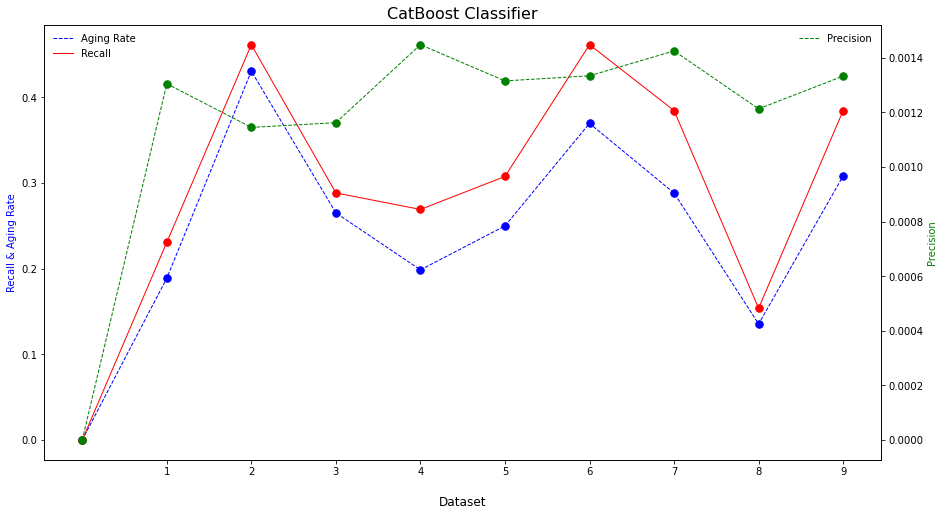

In [6]:
table_setC = runall_CatBoostC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC, cat_feature = [])
line_chart(table_setC, title = 'CatBoost Classifier')

In [7]:
table_setC

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset 0     602.749035  156112.0     259.0   0.0      4.0  52.0  48598.0   
dataset 1       1.000000    2339.0    2339.0  12.0   9182.0  40.0  39420.0   
dataset 2       1.000000    3200.0    3200.0  24.0  20930.0  28.0  27672.0   
dataset 3       1.000000    2595.0    2595.0  15.0  12886.0  37.0  35716.0   
dataset 4       1.000000    2340.0    2340.0  14.0   9652.0  38.0  38950.0   
dataset 5       0.995771    2590.0    2601.0  16.0  12145.0  36.0  36457.0   
dataset 6       0.810135    2590.0    3197.0  24.0  17962.0  28.0  30640.0   
dataset 7       1.000000    2590.0    2590.0  20.0  14009.0  32.0  34593.0   
dataset 8       1.000000    2590.0    2590.0   8.0   6585.0  44.0  42017.0   
dataset 9      10.000000    2590.0     259.0  20.0  14980.0  32.0  33622.0   

           Precision    Recall  Aging Rate  Efficiency     Score  
dataset 0   0.000000  0.000000    0.000082    0.000000  0.000000  
dataset 1   0.001305  0.230769    0.188967    1.221215  0.184166  
dataset 2   0.001145  0.461538    0.430674    1.071666  0.336163  
dataset 3   0.001163  0.288462    0.265158    1.087885  0.212351  
dataset 4   0.001448  0.269231    0.198668    1.355178  0.230628  
dataset 5   0.001316  0.307692    0.249949    1.231022  0.246911  
dataset 6   0.001334  0.461538    0.369672    1.248510  0.373970  
dataset 7   0.001426  0.384615    0.288342    1.333885  0.325975  
dataset 8   0.001213  0.153846    0.135508    1.135330  0.116711  
dataset 9   0.001333  0.384615    0.308299    1.247538  0.311475

### Regressor


 Dataset 0:
Best Threshold: -0.0018673753877326582 

Recall: [0.80769231] ,   Precision: [0.00107488] ,   Aging Rate: [0.80309944]

 Dataset 1:
Best Threshold: 0.18431427536832667 

Recall: [0.80769231] ,   Precision: [0.00117637] ,   Aging Rate: [0.73381428]

 Dataset 2:
Best Threshold: 0.2003131074996774 

Recall: [0.80769231] ,   Precision: [0.00111779] ,   Aging Rate: [0.77226949]

 Dataset 3:
Best Threshold: 0.18197064986686318 

Recall: [0.80769231] ,   Precision: [0.00122068] ,   Aging Rate: [0.70717721]

 Dataset 4:
Best Threshold: 0.19572350103967573 

Recall: [0.80769231] ,   Precision: [0.00127811] ,   Aging Rate: [0.67540182]

 Dataset 5:
Best Threshold: 0.20215754658517054 

Recall: [0.80769231] ,   Precision: [0.00117878] ,   Aging Rate: [0.73231389]

 Dataset 6:
Best Threshold: 0.1000604228686322 

Recall: [0.80769231] ,   Precision: [0.0010661] ,   Aging Rate: [0.8097176]

 Dataset 7:
Best Threshold: 0.1492687423072077 

Recall: [0.80769231] ,   Precision: [0.00115378]

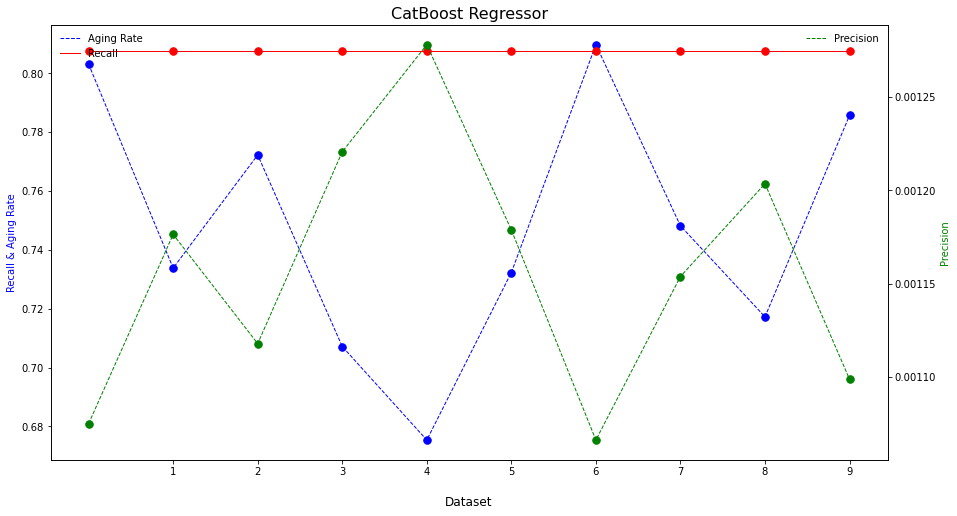

In [12]:
pr_dict, table_setR = runall_CatBoostR(10, trainset_x, run_test_x, trainset_y, run_test_y, best_paramR, cat_feature = [], 
                                       thres_target = 'Recall', threshold = 0.8)
line_chart(table_setR, title = 'CatBoost Regressor')

Class_Prob  train_OK  train_NG  Balance Ratio    TP       FP    FN  \
dataset 0   -0.001867   57637.0     105.0     548.923810  42.0  39032.0  10.0   
dataset 1    0.184314     875.0     875.0       1.000000  42.0  35661.0  10.0   
dataset 2    0.200313    1245.0    1245.0       1.000000  42.0  37532.0  10.0   
dataset 3    0.181971     967.0     967.0       1.000000  42.0  34365.0  10.0   
dataset 4    0.195724     864.0     864.0       1.000000  42.0  32819.0  10.0   
dataset 5    0.202158    1050.0    1055.0       0.995261  42.0  35588.0  10.0   
dataset 6    0.100060    1050.0    1249.0       0.840673  42.0  39354.0  10.0   
dataset 7    0.149269    1050.0    1050.0       1.000000  42.0  36360.0  10.0   
dataset 8    0.127666    1050.0    1050.0       1.000000  42.0  34855.0  10.0   
dataset 9    0.105909    1050.0     105.0      10.000000  42.0  38185.0  10.0   

                TN  Precision    Recall  Aging Rate  Efficiency     Score  
dataset 0   9570.0   0.001075  0.807692    0.803099    1.005719  0.562156  
dataset 1  12941.0   0.001176  0.807692    0.733814    1.100677  0.599517  
dataset 2  11070.0   0.001118  0.807692    0.772269    1.045868  0.578164  
dataset 3  14237.0   0.001221  0.807692    0.707177    1.142136  0.615303  
dataset 4  15783.0   0.001278  0.807692    0.675402    1.195869  0.635313  
dataset 5  13014.0   0.001179  0.807692    0.732314    1.102932  0.600384  
dataset 6   9248.0   0.001066  0.807692    0.809718    0.997499  0.000000  
dataset 7  12242.0   0.001154  0.807692    0.748181    1.079541  0.591350  
dataset 8  13747.0   0.001204  0.807692    0.717248    1.126099  0.609233  
dataset 9  10417.0   0.001099  0.807692    0.785691    1.028003  0.571080

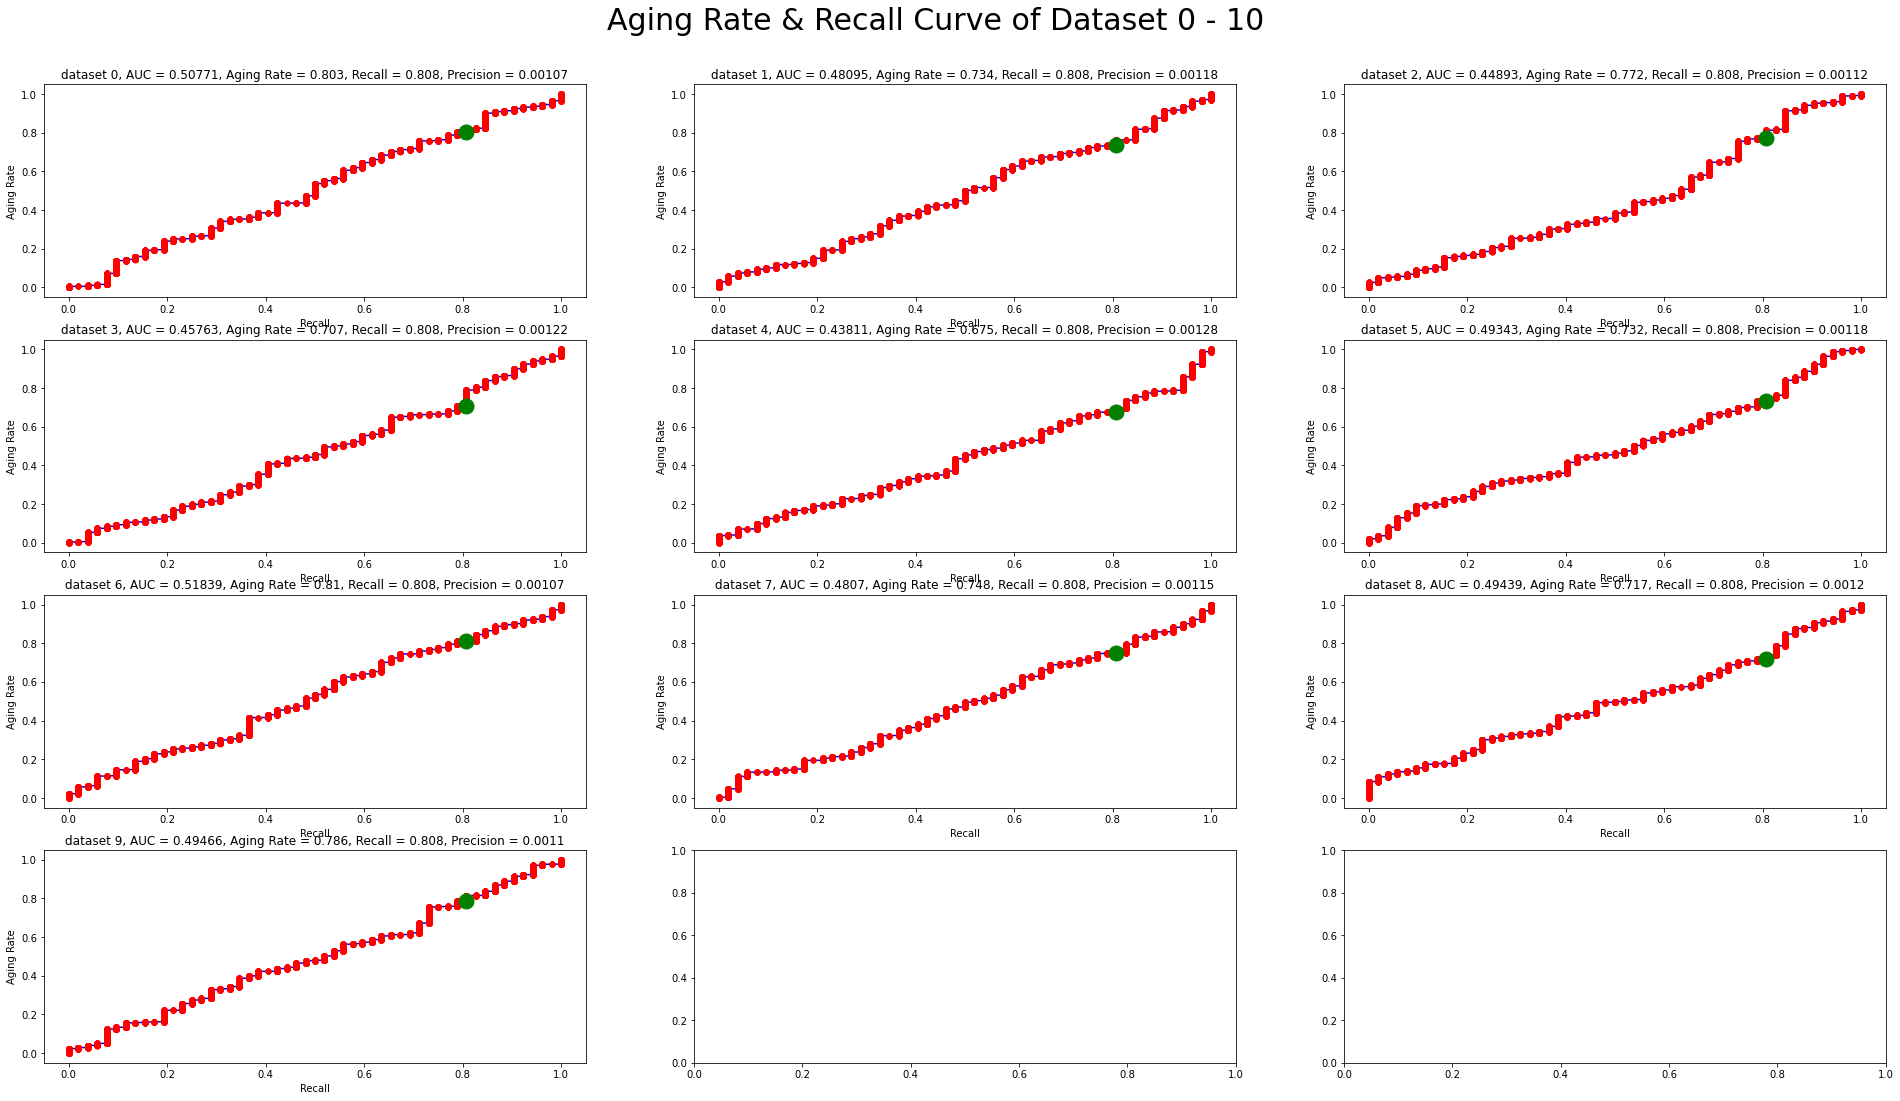

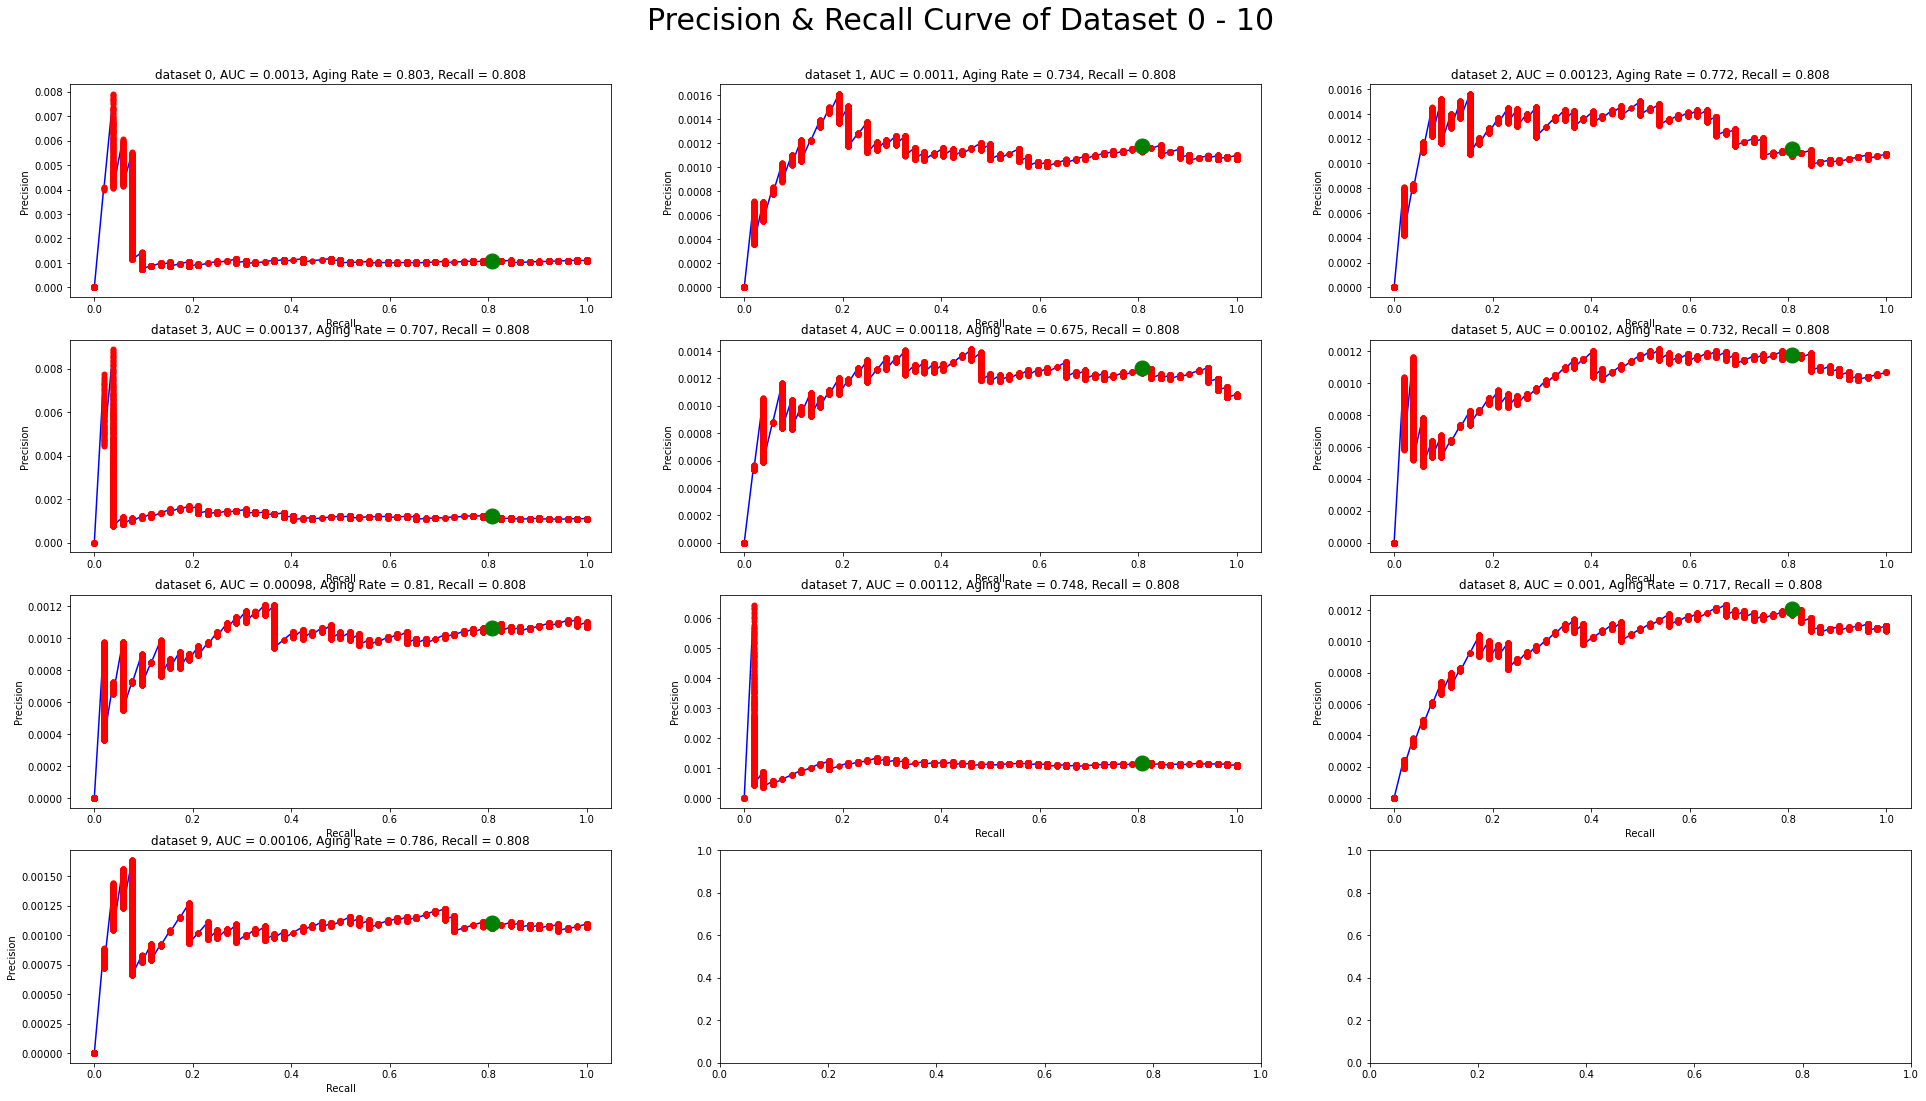

In [13]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [11]:
savedate = '20211019'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setR['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'CatBoost'
table_setR['model'] = 'CatBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'CatBoost')
with pd.ExcelWriter(f'{savedate}_Regressor.xlsx', mode = 'a') as writer:
    table_setR.to_excel(writer, sheet_name = 'CatBoost')